In [1]:
import matplotlib.pyplot as plt

colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

# 예시:
# predicted와 example_output이 [1, 1, 30, 30] 크기의 텐서라고 가정
#show_grid_side_by_side(task_input, task_output, predicted)


In [2]:
from bw_net import BWNet
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

def criterion(y_pred, y):
    y = y.long().squeeze(1)
    ce = F.cross_entropy(y_pred, y, ignore_index=0)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 20,
    'task_numbers': 10,  # equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20,  # equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.01,
}

# CUDA 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

# 모델을 GPU로 이동
model = BWNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=kwargs['outer_lr'])

for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    task_loss = 0
    total_samples = 0
    
    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]  # 데이터를 GPU로 이동
        total_samples += input_tensor.shape[0]
        for task_number in range(input_tensor.shape[0]):
            task_input = input_tensor[task_number]
            task_output = output_tensor[task_number]
            ex_input = example_input[task_number]
            ex_output = example_output[task_number]
            model.train()
            optimizer.zero_grad()
            prediction = model(task_input, ex_input, ex_output)
            prediction_class = torch.argmax(prediction, dim=1, keepdim=True)  # [1, 11, 30, 30] -> [1, 1, 30, 30]
            loss = criterion(prediction, task_output)
            loss.backward()
            optimizer.step()
            task_loss += loss.item()
            
    task_loss /= total_samples

    model.eval()
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for data in tqdm(eval_loader, desc='Validation'):
            input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]  # 데이터를 GPU로 이동
            total_samples += input_tensor.shape[0] * 900
            for task_number in range(input_tensor.shape[0]):
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                ex_input = example_input[task_number]
                ex_output = example_output[task_number]
                prediction = model(task_input, ex_input, ex_output)
                prediction_class = torch.argmax(prediction, dim=1, keepdim=True)  # [1, 11, 30, 30] -> [1, 1, 30, 30]
                correct += (prediction_class == task_output).sum().item()

        show_grid_side_by_side(task_input.cpu(), task_output.cpu(), prediction_class.cpu())  # CPU로 이동하여 시각화
                
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {task_loss}, Accuracy: {100 * correct / total_samples}%')


Epoch 1/20


Training:   0%|          | 0/42 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
from bw_net_maml import BWNet_MAML
import torch
from thop import profile
from thop import clever_format

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BWNet_MAML(embed_size=1).to(device)
# 입력 텐서 생성
x = torch.randn(1, 1, 30, 30).to(device)

# FLOPs 및 파라미터 수 계산
try:
    flops, params = profile(model, inputs=(x,))
    flops, params = clever_format([flops, params], "%.3f")
    print(f"FLOPs: {flops}")
    print(f"파라미터 수: {params}")
except Exception as e:
    print(f"Error during profiling: {e}")
    print(f"Input shape: {x.shape}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPs: 34.578M
파라미터 수: 31.190M


Using cuda device
Epoch 1/25


Validation: 100%|██████████| 21/21 [01:28<00:00,  4.23s/it]


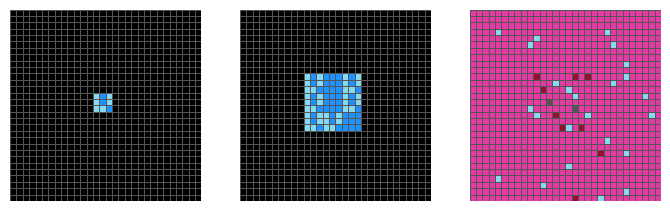

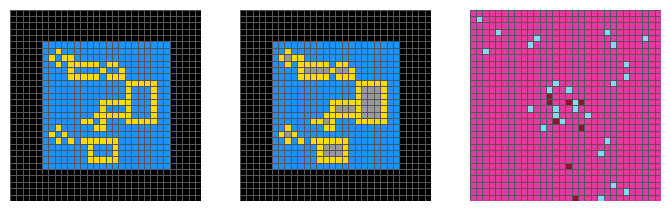

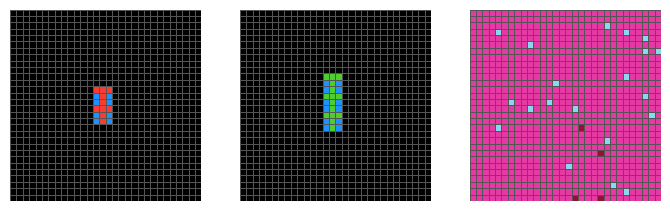

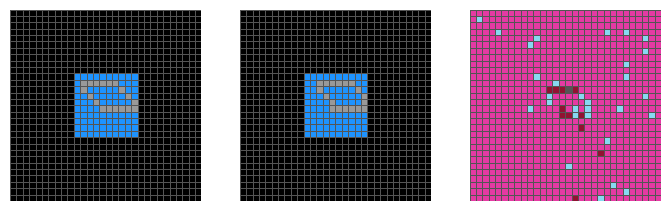

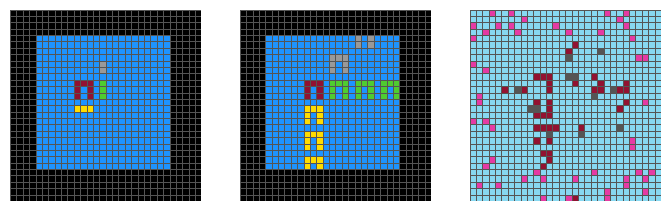

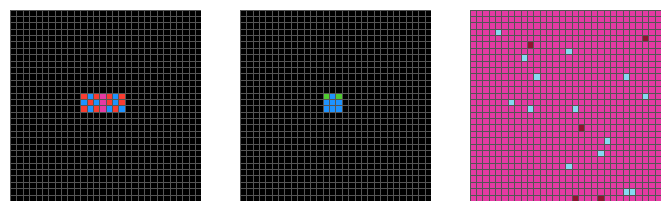

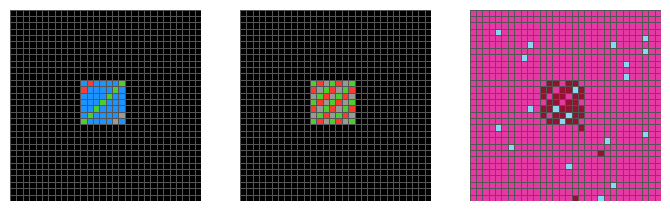

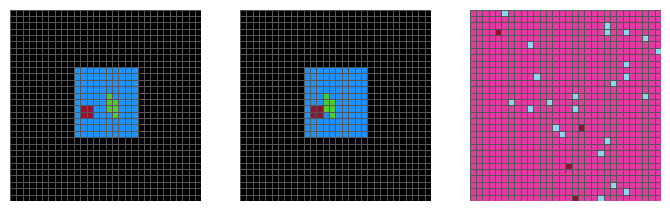

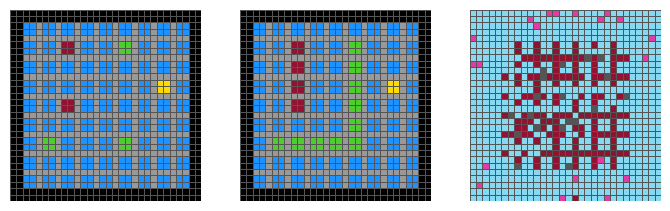

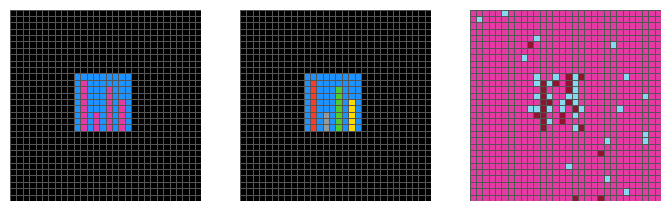

Epoch 1/25, Loss: 5.352161819545122, Accuracy: 0.6175889328063241%
Epoch 2/25


Validation: 100%|██████████| 21/21 [01:28<00:00,  4.22s/it]


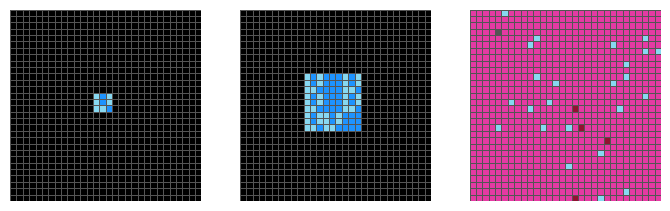

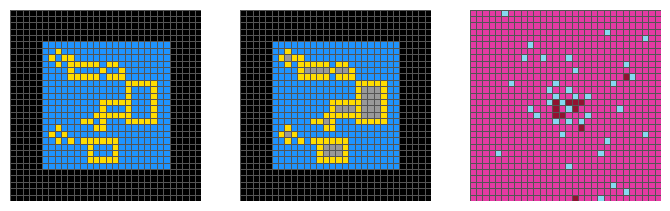

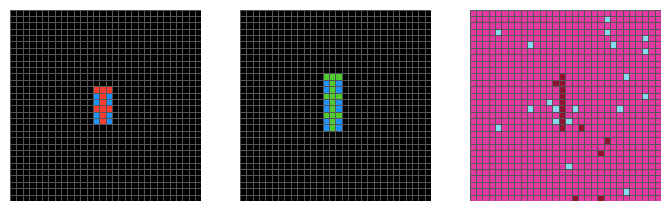

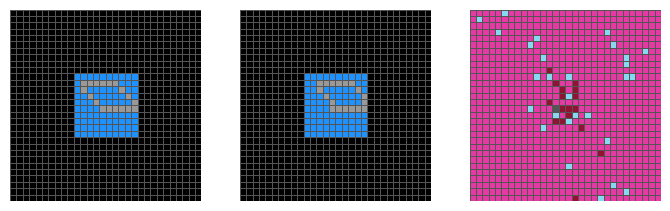

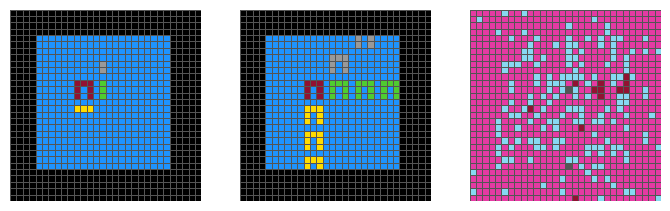

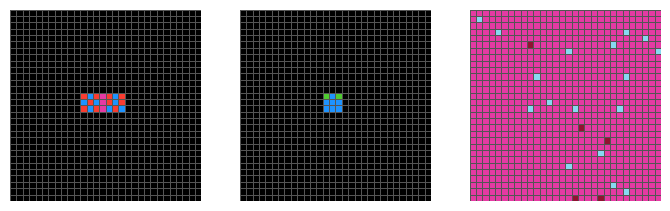

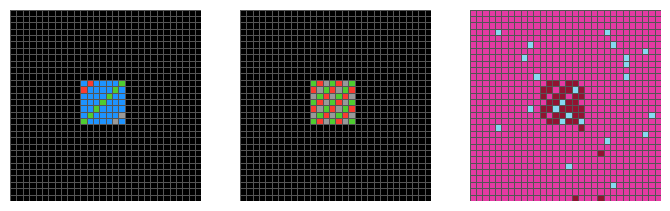

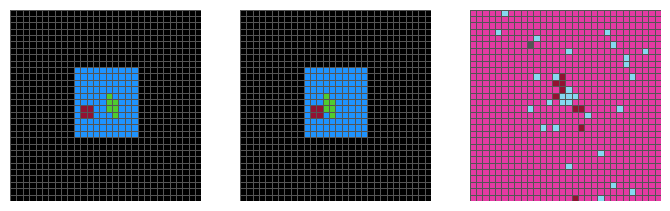

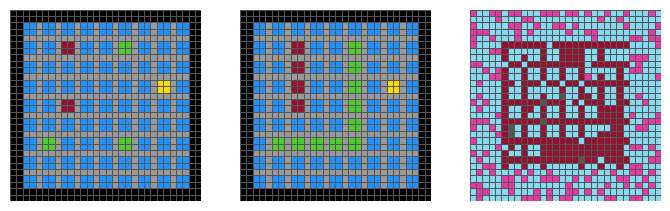

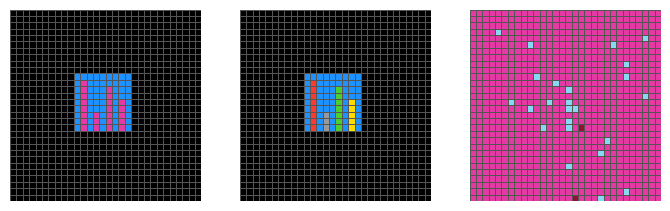

Epoch 2/25, Loss: 5.31638242992071, Accuracy: 0.2717391304347826%
Epoch 3/25


Validation: 100%|██████████| 21/21 [01:28<00:00,  4.23s/it]


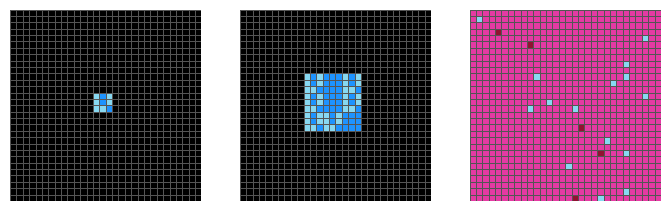

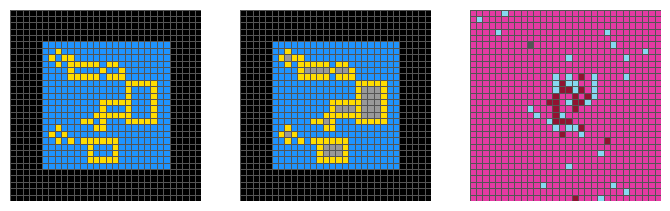

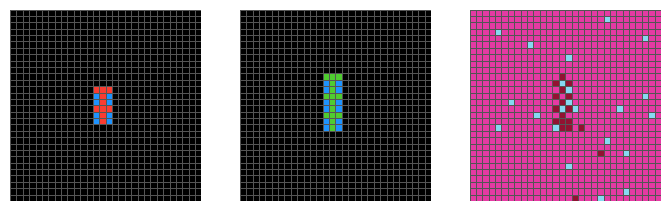

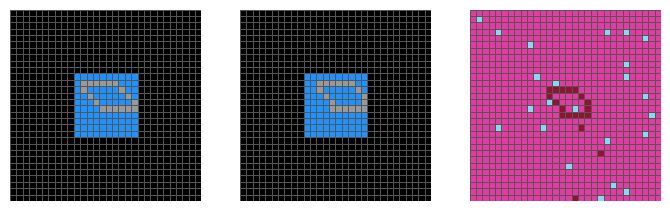

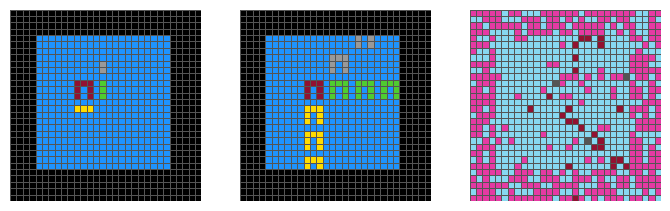

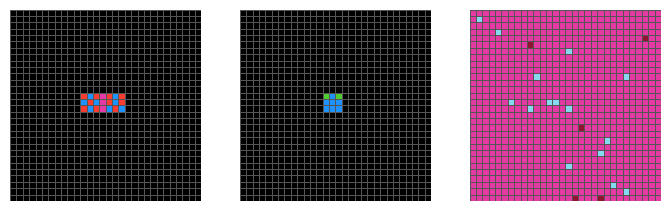

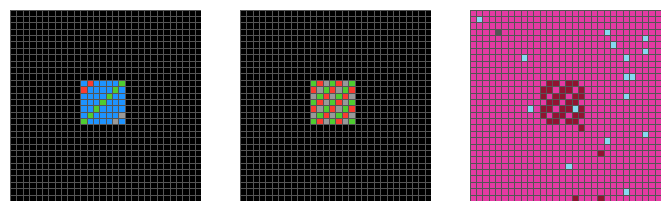

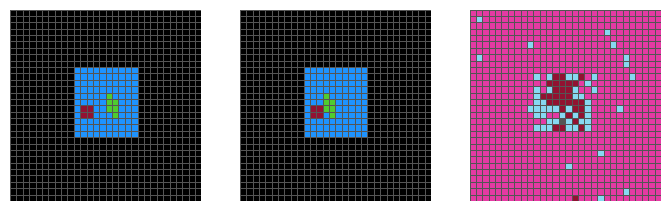

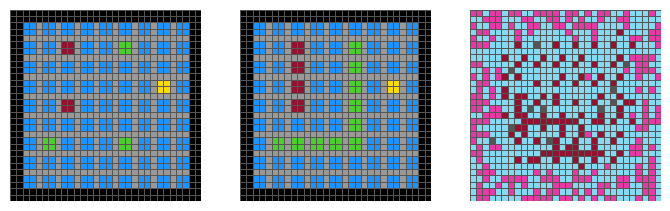

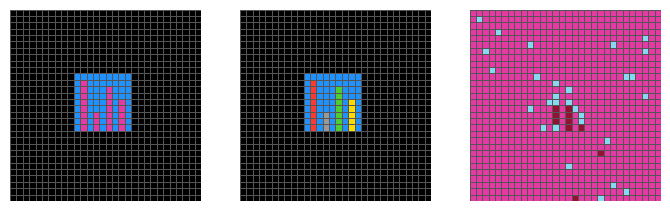

Epoch 3/25, Loss: 5.339211079936761, Accuracy: 0.4252540937323546%
Epoch 4/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.85s/it]


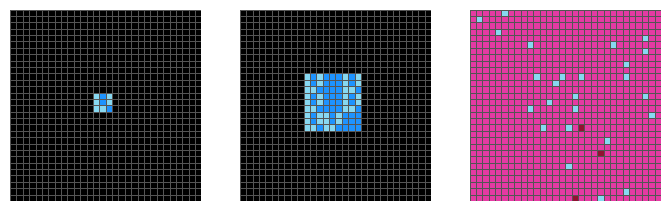

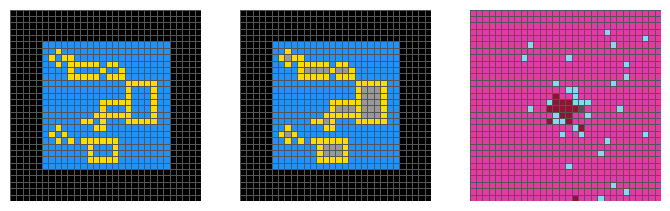

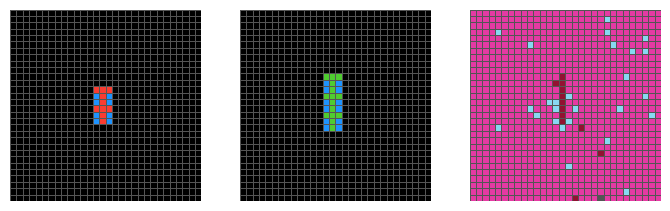

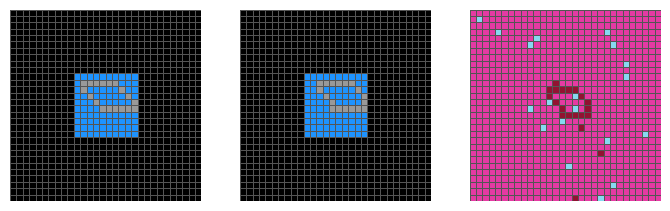

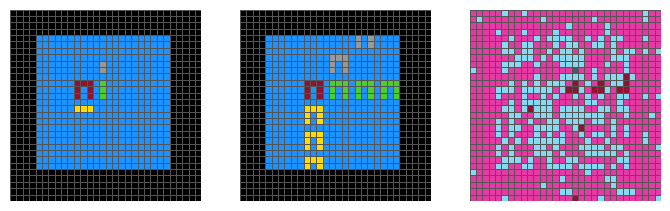

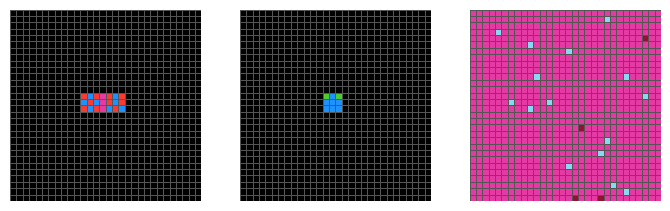

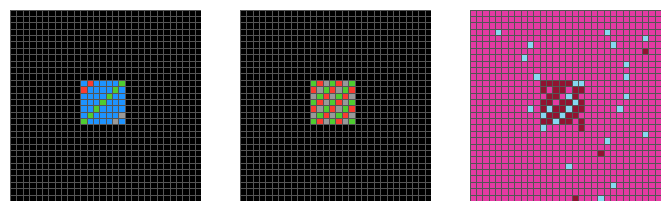

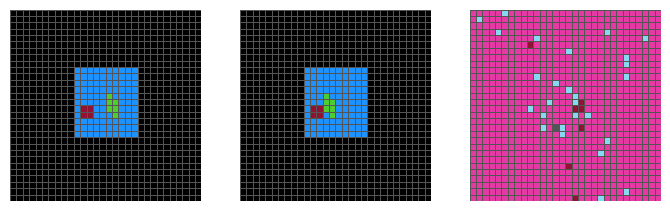

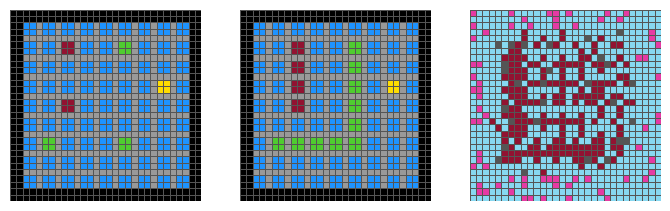

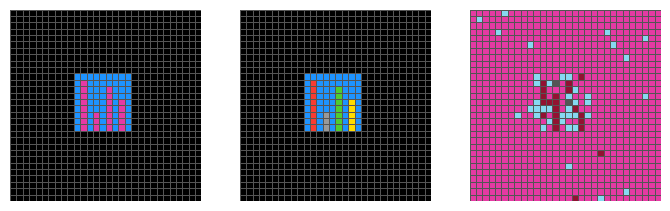

Epoch 4/25, Loss: 5.343926784510796, Accuracy: 0.8011010728402033%
Epoch 5/25


Validation: 100%|██████████| 21/21 [01:42<00:00,  4.87s/it]


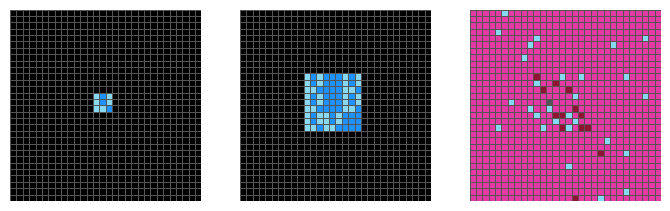

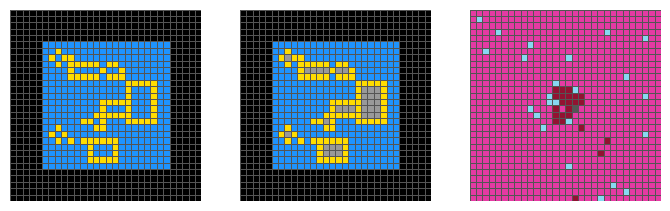

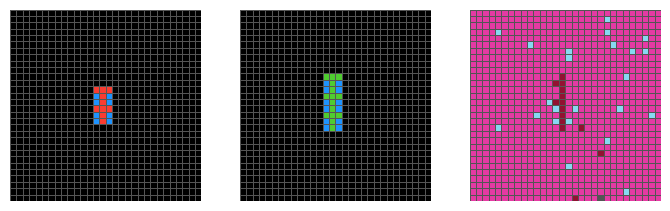

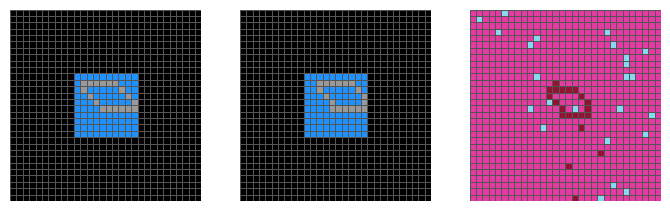

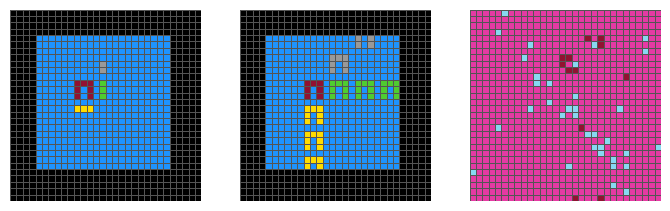

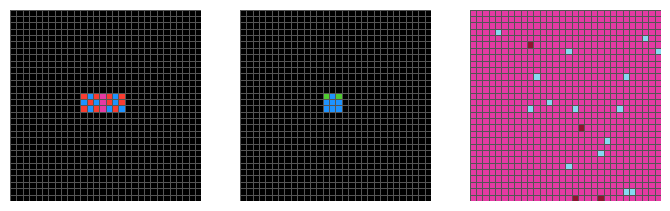

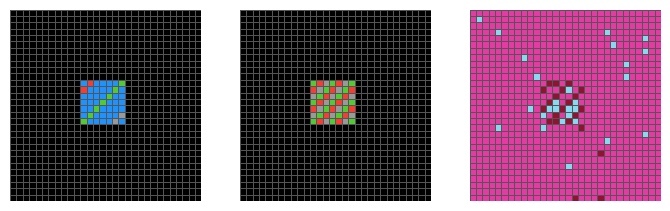

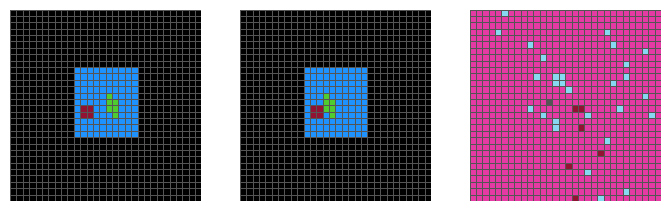

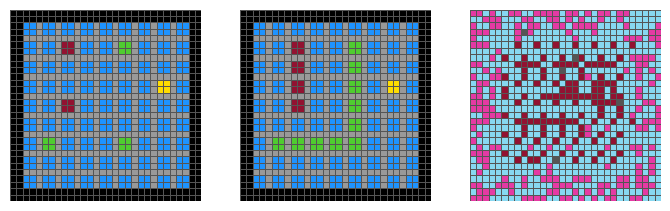

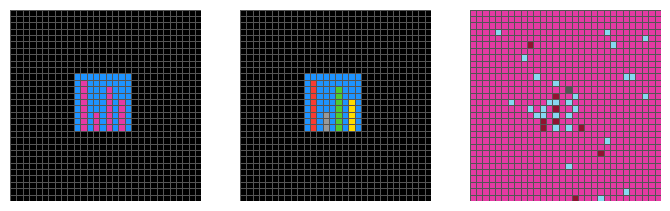

Epoch 5/25, Loss: 5.324831202053106, Accuracy: 0.5999435347261434%
Epoch 6/25


Validation: 100%|██████████| 21/21 [01:40<00:00,  4.80s/it]


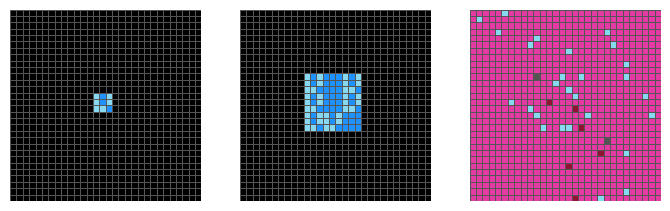

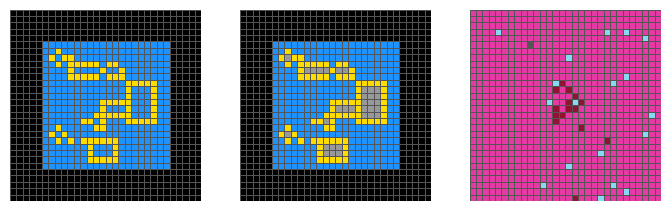

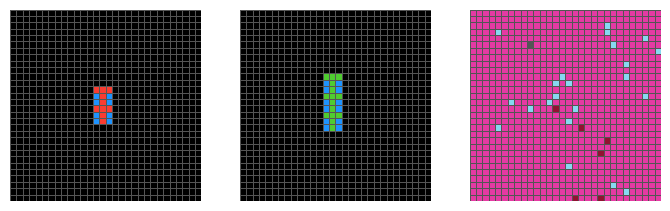

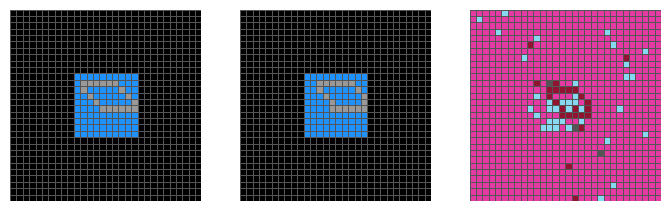

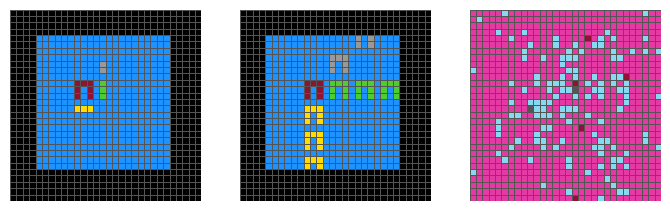

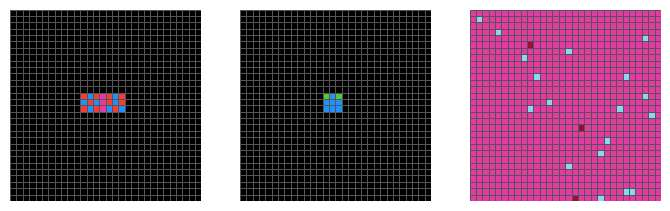

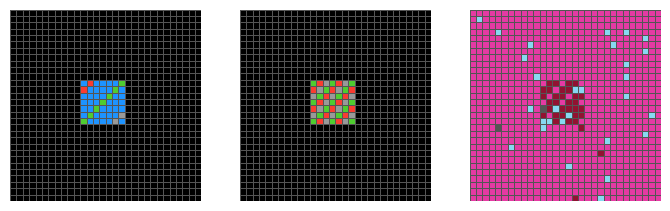

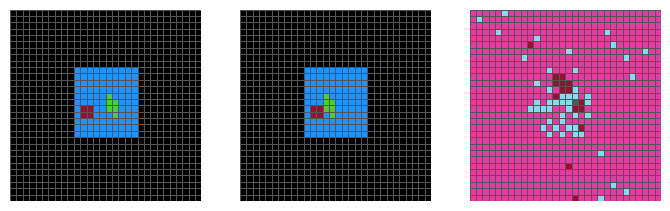

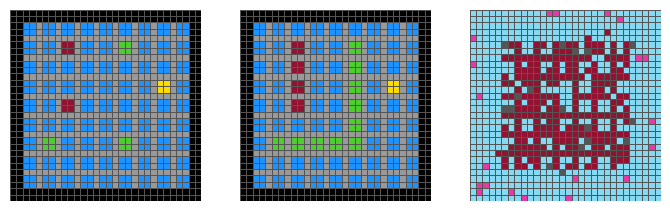

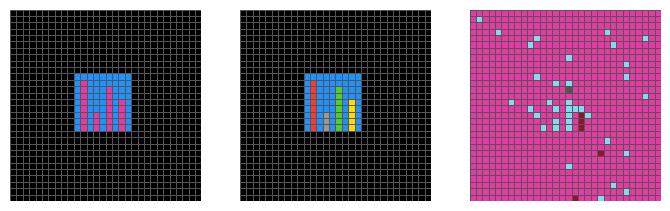

Epoch 6/25, Loss: 5.355043055346379, Accuracy: 0.5875917560700169%
Epoch 7/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.82s/it]


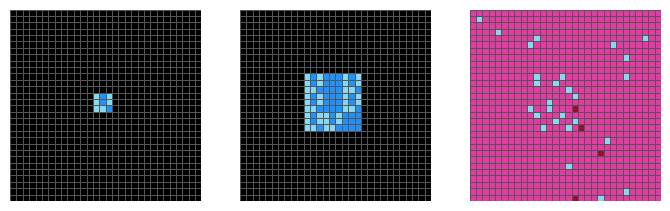

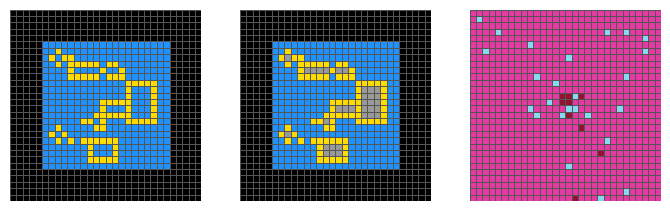

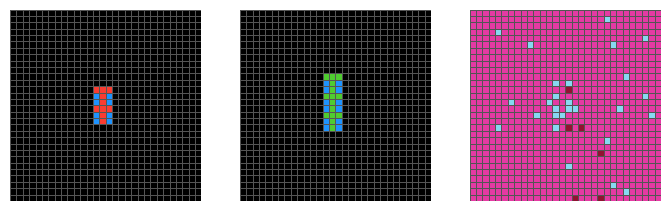

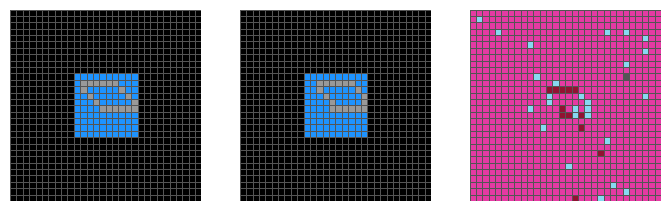

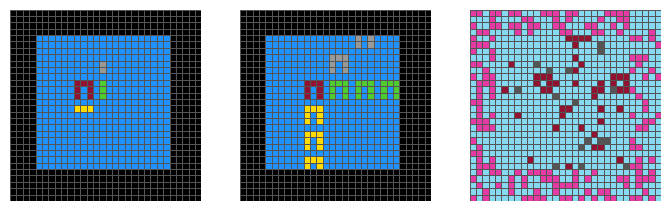

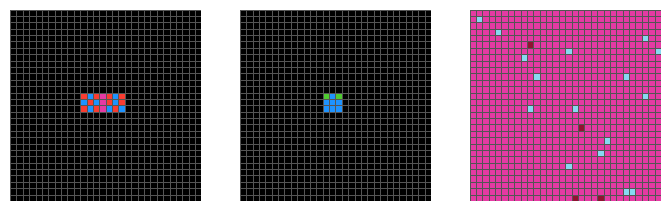

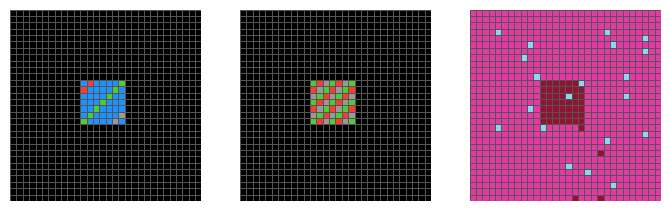

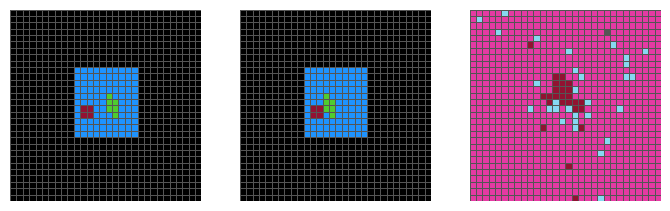

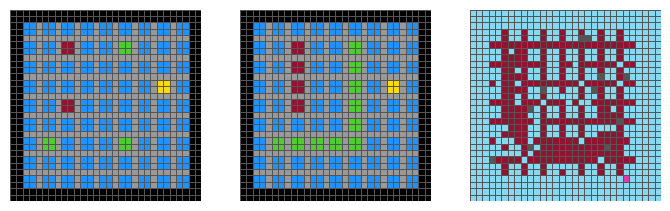

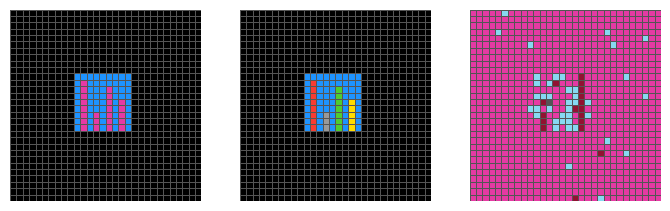

Epoch 7/25, Loss: 5.298064473729867, Accuracy: 0.7763975155279503%
Epoch 8/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.81s/it]


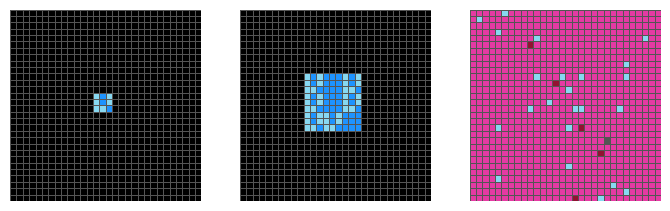

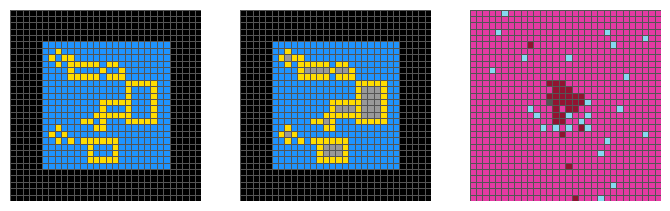

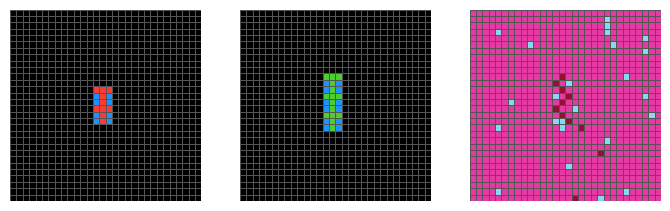

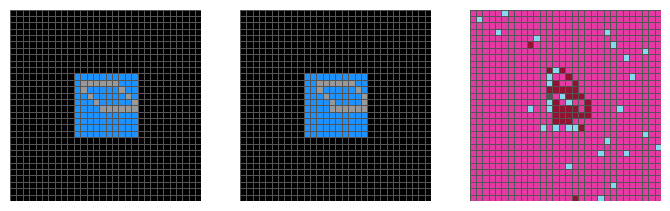

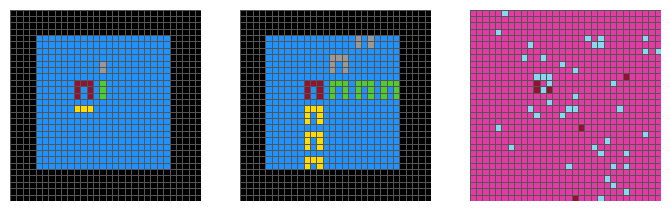

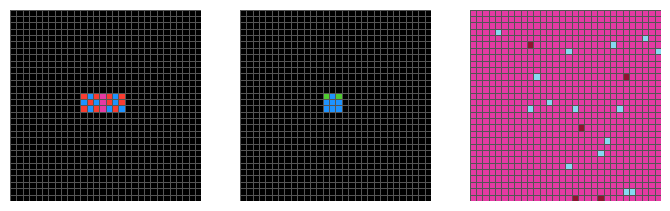

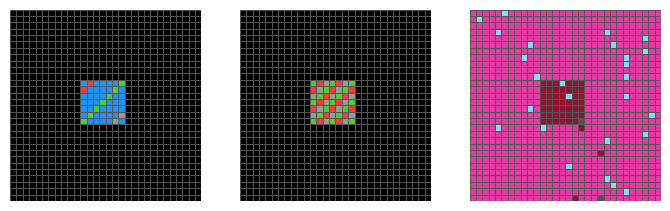

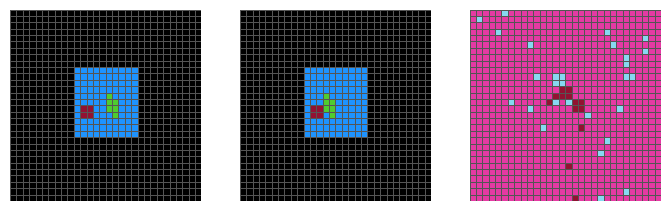

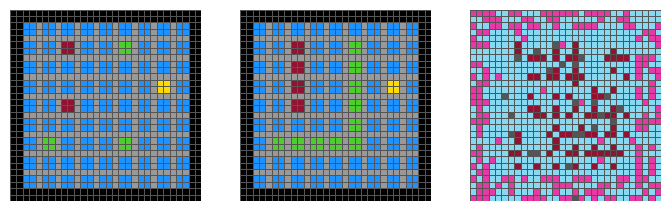

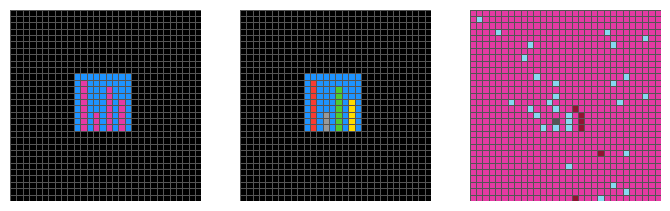

Epoch 8/25, Loss: 5.325261400296138, Accuracy: 0.3017363071710898%
Epoch 9/25


Validation: 100%|██████████| 21/21 [01:40<00:00,  4.79s/it]


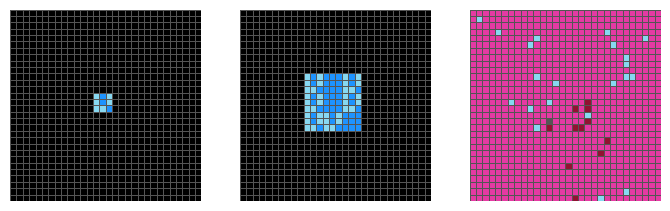

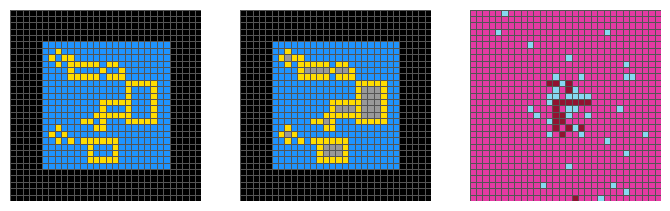

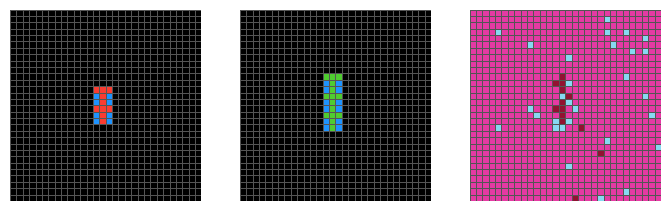

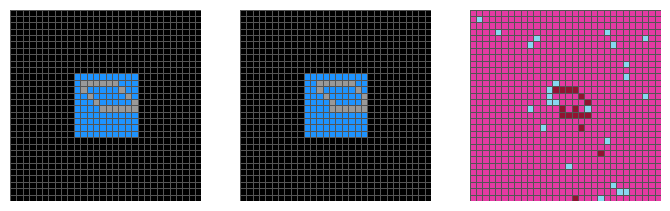

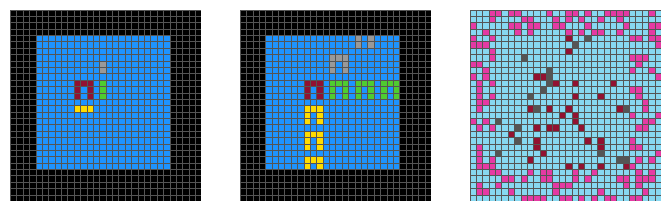

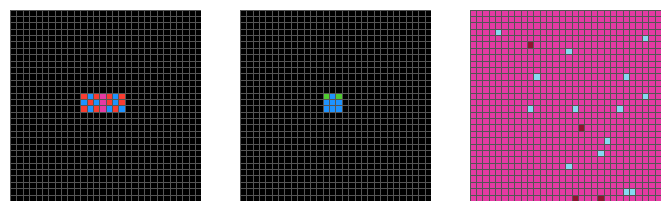

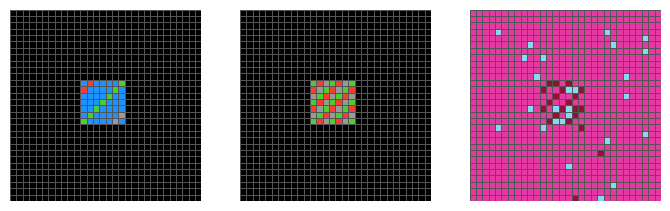

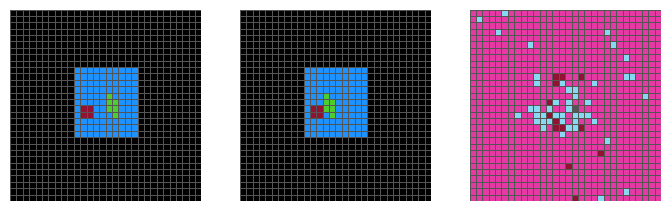

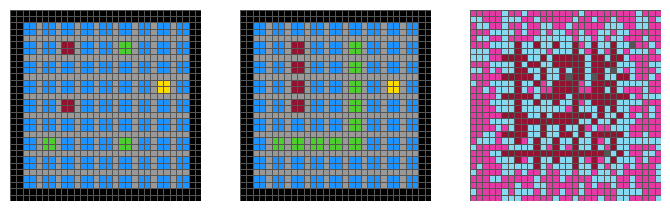

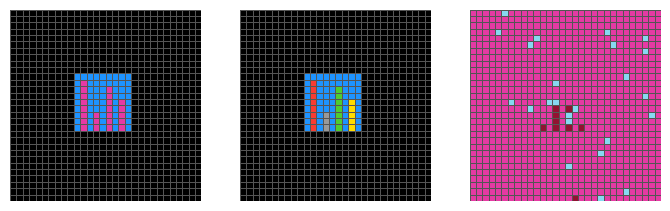

Epoch 9/25, Loss: 5.317990912840917, Accuracy: 0.3652597402597403%
Epoch 10/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.83s/it]


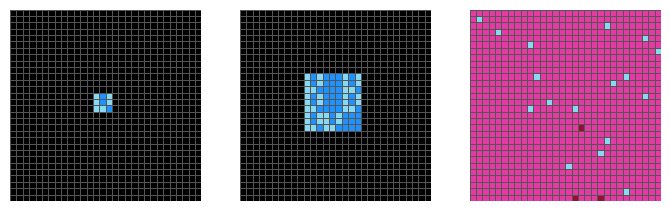

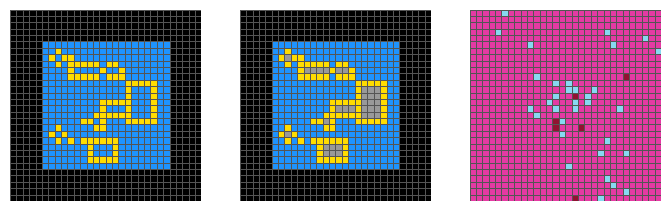

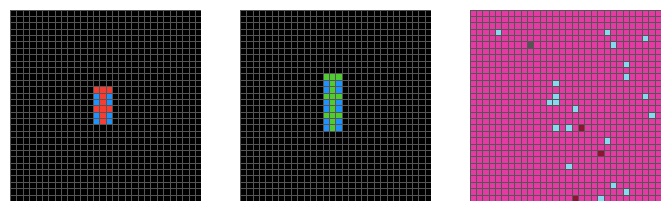

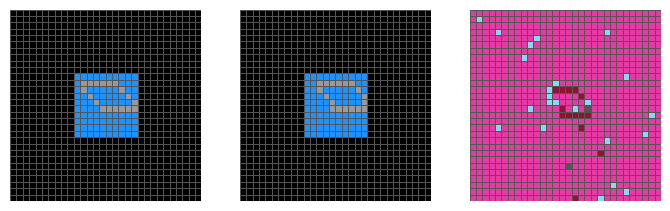

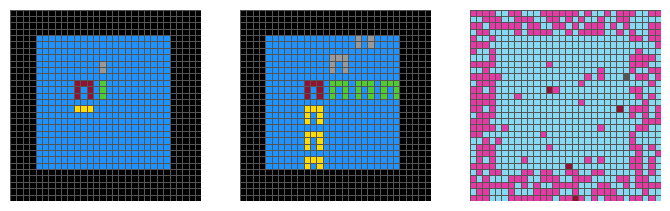

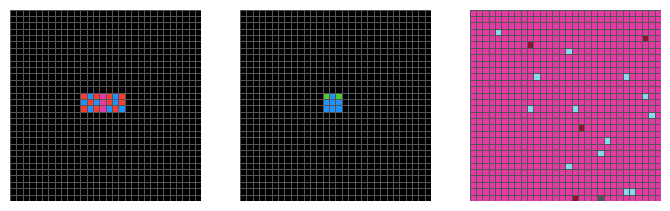

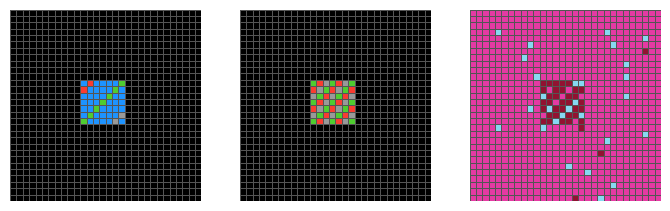

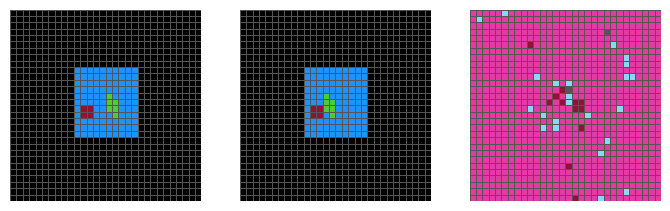

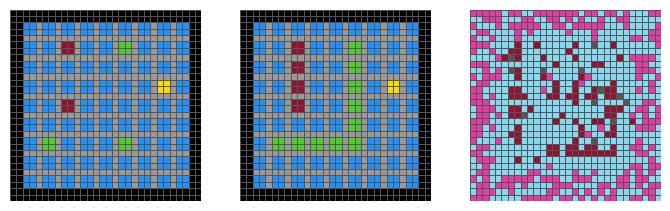

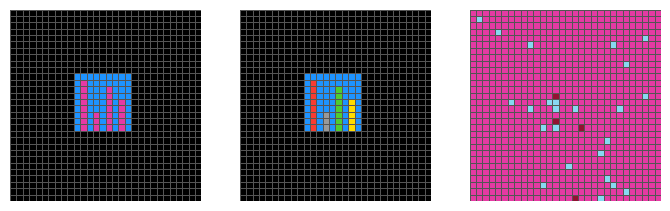

Epoch 10/25, Loss: 5.373066700421846, Accuracy: 0.5752399774138904%
Epoch 11/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.82s/it]


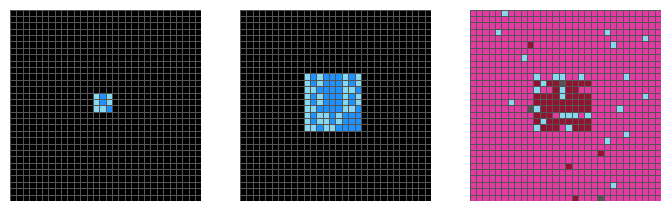

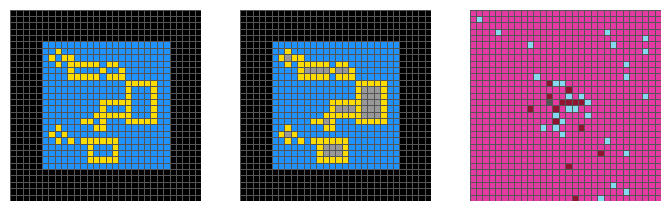

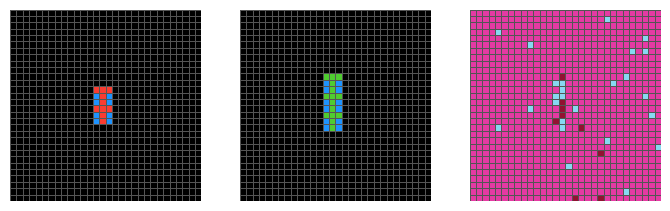

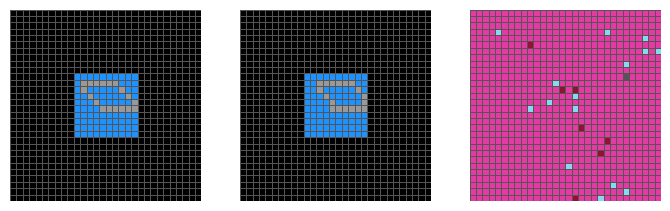

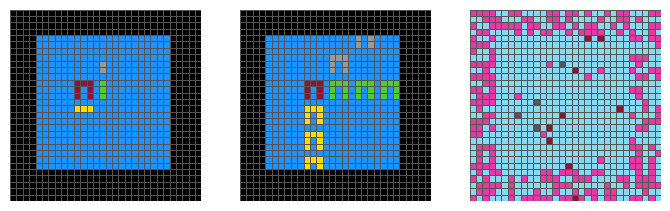

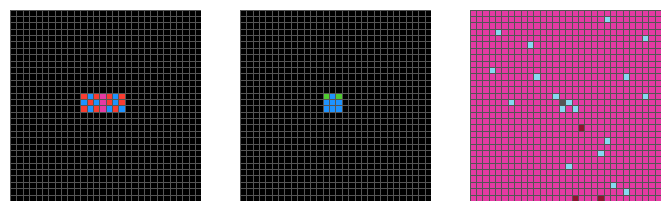

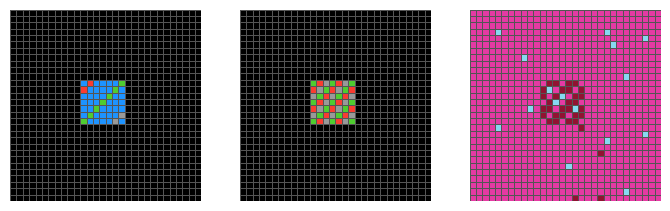

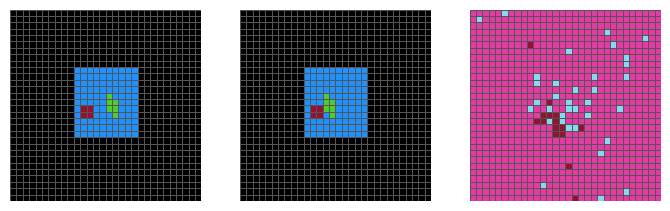

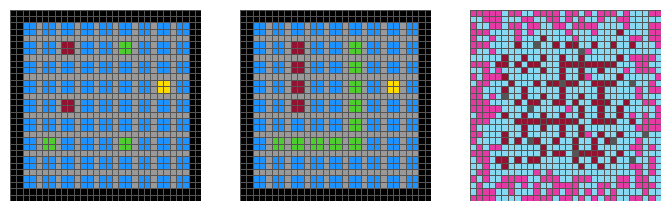

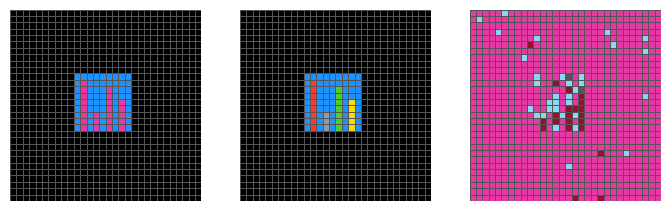

Epoch 11/25, Loss: 5.419208441216212, Accuracy: 0.44466403162055335%
Epoch 12/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.84s/it]


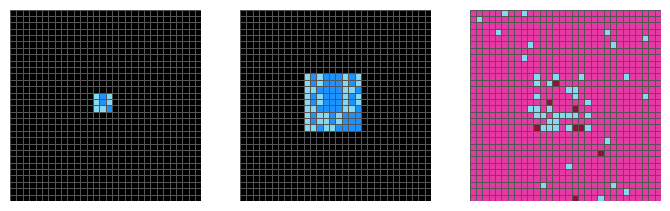

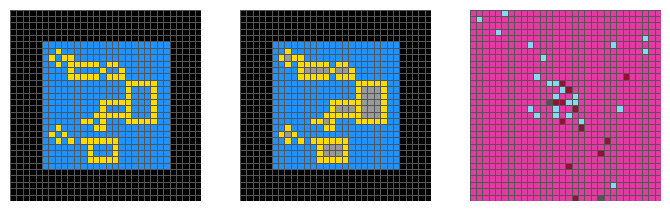

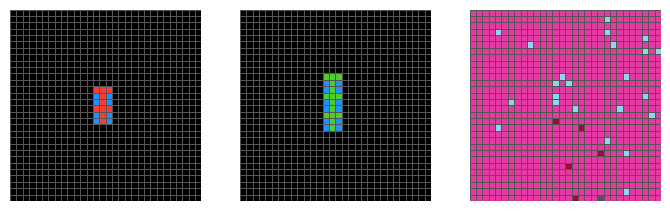

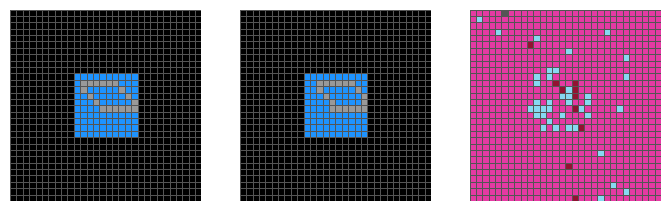

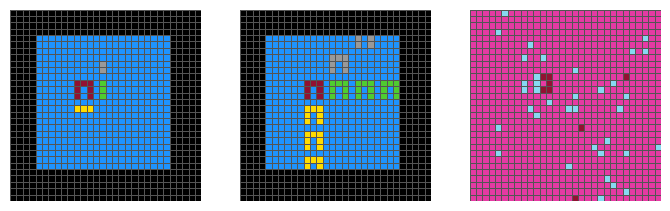

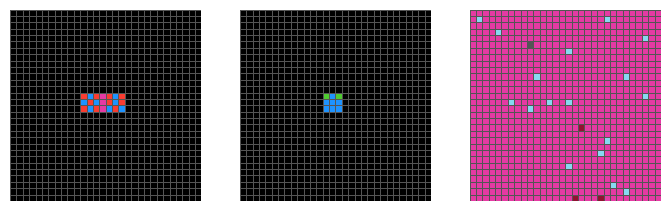

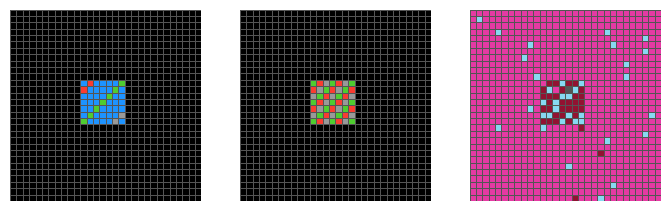

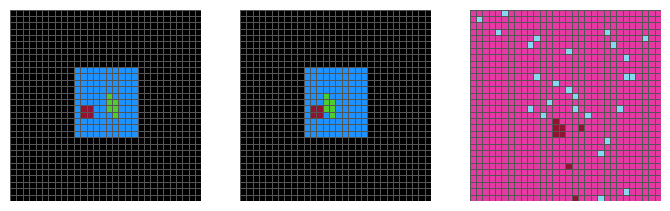

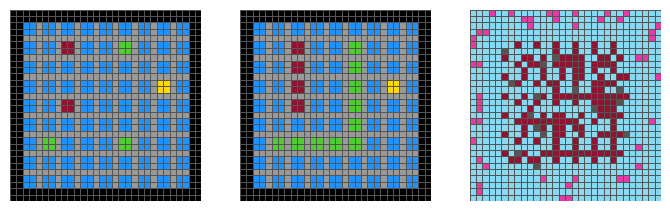

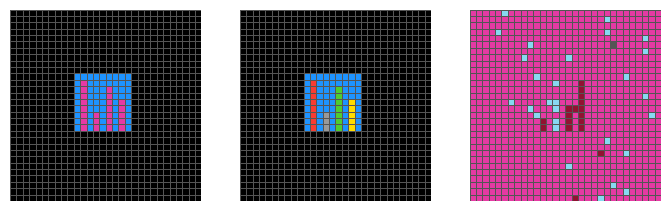

Epoch 12/25, Loss: 5.370381832122803, Accuracy: 0.3652597402597403%
Epoch 13/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.84s/it]


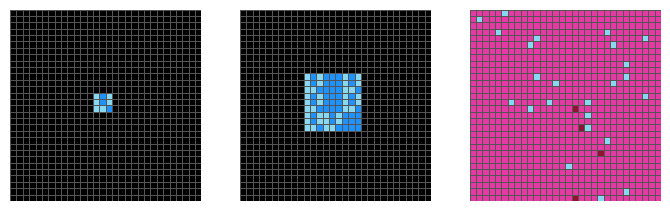

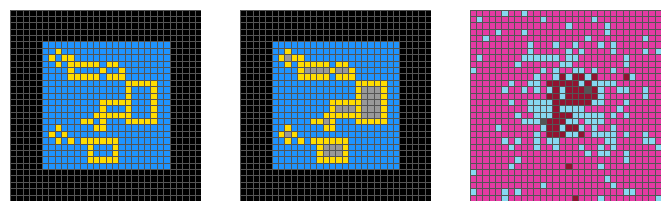

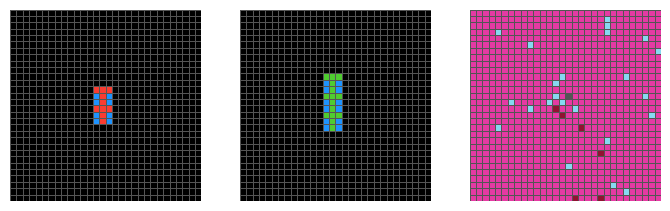

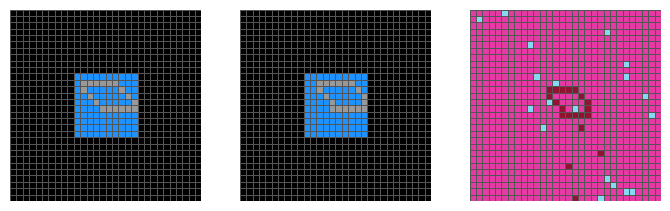

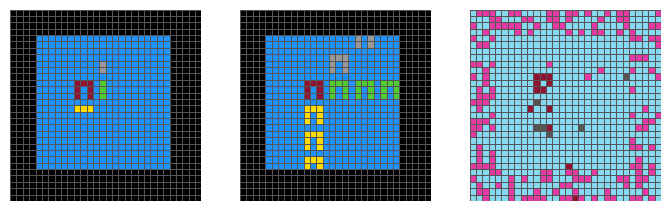

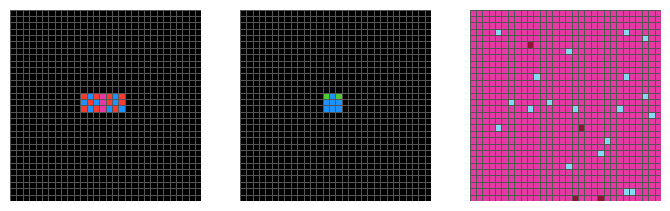

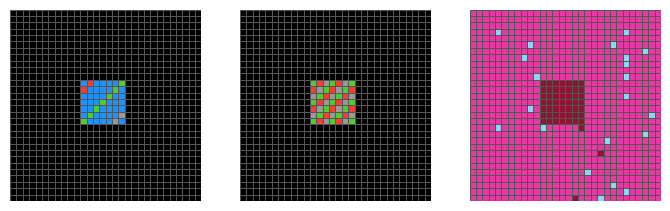

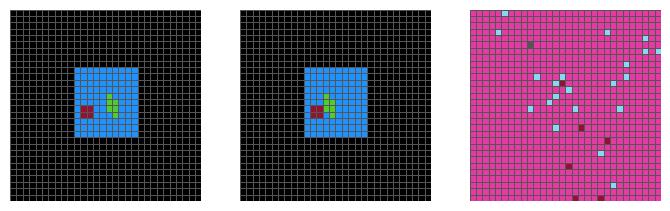

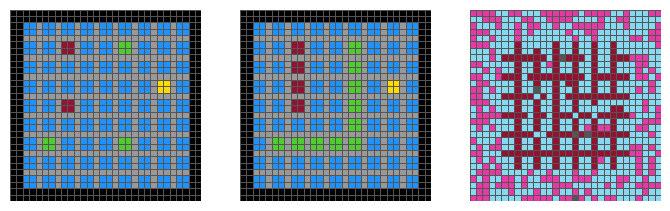

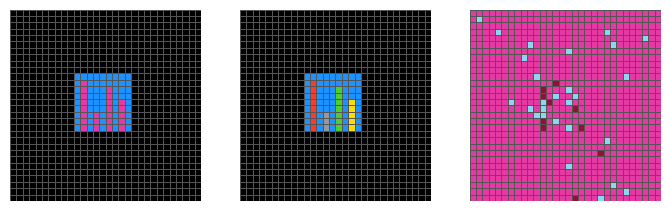

Epoch 13/25, Loss: 5.359815047910581, Accuracy: 0.23644833427442122%
Epoch 14/25


Validation: 100%|██████████| 21/21 [01:37<00:00,  4.64s/it]


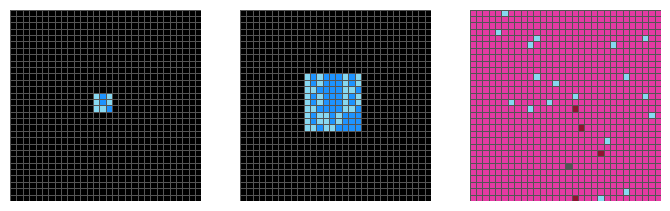

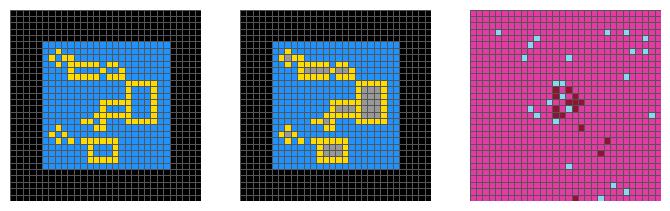

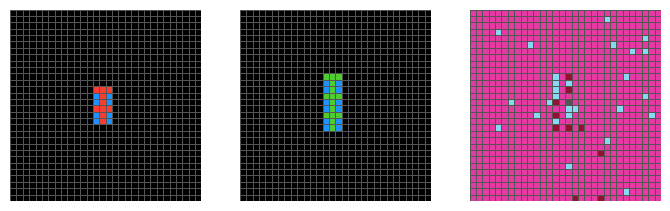

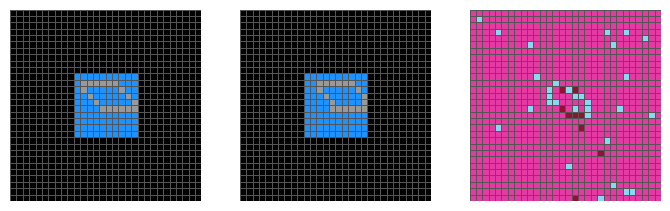

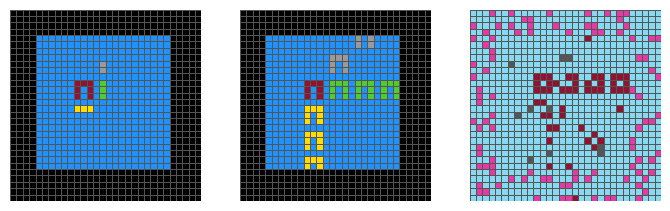

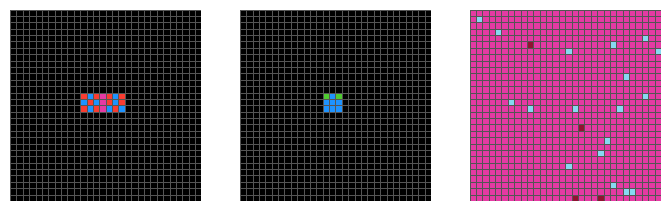

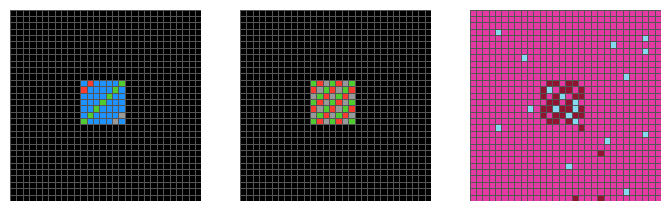

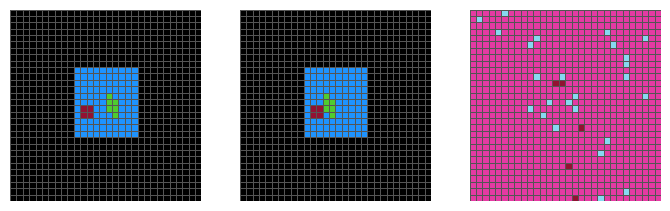

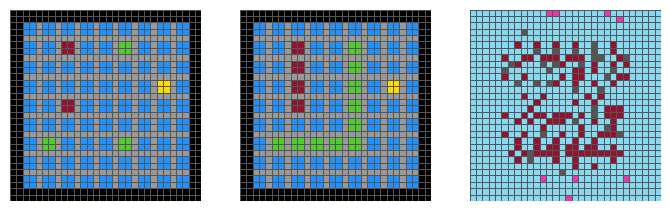

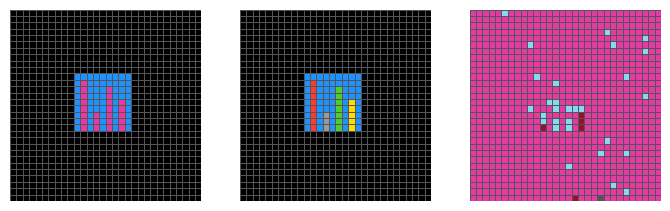

Epoch 14/25, Loss: 5.3700801357626915, Accuracy: 0.5822981366459627%
Epoch 15/25


Validation: 100%|██████████| 21/21 [01:37<00:00,  4.66s/it]


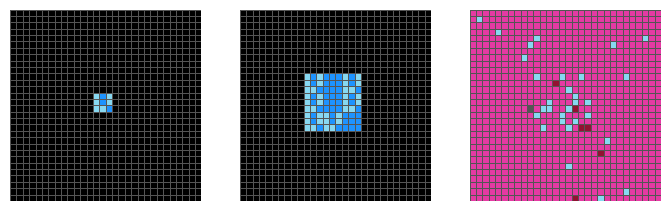

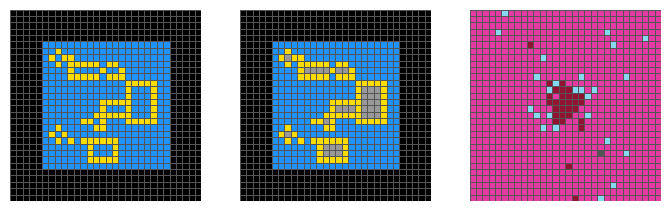

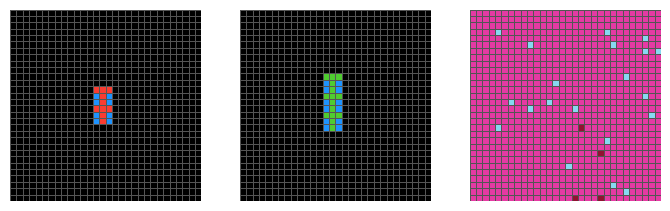

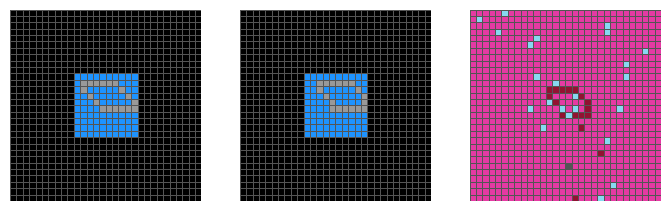

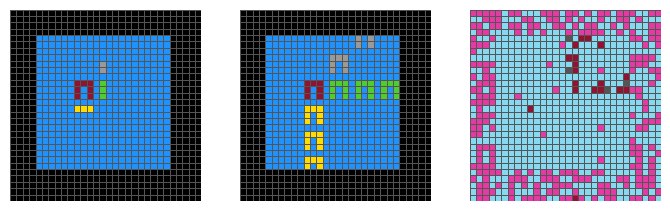

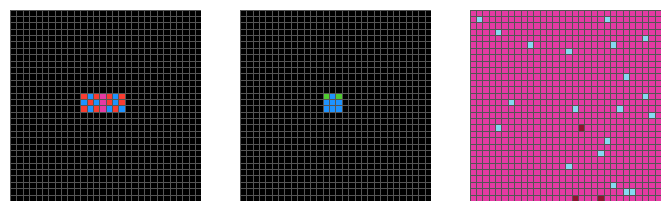

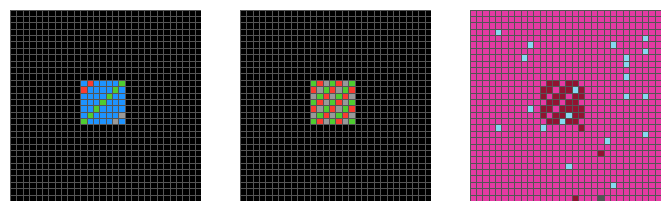

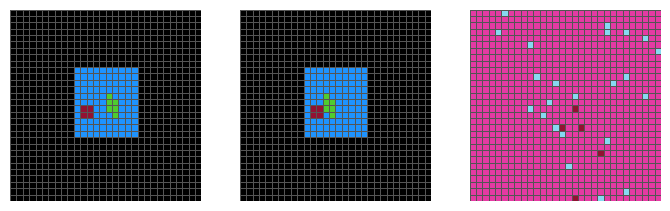

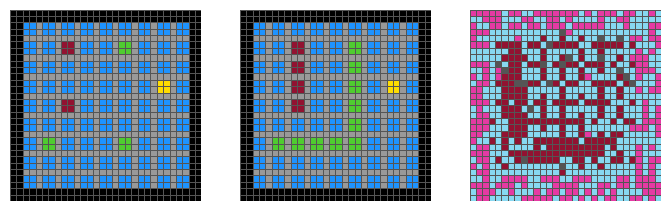

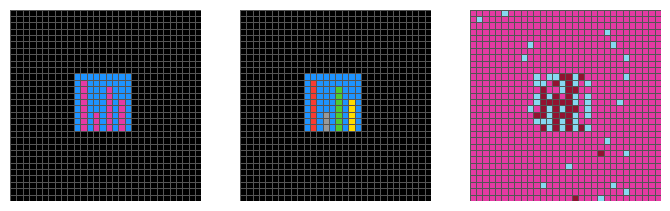

Epoch 15/25, Loss: 5.382312540824596, Accuracy: 0.16057312252964426%
Epoch 16/25


Validation: 100%|██████████| 21/21 [01:38<00:00,  4.71s/it]


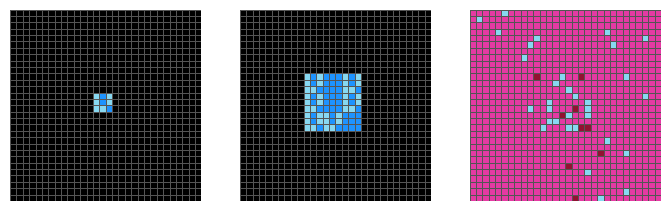

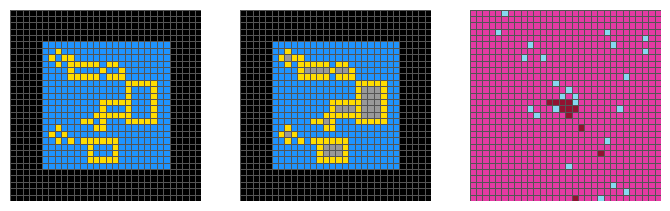

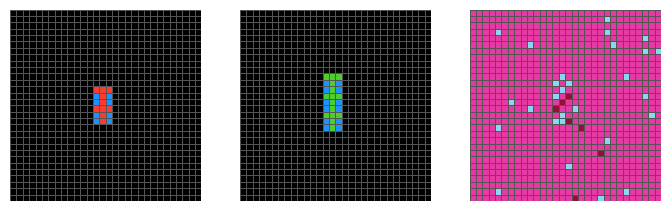

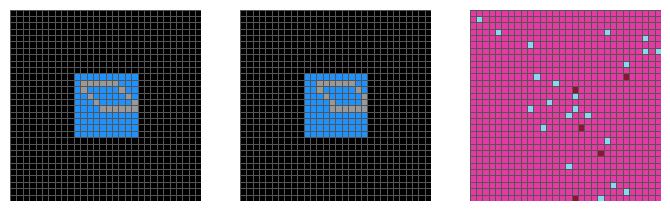

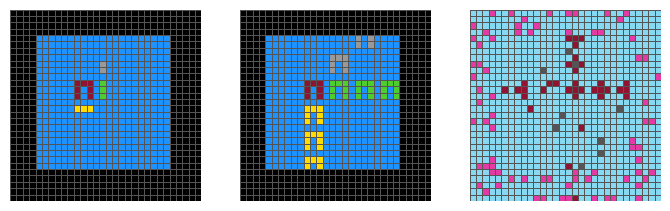

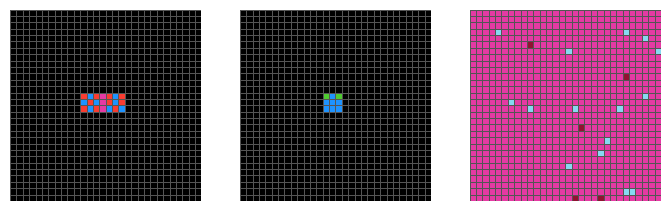

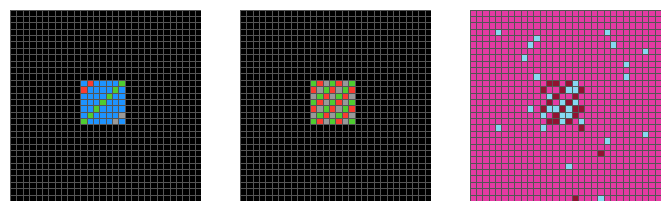

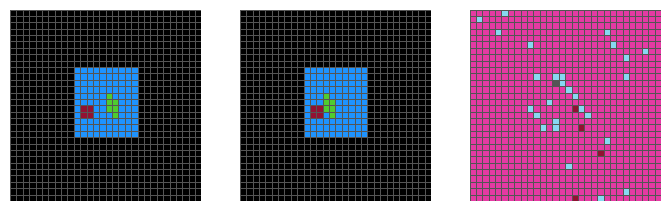

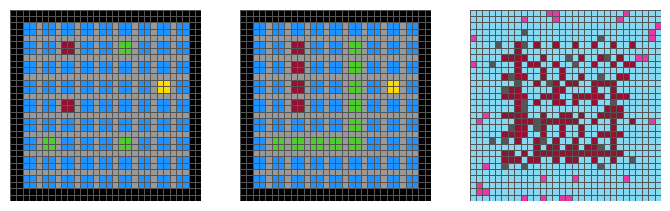

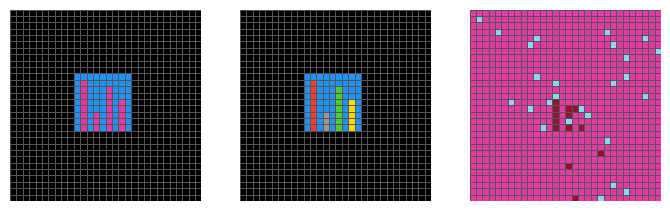

Epoch 16/25, Loss: 5.371931282946696, Accuracy: 0.25938735177865613%
Epoch 17/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.72s/it]


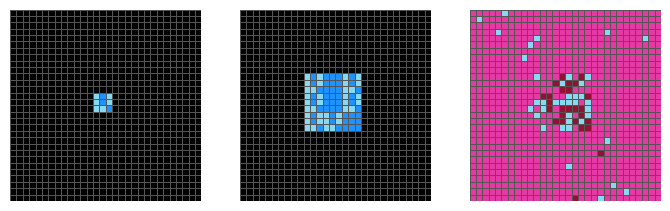

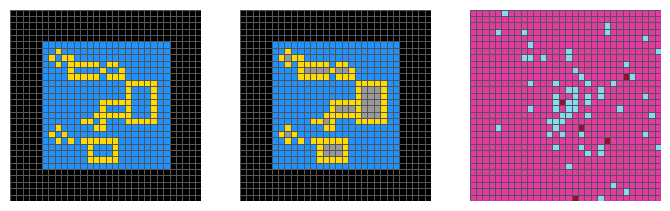

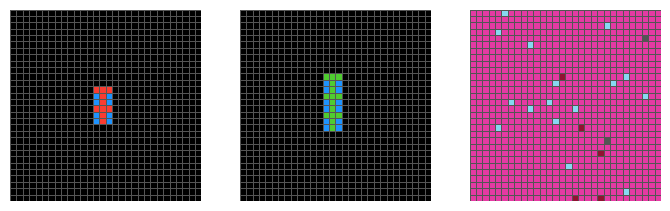

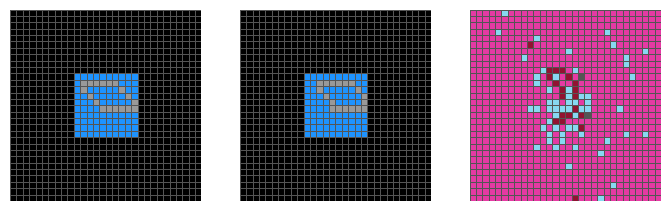

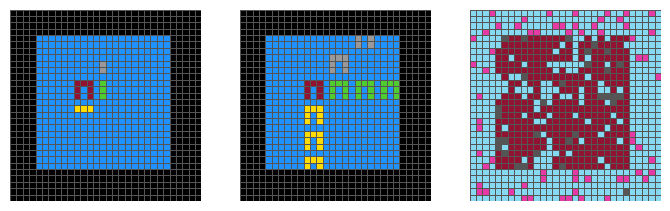

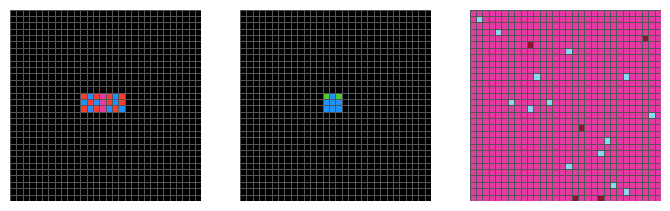

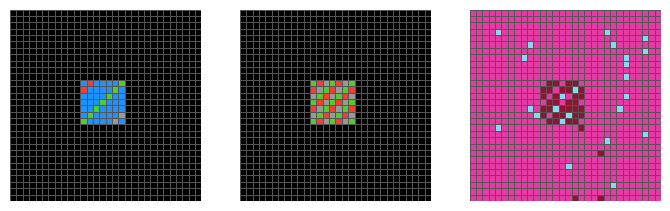

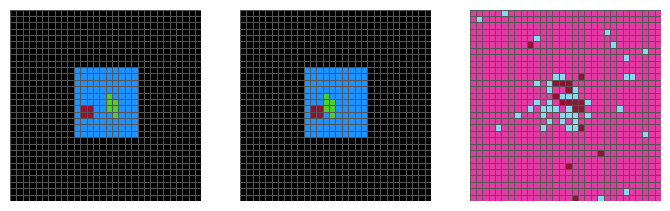

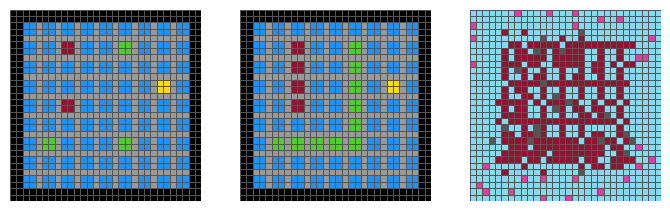

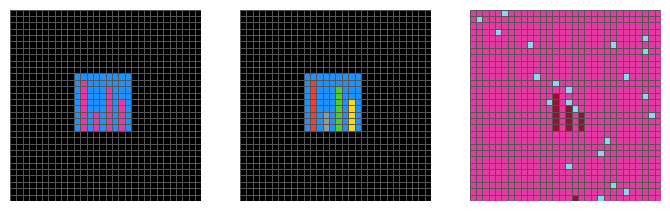

Epoch 17/25, Loss: 5.3112725879137335, Accuracy: 0.3705533596837945%
Epoch 18/25


Validation: 100%|██████████| 21/21 [01:40<00:00,  4.78s/it]


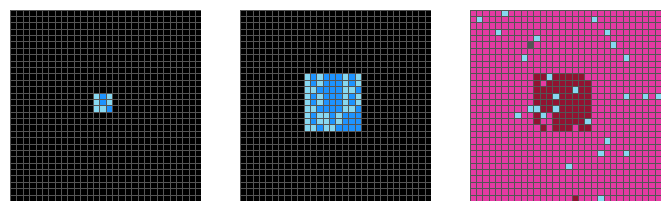

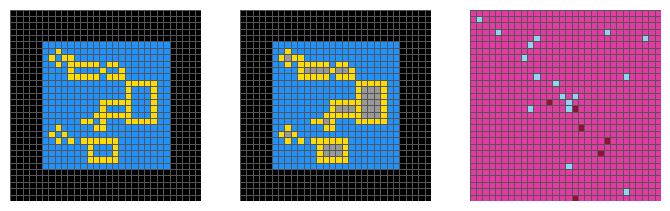

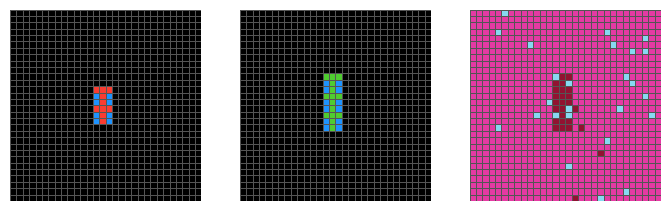

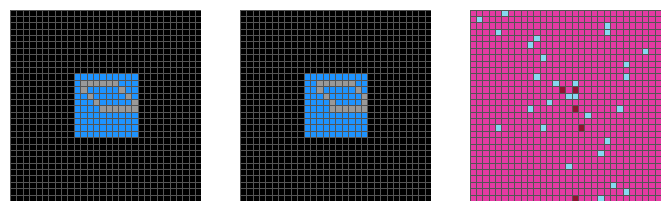

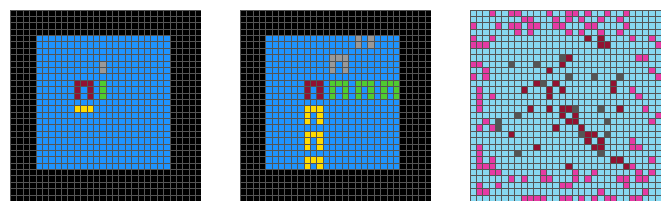

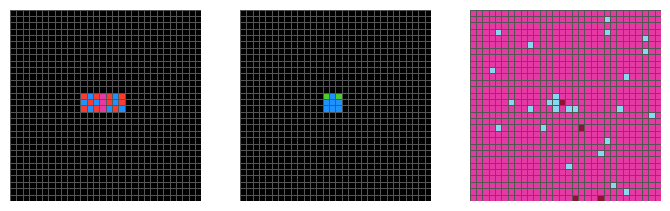

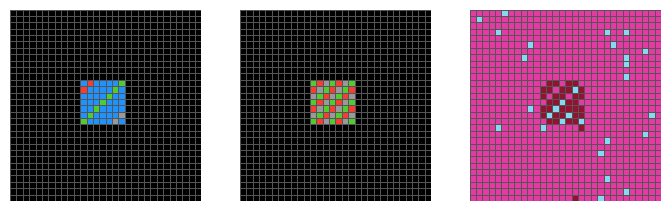

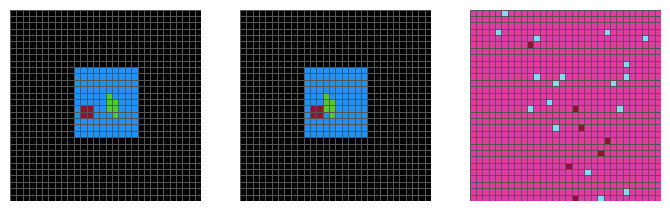

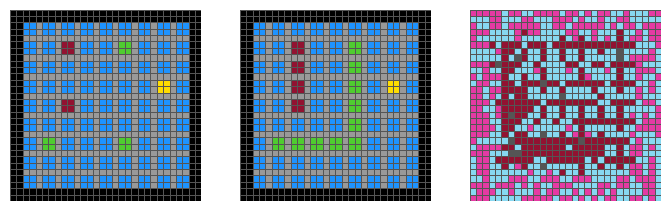

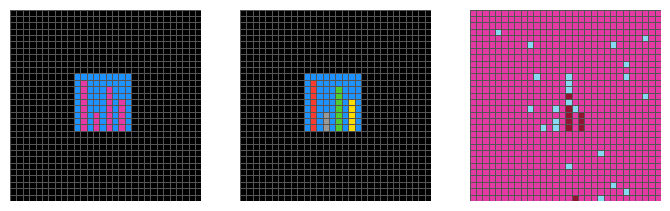

Epoch 18/25, Loss: 5.313616221340803, Accuracy: 0.49054206662902317%
Epoch 19/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.72s/it]


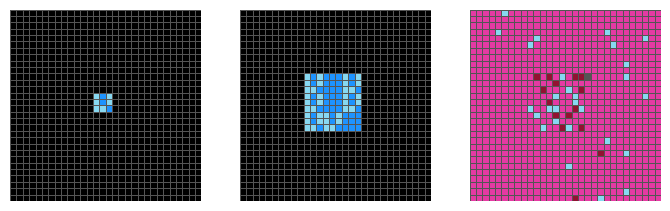

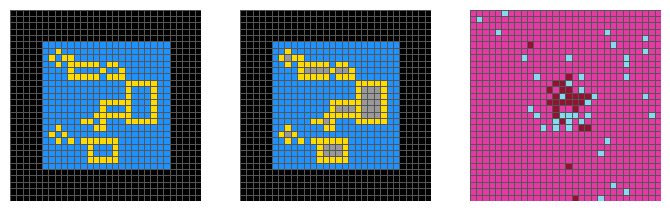

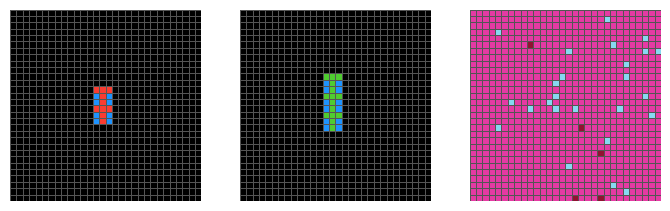

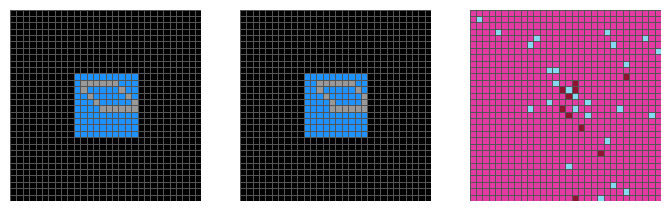

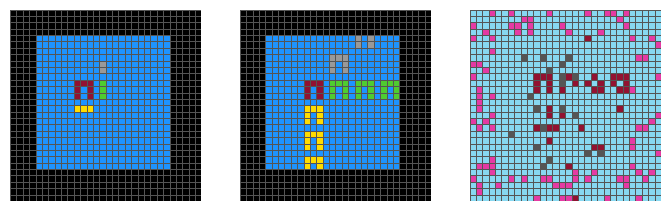

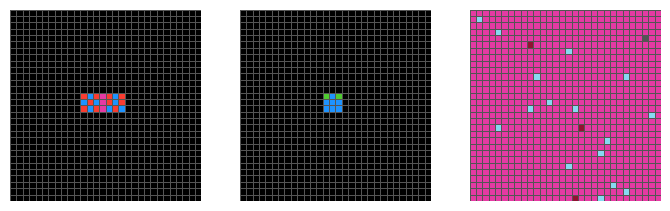

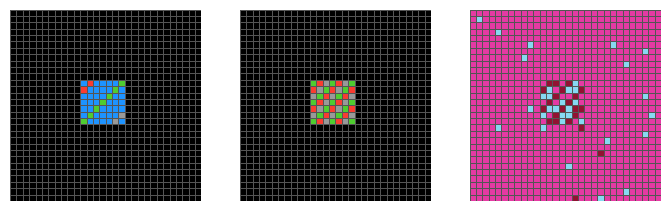

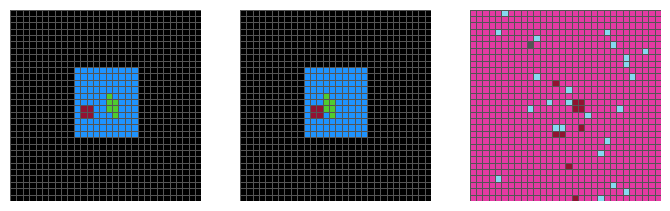

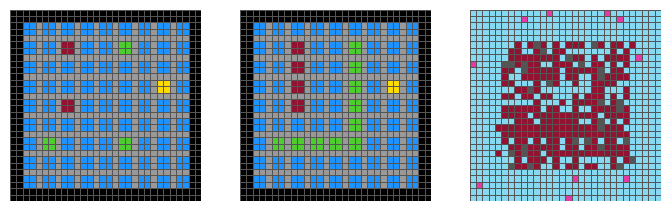

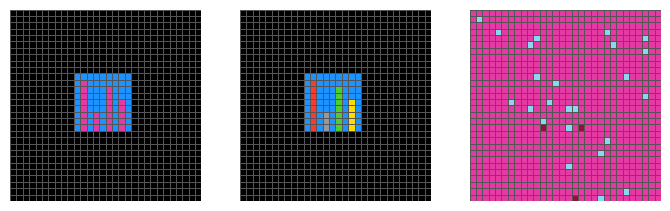

Epoch 19/25, Loss: 5.331124507463896, Accuracy: 0.40055053642010163%
Epoch 20/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.73s/it]


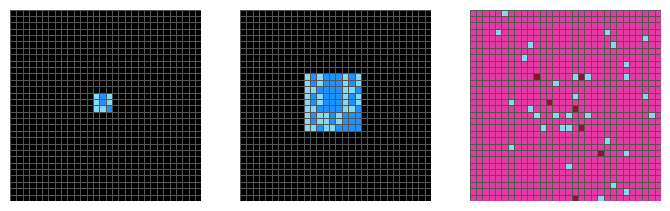

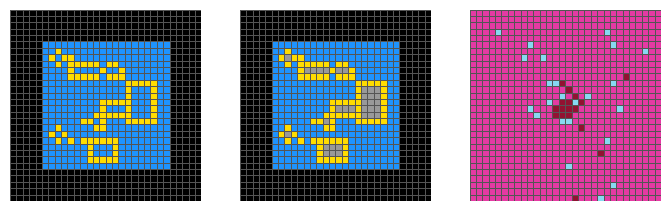

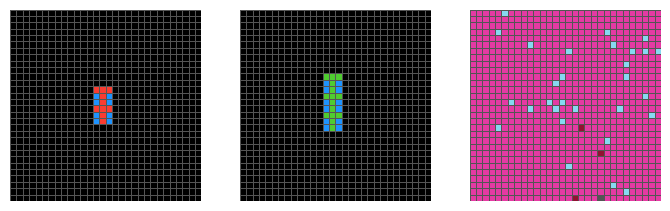

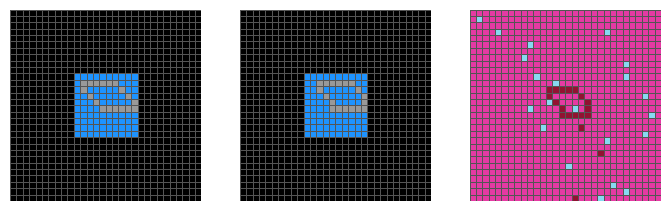

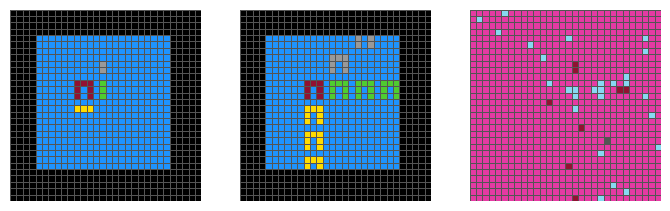

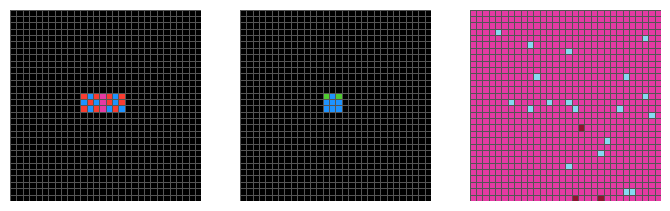

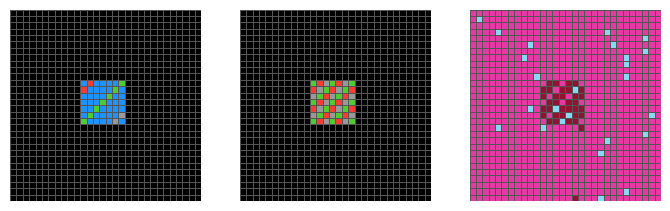

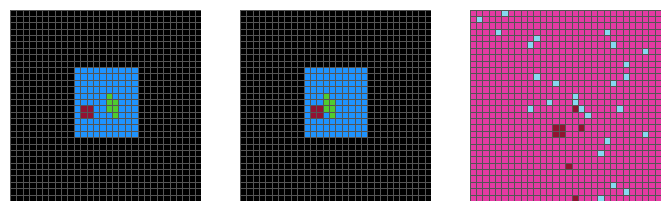

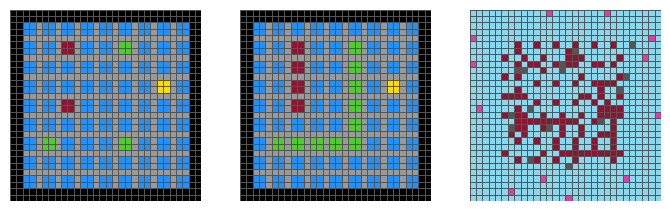

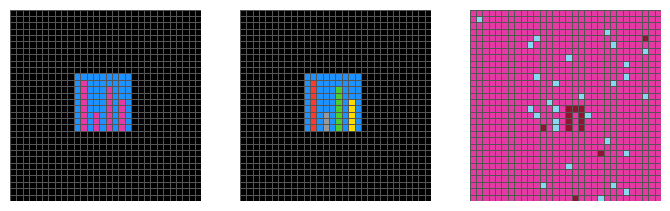

Epoch 20/25, Loss: 5.421313764957281, Accuracy: 0.718167701863354%
Epoch 21/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.74s/it]


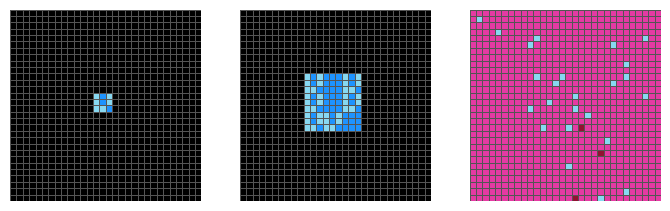

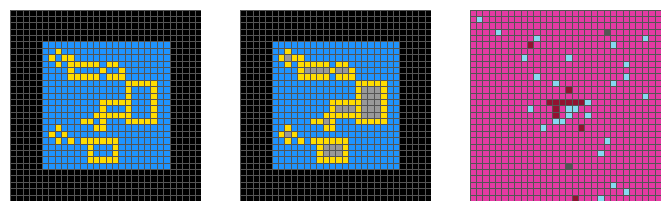

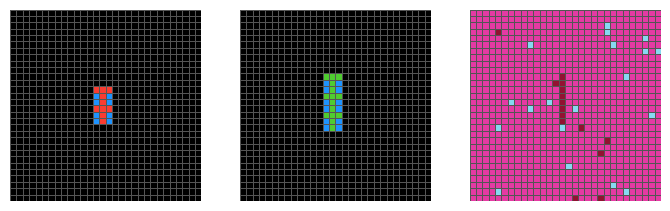

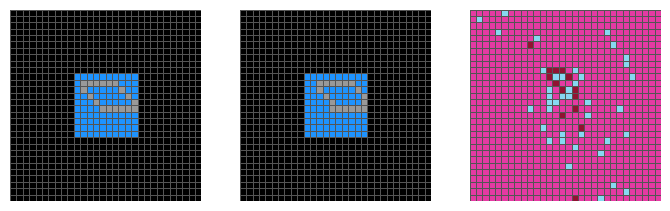

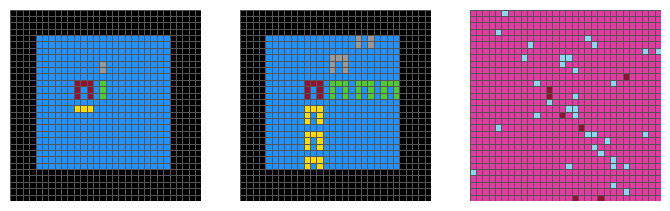

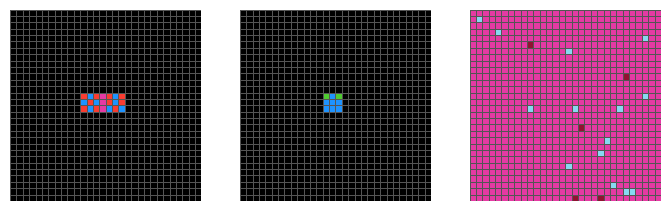

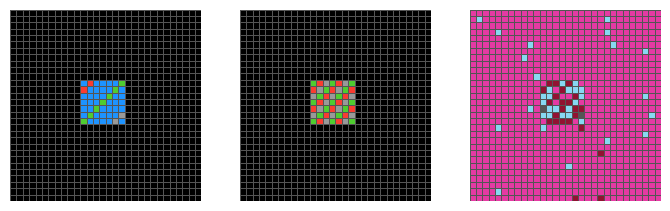

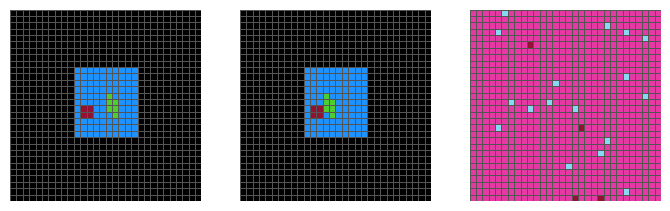

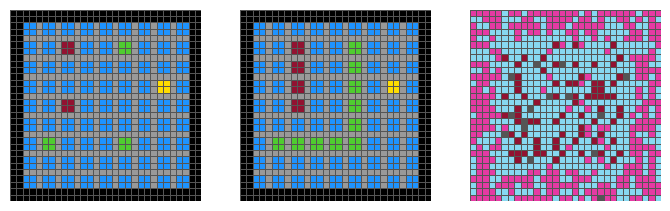

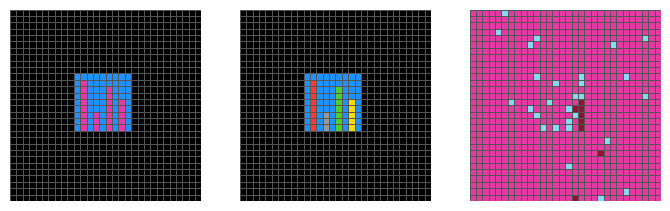

Epoch 21/25, Loss: 5.363665195611807, Accuracy: 0.2770327498588368%
Epoch 22/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.74s/it]


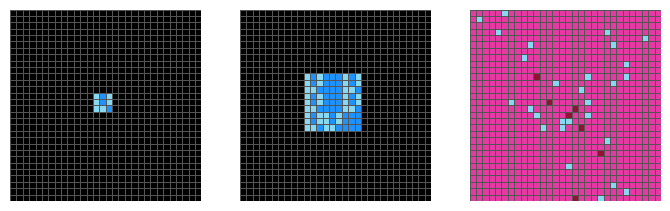

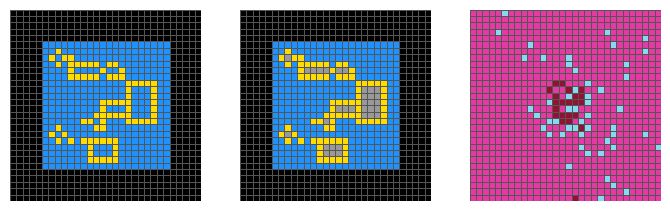

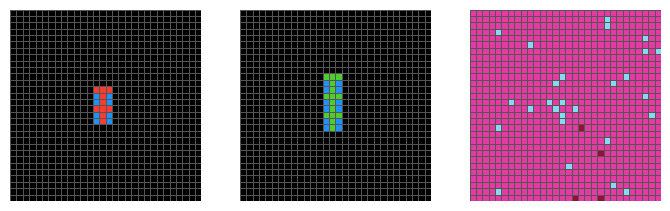

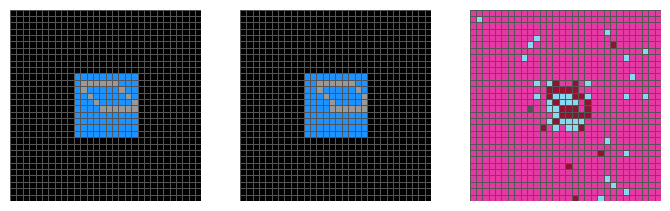

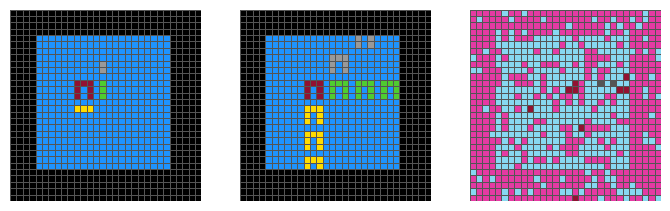

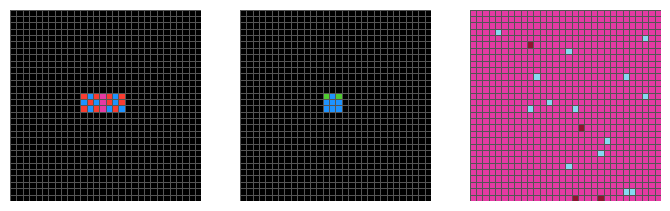

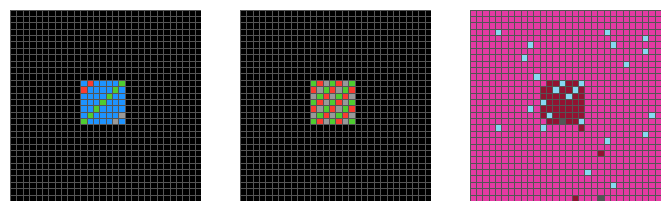

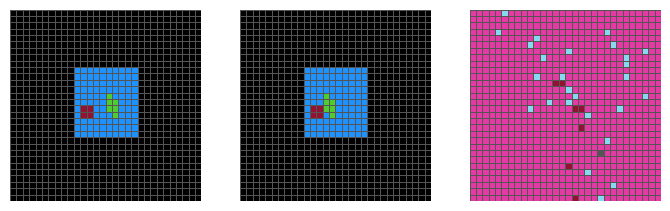

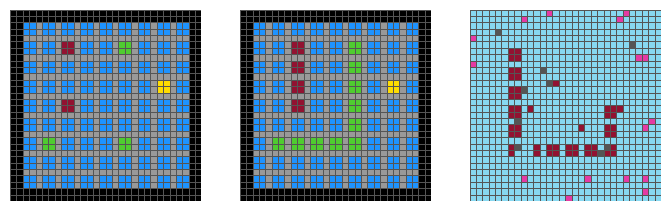

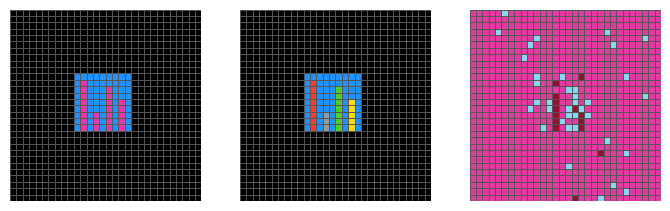

Epoch 22/25, Loss: 5.34214255385674, Accuracy: 0.7781620553359684%
Epoch 23/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.74s/it]


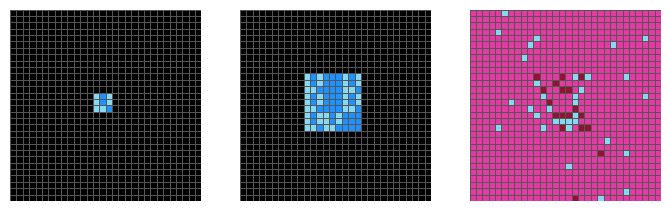

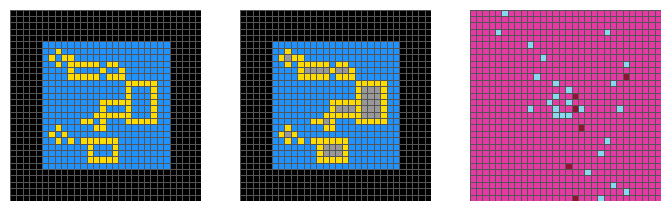

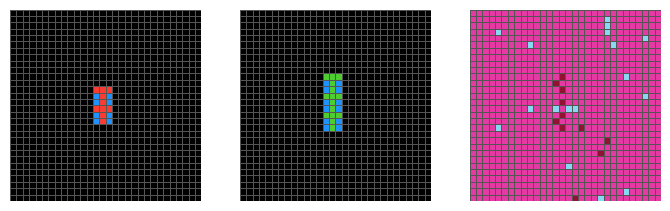

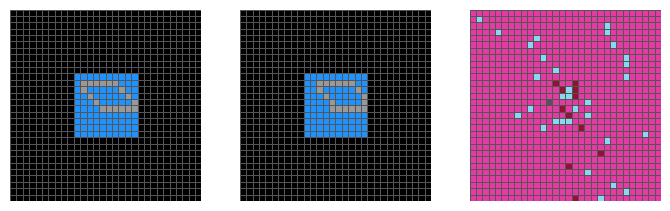

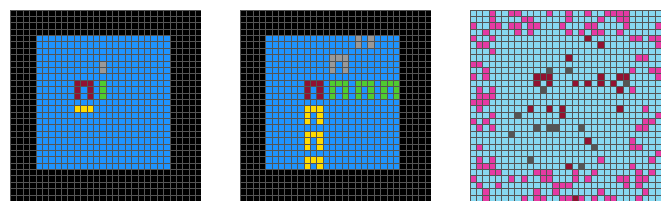

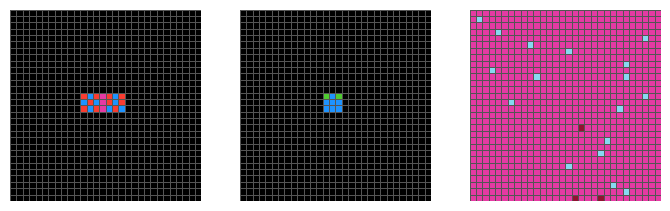

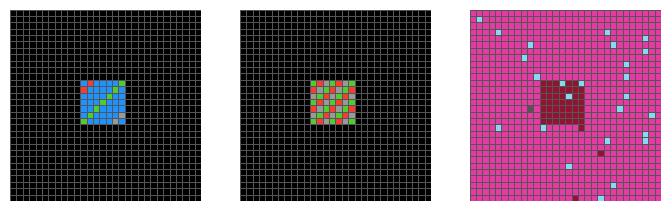

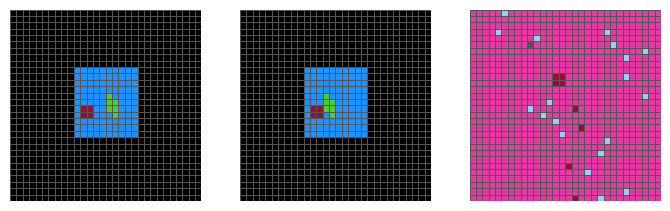

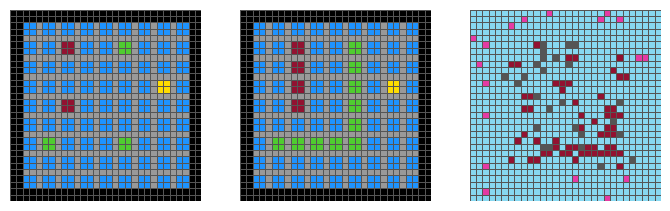

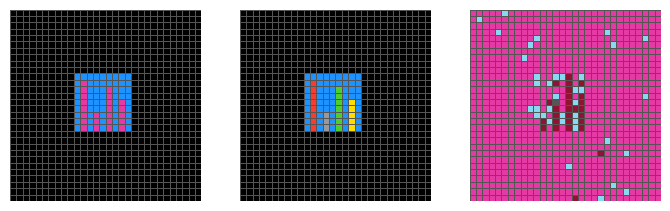

Epoch 23/25, Loss: 5.319653362035751, Accuracy: 0.35467250141163187%
Epoch 24/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.76s/it]


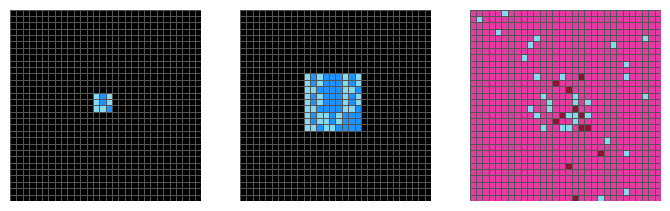

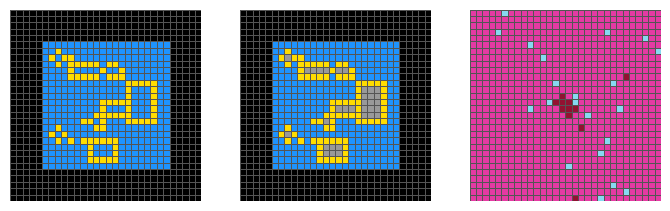

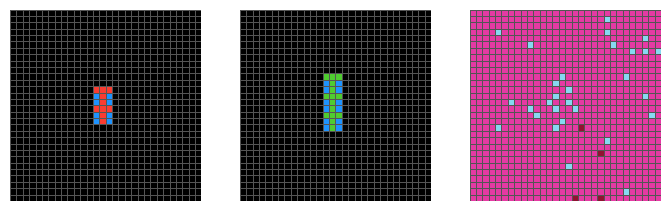

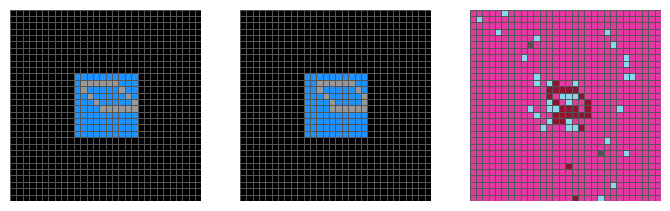

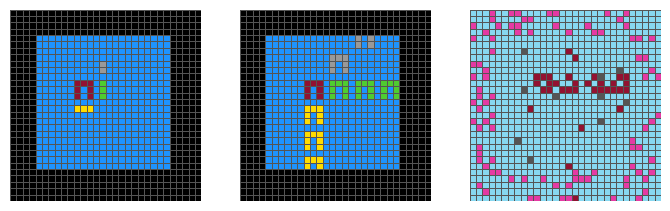

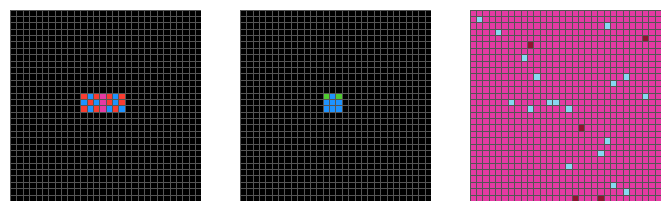

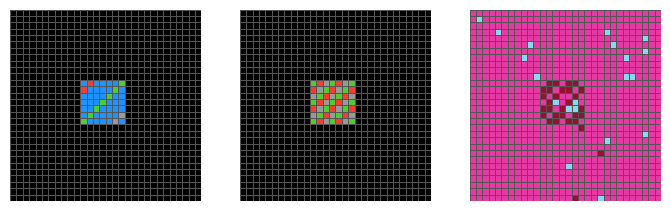

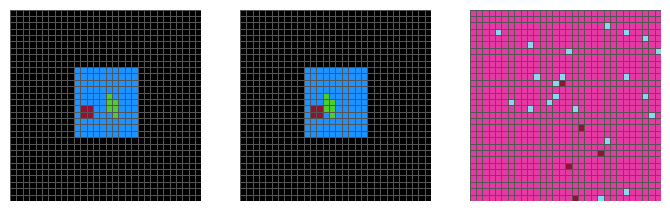

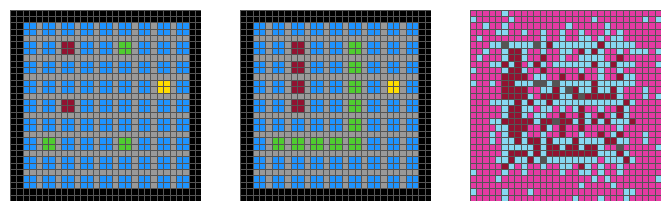

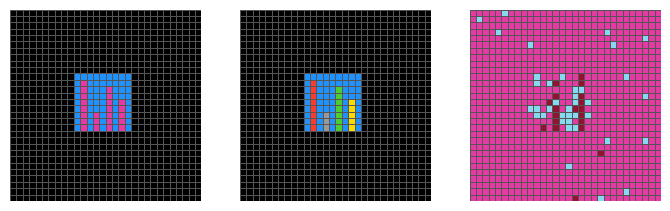

Epoch 24/25, Loss: 5.347552723609484, Accuracy: 0.5187747035573123%
Epoch 25/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.76s/it]


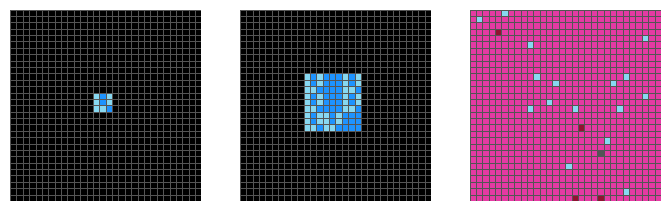

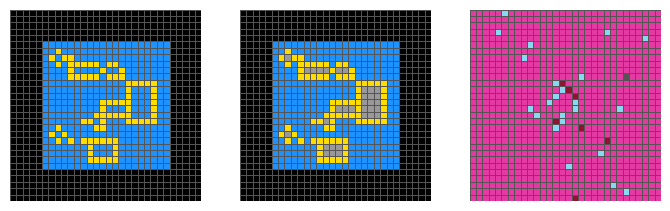

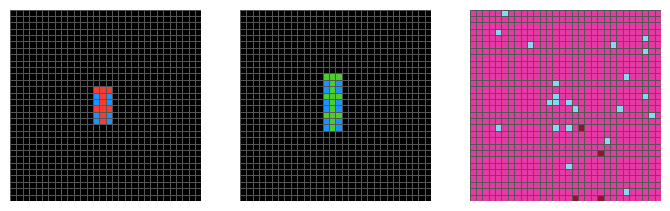

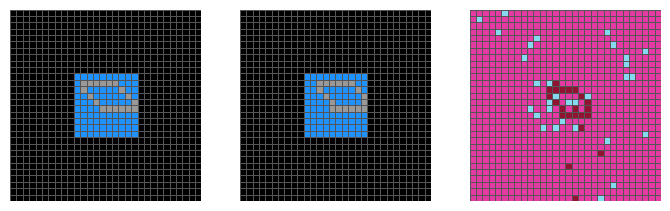

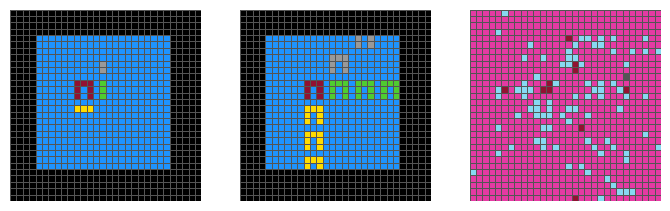

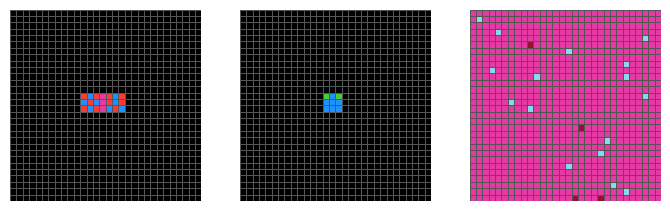

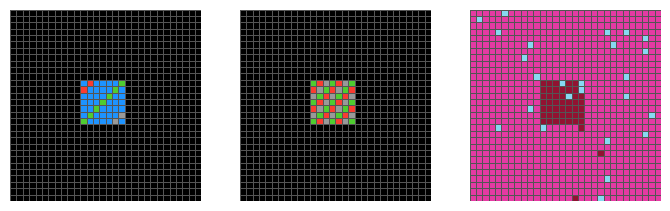

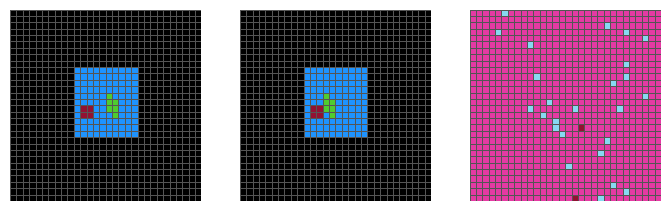

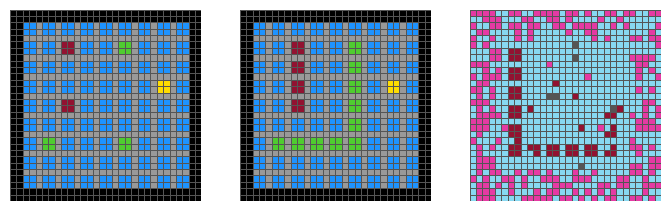

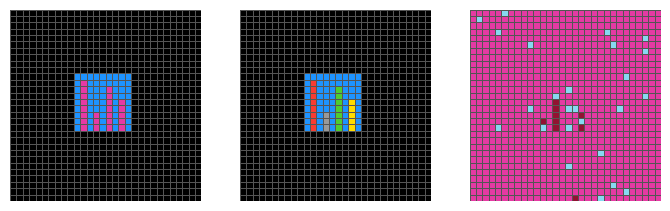

Epoch 25/25, Loss: 5.336683864776905, Accuracy: 0.31938170525127046%


In [1]:
from bw_net_maml import BWNet_MAML
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import gc
import random

def remapping_output(tensor):
    # 범위별 매핑 딕셔너리
    remapping = {
        (1, 10): -1,
        (11, 20): -2,
        (21, 30): -3,
        (31, 40): -4,
        (41, 50): -5,
        (51, 60): -6,
        (61, 70): -7,
        (71, 80): -8,
        (81, 90): -9,
        (91, 100): -10
    }
    
    temp_tensor = tensor.clone()

    # 각 범위에 대해 매핑 수행
    for value_range, new_value in remapping.items():
        mask = (temp_tensor >= value_range[0]) & (temp_tensor <= value_range[1])
        temp_tensor[mask] = new_value  # 임시로 기존 값에 음수를 취해 중복을 피함
    for value_range, new_value in remapping.items():
        temp_tensor[temp_tensor == new_value] = -1*new_value  # 음수로 변환된 값을 다시 양수로 변환

    return temp_tensor


colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

def inner_loop_update(model, example_input, example_output, inner_optimizer, criterion, steps):
    for _ in range(steps):
        model.train()
        prediction = model(example_input)
        loss = criterion(prediction, example_output)

        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()


def criterion(y_pred, y):
    y = y.long().squeeze(1)
    ce = F.cross_entropy(y_pred, y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 25,
    'task_numbers': 20, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 3, #equal to inner model batch size
    'inner_lr': 0.001,
    'outer_lr': 0.001,
    'embed_size': 1,
    
}

# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device  
print(f'Using {device} device')


train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

outer_model = BWNet_MAML(embed_size=kwargs['embed_size']).to(device)
outer_optimizer= optim.AdamW(outer_model.parameters(),lr=kwargs['outer_lr'])

for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    total_loss = 0
    # total_samples = 0
    outer_model.train()

    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]
        
        # total_samples += input_tensor.shape[0]
        task_losses = []
        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_optimizer = optim.AdamW(inner_model.parameters(),lr=kwargs['inner_lr'])
            
            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                              inner_optimizer, criterion, kwargs['example_data_num'])
            
        
            inner_model.eval()
            task_prediction = inner_model(input_tensor[task_number])
            task_loss = criterion(task_prediction, output_tensor[task_number])
            task_losses.append(task_loss)
        
        meta_loss = torch.stack(task_losses).mean()
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()
        
        del meta_loss, task_losses
        gc.collect()
        torch.cuda.empty_cache()
        

    del inner_optimizer
    torch.cuda.empty_cache()
    gc.collect()
    
    # Validation Loop
    outer_model.eval()
    validation_correct = 0
    validation_total_samples = 0
    total_loss = []
    visualization_samples = []
    for batch_idx, data in enumerate(tqdm(eval_loader, desc='Validation')):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_model.train()
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])

            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                            inner_optimizer, criterion, kwargs['example_data_num'])

            with torch.no_grad():
                inner_model.eval()
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                task_prediction = inner_model(task_input)
                task_loss = criterion(task_prediction, task_output)
                total_loss.append(task_loss.item())  # task_loss.item()을 리스트에 추가

                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)

                mask = task_output != 0
                correct_predictions = (prediction_class == task_output) & mask
                validation_correct += correct_predictions.sum().item()
                validation_total_samples += mask.sum().item()
            
            if len(visualization_samples) < 10:  # 예를 들어 10개의 샘플만 저장
                        visualization_samples.append((
                            remapping_output(task_input.cpu()),
                            remapping_output(task_output.cpu()),
                            remapping_output(prediction_class.cpu())
                        ))

            del inner_model, inner_optimizer, task_input, task_output, task_prediction, mask, correct_predictions
            gc.collect()
            torch.cuda.empty_cache()

    if visualization_samples:
        for vis_input, vis_output, vis_prediction in visualization_samples:
            show_grid_side_by_side(vis_input, vis_output, vis_prediction)

            

    # 손실 값들의 평균 계산
    mean_loss = sum(total_loss) / len(total_loss) if total_loss else 0
    accuracy = 100 * validation_correct / validation_total_samples if validation_total_samples > 0 else 0
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {mean_loss}, Accuracy: {accuracy}%')
    torch.cuda.empty_cache()

Using cuda device
Epoch 1/25


Validation: 100%|██████████| 21/21 [01:28<00:00,  4.23s/it]


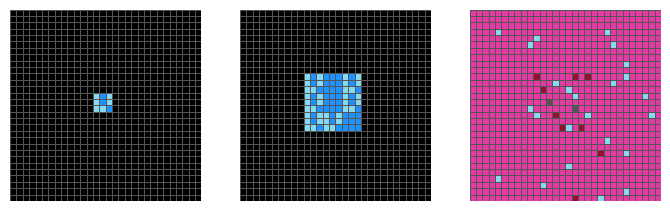

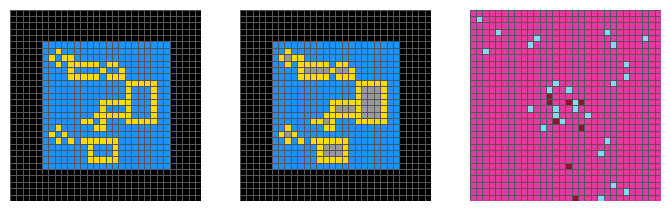

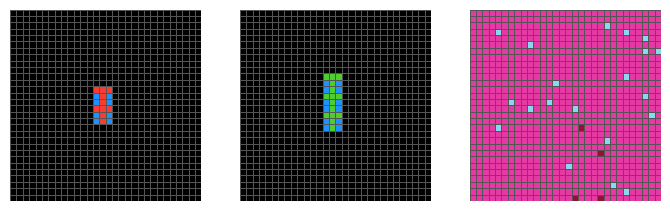

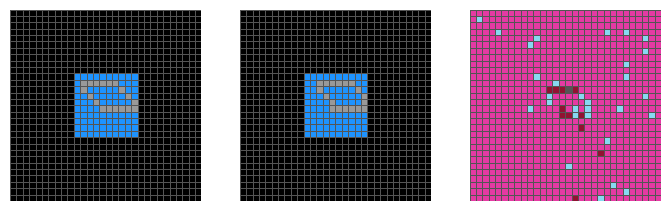

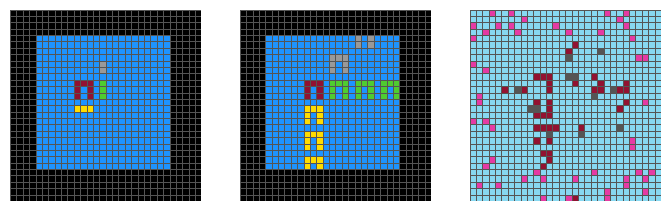

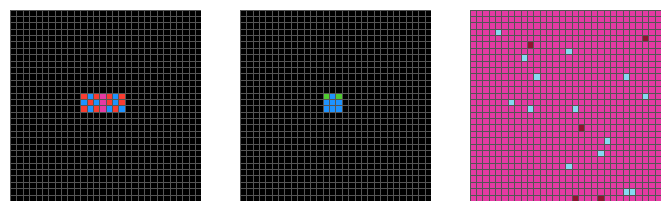

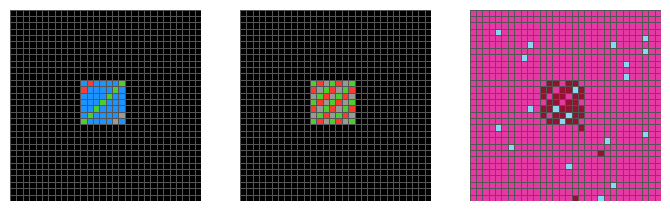

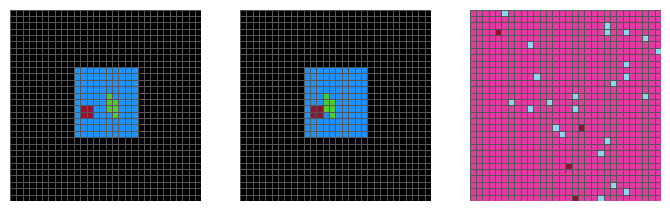

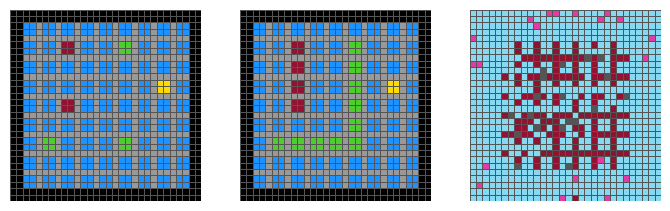

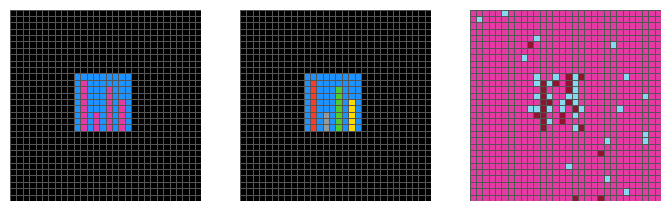

Epoch 1/25, Loss: 5.352161819545122, Accuracy: 0.6175889328063241%
Epoch 2/25


Validation: 100%|██████████| 21/21 [01:28<00:00,  4.22s/it]


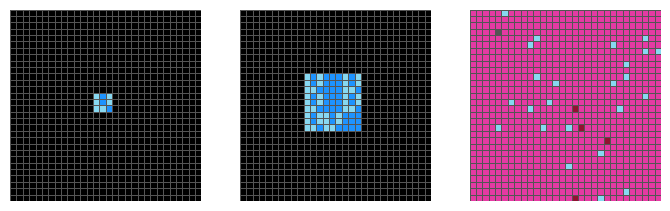

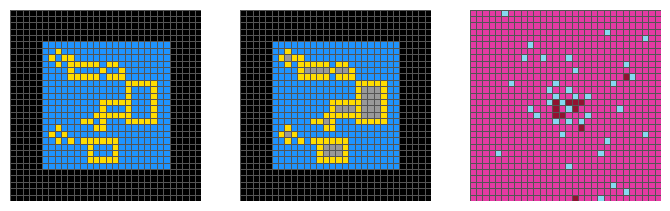

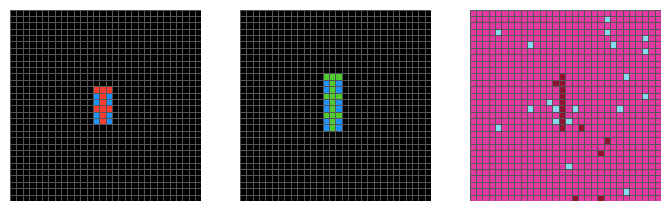

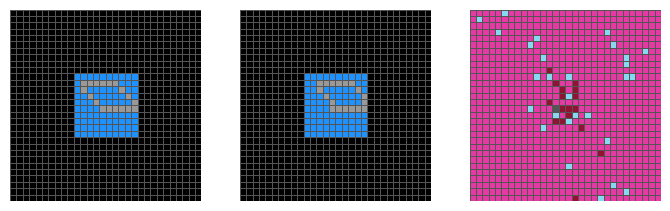

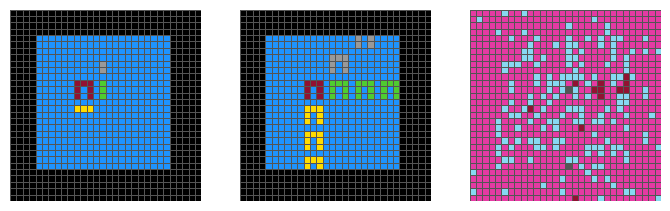

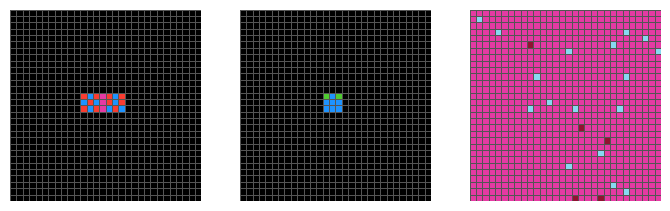

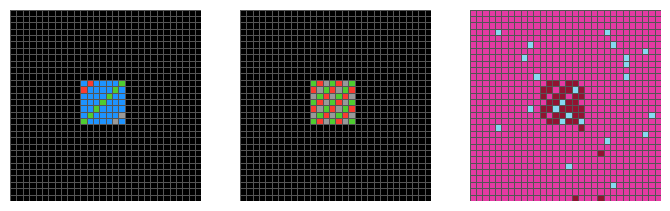

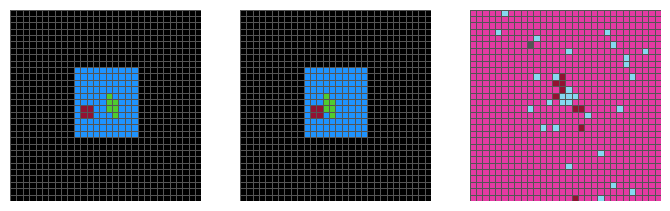

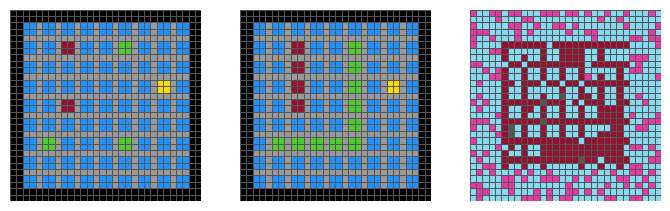

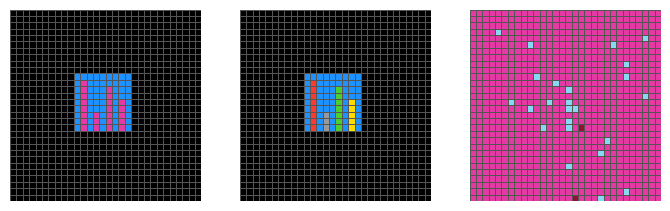

Epoch 2/25, Loss: 5.31638242992071, Accuracy: 0.2717391304347826%
Epoch 3/25


Validation: 100%|██████████| 21/21 [01:28<00:00,  4.23s/it]


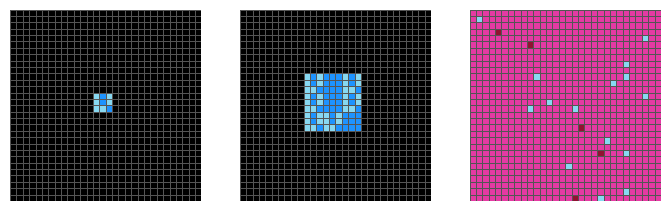

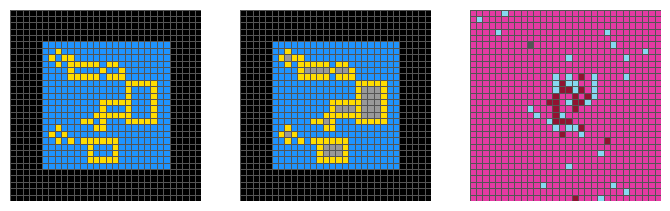

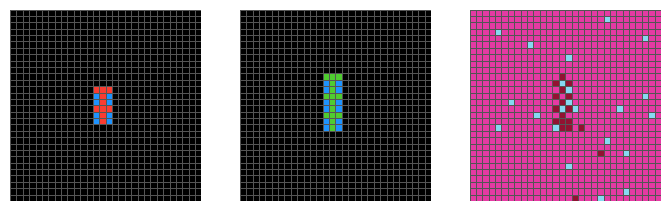

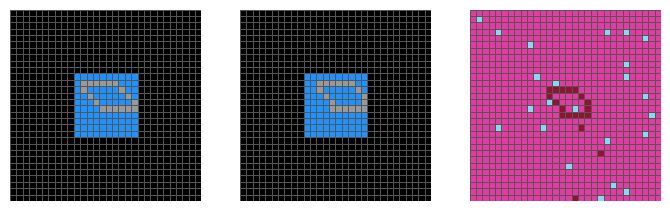

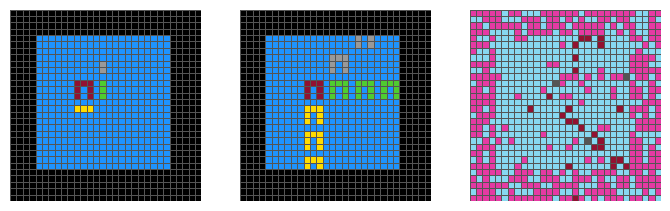

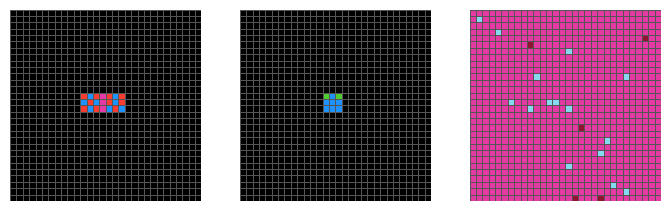

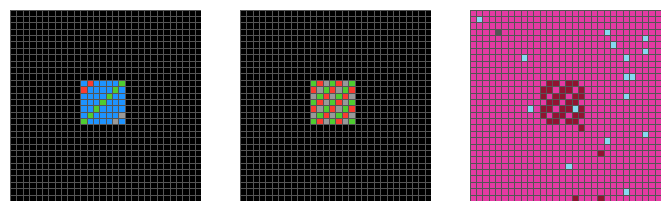

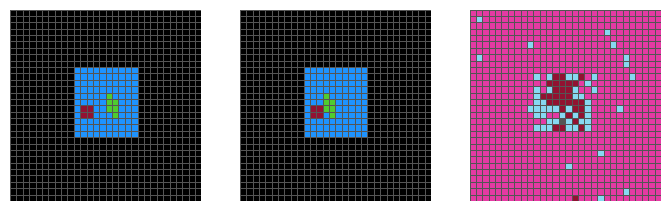

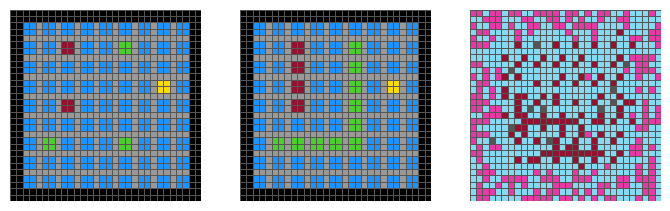

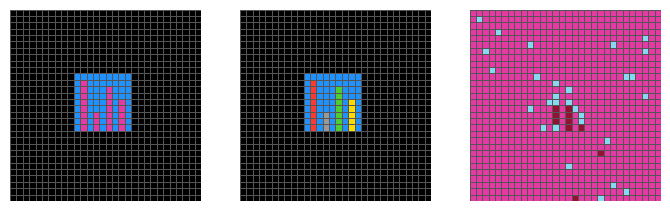

Epoch 3/25, Loss: 5.339211079936761, Accuracy: 0.4252540937323546%
Epoch 4/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.85s/it]


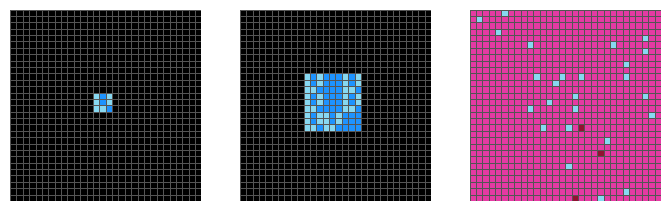

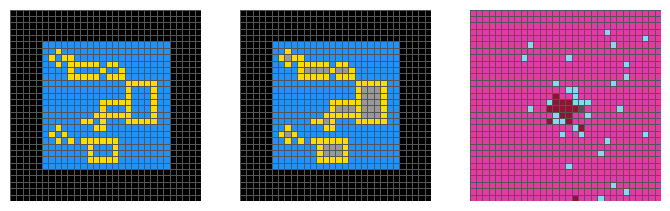

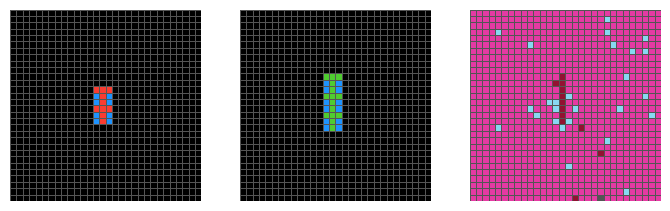

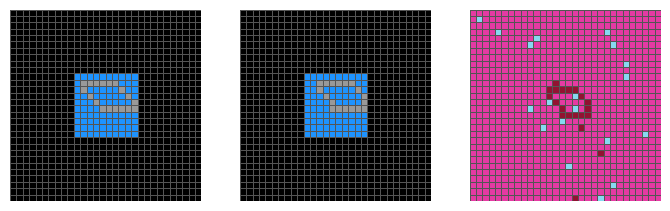

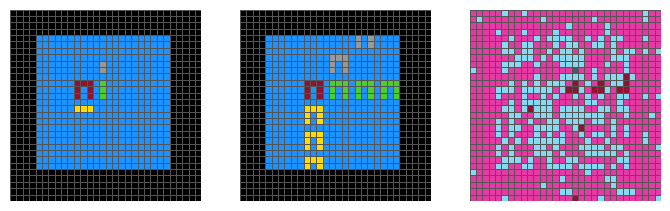

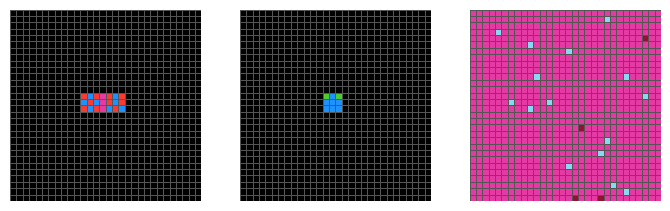

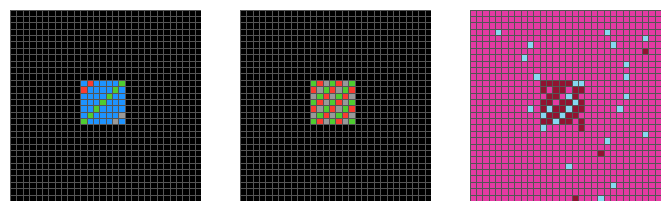

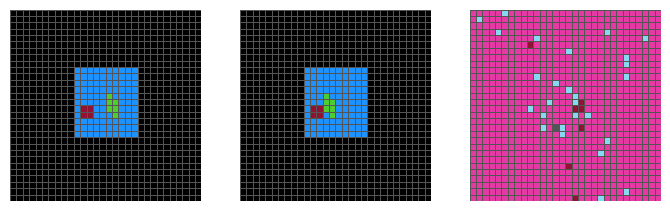

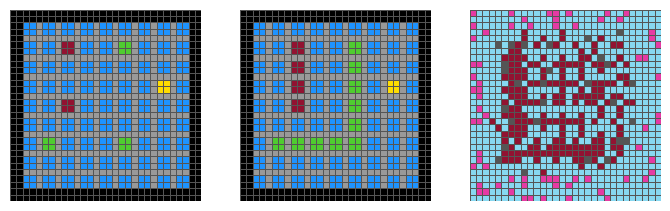

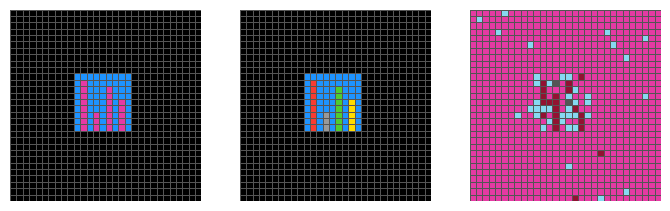

Epoch 4/25, Loss: 5.343926784510796, Accuracy: 0.8011010728402033%
Epoch 5/25


Validation: 100%|██████████| 21/21 [01:42<00:00,  4.87s/it]


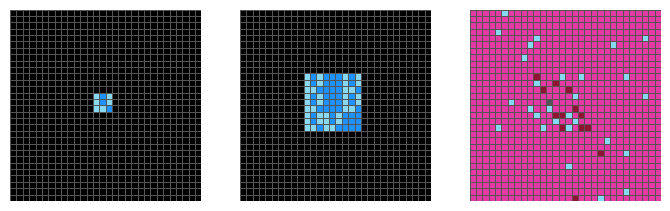

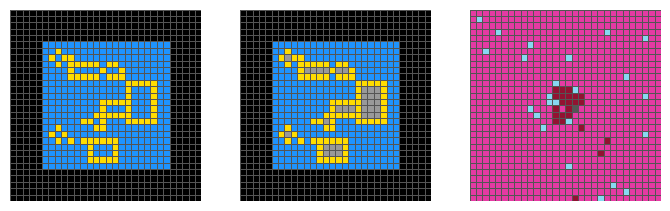

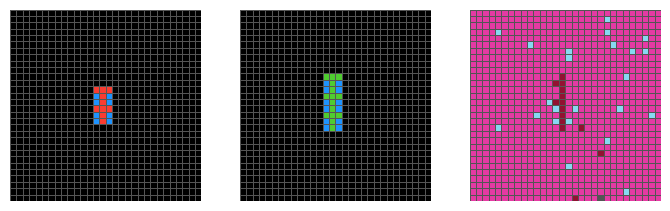

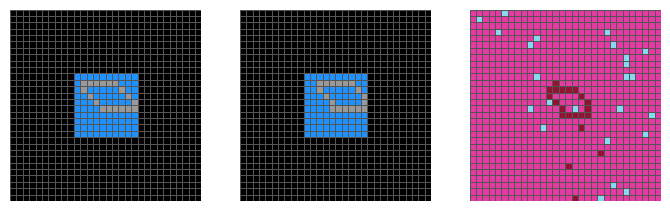

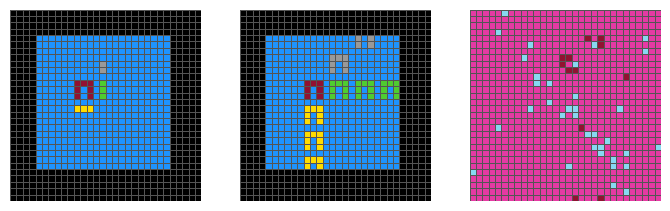

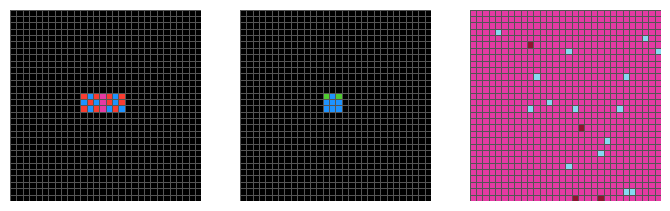

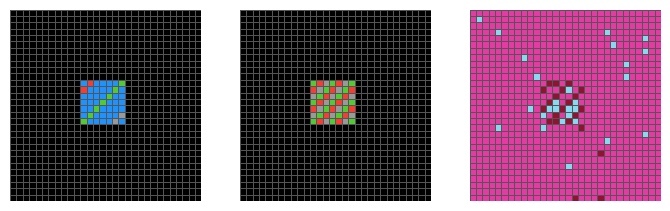

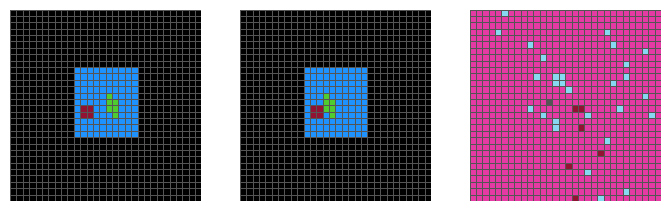

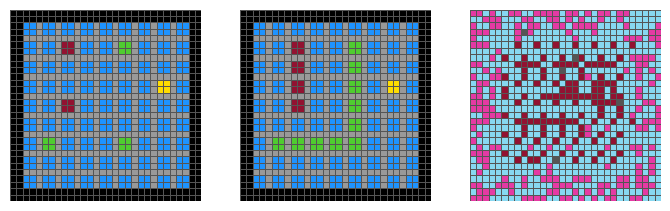

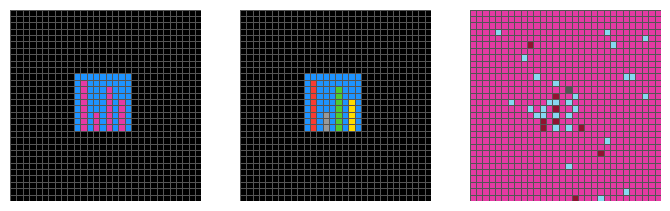

Epoch 5/25, Loss: 5.324831202053106, Accuracy: 0.5999435347261434%
Epoch 6/25


Validation: 100%|██████████| 21/21 [01:40<00:00,  4.80s/it]


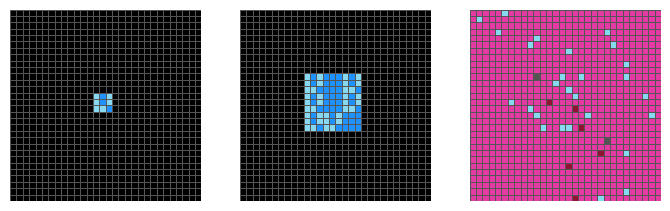

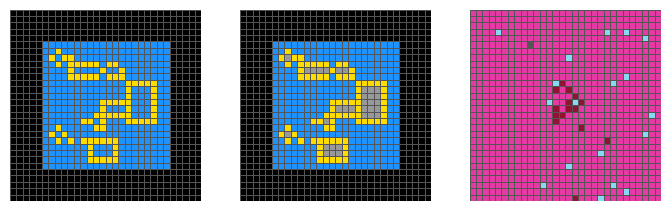

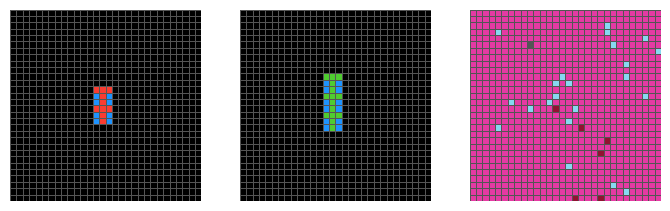

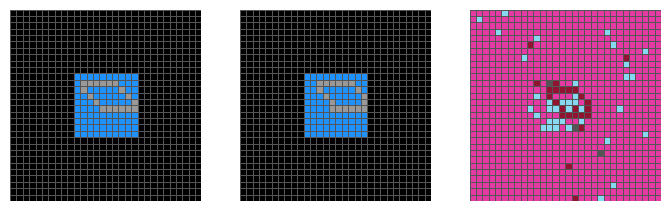

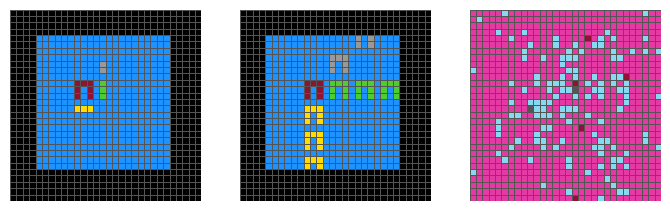

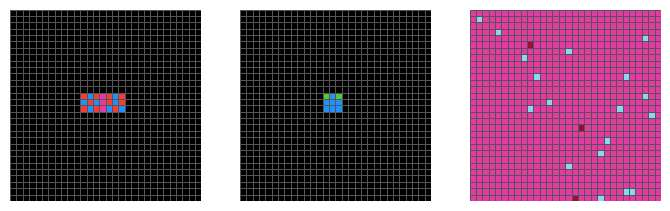

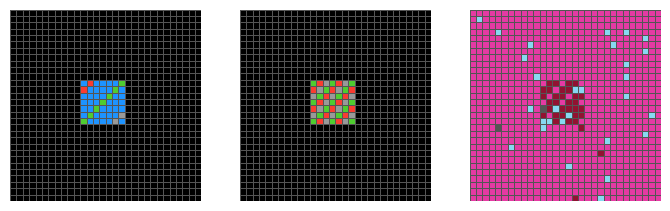

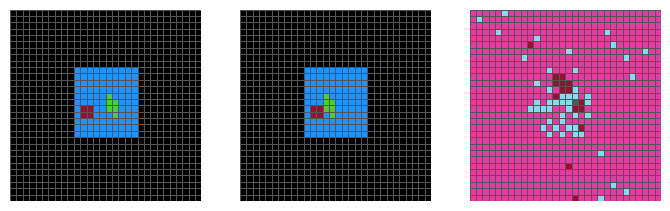

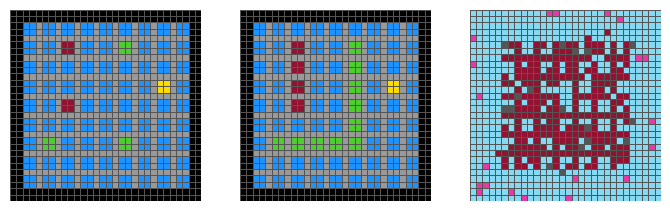

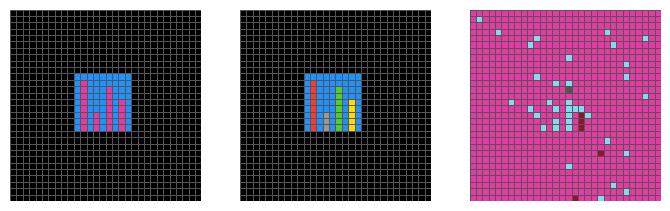

Epoch 6/25, Loss: 5.355043055346379, Accuracy: 0.5875917560700169%
Epoch 7/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.82s/it]


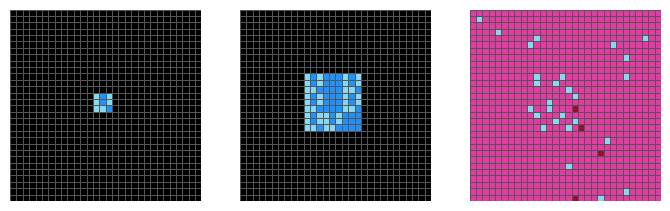

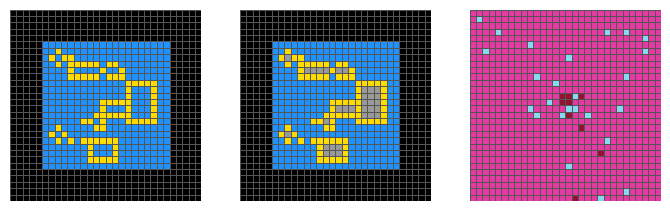

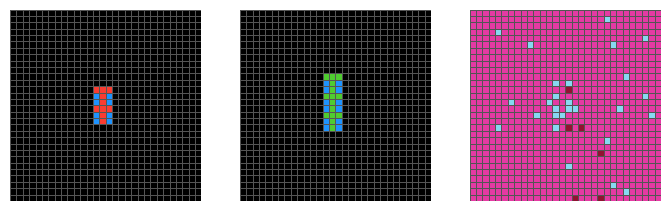

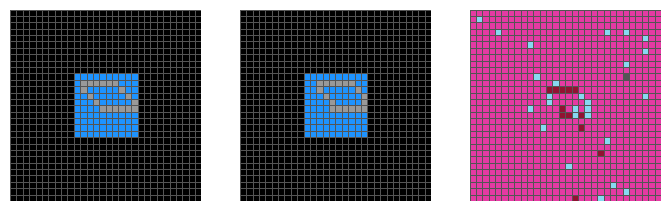

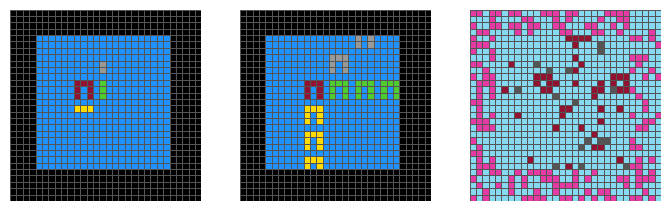

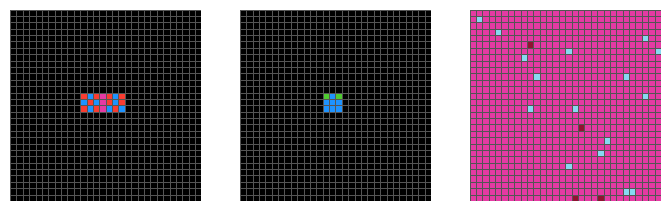

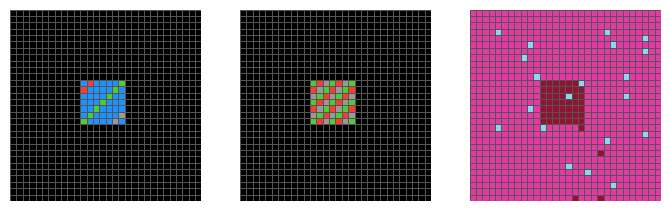

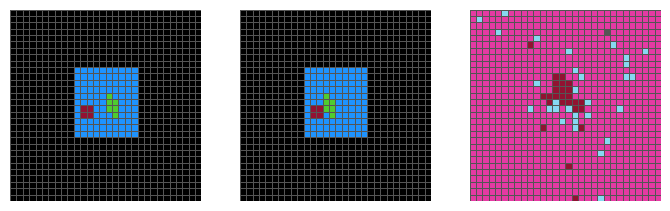

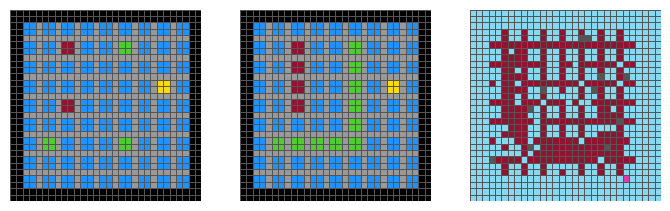

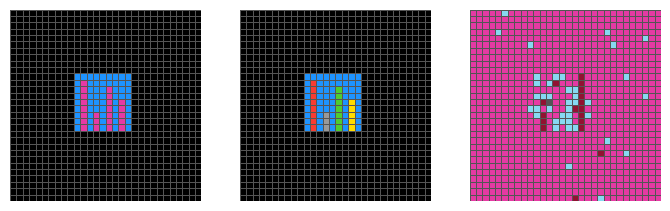

Epoch 7/25, Loss: 5.298064473729867, Accuracy: 0.7763975155279503%
Epoch 8/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.81s/it]


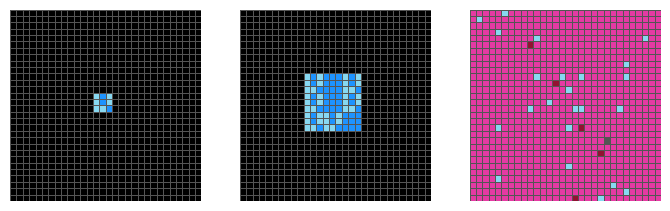

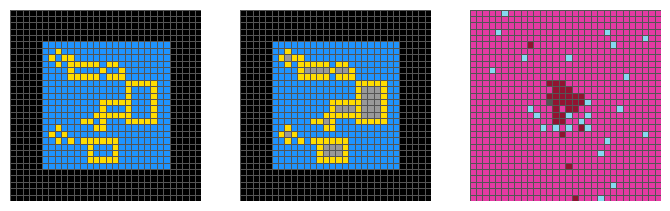

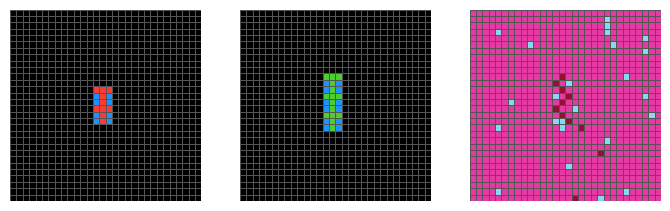

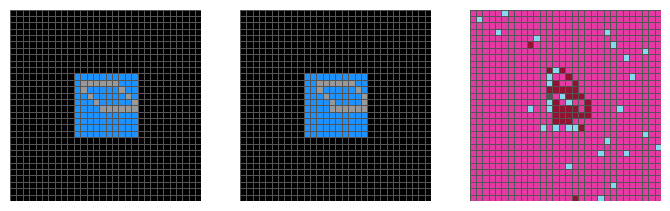

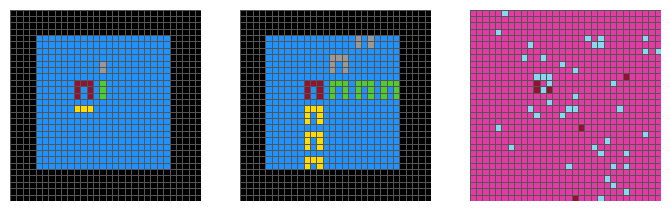

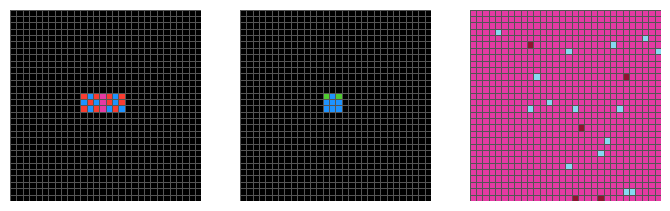

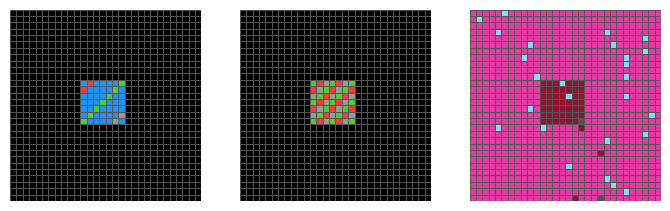

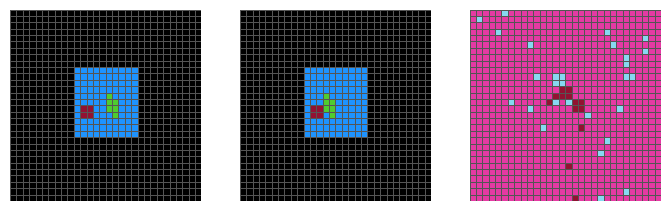

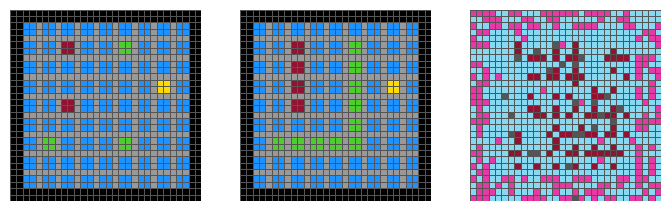

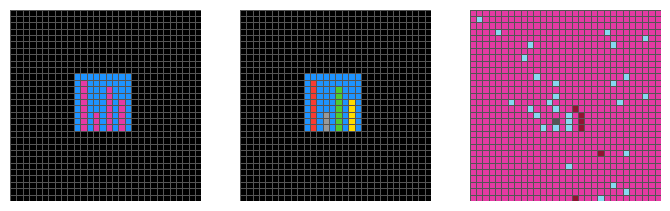

Epoch 8/25, Loss: 5.325261400296138, Accuracy: 0.3017363071710898%
Epoch 9/25


Validation: 100%|██████████| 21/21 [01:40<00:00,  4.79s/it]


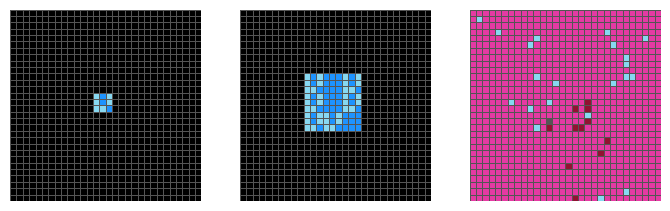

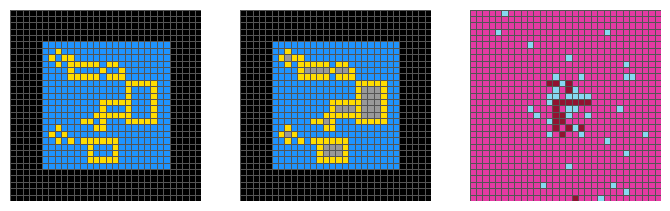

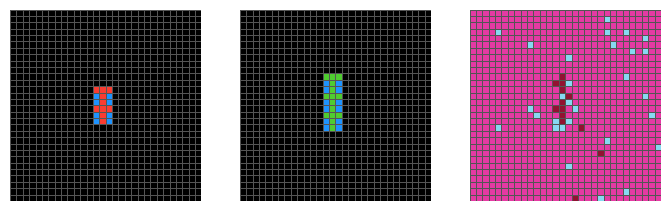

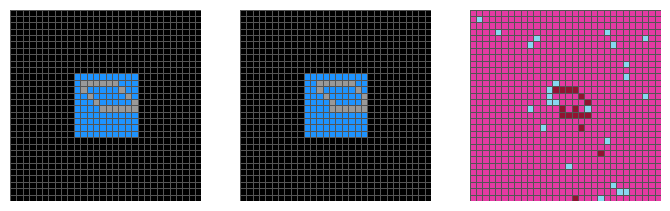

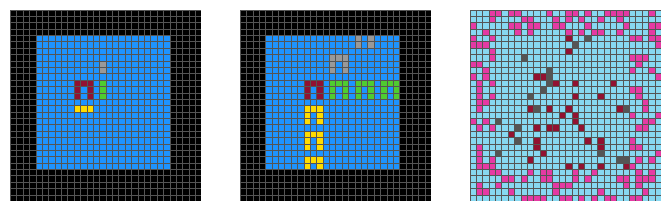

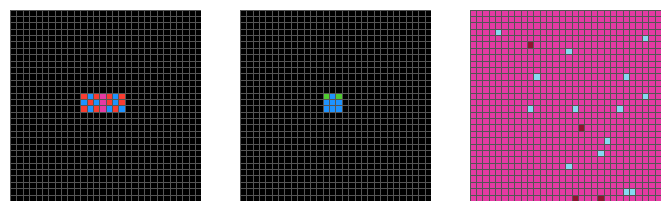

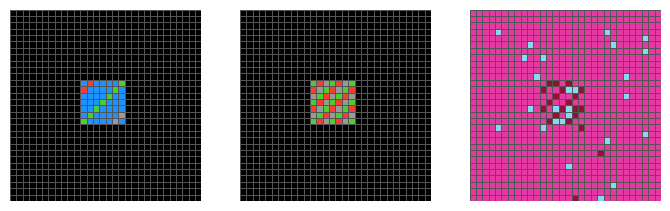

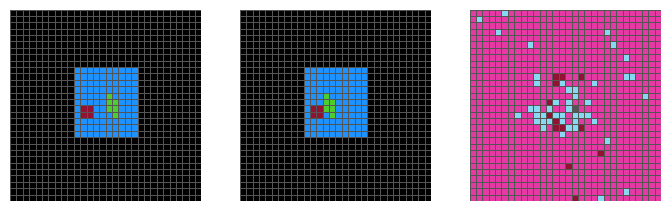

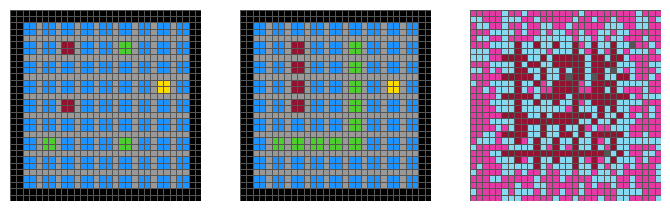

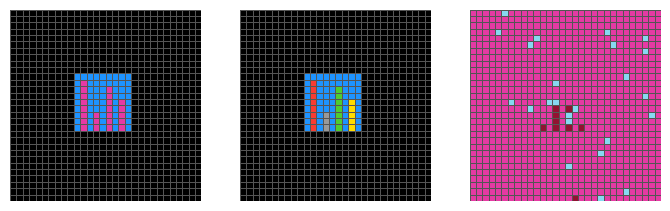

Epoch 9/25, Loss: 5.317990912840917, Accuracy: 0.3652597402597403%
Epoch 10/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.83s/it]


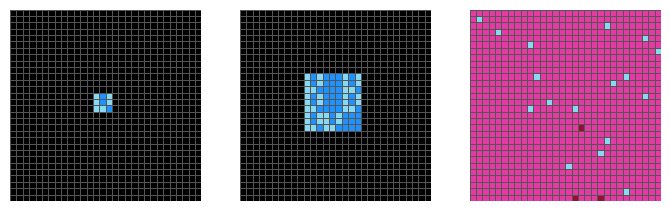

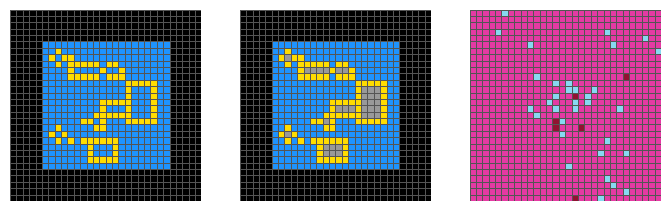

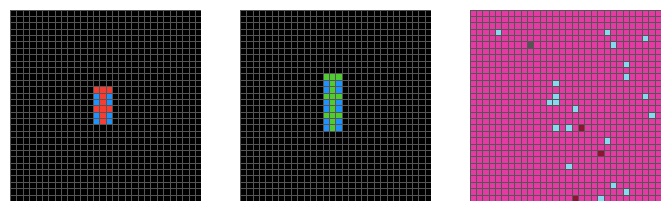

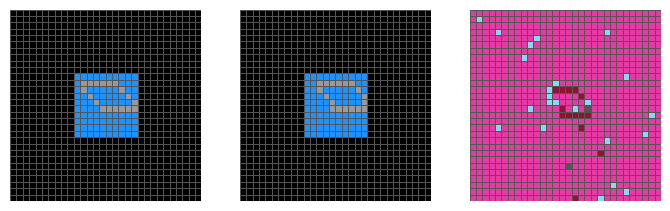

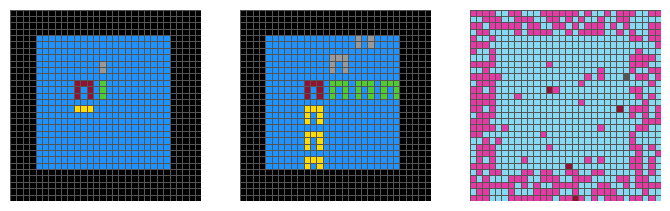

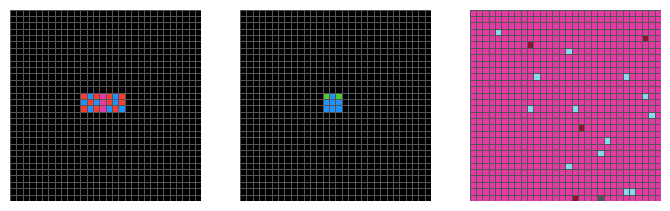

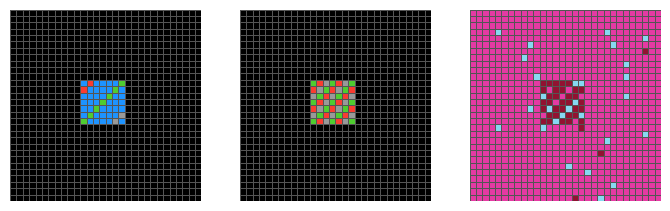

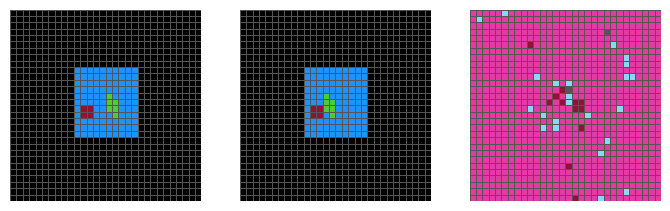

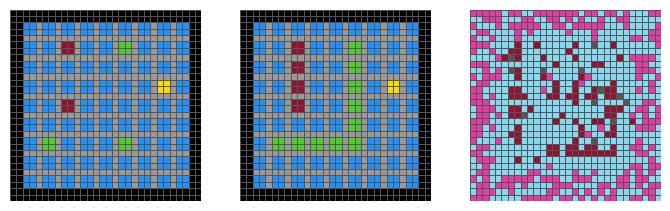

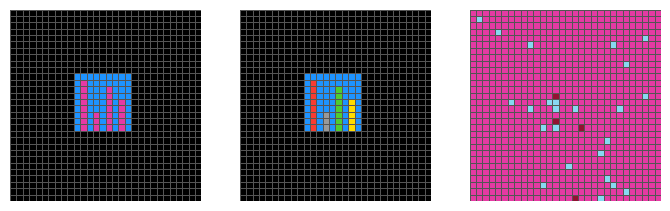

Epoch 10/25, Loss: 5.373066700421846, Accuracy: 0.5752399774138904%
Epoch 11/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.82s/it]


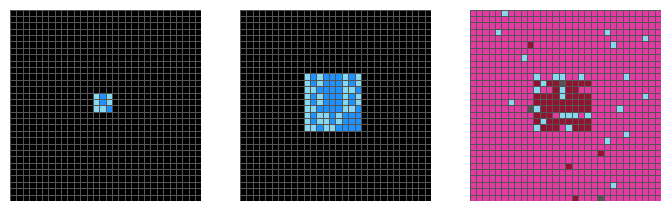

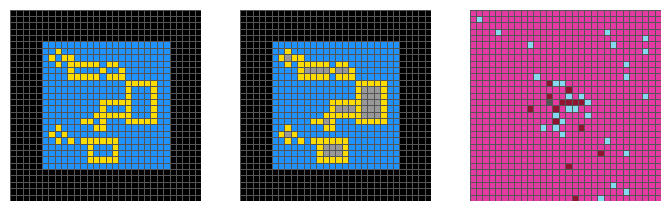

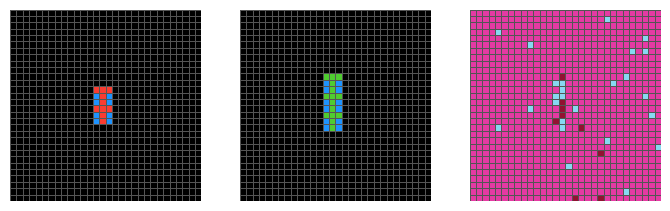

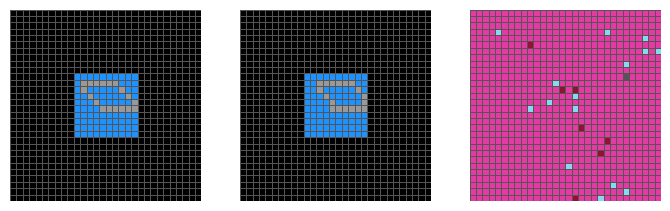

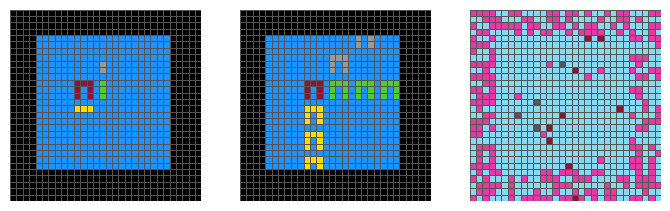

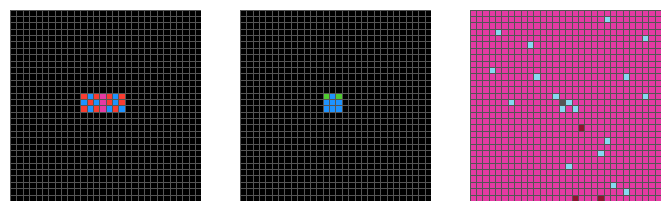

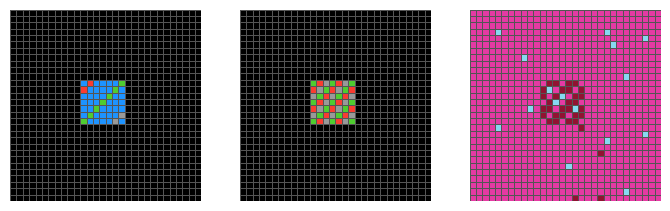

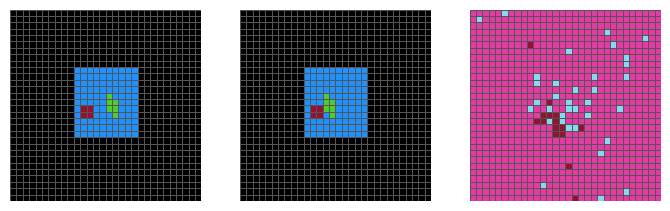

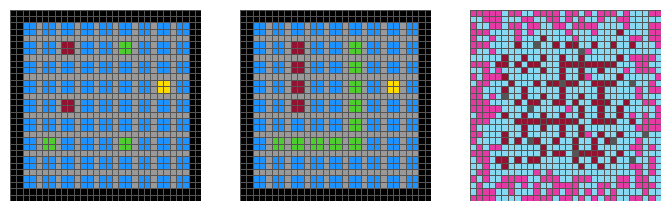

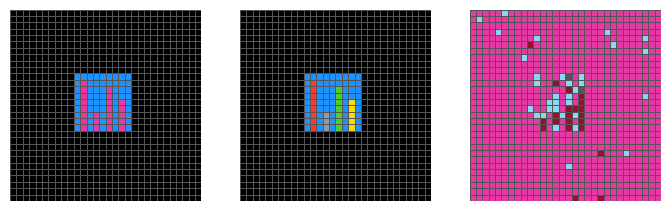

Epoch 11/25, Loss: 5.419208441216212, Accuracy: 0.44466403162055335%
Epoch 12/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.84s/it]


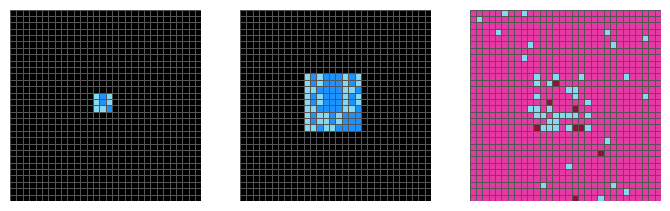

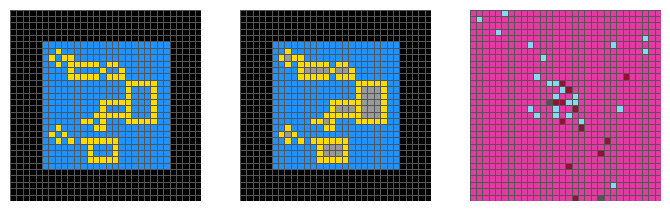

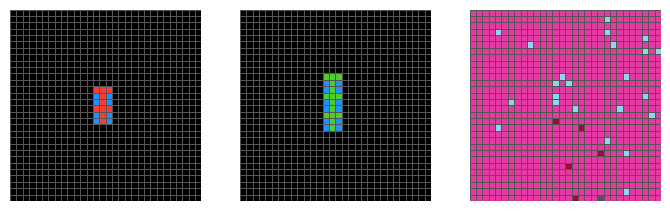

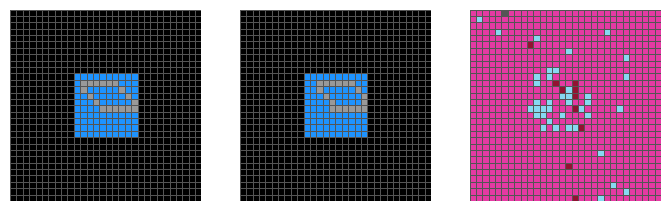

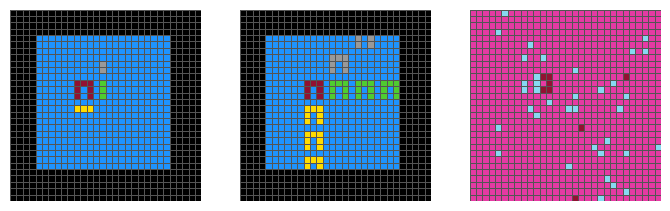

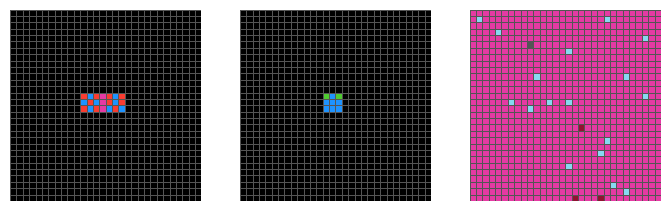

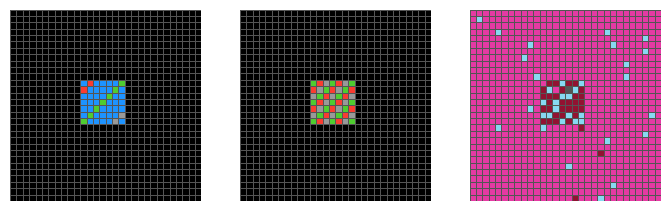

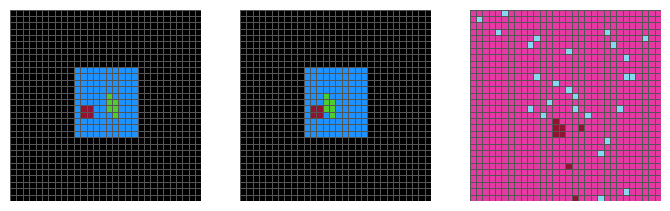

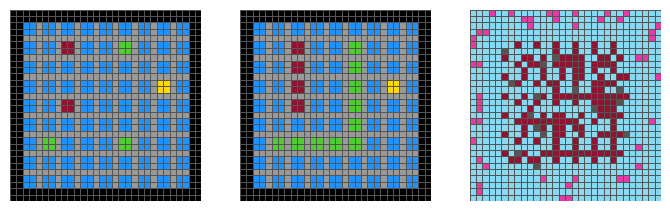

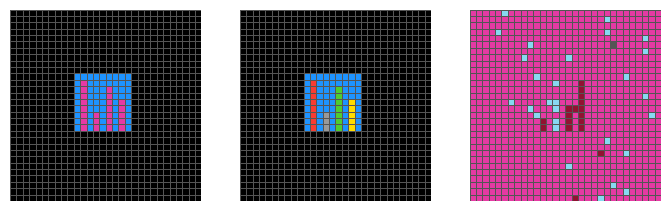

Epoch 12/25, Loss: 5.370381832122803, Accuracy: 0.3652597402597403%
Epoch 13/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.84s/it]


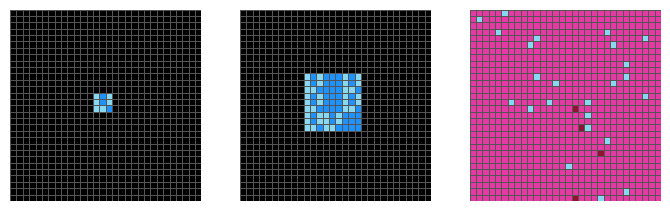

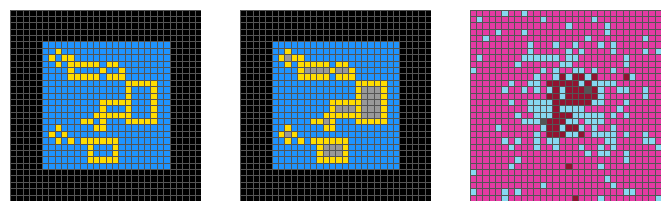

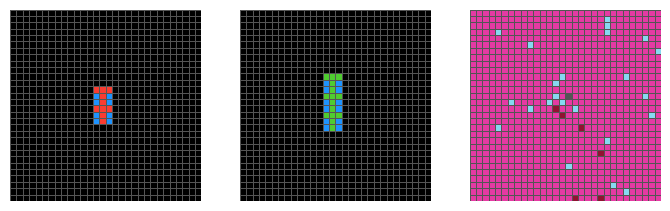

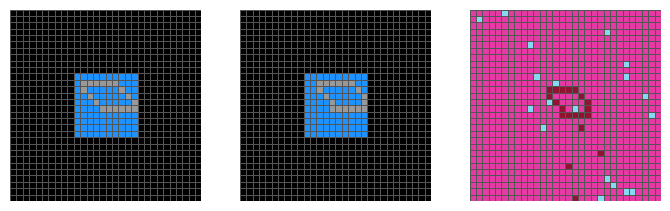

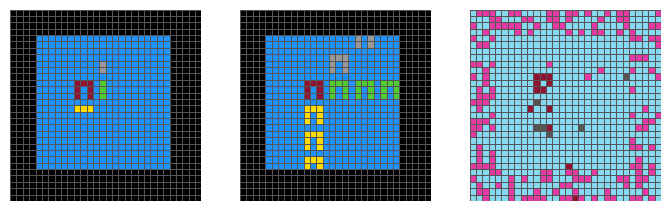

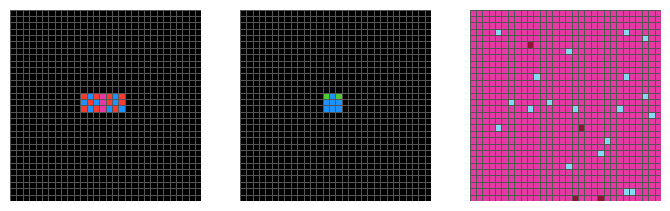

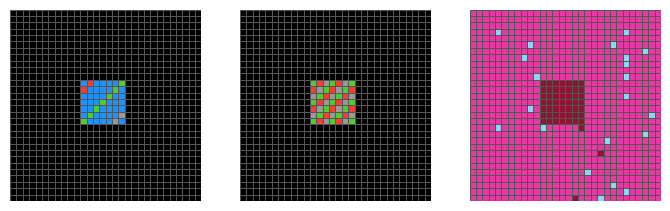

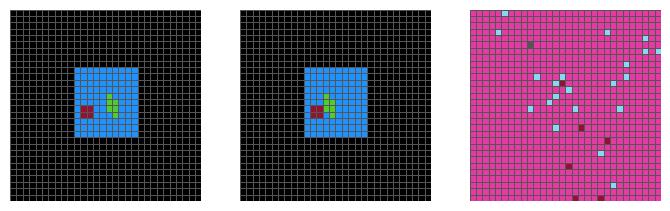

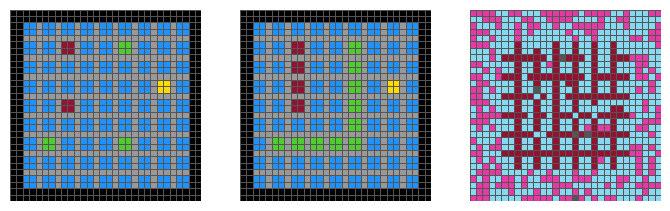

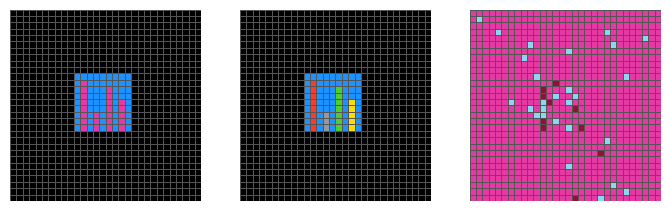

Epoch 13/25, Loss: 5.359815047910581, Accuracy: 0.23644833427442122%
Epoch 14/25


Validation: 100%|██████████| 21/21 [01:37<00:00,  4.64s/it]


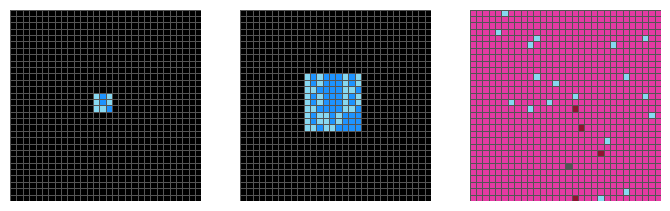

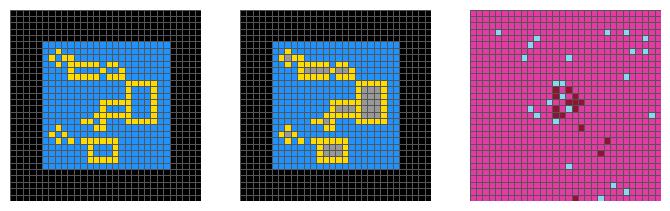

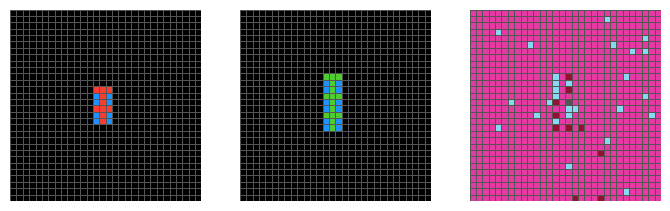

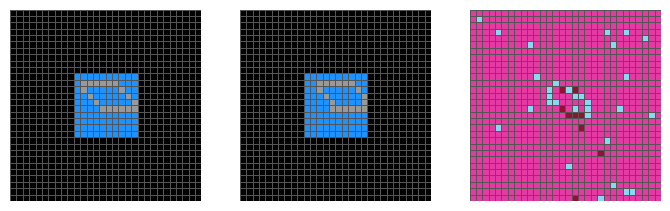

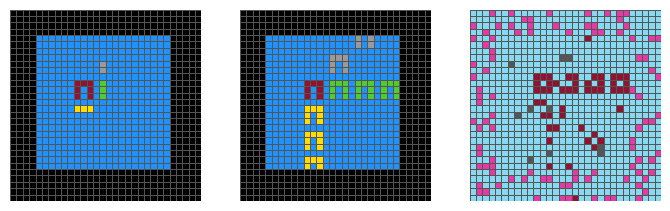

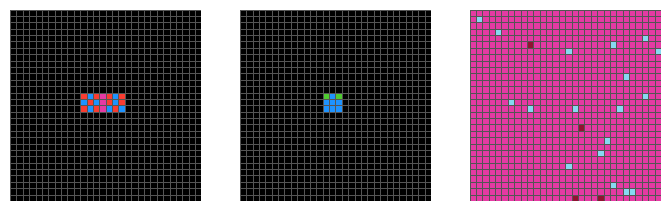

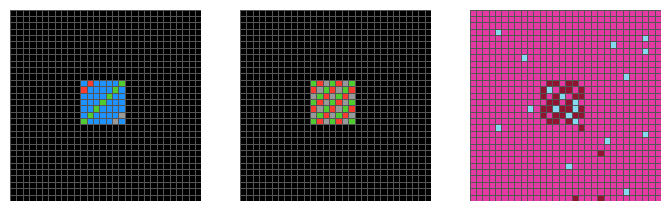

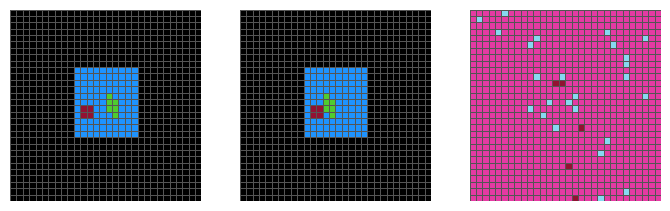

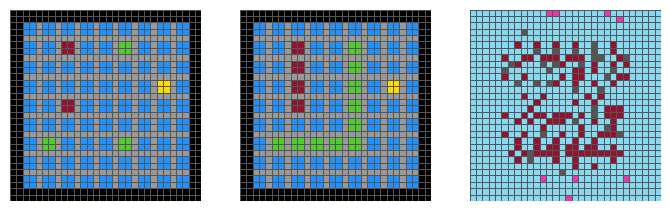

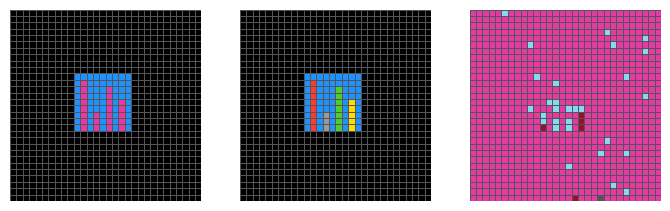

Epoch 14/25, Loss: 5.3700801357626915, Accuracy: 0.5822981366459627%
Epoch 15/25


Validation: 100%|██████████| 21/21 [01:37<00:00,  4.66s/it]


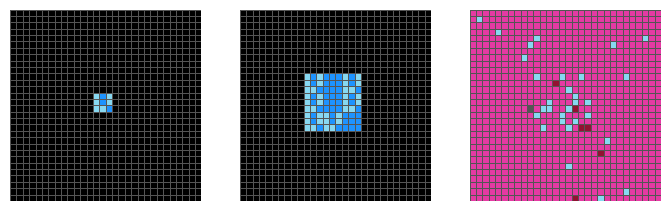

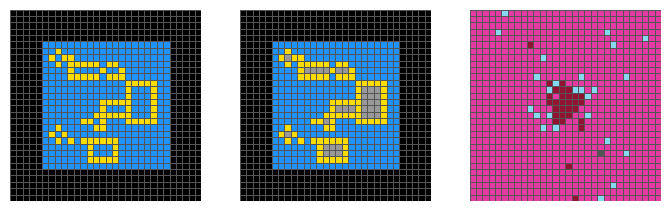

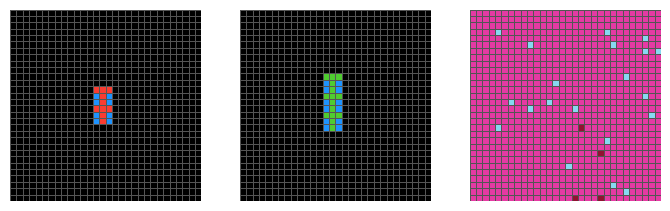

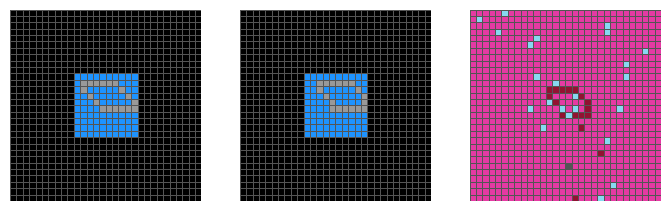

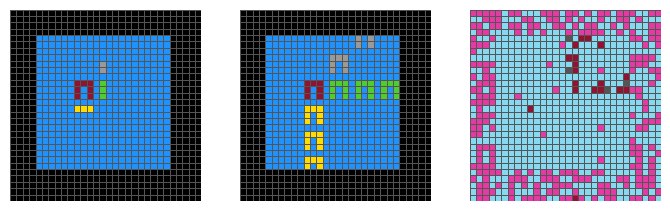

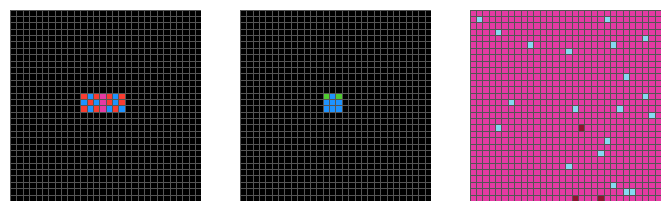

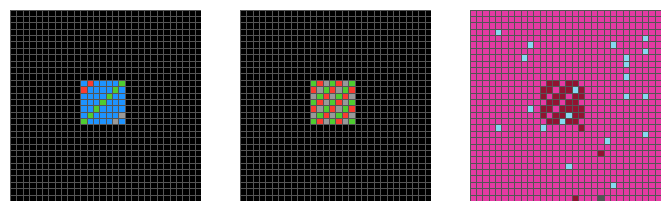

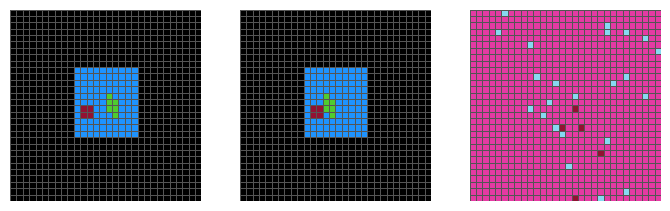

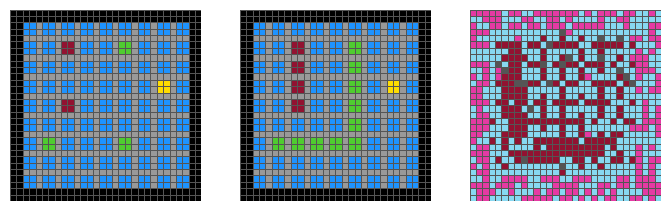

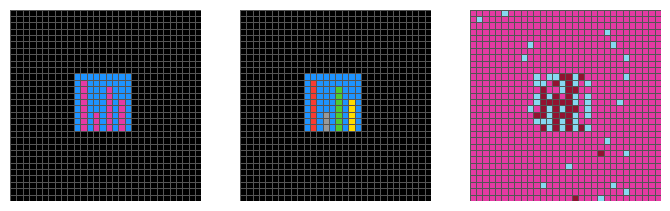

Epoch 15/25, Loss: 5.382312540824596, Accuracy: 0.16057312252964426%
Epoch 16/25


Validation: 100%|██████████| 21/21 [01:38<00:00,  4.71s/it]


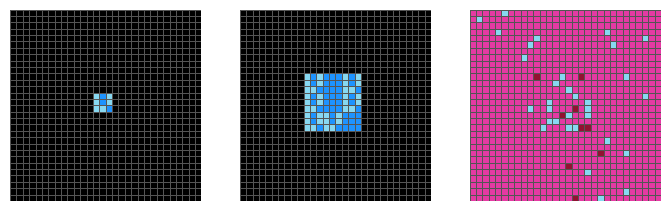

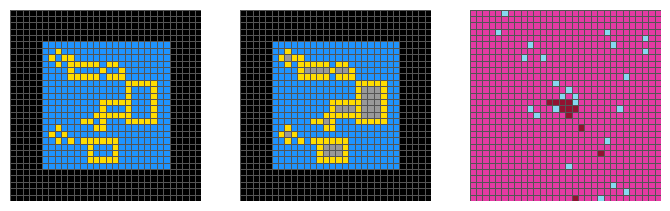

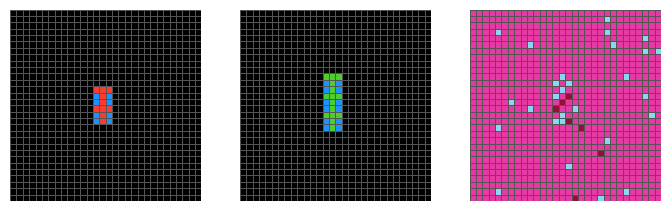

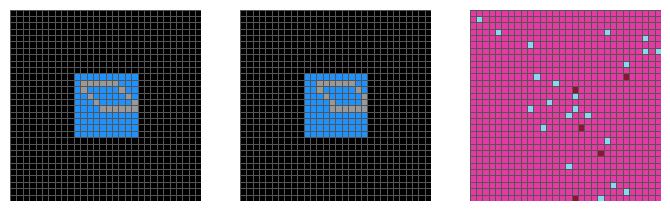

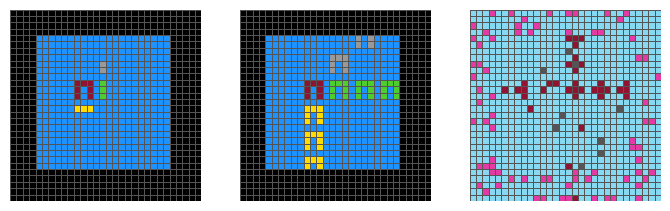

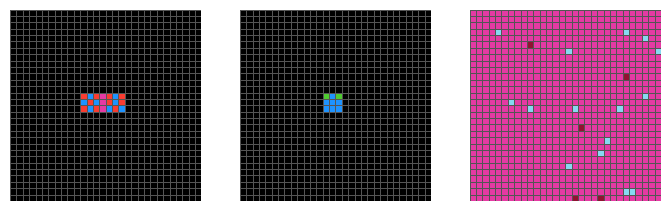

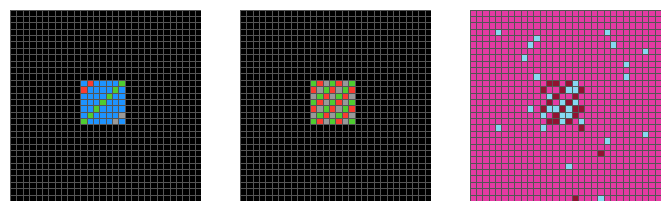

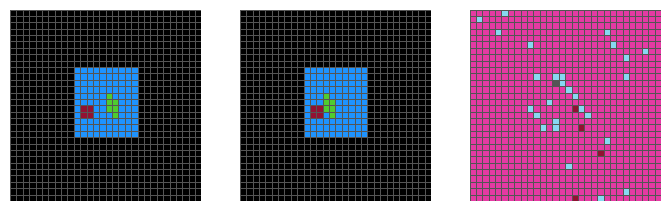

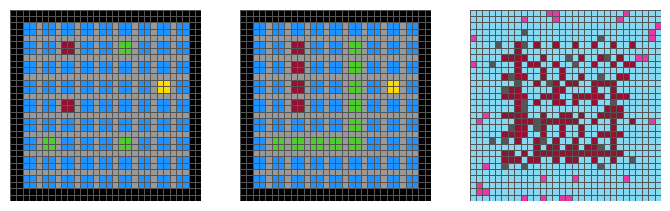

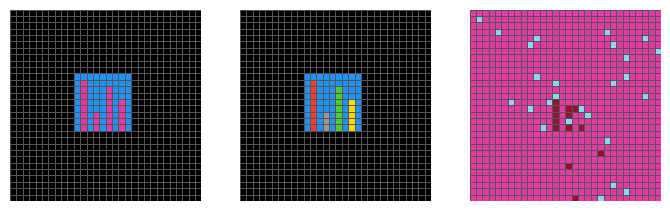

Epoch 16/25, Loss: 5.371931282946696, Accuracy: 0.25938735177865613%
Epoch 17/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.72s/it]


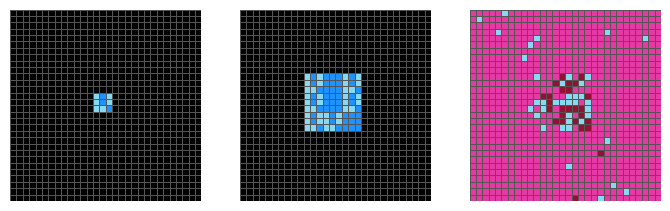

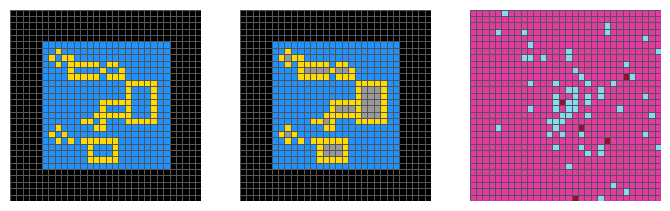

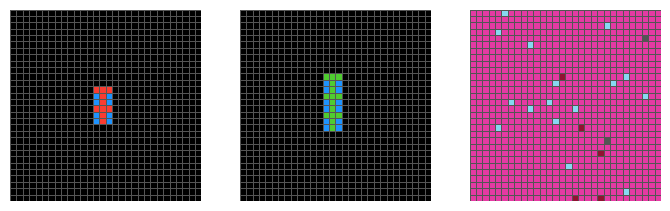

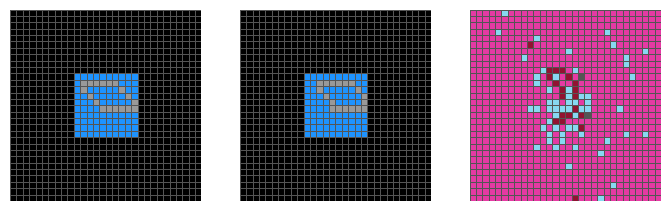

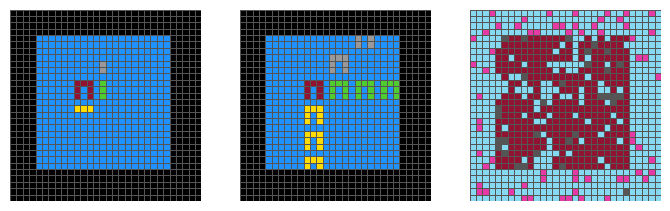

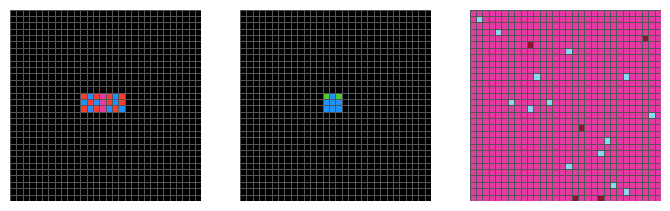

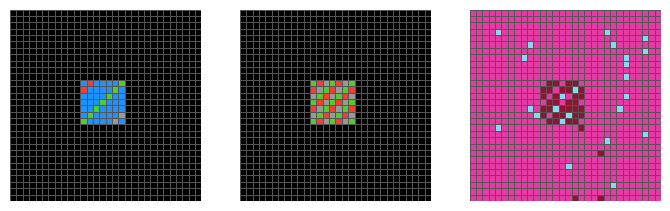

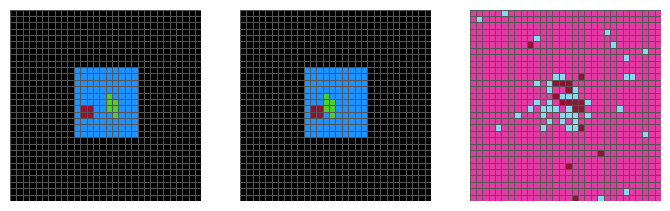

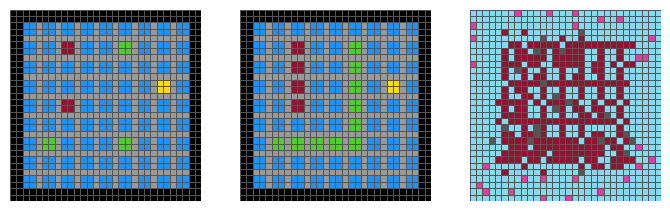

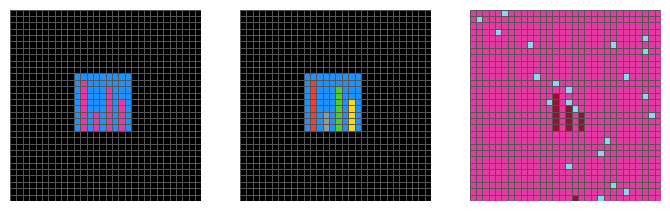

Epoch 17/25, Loss: 5.3112725879137335, Accuracy: 0.3705533596837945%
Epoch 18/25


Validation: 100%|██████████| 21/21 [01:40<00:00,  4.78s/it]


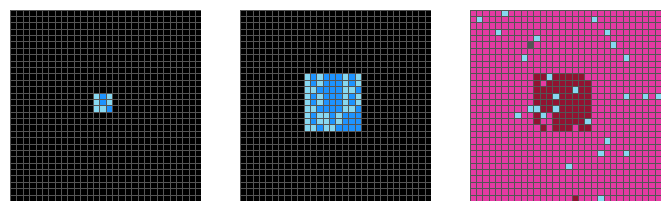

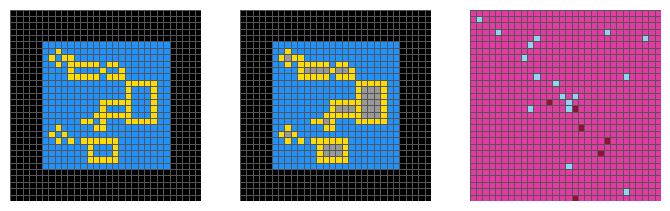

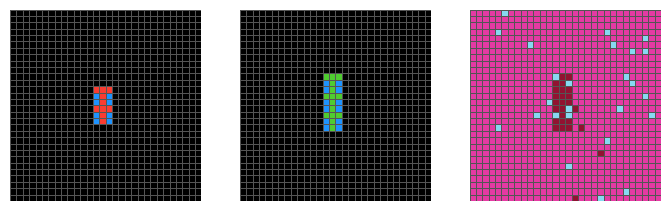

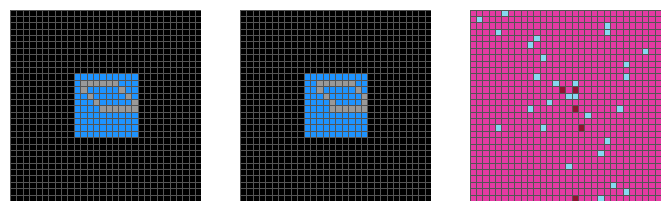

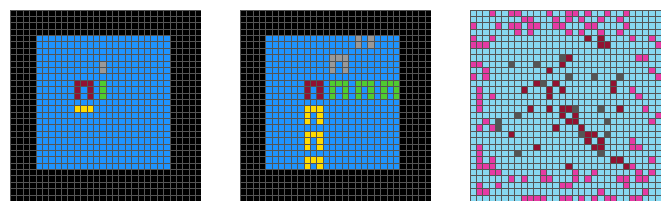

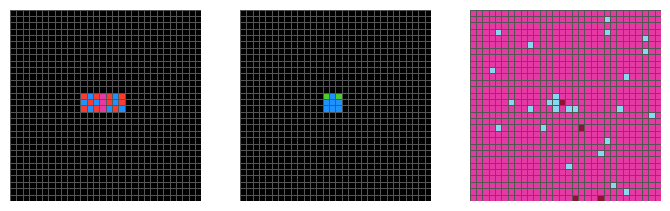

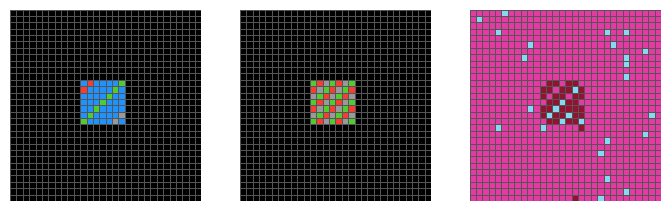

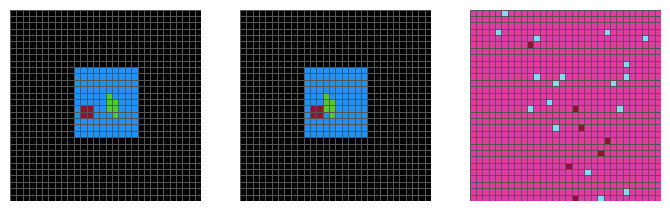

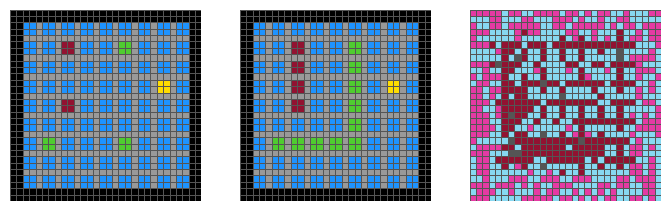

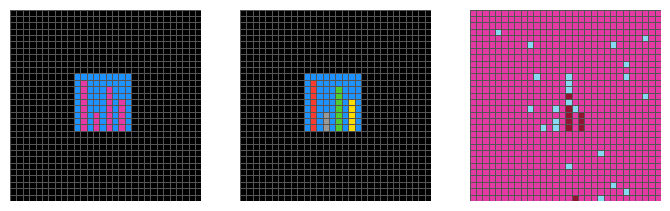

Epoch 18/25, Loss: 5.313616221340803, Accuracy: 0.49054206662902317%
Epoch 19/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.72s/it]


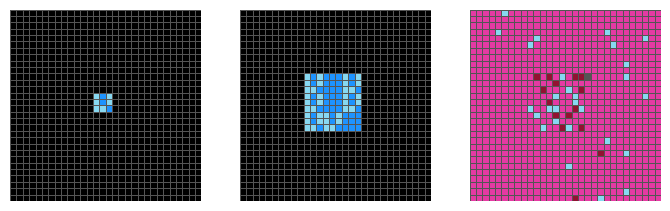

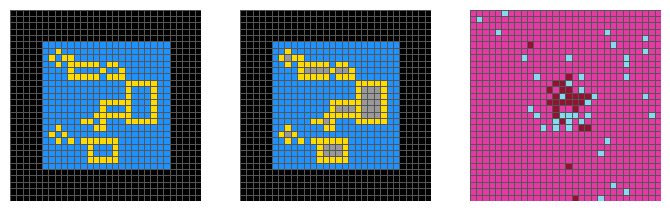

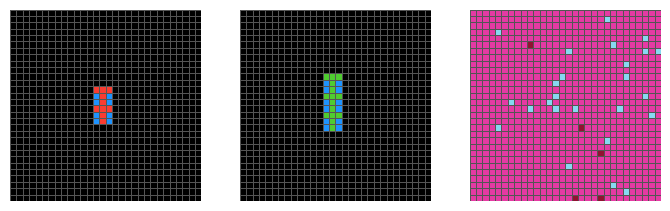

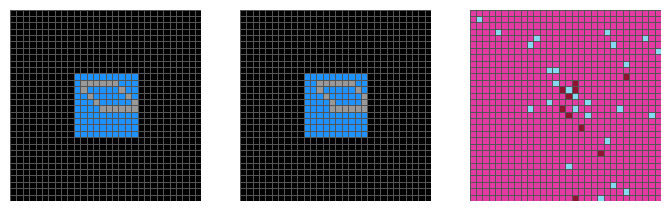

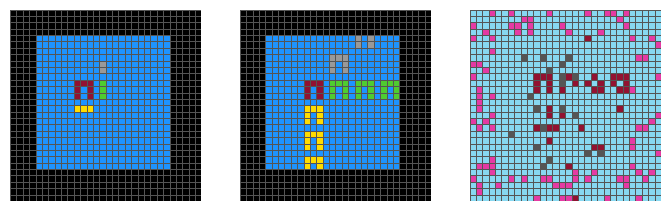

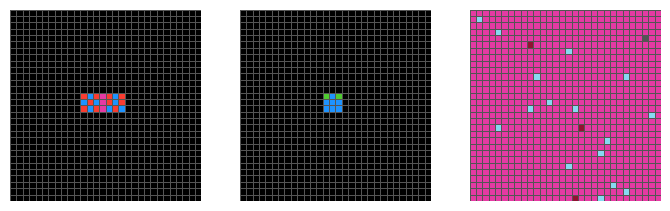

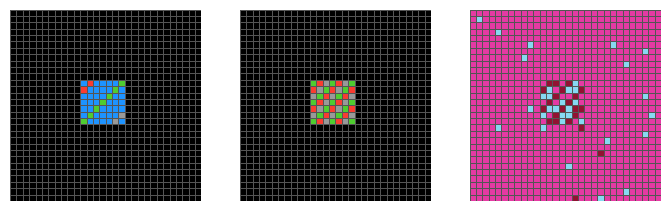

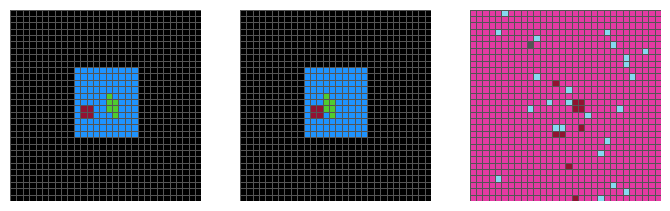

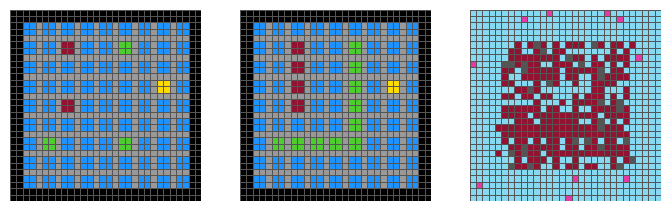

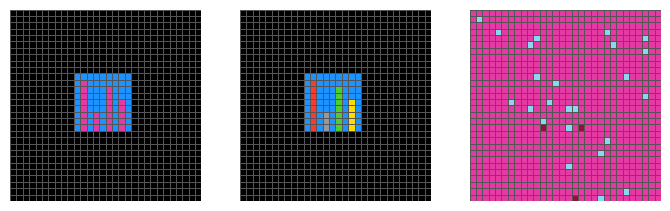

Epoch 19/25, Loss: 5.331124507463896, Accuracy: 0.40055053642010163%
Epoch 20/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.73s/it]


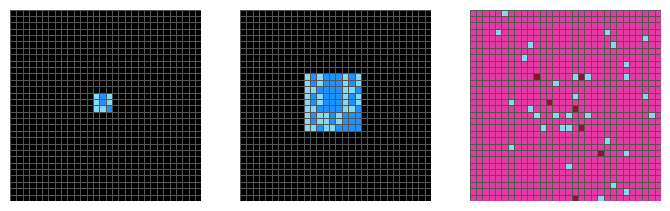

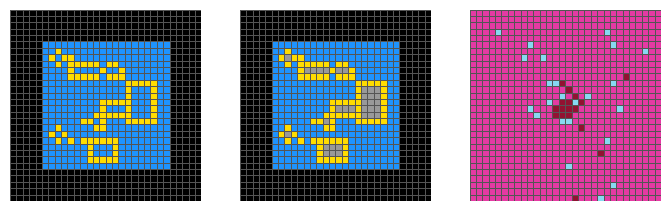

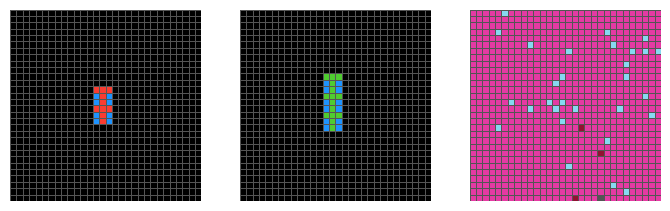

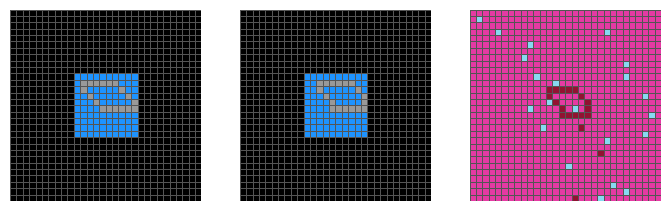

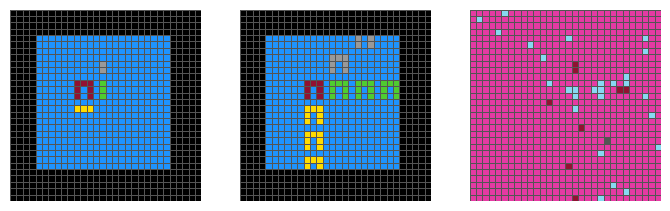

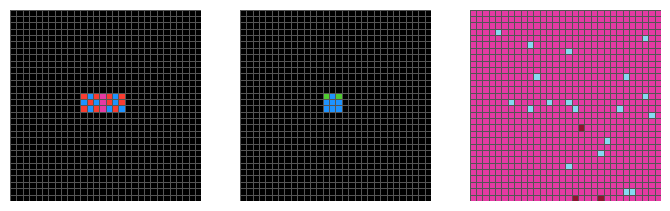

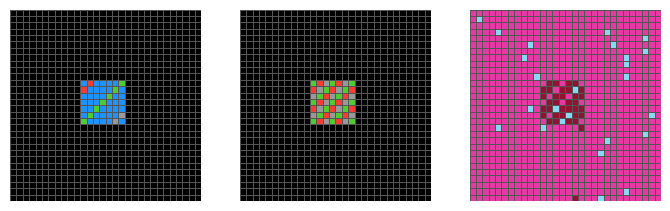

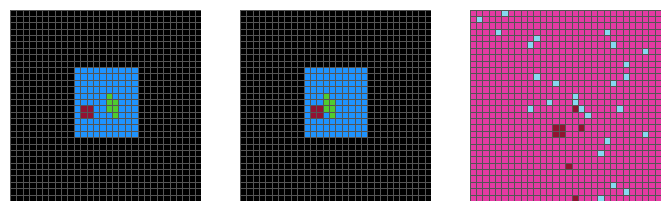

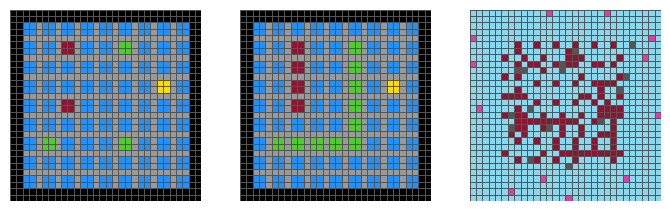

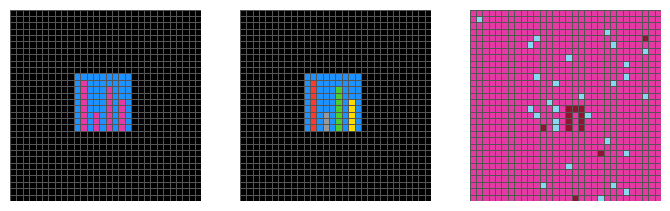

Epoch 20/25, Loss: 5.421313764957281, Accuracy: 0.718167701863354%
Epoch 21/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.74s/it]


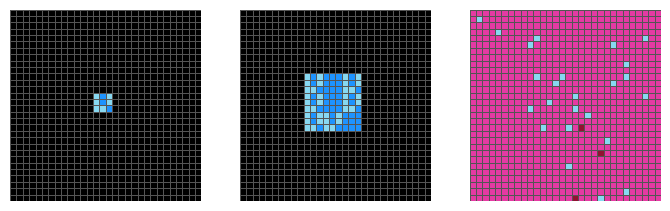

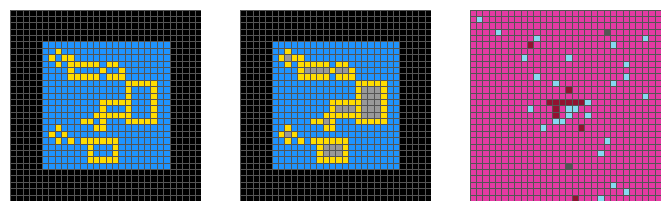

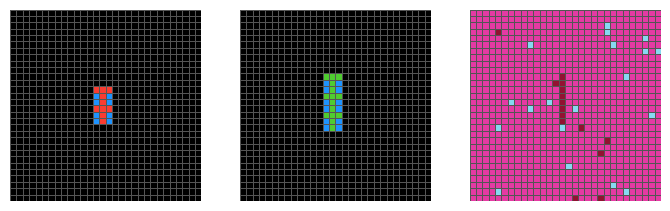

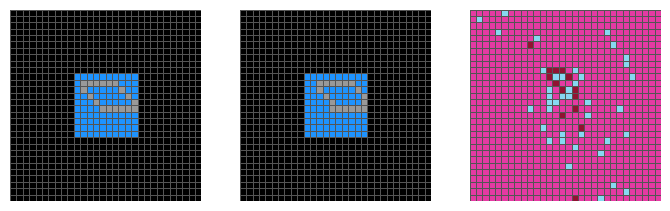

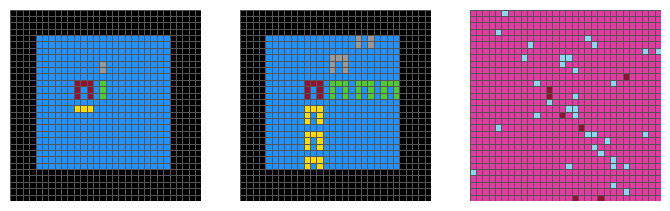

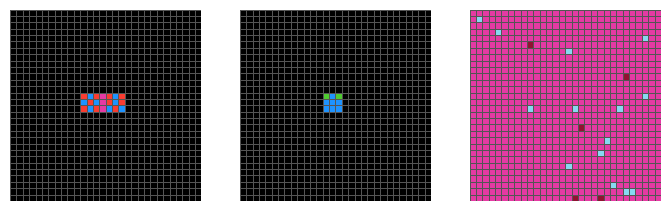

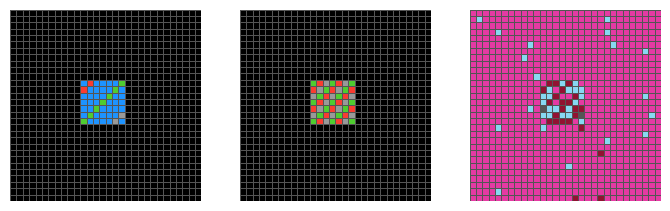

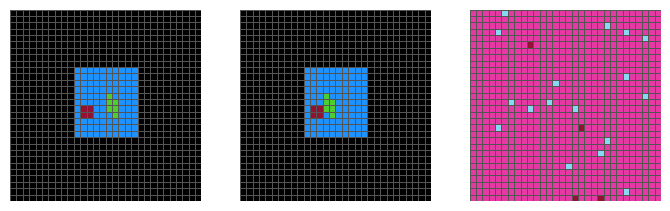

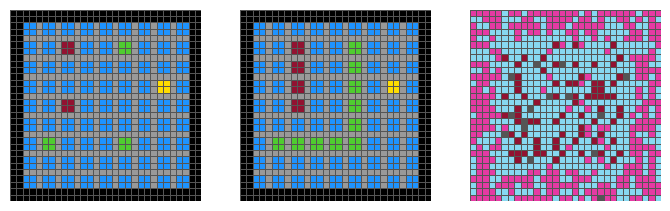

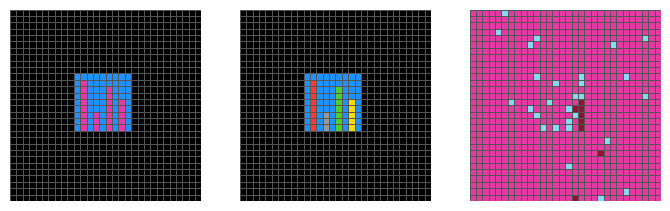

Epoch 21/25, Loss: 5.363665195611807, Accuracy: 0.2770327498588368%
Epoch 22/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.74s/it]


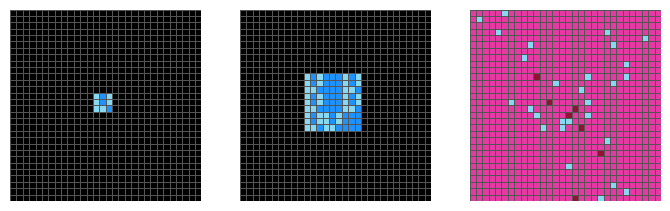

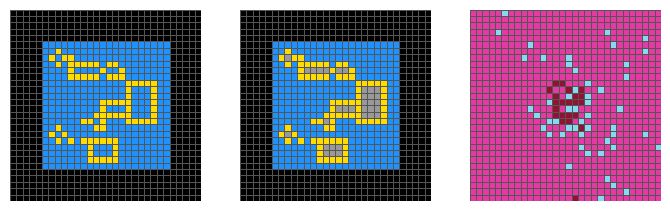

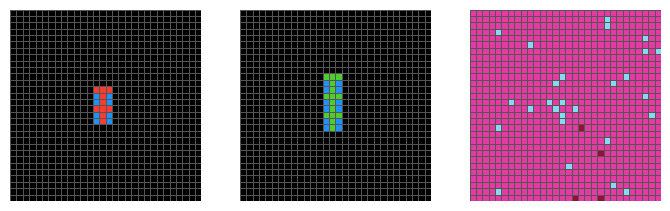

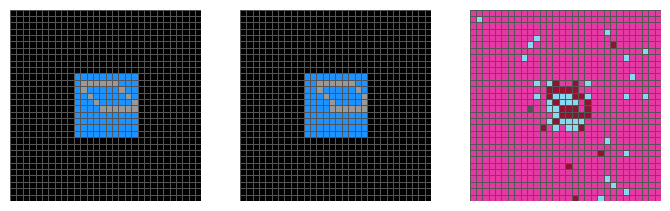

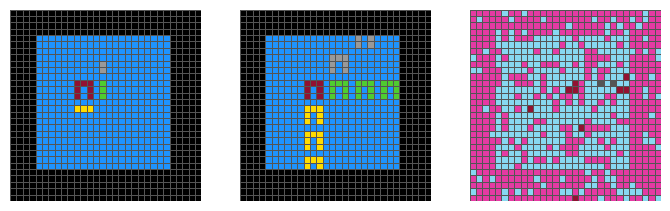

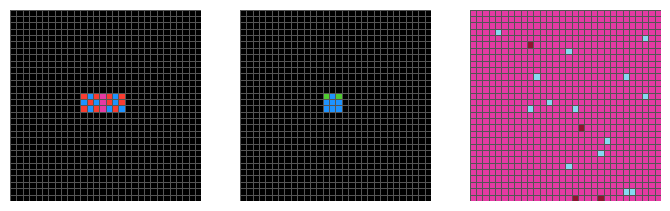

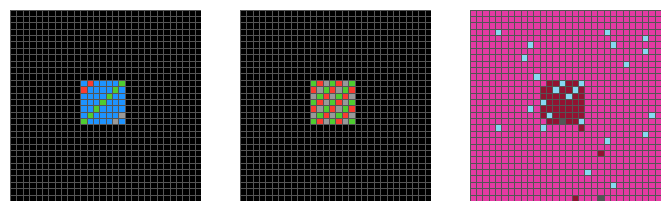

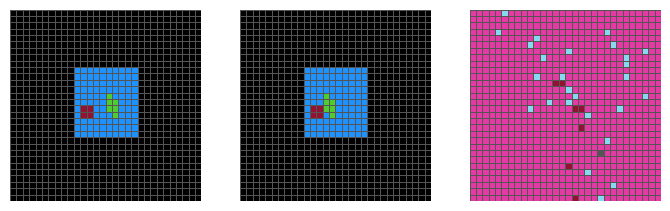

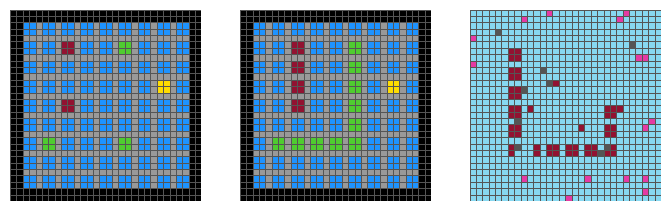

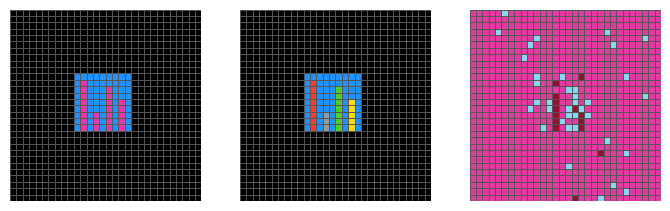

Epoch 22/25, Loss: 5.34214255385674, Accuracy: 0.7781620553359684%
Epoch 23/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.74s/it]


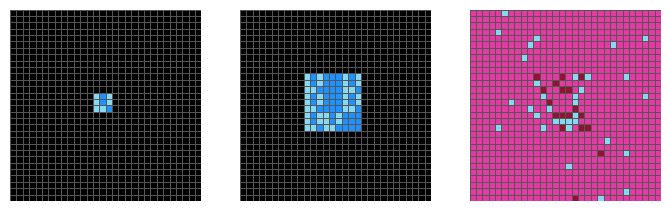

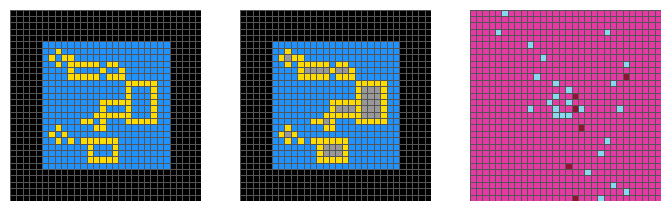

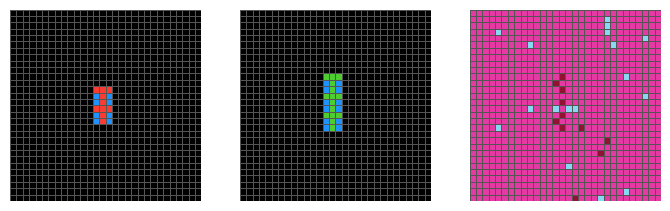

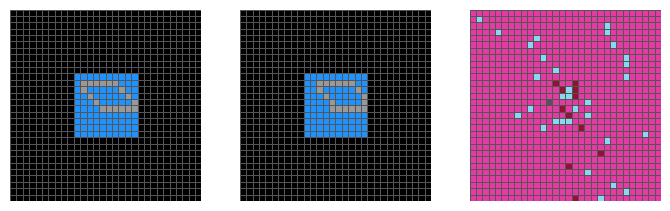

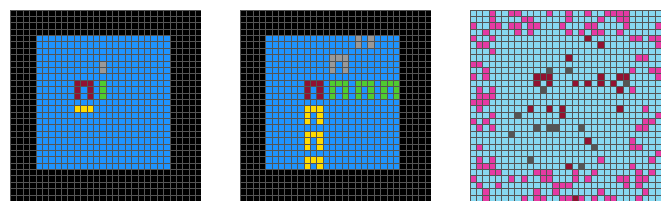

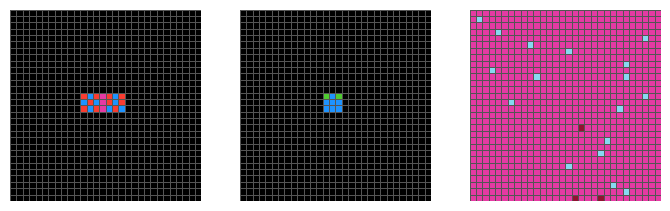

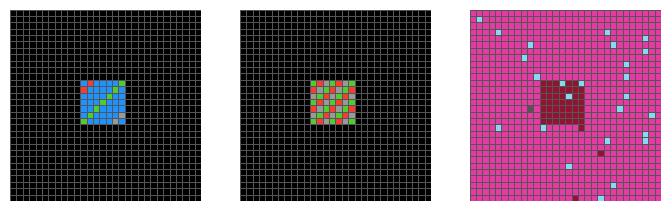

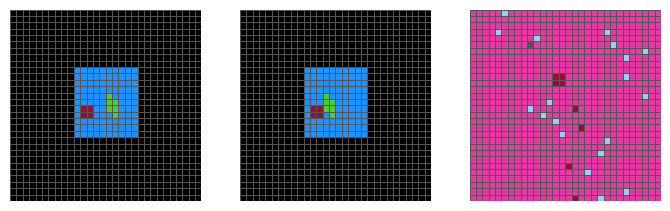

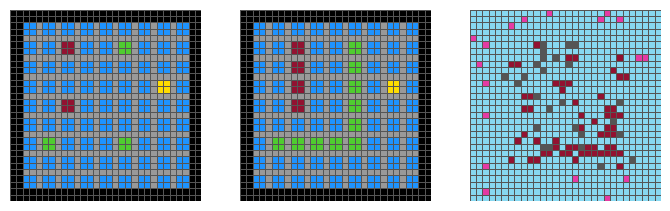

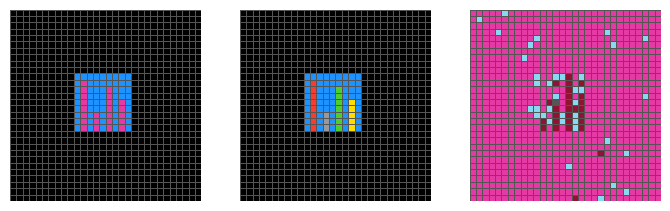

Epoch 23/25, Loss: 5.319653362035751, Accuracy: 0.35467250141163187%
Epoch 24/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.76s/it]


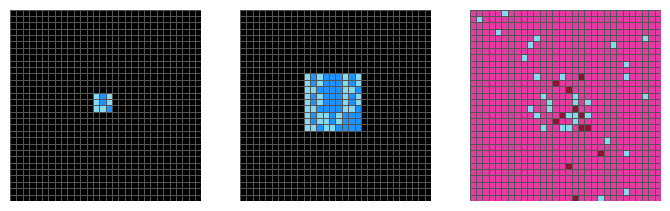

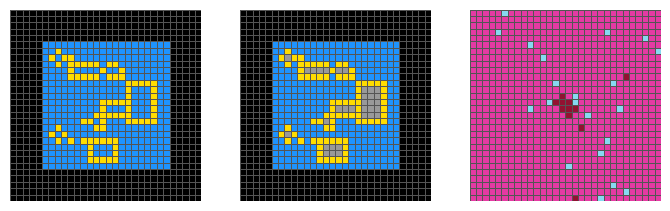

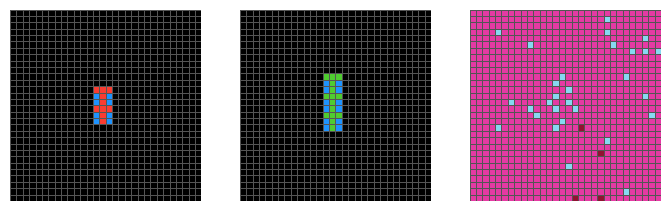

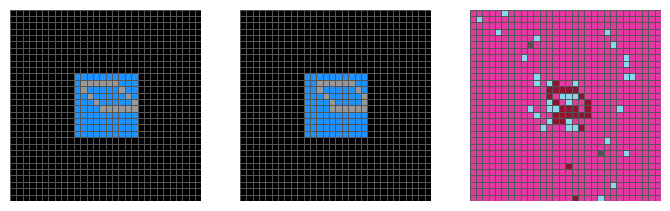

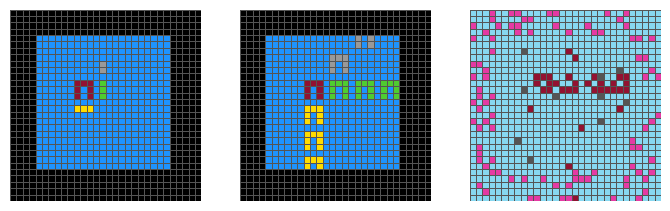

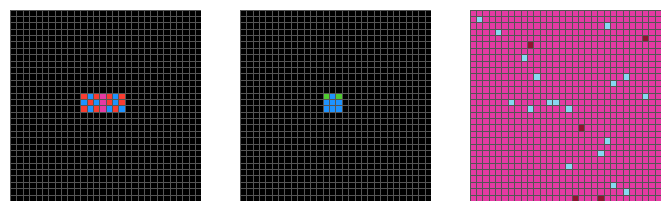

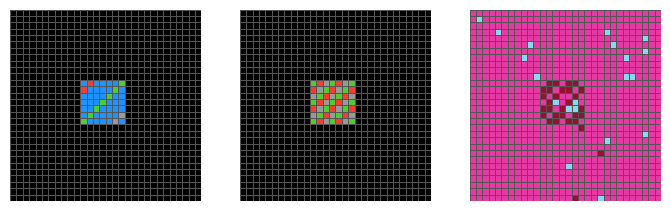

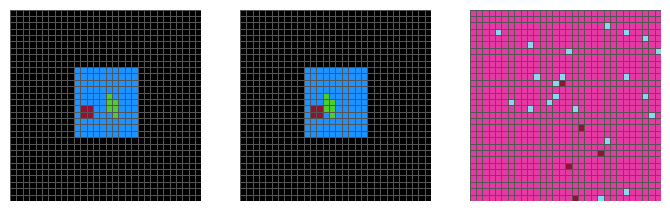

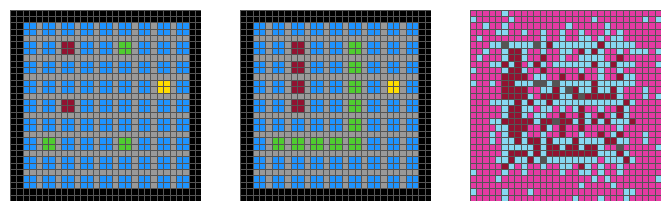

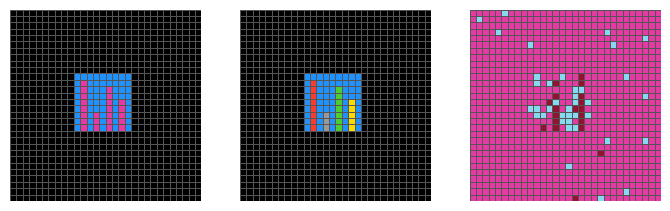

Epoch 24/25, Loss: 5.347552723609484, Accuracy: 0.5187747035573123%
Epoch 25/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.76s/it]


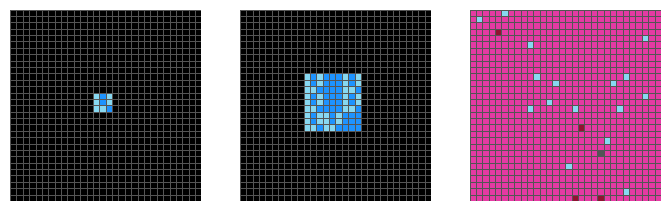

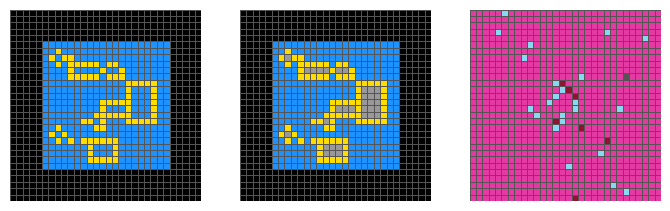

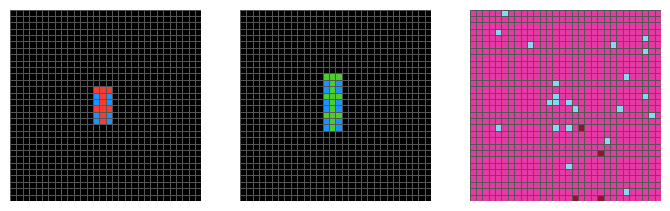

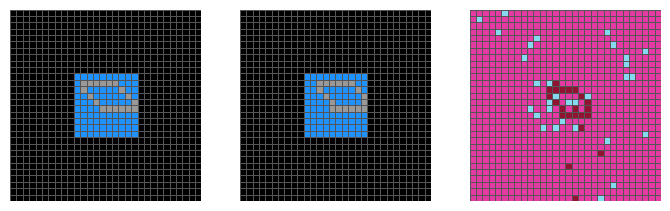

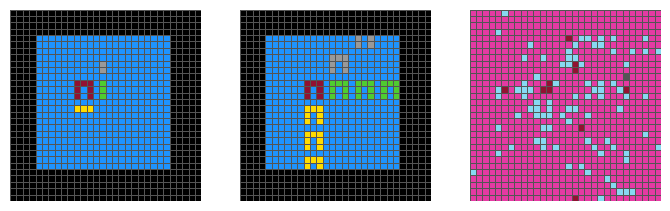

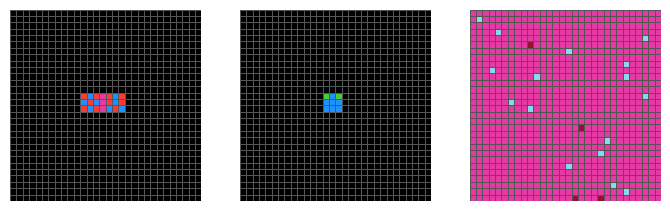

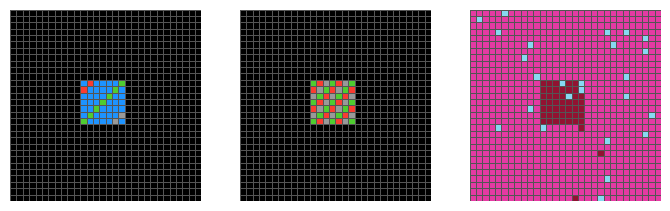

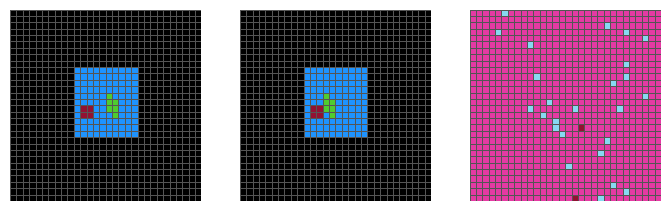

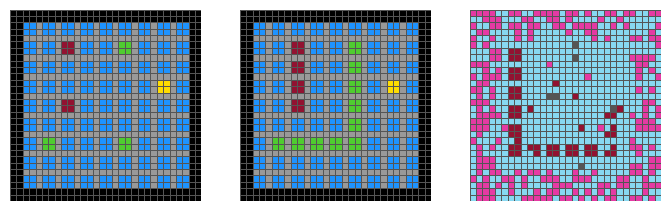

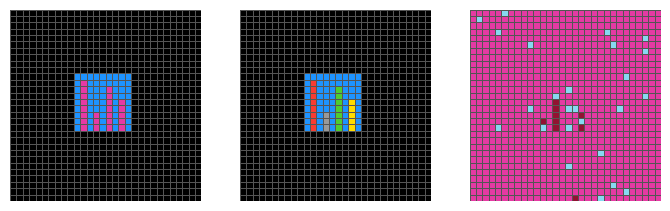

Epoch 25/25, Loss: 5.336683864776905, Accuracy: 0.31938170525127046%


In [ ]:
from bw_net_maml import BWNet_MAML
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import gc
import random

def remapping_output(tensor):
    # 범위별 매핑 딕셔너리
    remapping = {
        (1, 10): -1,
        (11, 20): -2,
        (21, 30): -3,
        (31, 40): -4,
        (41, 50): -5,
        (51, 60): -6,
        (61, 70): -7,
        (71, 80): -8,
        (81, 90): -9,
        (91, 100): -10
    }
    
    temp_tensor = tensor.clone()

    # 각 범위에 대해 매핑 수행
    for value_range, new_value in remapping.items():
        mask = (temp_tensor >= value_range[0]) & (temp_tensor <= value_range[1])
        temp_tensor[mask] = new_value  # 임시로 기존 값에 음수를 취해 중복을 피함
    for value_range, new_value in remapping.items():
        temp_tensor[temp_tensor == new_value] = -1*new_value  # 음수로 변환된 값을 다시 양수로 변환

    return temp_tensor


colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

def inner_loop_update(model, example_input, example_output, inner_optimizer, criterion, steps):
    for _ in range(steps):
        model.train()
        prediction = model(example_input)
        loss = criterion(prediction, example_output)

        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()


def criterion(y_pred, y):
    y = y.long().squeeze(1)
    ce = F.cross_entropy(y_pred, y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 25,
    'task_numbers': 20, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 3, #equal to inner model batch size
    'inner_lr': 0.001,
    'outer_lr': 0.001,
    'embed_size': 1,
    
}

# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device  
print(f'Using {device} device')


train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

outer_model = BWNet_MAML(embed_size=kwargs['embed_size']).to(device)
outer_optimizer= optim.AdamW(outer_model.parameters(),lr=kwargs['outer_lr'])

for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    total_loss = 0
    # total_samples = 0
    outer_model.train()

    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]
        
        # total_samples += input_tensor.shape[0]
        task_losses = []
        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_optimizer = optim.AdamW(inner_model.parameters(),lr=kwargs['inner_lr'])
            
            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                              inner_optimizer, criterion, kwargs['example_data_num'])
            
        
            inner_model.eval()
            task_prediction = inner_model(input_tensor[task_number])
            task_loss = criterion(task_prediction, output_tensor[task_number])
            task_losses.append(task_loss)
        
        meta_loss = torch.stack(task_losses).mean()
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()
        
        del meta_loss, task_losses
        gc.collect()
        torch.cuda.empty_cache()
        

    del inner_optimizer
    torch.cuda.empty_cache()
    gc.collect()
    
    # Validation Loop
    outer_model.eval()
    validation_correct = 0
    validation_total_samples = 0
    total_loss = []
    visualization_samples = []
    for batch_idx, data in enumerate(tqdm(eval_loader, desc='Validation')):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_model.train()
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])

            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                            inner_optimizer, criterion, kwargs['example_data_num'])

            with torch.no_grad():
                inner_model.eval()
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                task_prediction = inner_model(task_input)
                task_loss = criterion(task_prediction, task_output)
                total_loss.append(task_loss.item())  # task_loss.item()을 리스트에 추가

                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)

                mask = task_output != 0
                correct_predictions = (prediction_class == task_output) & mask
                validation_correct += correct_predictions.sum().item()
                validation_total_samples += mask.sum().item()
            
            if len(visualization_samples) < 10:  # 예를 들어 10개의 샘플만 저장
                        visualization_samples.append((
                            remapping_output(task_input.cpu()),
                            remapping_output(task_output.cpu()),
                            remapping_output(prediction_class.cpu())
                        ))

            del inner_model, inner_optimizer, task_input, task_output, task_prediction, mask, correct_predictions
            gc.collect()
            torch.cuda.empty_cache()

    if visualization_samples:
        for vis_input, vis_output, vis_prediction in visualization_samples:
            show_grid_side_by_side(vis_input, vis_output, vis_prediction)

            

    # 손실 값들의 평균 계산
    mean_loss = sum(total_loss) / len(total_loss) if total_loss else 0
    accuracy = 100 * validation_correct / validation_total_samples if validation_total_samples > 0 else 0
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {mean_loss}, Accuracy: {accuracy}%')
    torch.cuda.empty_cache()

Using cuda device
Epoch 1/25


Validation: 100%|██████████| 21/21 [01:28<00:00,  4.23s/it]


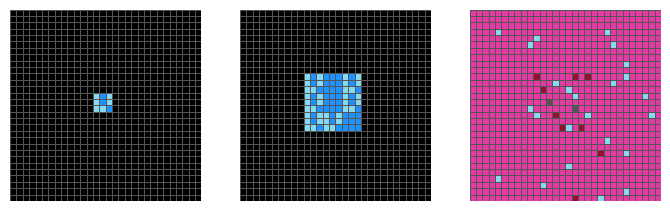

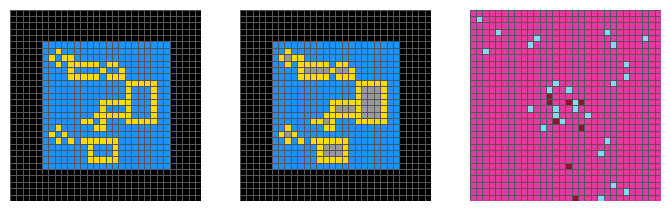

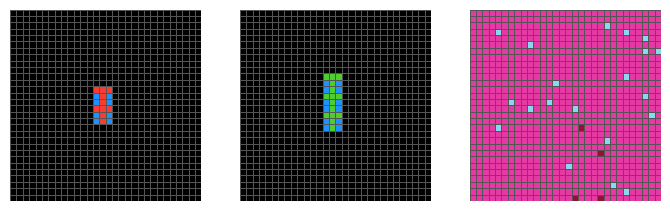

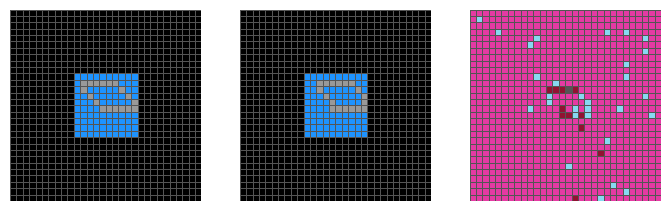

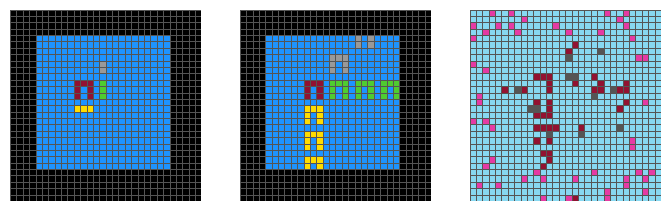

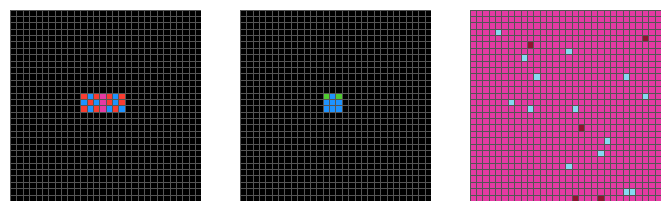

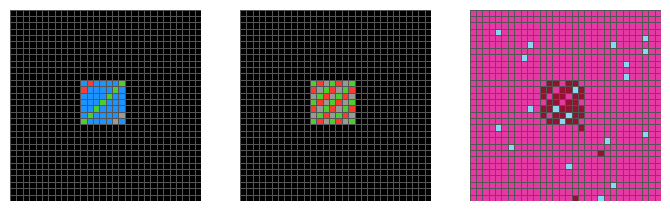

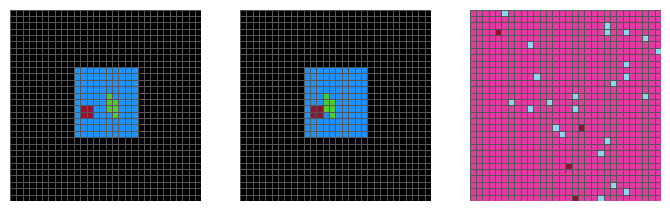

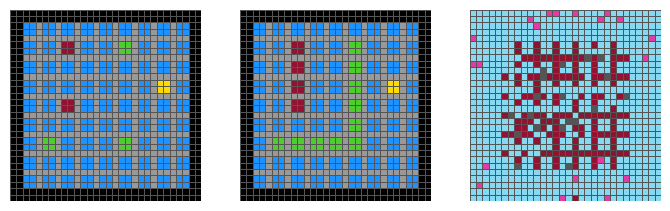

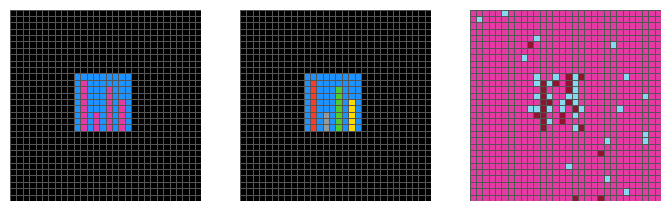

Epoch 1/25, Loss: 5.352161819545122, Accuracy: 0.6175889328063241%
Epoch 2/25


Validation: 100%|██████████| 21/21 [01:28<00:00,  4.22s/it]


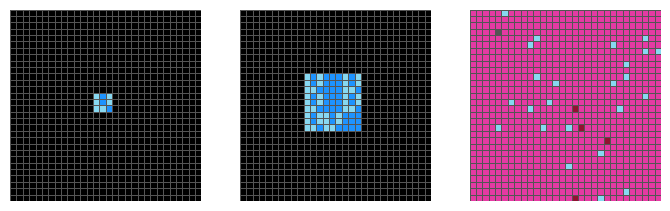

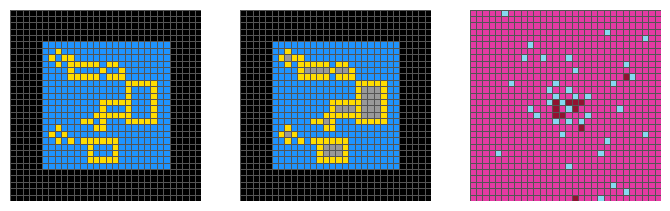

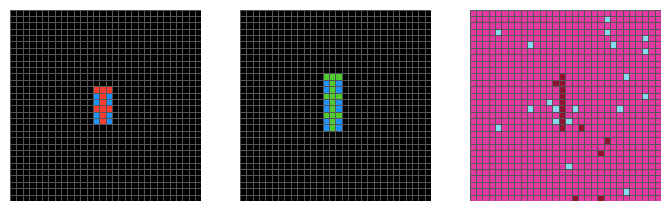

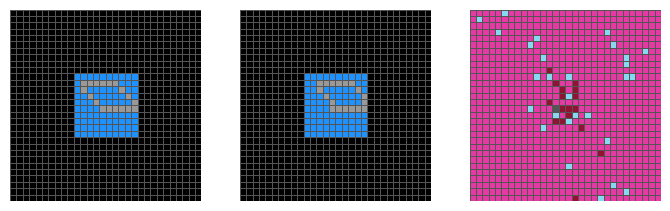

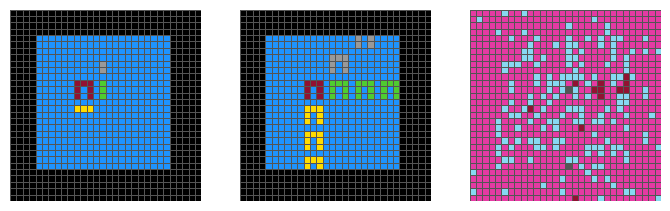

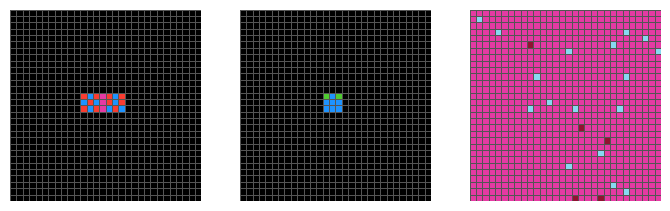

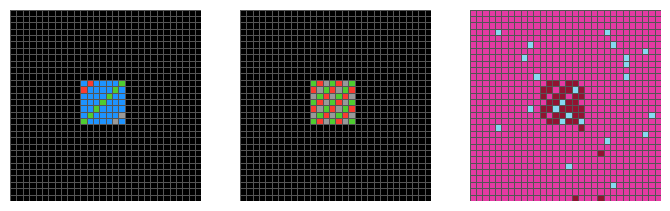

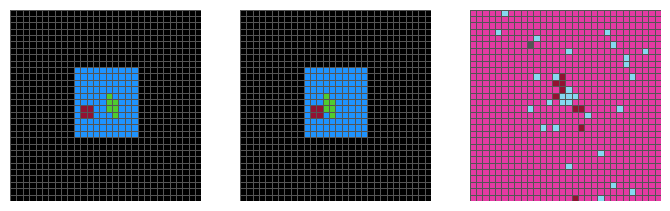

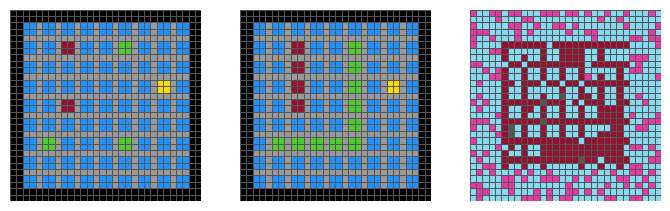

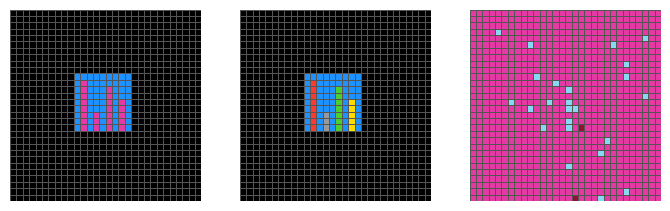

Epoch 2/25, Loss: 5.31638242992071, Accuracy: 0.2717391304347826%
Epoch 3/25


Validation: 100%|██████████| 21/21 [01:28<00:00,  4.23s/it]


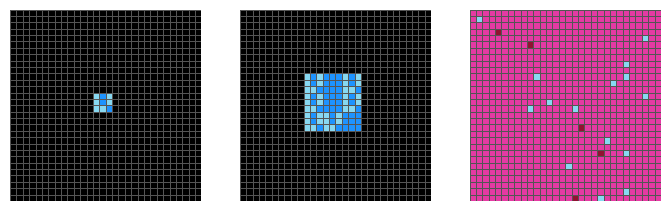

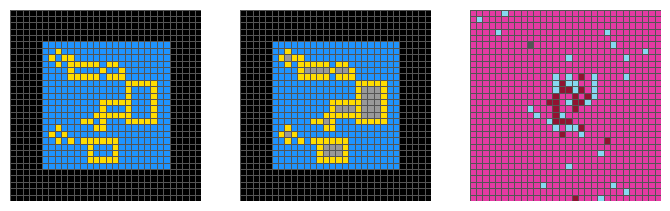

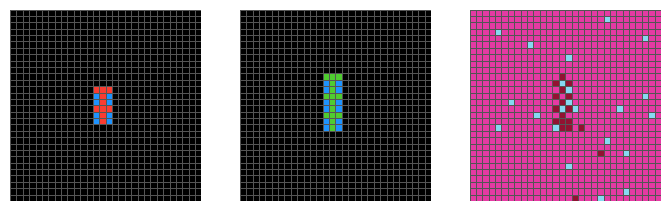

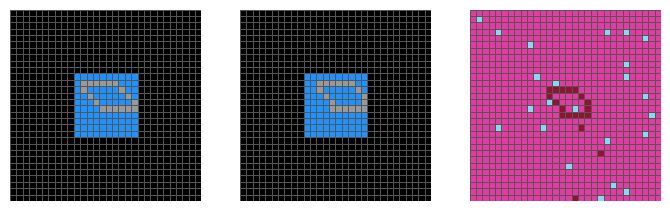

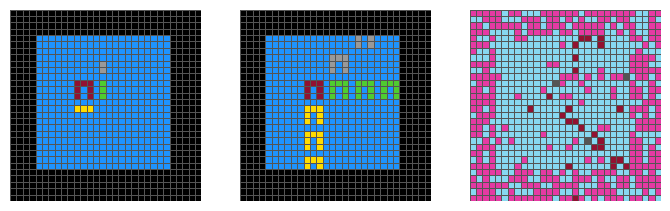

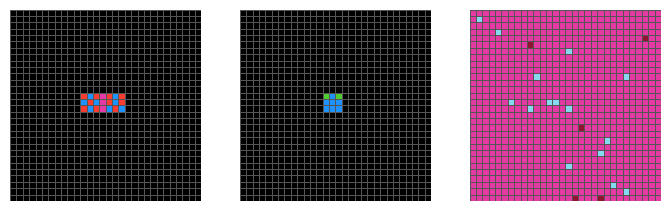

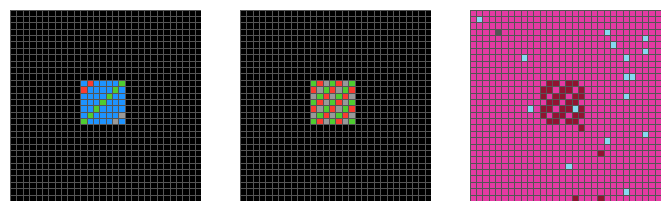

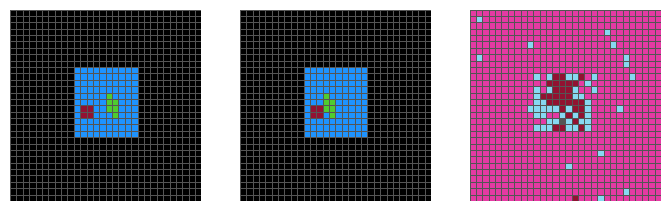

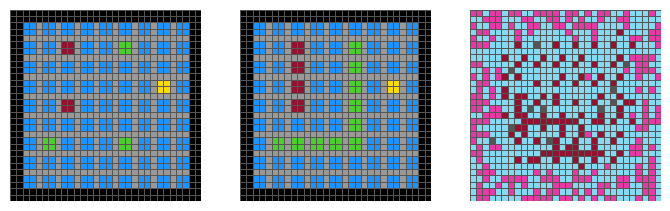

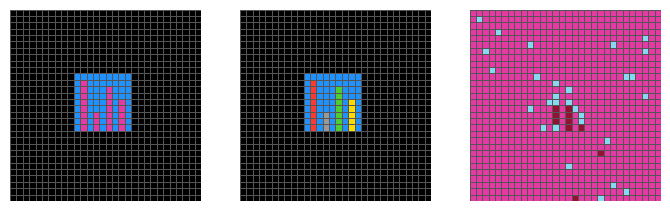

Epoch 3/25, Loss: 5.339211079936761, Accuracy: 0.4252540937323546%
Epoch 4/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.85s/it]


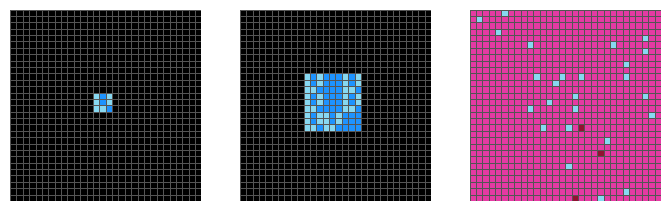

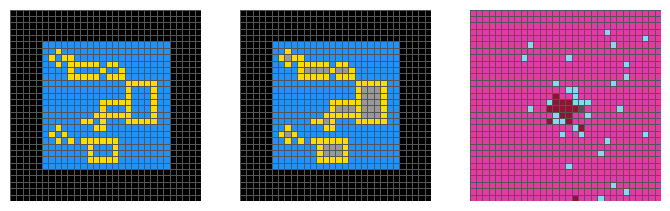

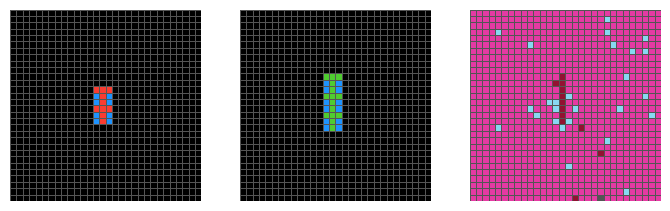

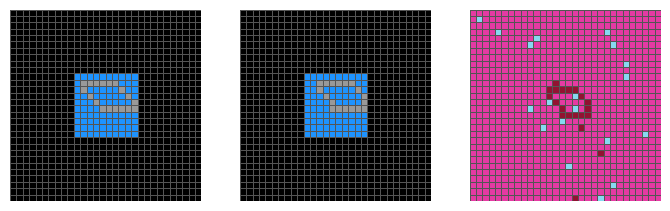

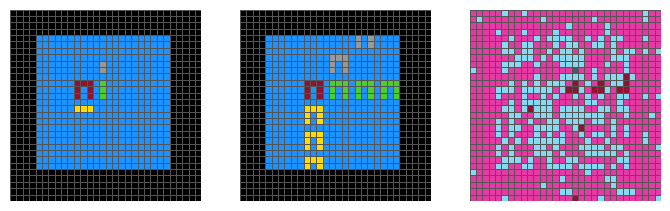

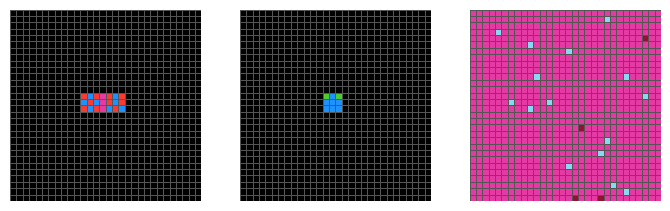

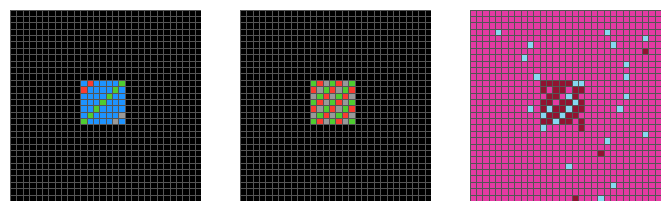

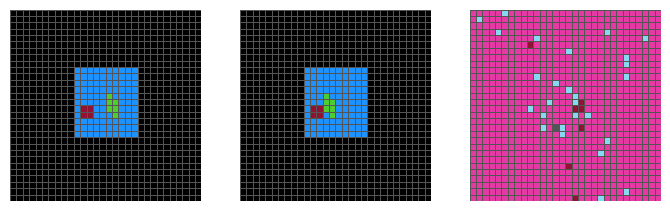

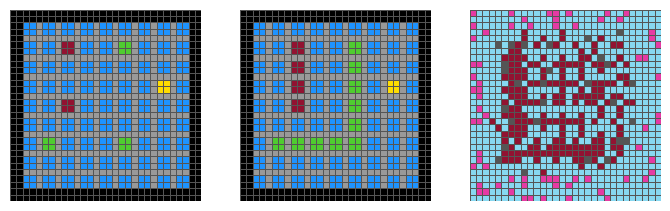

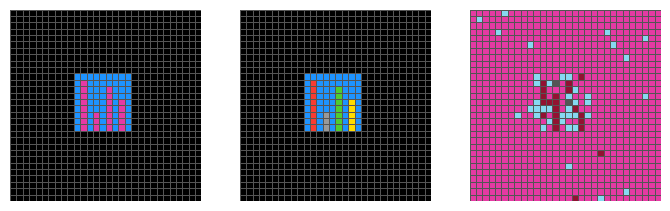

Epoch 4/25, Loss: 5.343926784510796, Accuracy: 0.8011010728402033%
Epoch 5/25


Validation: 100%|██████████| 21/21 [01:42<00:00,  4.87s/it]


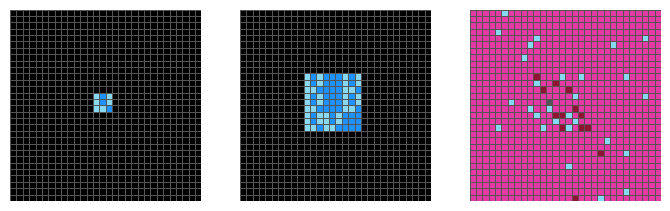

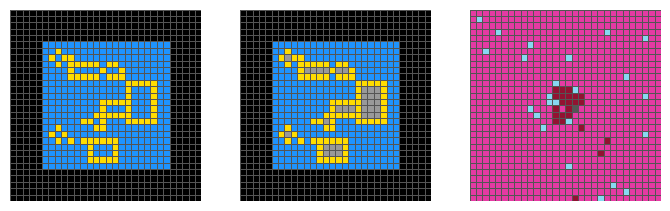

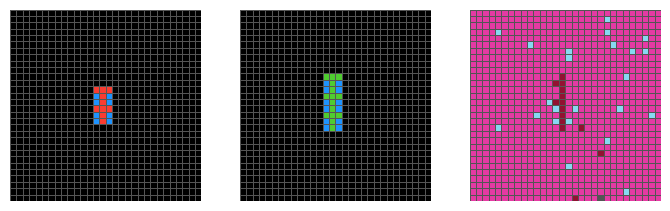

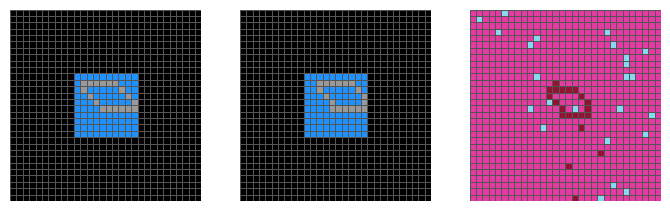

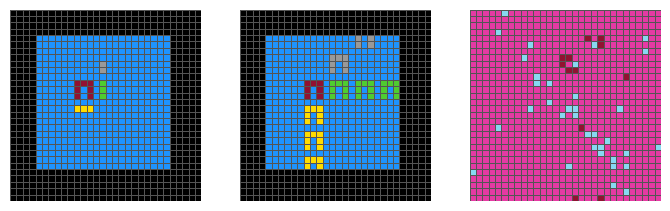

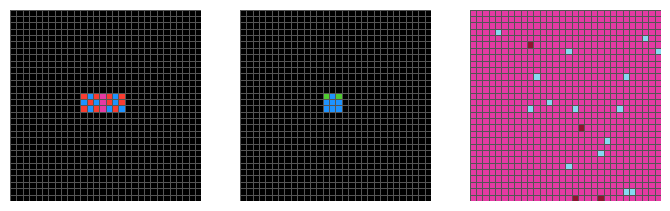

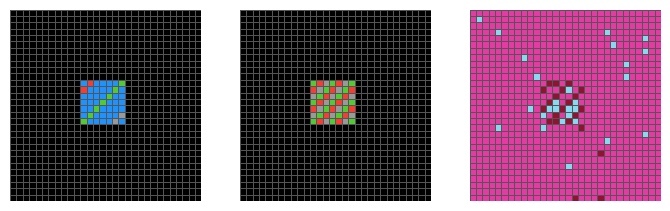

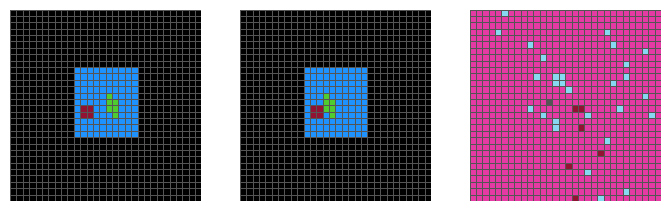

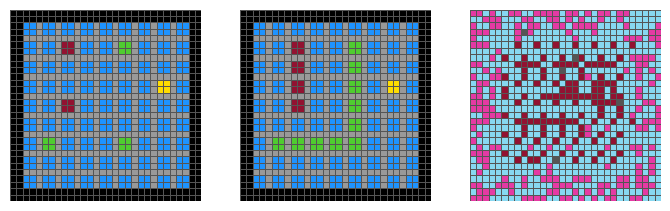

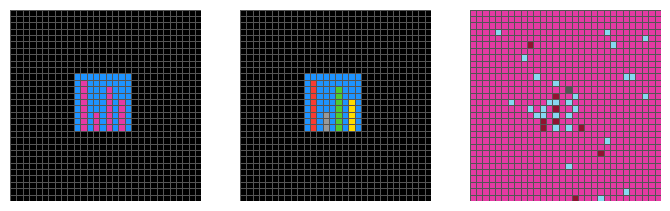

Epoch 5/25, Loss: 5.324831202053106, Accuracy: 0.5999435347261434%
Epoch 6/25


Validation: 100%|██████████| 21/21 [01:40<00:00,  4.80s/it]


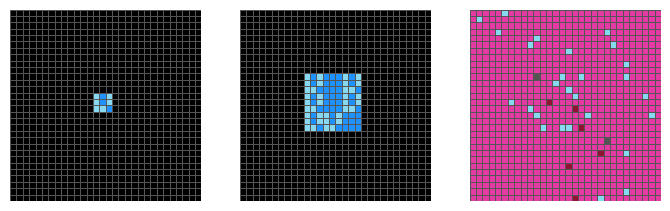

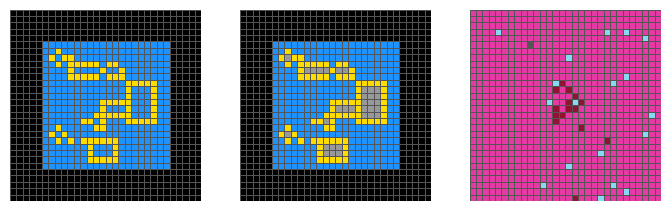

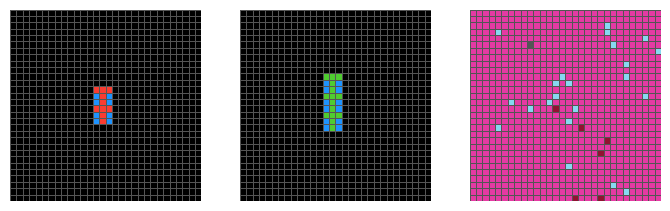

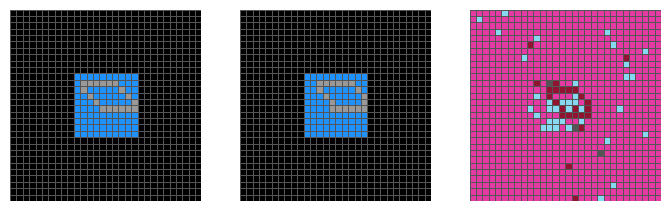

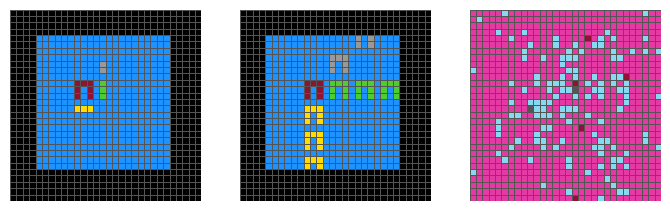

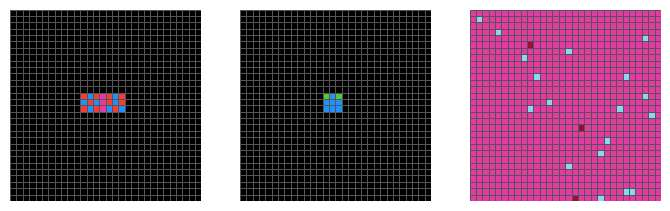

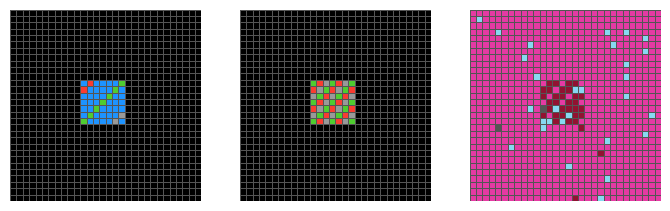

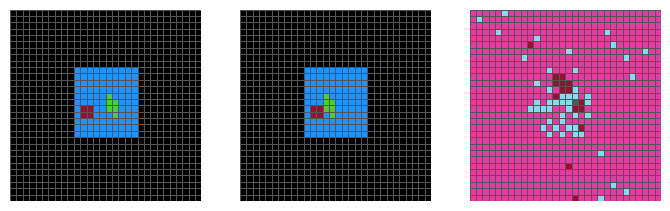

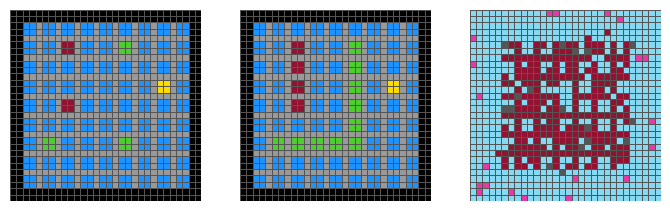

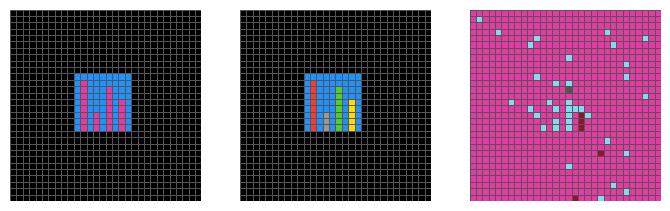

Epoch 6/25, Loss: 5.355043055346379, Accuracy: 0.5875917560700169%
Epoch 7/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.82s/it]


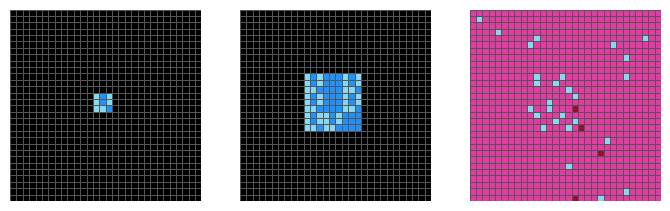

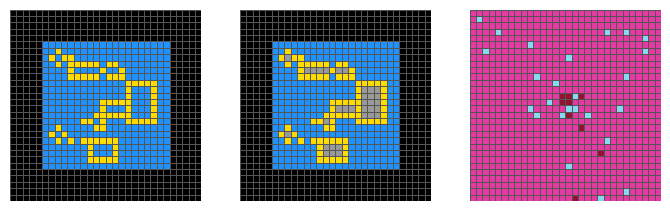

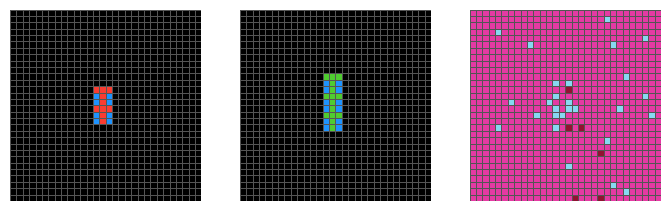

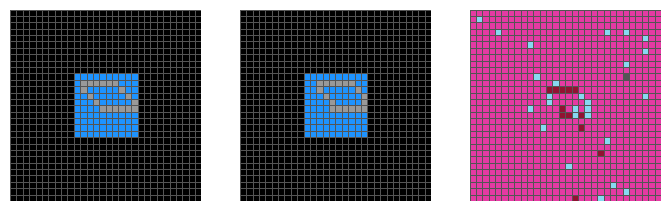

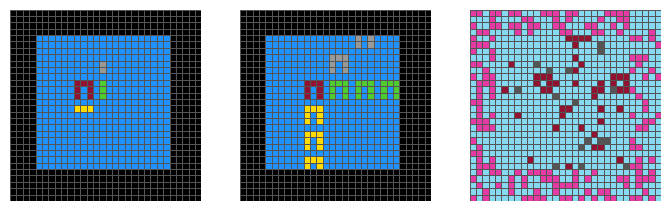

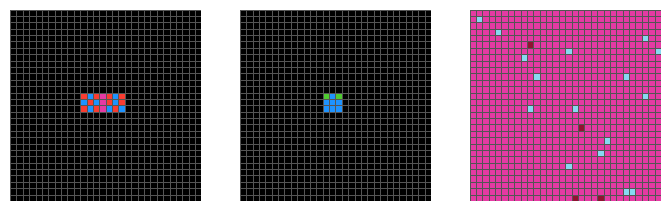

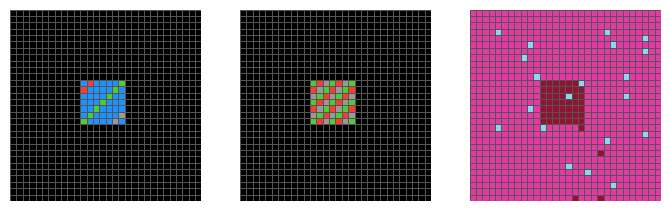

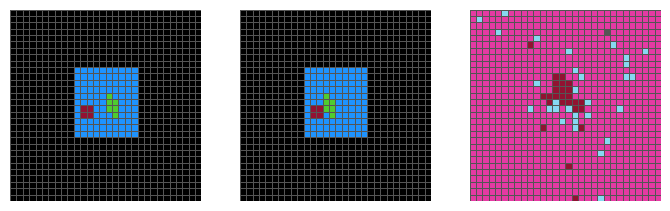

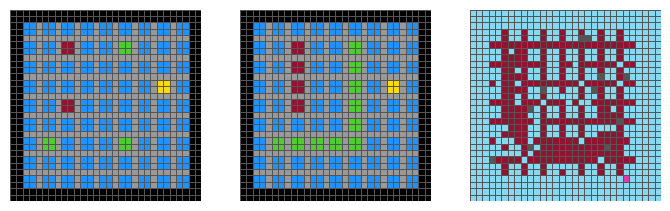

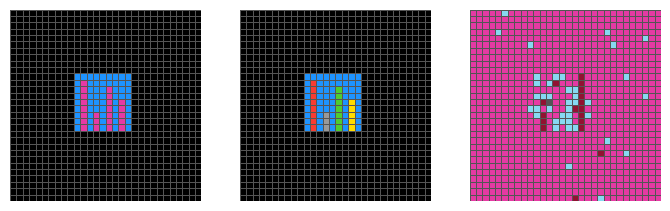

Epoch 7/25, Loss: 5.298064473729867, Accuracy: 0.7763975155279503%
Epoch 8/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.81s/it]


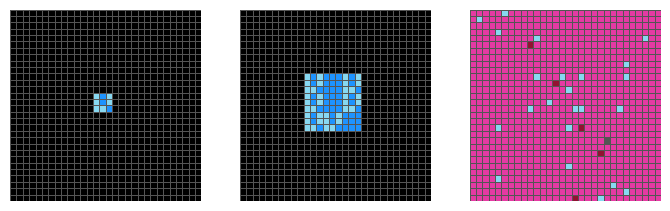

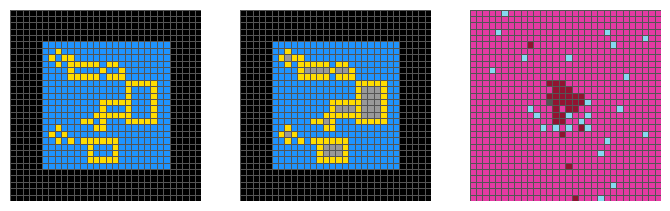

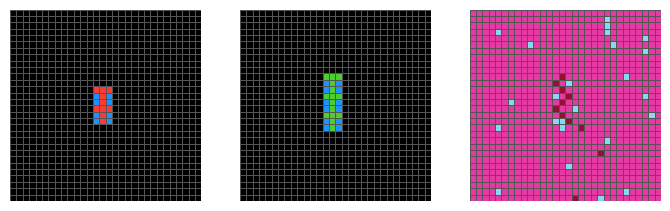

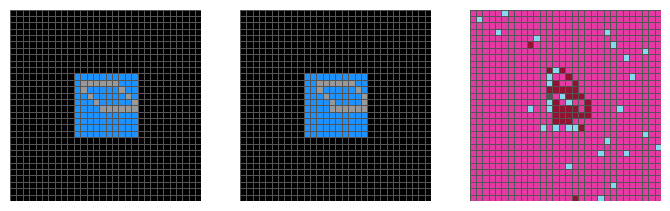

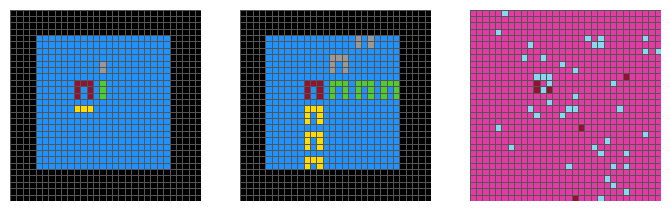

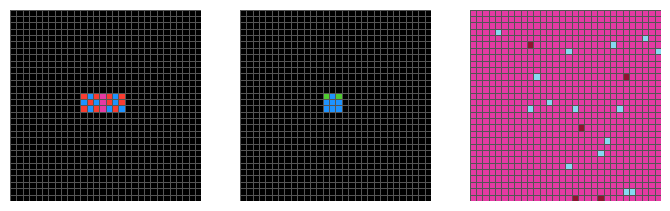

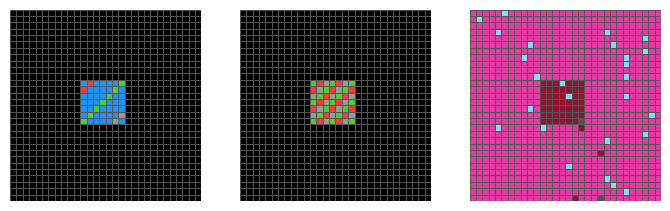

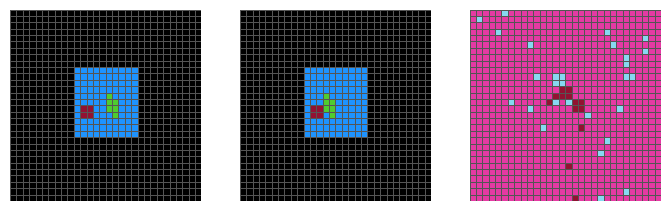

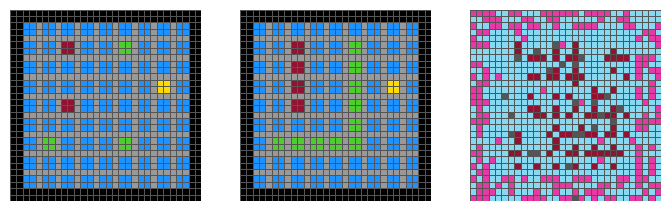

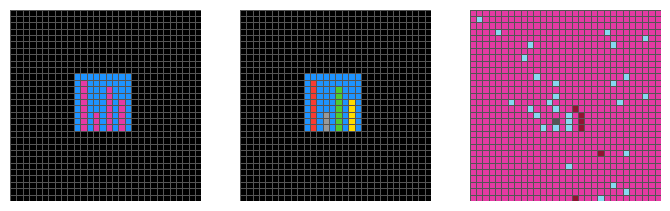

Epoch 8/25, Loss: 5.325261400296138, Accuracy: 0.3017363071710898%
Epoch 9/25


Validation: 100%|██████████| 21/21 [01:40<00:00,  4.79s/it]


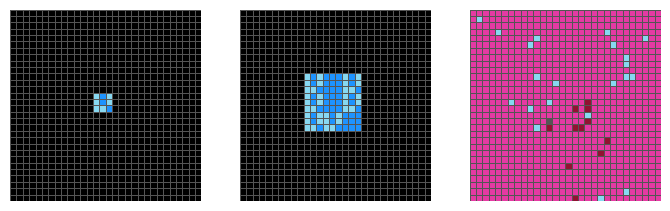

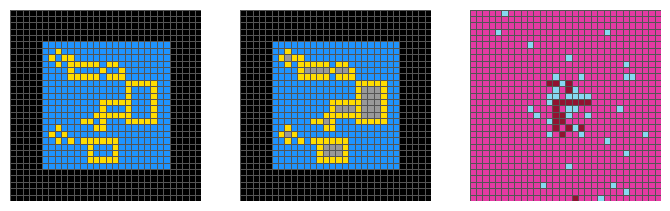

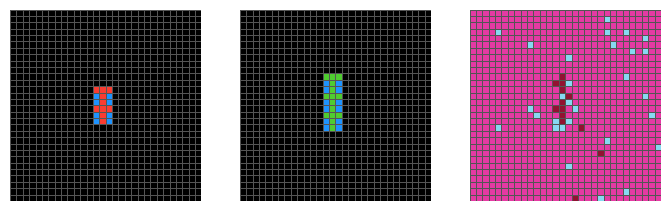

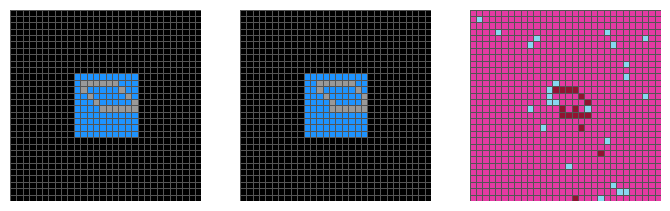

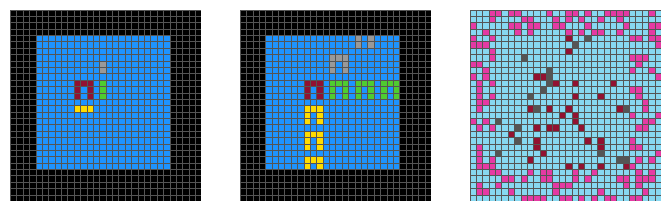

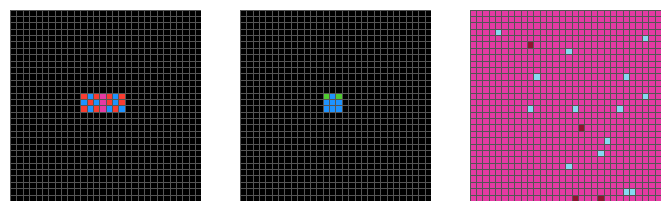

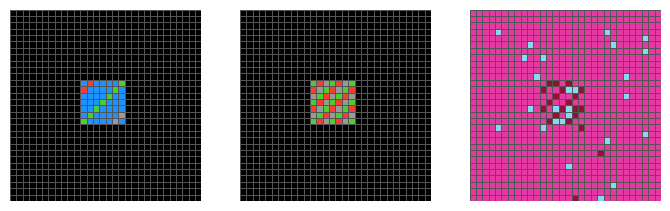

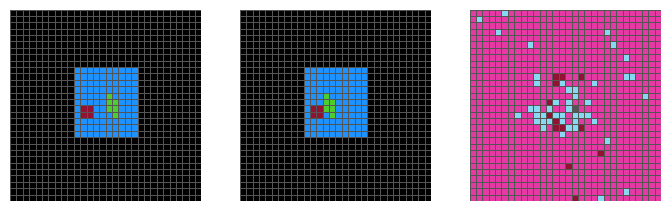

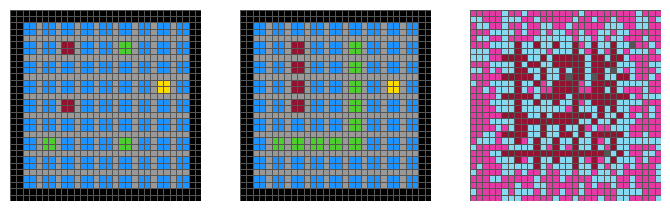

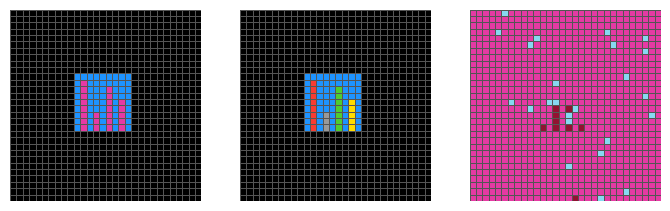

Epoch 9/25, Loss: 5.317990912840917, Accuracy: 0.3652597402597403%
Epoch 10/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.83s/it]


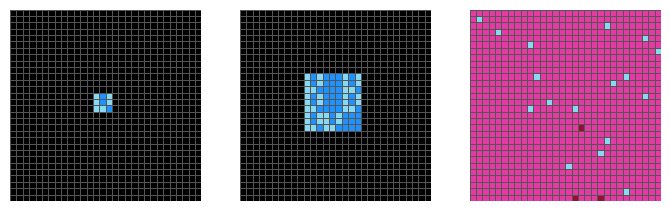

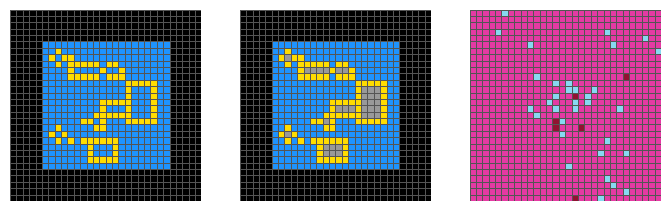

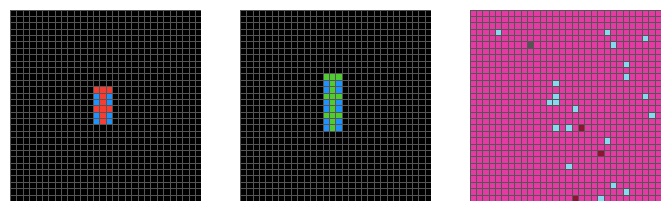

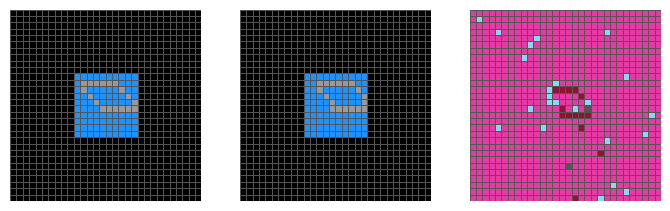

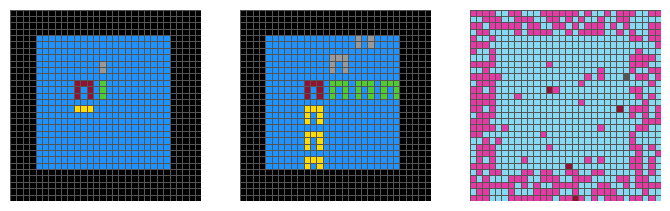

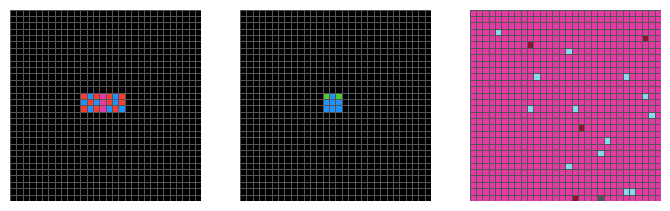

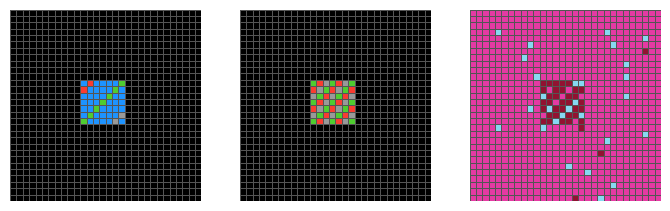

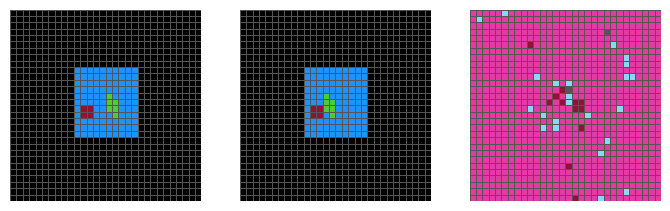

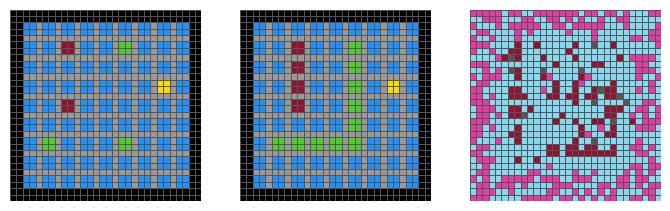

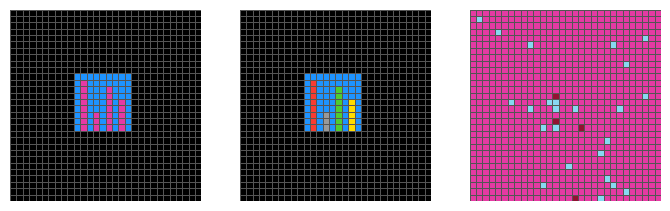

Epoch 10/25, Loss: 5.373066700421846, Accuracy: 0.5752399774138904%
Epoch 11/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.82s/it]


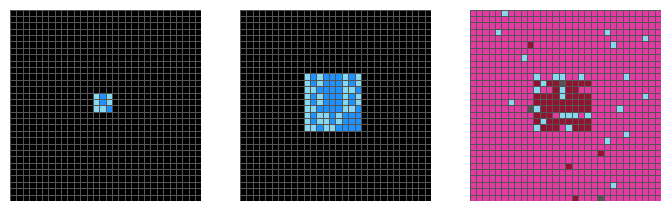

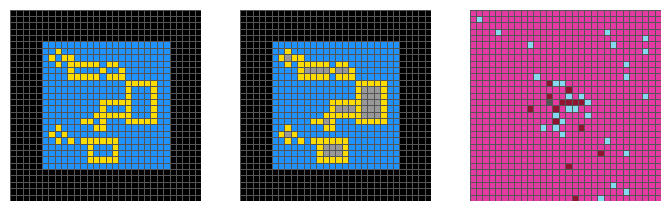

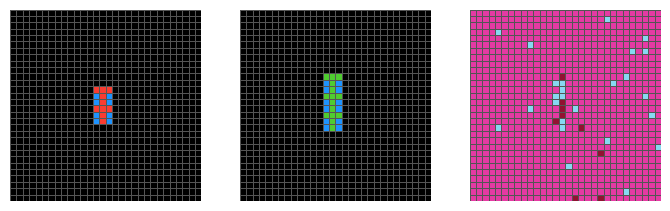

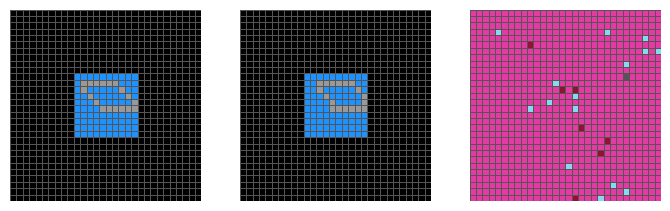

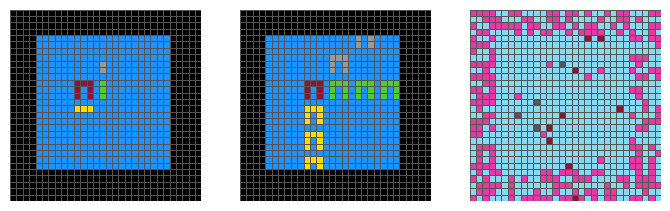

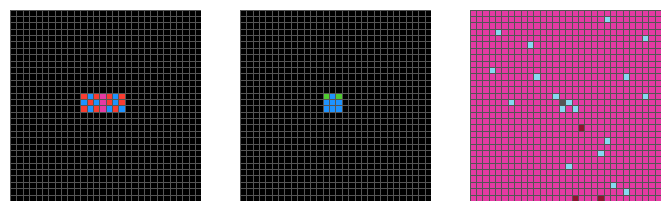

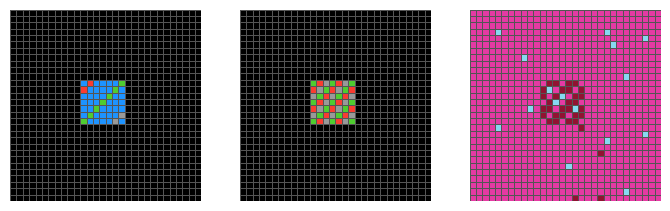

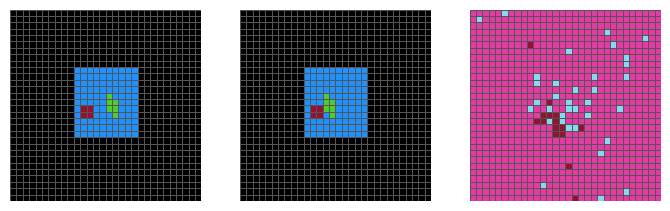

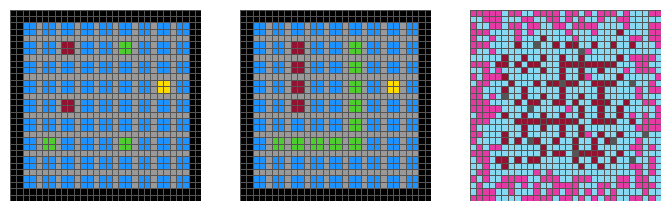

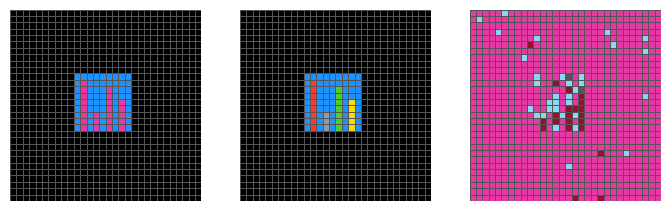

Epoch 11/25, Loss: 5.419208441216212, Accuracy: 0.44466403162055335%
Epoch 12/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.84s/it]


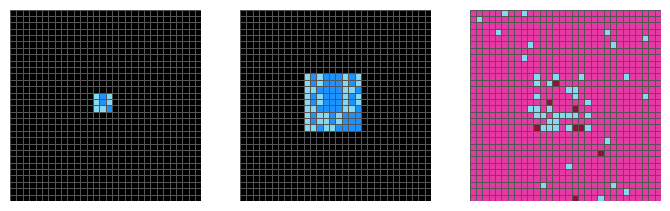

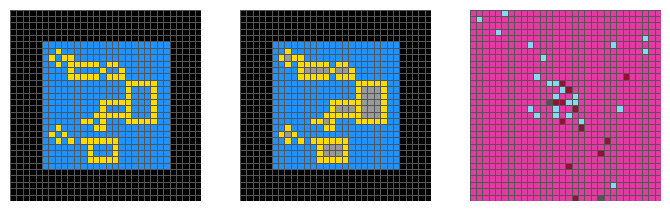

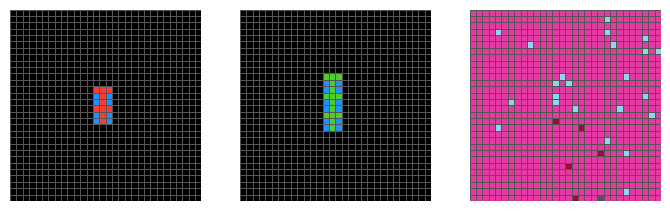

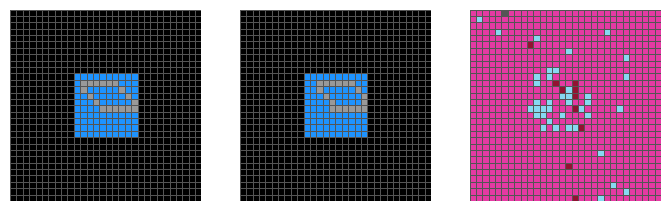

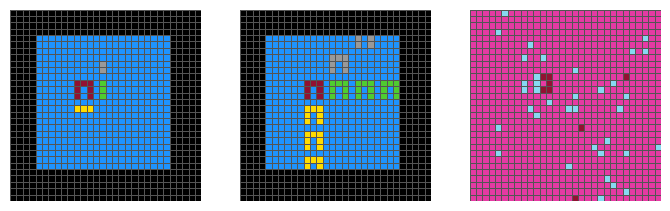

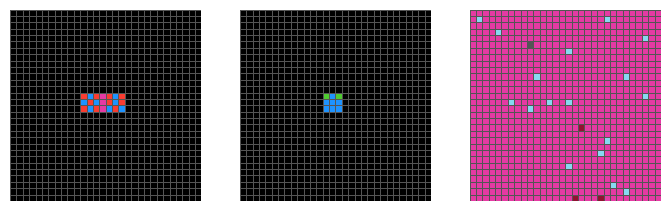

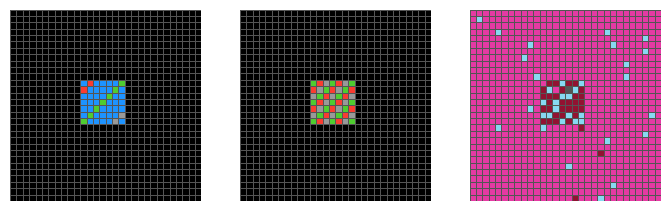

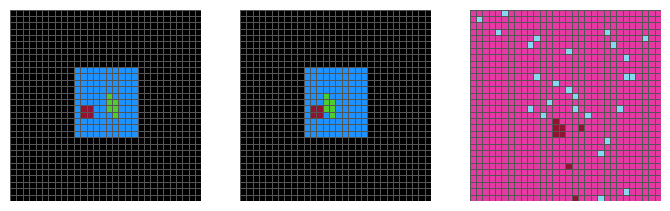

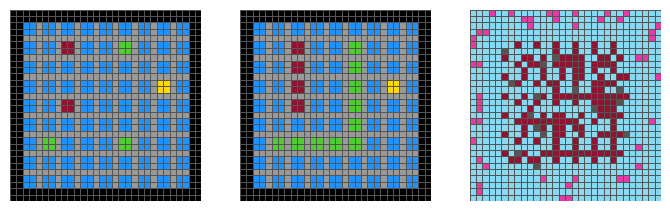

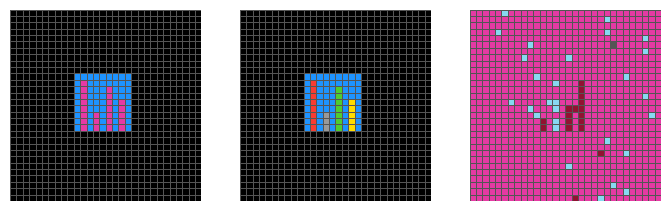

Epoch 12/25, Loss: 5.370381832122803, Accuracy: 0.3652597402597403%
Epoch 13/25


Validation: 100%|██████████| 21/21 [01:41<00:00,  4.84s/it]


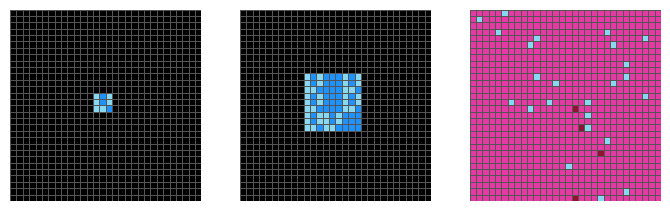

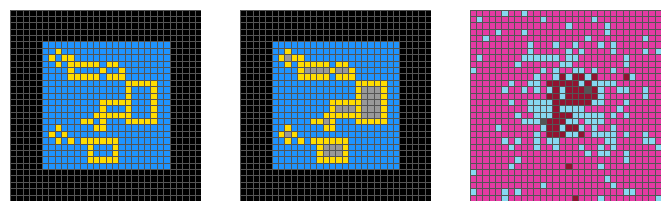

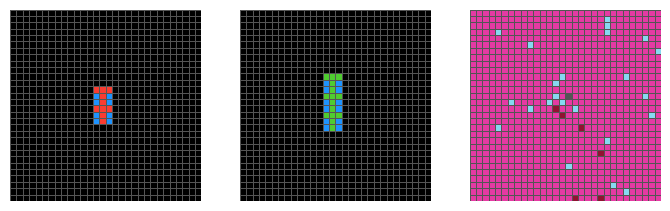

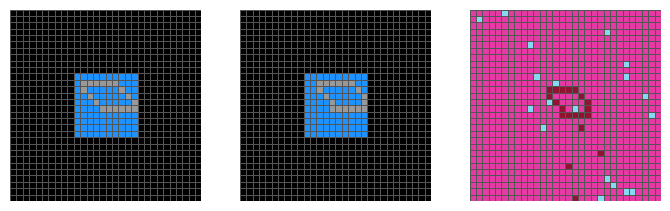

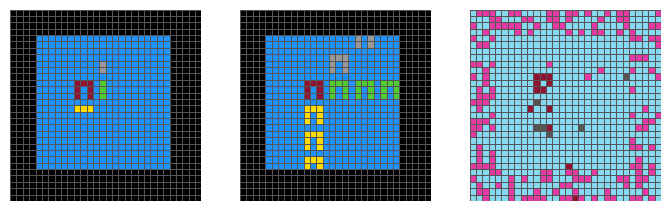

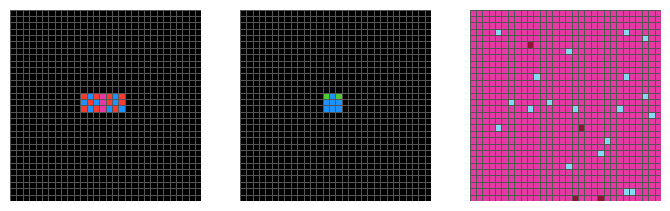

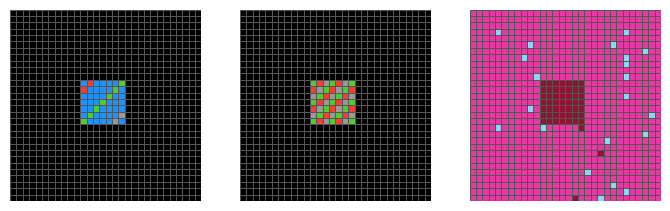

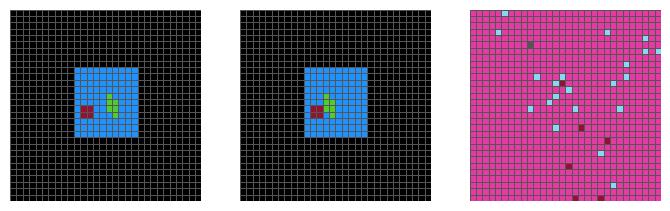

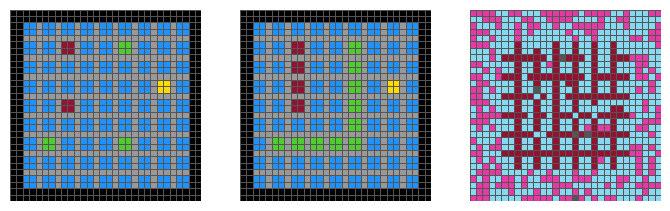

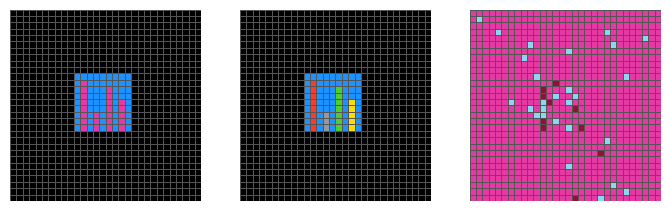

Epoch 13/25, Loss: 5.359815047910581, Accuracy: 0.23644833427442122%
Epoch 14/25


Validation: 100%|██████████| 21/21 [01:37<00:00,  4.64s/it]


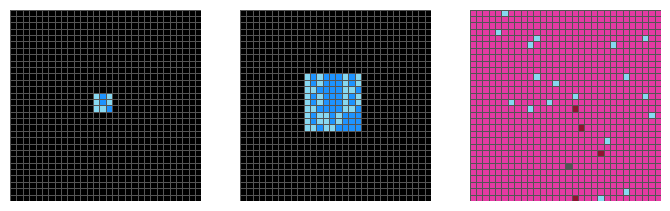

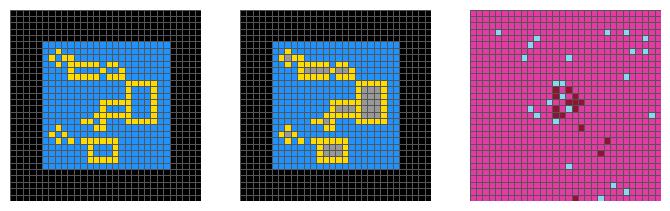

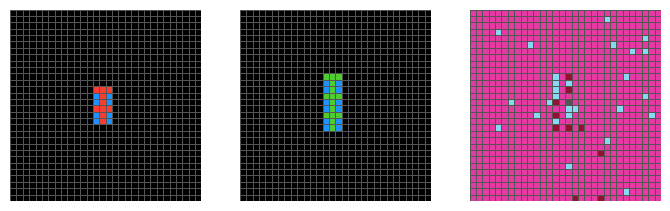

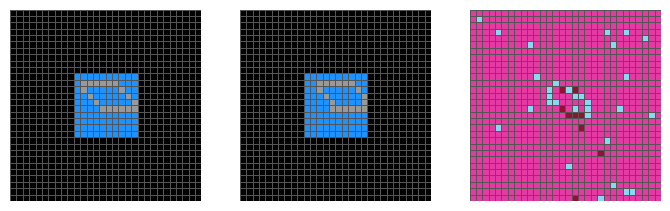

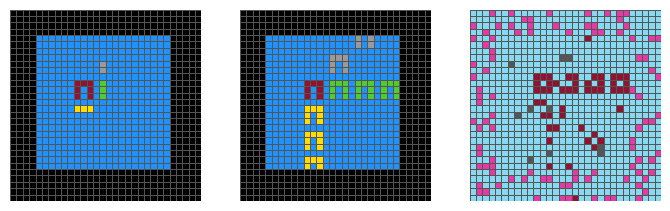

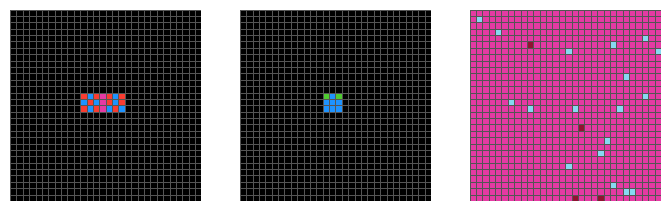

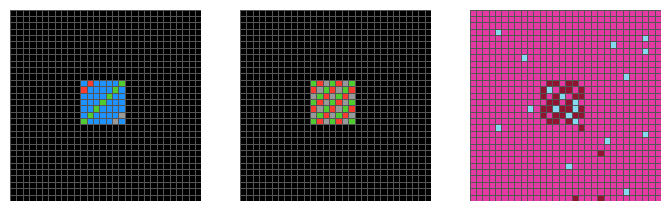

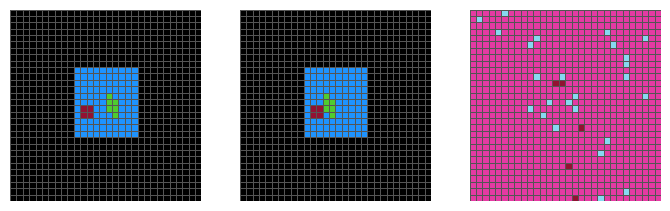

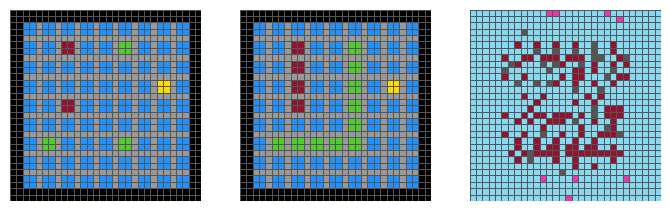

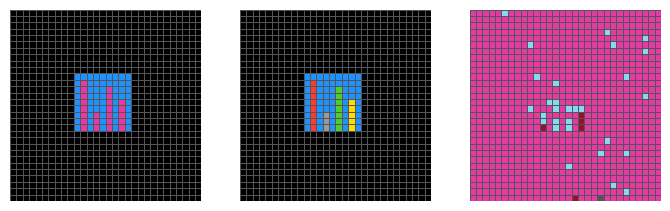

Epoch 14/25, Loss: 5.3700801357626915, Accuracy: 0.5822981366459627%
Epoch 15/25


Validation: 100%|██████████| 21/21 [01:37<00:00,  4.66s/it]


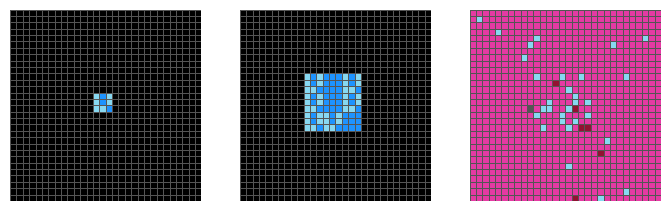

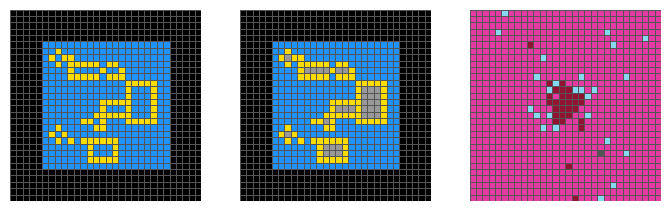

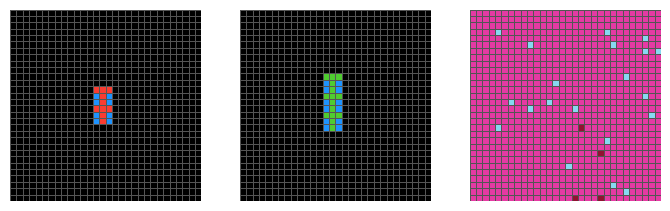

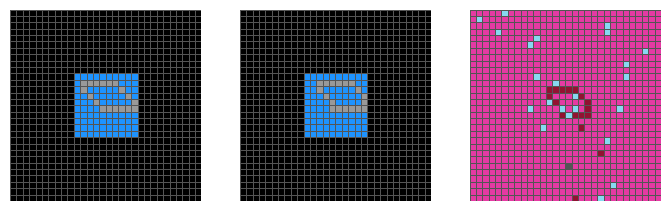

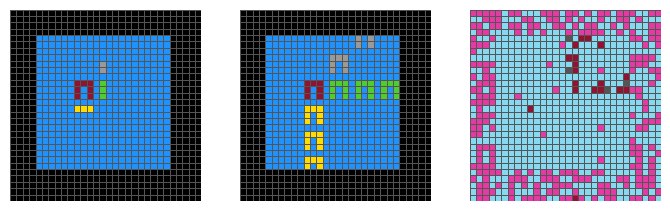

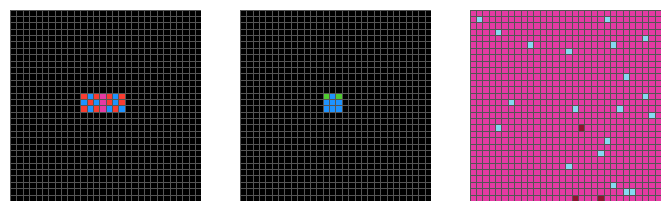

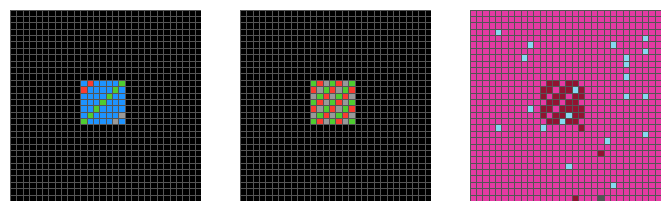

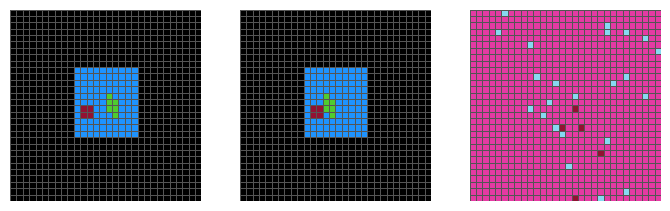

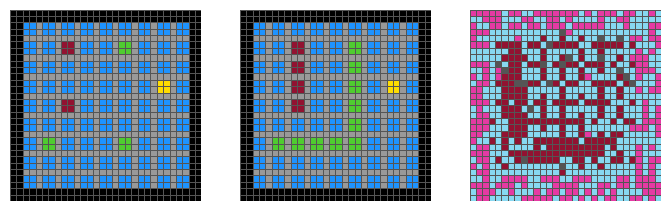

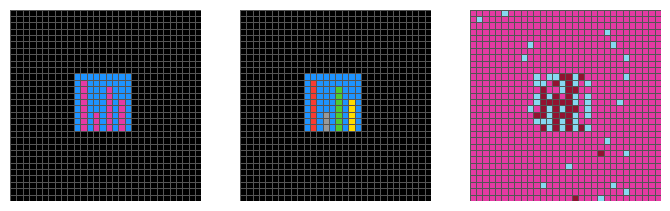

Epoch 15/25, Loss: 5.382312540824596, Accuracy: 0.16057312252964426%
Epoch 16/25


Validation: 100%|██████████| 21/21 [01:38<00:00,  4.71s/it]


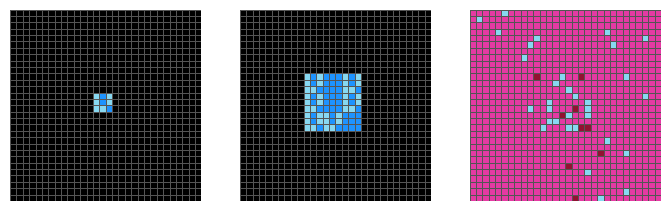

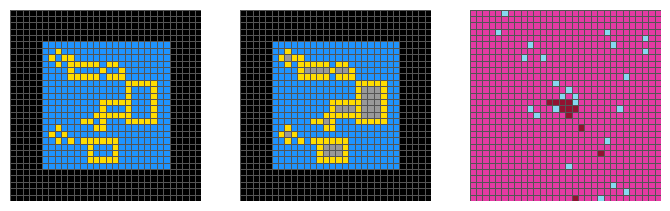

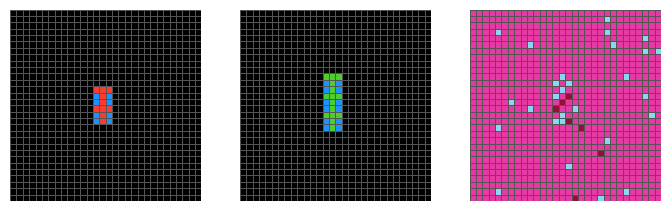

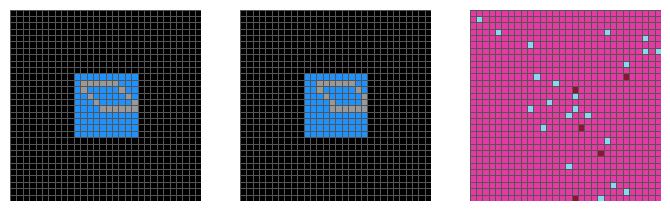

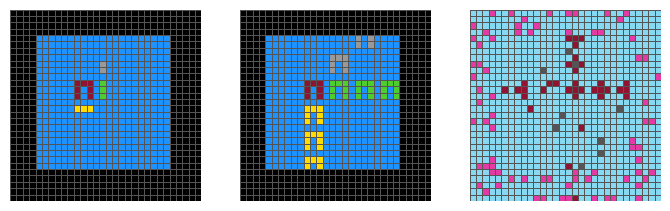

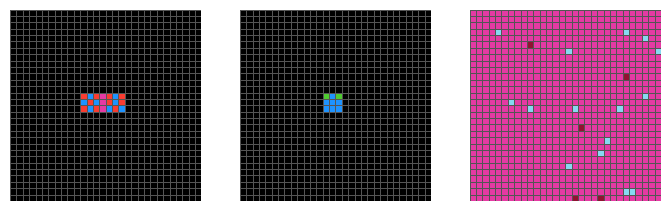

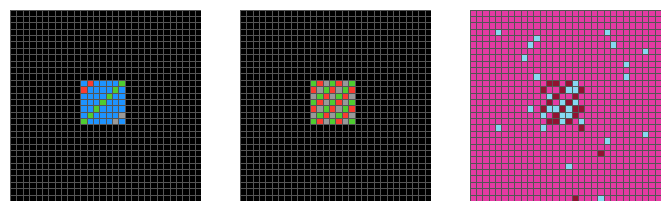

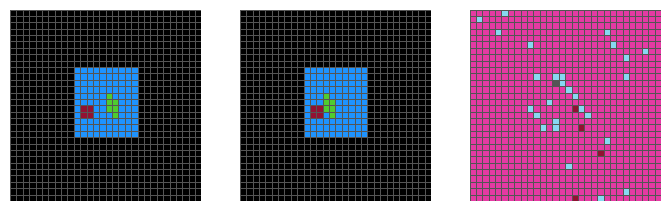

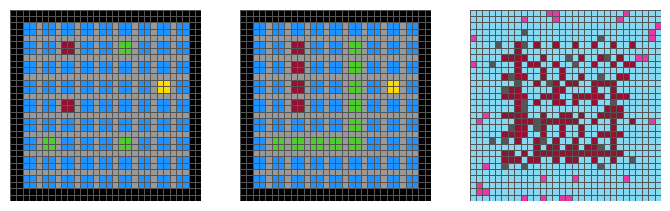

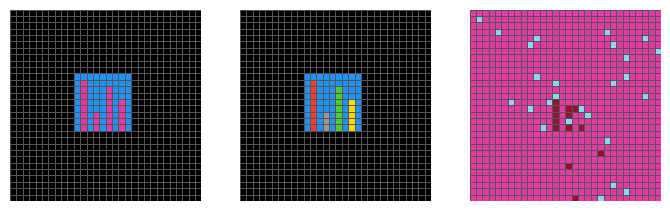

Epoch 16/25, Loss: 5.371931282946696, Accuracy: 0.25938735177865613%
Epoch 17/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.72s/it]


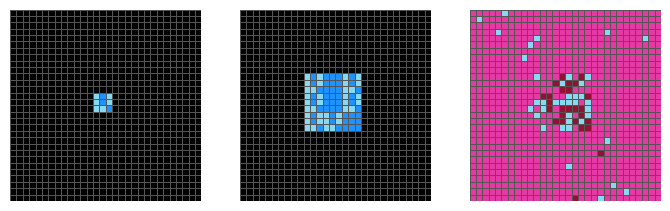

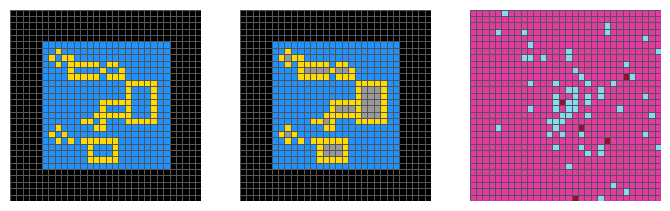

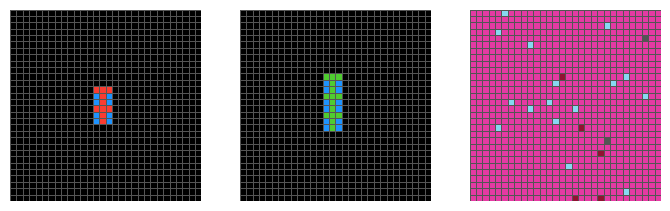

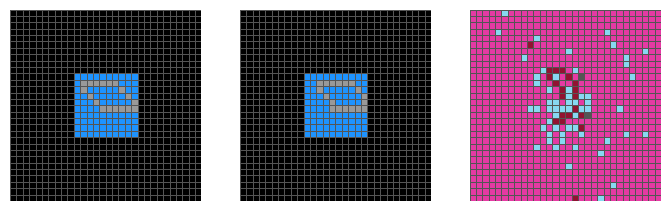

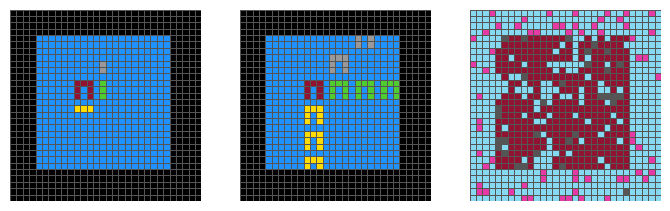

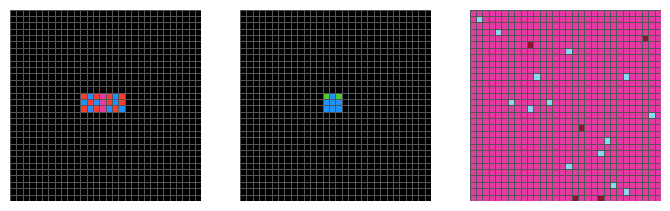

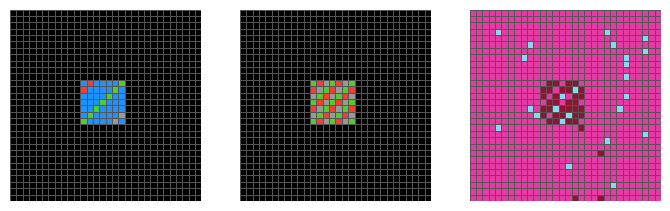

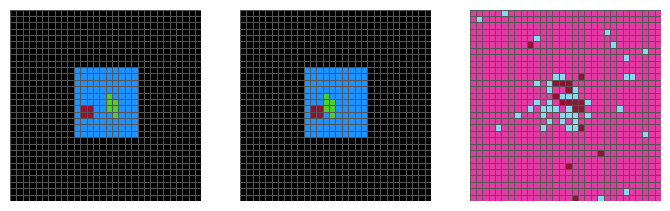

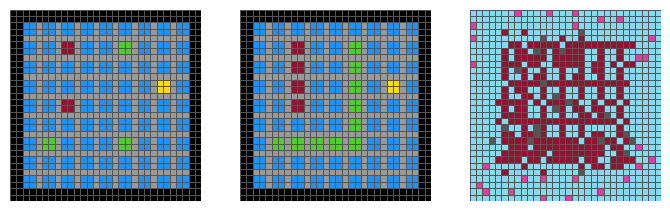

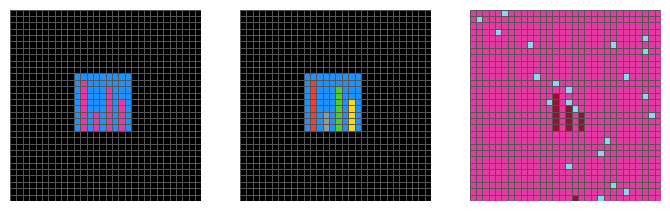

Epoch 17/25, Loss: 5.3112725879137335, Accuracy: 0.3705533596837945%
Epoch 18/25


Validation: 100%|██████████| 21/21 [01:40<00:00,  4.78s/it]


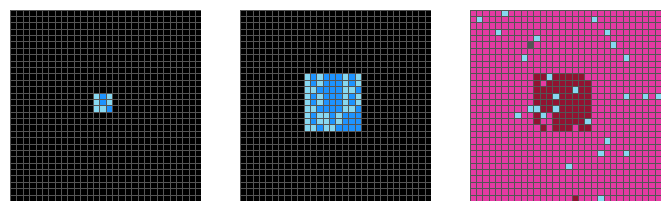

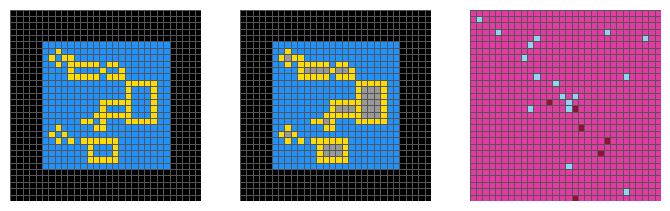

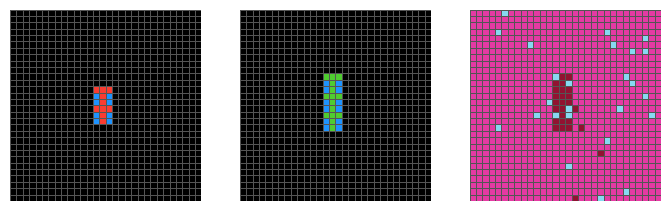

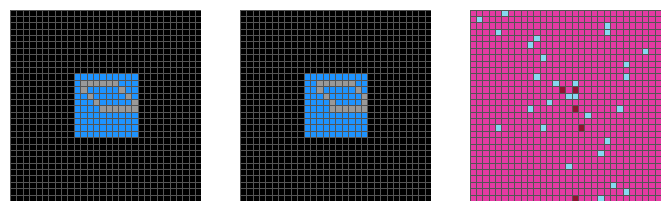

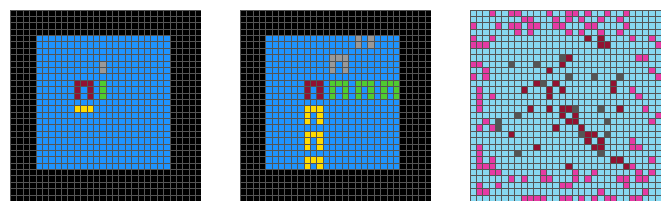

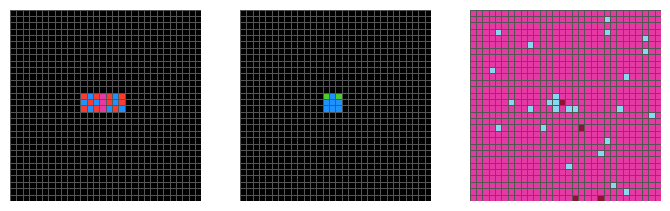

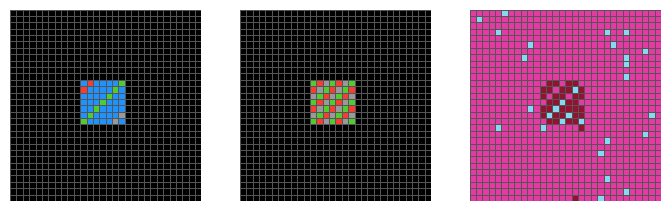

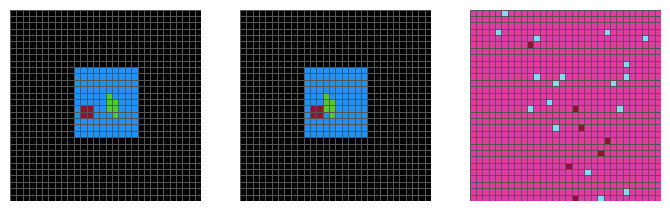

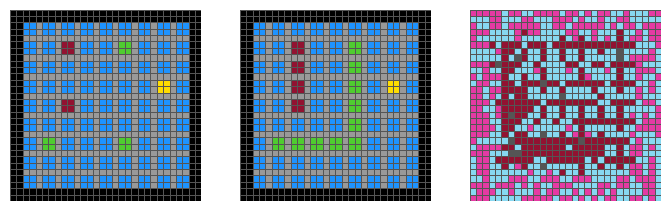

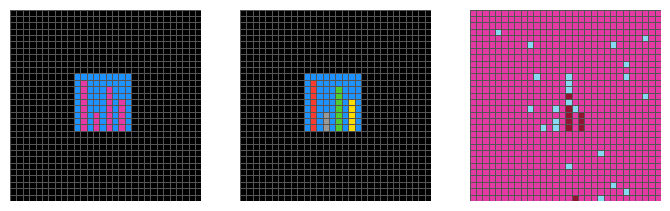

Epoch 18/25, Loss: 5.313616221340803, Accuracy: 0.49054206662902317%
Epoch 19/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.72s/it]


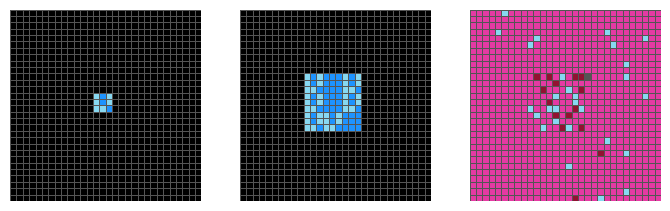

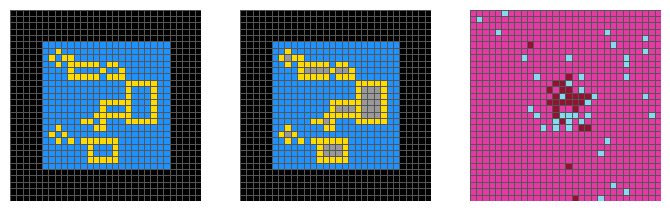

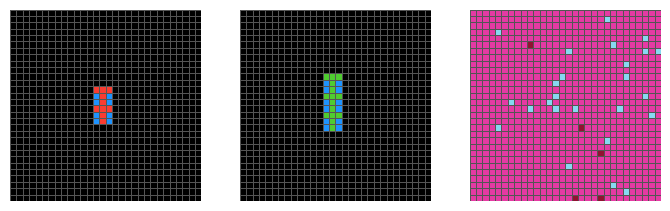

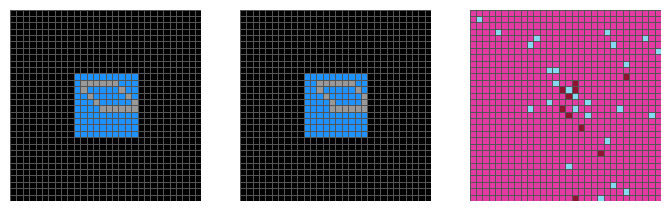

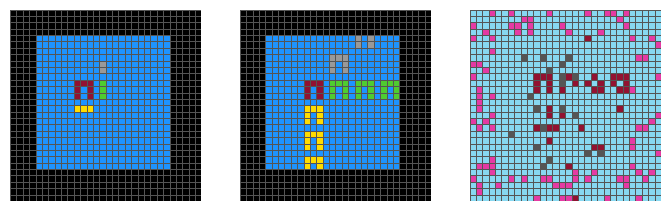

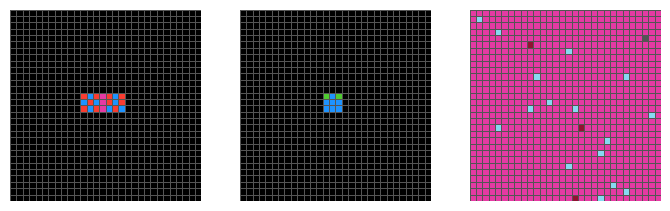

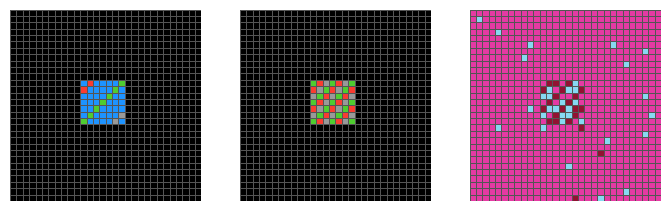

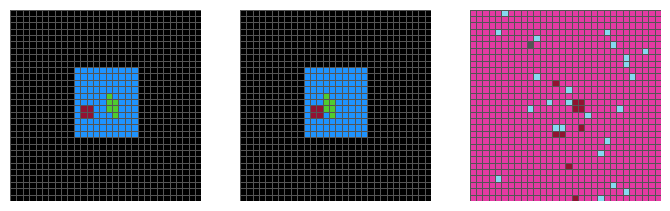

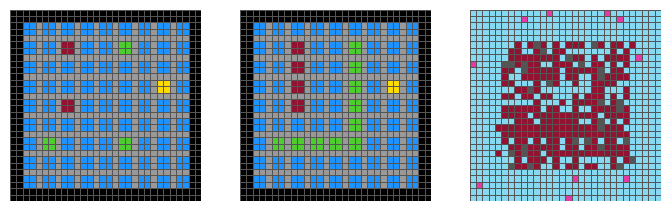

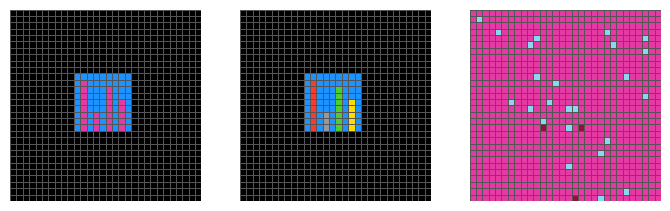

Epoch 19/25, Loss: 5.331124507463896, Accuracy: 0.40055053642010163%
Epoch 20/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.73s/it]


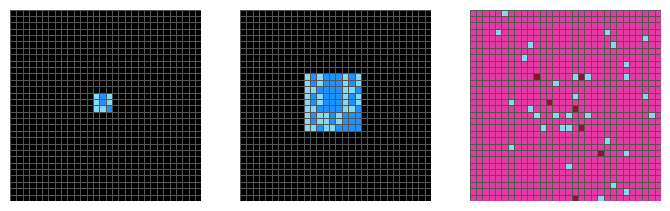

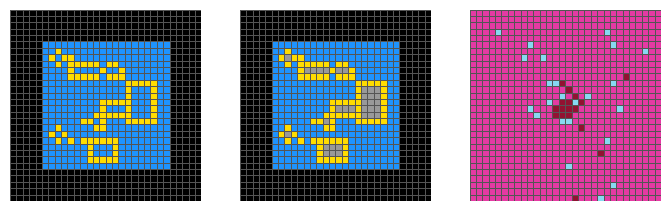

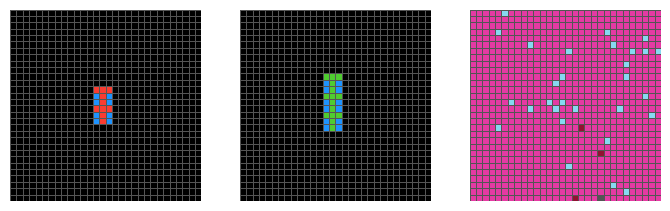

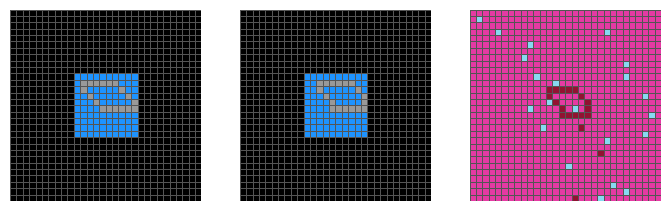

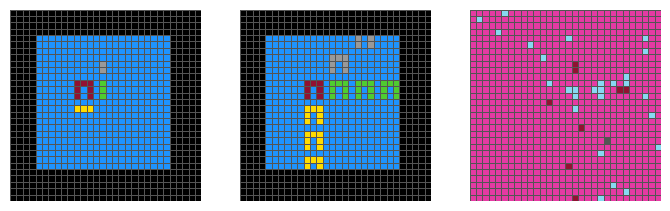

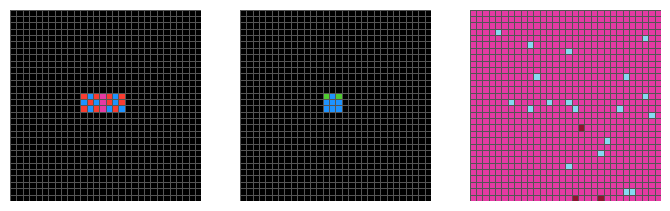

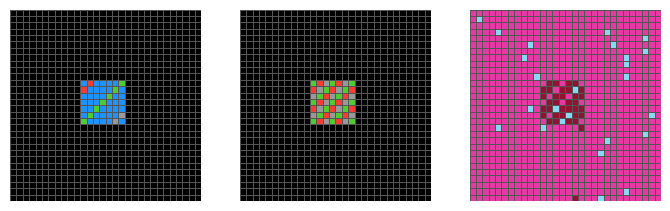

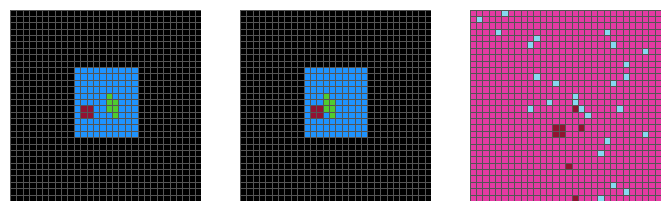

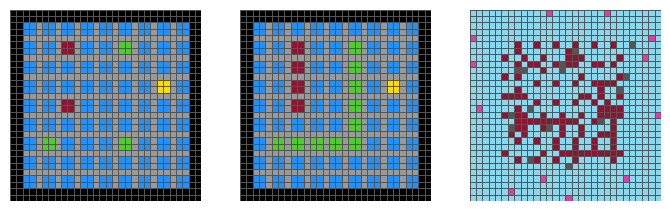

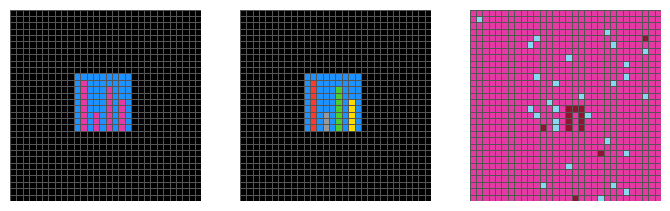

Epoch 20/25, Loss: 5.421313764957281, Accuracy: 0.718167701863354%
Epoch 21/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.74s/it]


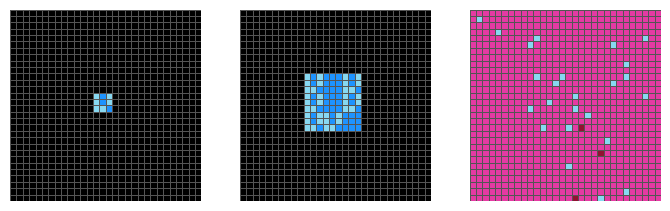

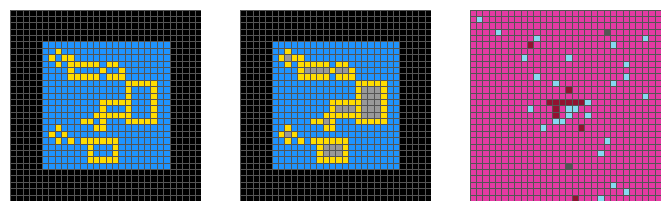

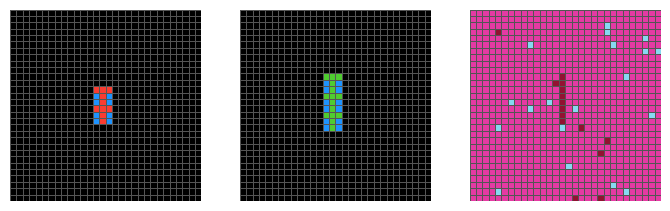

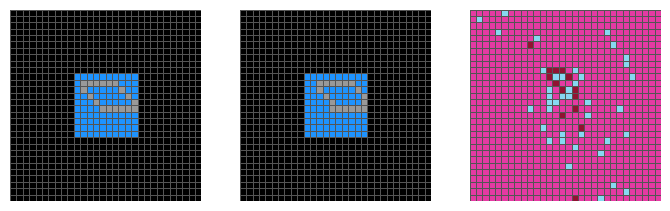

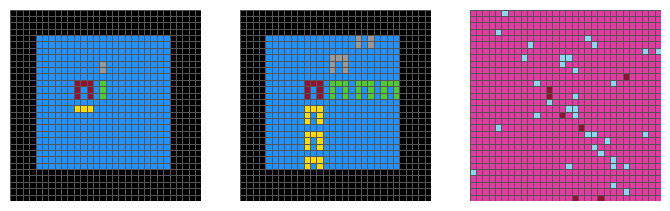

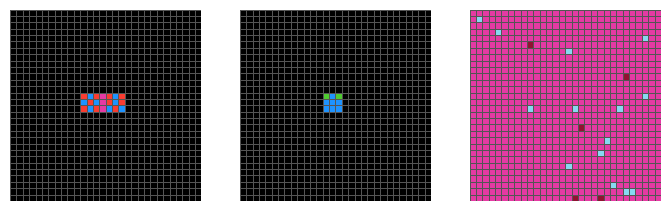

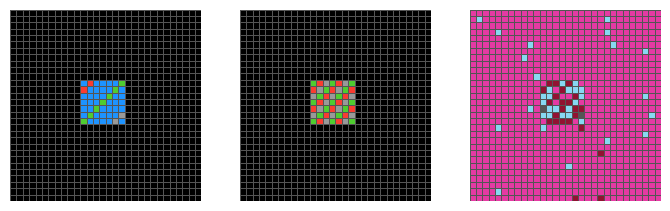

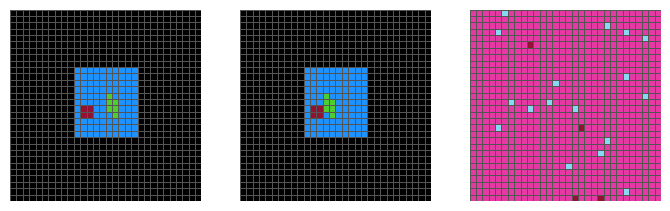

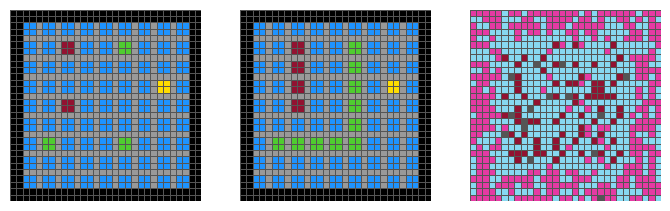

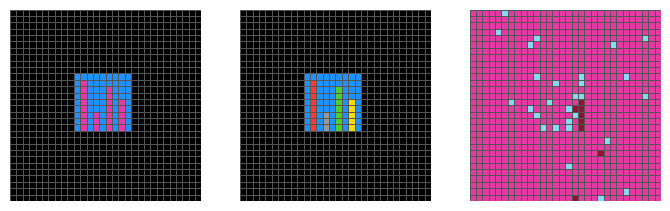

Epoch 21/25, Loss: 5.363665195611807, Accuracy: 0.2770327498588368%
Epoch 22/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.74s/it]


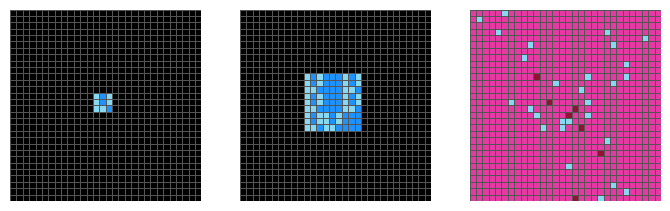

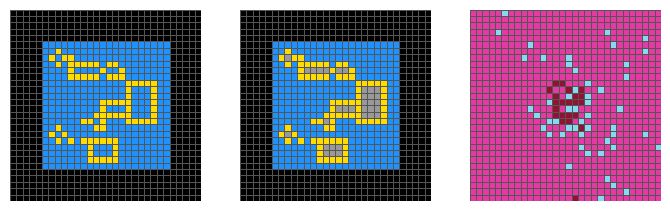

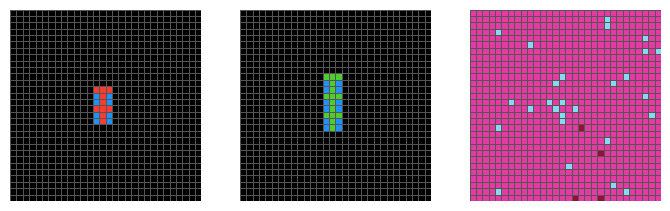

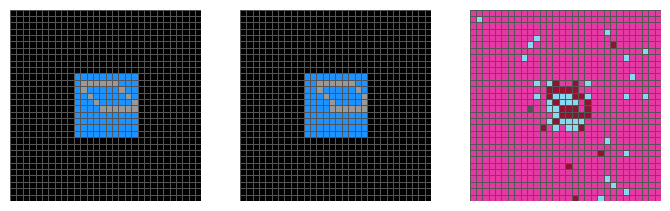

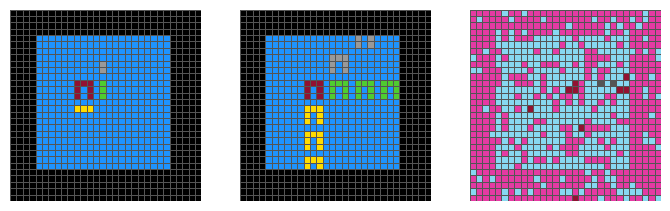

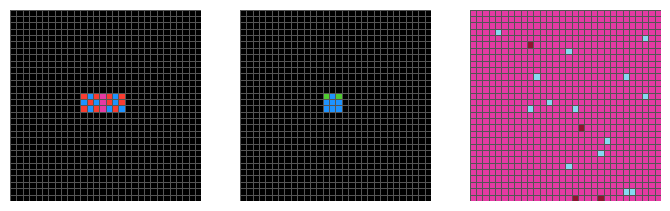

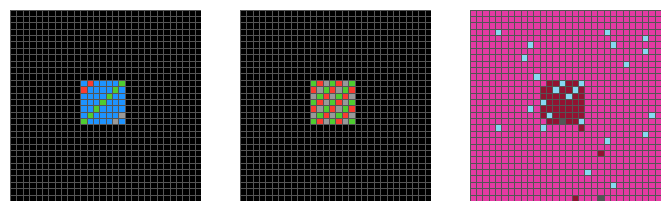

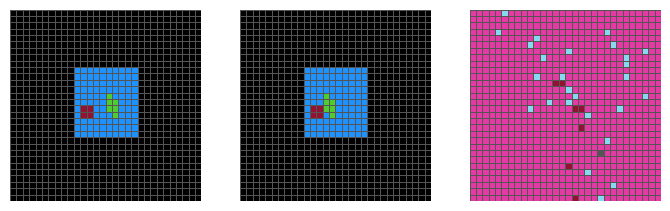

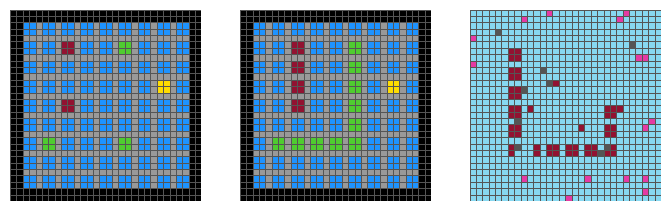

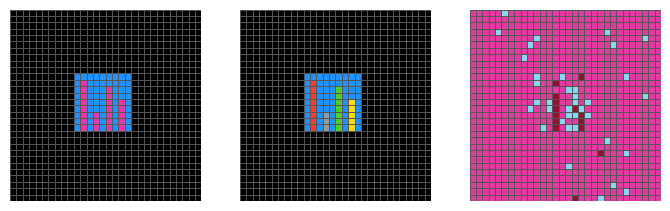

Epoch 22/25, Loss: 5.34214255385674, Accuracy: 0.7781620553359684%
Epoch 23/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.74s/it]


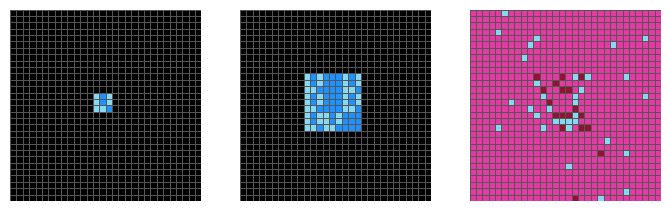

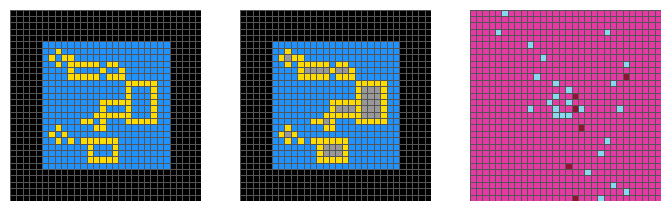

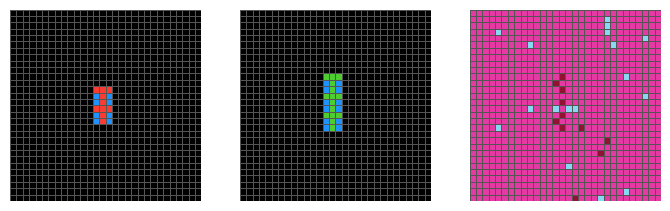

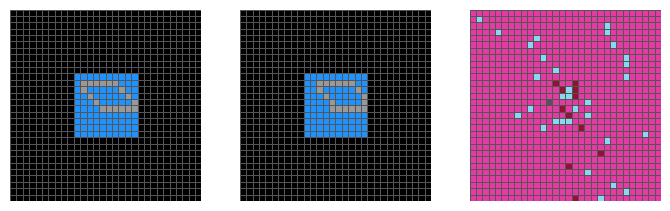

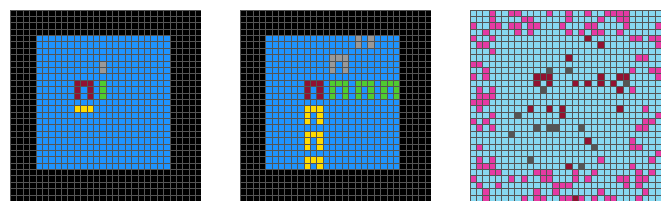

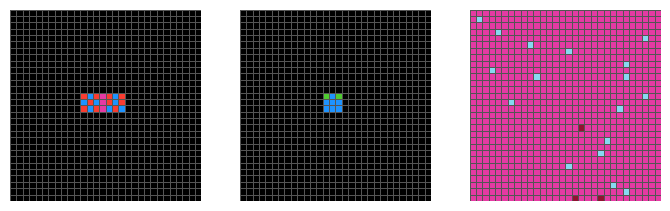

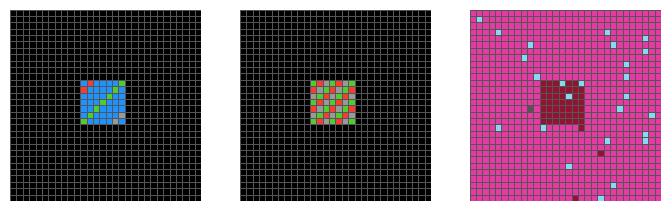

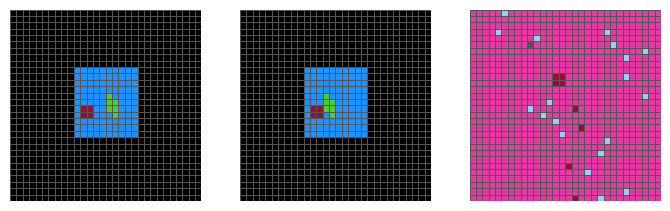

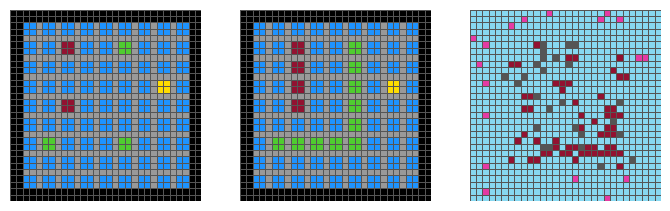

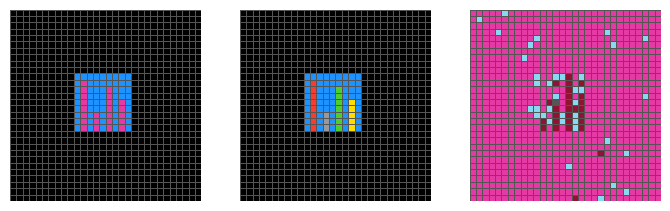

Epoch 23/25, Loss: 5.319653362035751, Accuracy: 0.35467250141163187%
Epoch 24/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.76s/it]


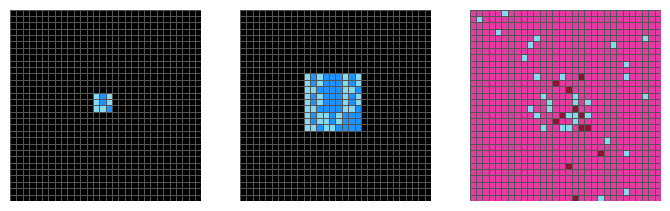

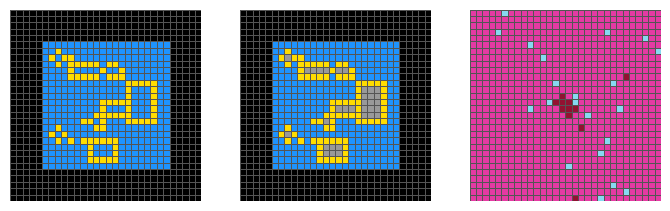

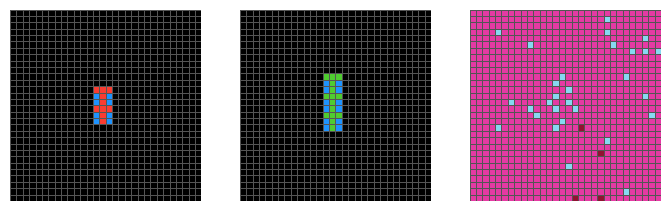

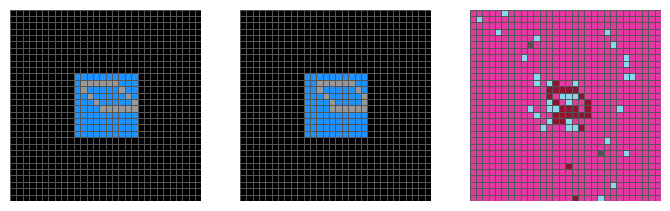

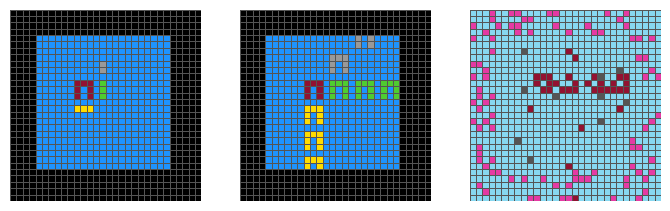

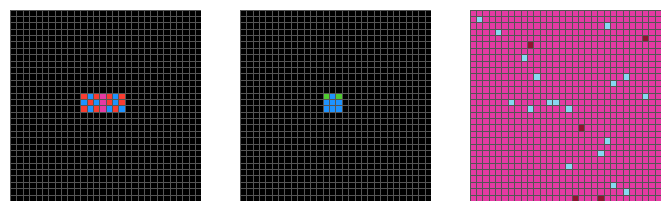

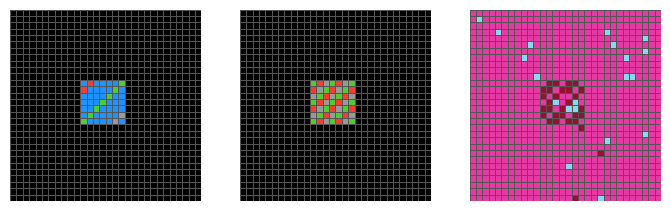

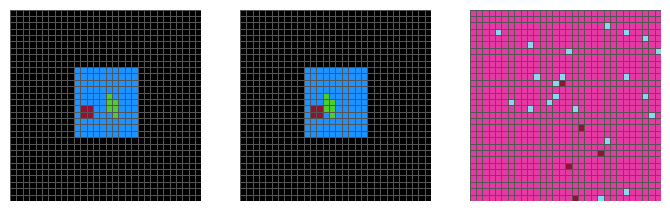

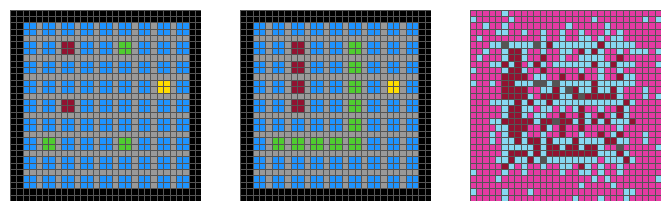

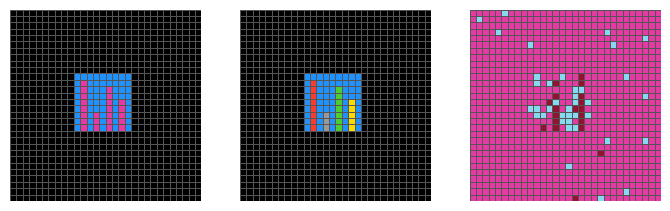

Epoch 24/25, Loss: 5.347552723609484, Accuracy: 0.5187747035573123%
Epoch 25/25


Validation: 100%|██████████| 21/21 [01:39<00:00,  4.76s/it]


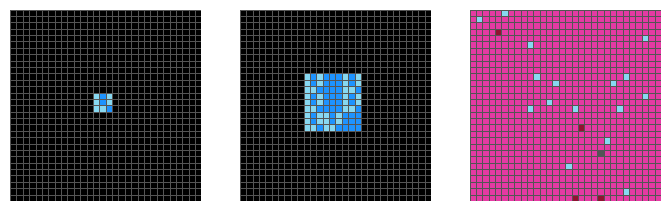

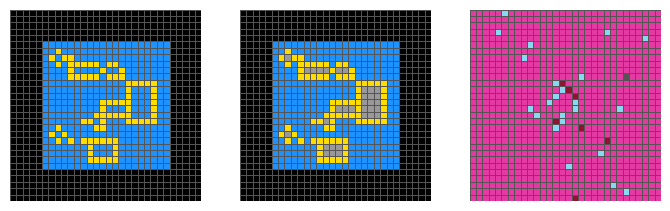

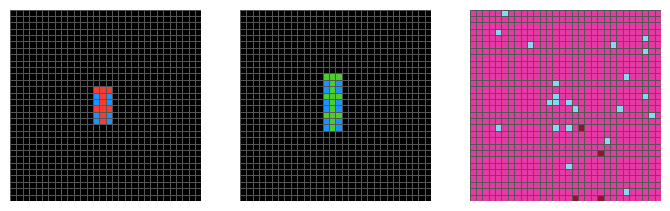

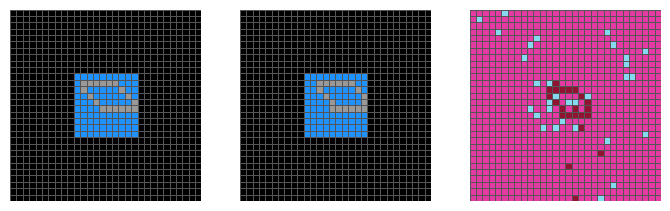

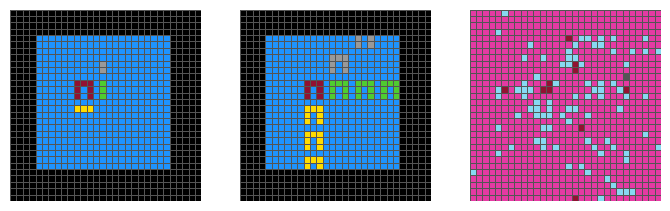

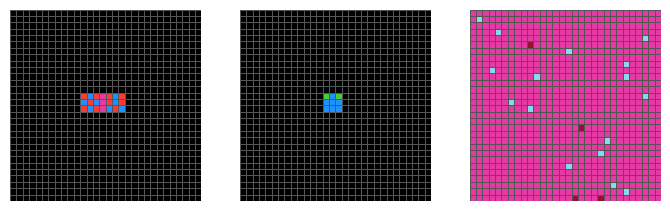

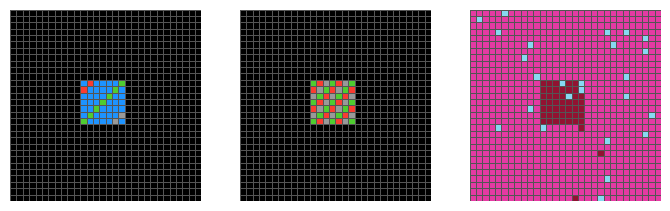

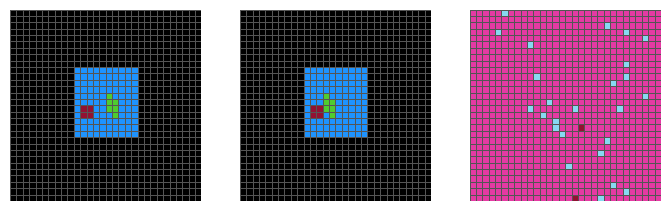

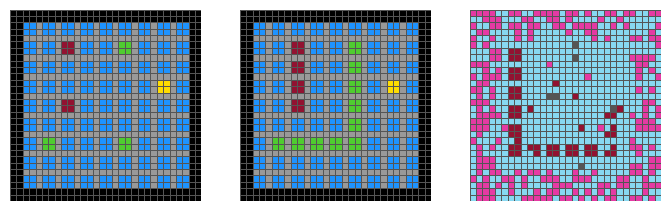

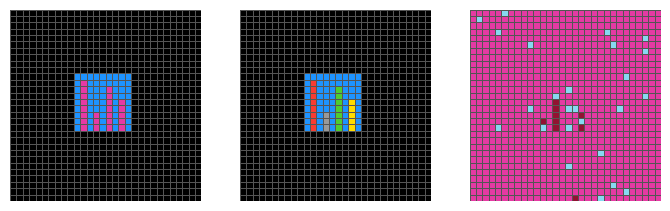

Epoch 25/25, Loss: 5.336683864776905, Accuracy: 0.31938170525127046%


In [ ]:
from bw_net_maml import BWNet_MAML
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import gc
import random

def remapping_output(tensor):
    # 범위별 매핑 딕셔너리
    remapping = {
        (1, 10): -1,
        (11, 20): -2,
        (21, 30): -3,
        (31, 40): -4,
        (41, 50): -5,
        (51, 60): -6,
        (61, 70): -7,
        (71, 80): -8,
        (81, 90): -9,
        (91, 100): -10
    }
    
    temp_tensor = tensor.clone()

    # 각 범위에 대해 매핑 수행
    for value_range, new_value in remapping.items():
        mask = (temp_tensor >= value_range[0]) & (temp_tensor <= value_range[1])
        temp_tensor[mask] = new_value  # 임시로 기존 값에 음수를 취해 중복을 피함
    for value_range, new_value in remapping.items():
        temp_tensor[temp_tensor == new_value] = -1*new_value  # 음수로 변환된 값을 다시 양수로 변환

    return temp_tensor


colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

def inner_loop_update(model, example_input, example_output, inner_optimizer, criterion, steps):
    for _ in range(steps):
        model.train()
        prediction = model(example_input)
        loss = criterion(prediction, example_output)

        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()


def criterion(y_pred, y):
    y = y.long().squeeze(1)
    ce = F.cross_entropy(y_pred, y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 25,
    'task_numbers': 20, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 3, #equal to inner model batch size
    'inner_lr': 0.001,
    'outer_lr': 0.001,
    'embed_size': 1,
    
}

# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device  
print(f'Using {device} device')


train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

outer_model = BWNet_MAML(embed_size=kwargs['embed_size']).to(device)
outer_optimizer= optim.AdamW(outer_model.parameters(),lr=kwargs['outer_lr'])

for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    total_loss = 0
    # total_samples = 0
    outer_model.train()

    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]
        
        # total_samples += input_tensor.shape[0]
        task_losses = []
        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_optimizer = optim.AdamW(inner_model.parameters(),lr=kwargs['inner_lr'])
            
            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                              inner_optimizer, criterion, kwargs['example_data_num'])
            
        
            inner_model.eval()
            task_prediction = inner_model(input_tensor[task_number])
            task_loss = criterion(task_prediction, output_tensor[task_number])
            task_losses.append(task_loss)
        
        meta_loss = torch.stack(task_losses).mean()
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()
        
        del meta_loss, task_losses
        gc.collect()
        torch.cuda.empty_cache()
        

    del inner_optimizer
    torch.cuda.empty_cache()
    gc.collect()
    
    # Validation Loop
    outer_model.eval()
    validation_correct = 0
    validation_total_samples = 0
    total_loss = []
    visualization_samples = []
    for batch_idx, data in enumerate(tqdm(eval_loader, desc='Validation')):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_model.train()
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])

            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                            inner_optimizer, criterion, kwargs['example_data_num'])

            with torch.no_grad():
                inner_model.eval()
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                task_prediction = inner_model(task_input)
                task_loss = criterion(task_prediction, task_output)
                total_loss.append(task_loss.item())  # task_loss.item()을 리스트에 추가

                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)

                mask = task_output != 0
                correct_predictions = (prediction_class == task_output) & mask
                validation_correct += correct_predictions.sum().item()
                validation_total_samples += mask.sum().item()
            
            if len(visualization_samples) < 10:  # 예를 들어 10개의 샘플만 저장
                        visualization_samples.append((
                            remapping_output(task_input.cpu()),
                            remapping_output(task_output.cpu()),
                            remapping_output(prediction_class.cpu())
                        ))

            del inner_model, inner_optimizer, task_input, task_output, task_prediction, mask, correct_predictions
            gc.collect()
            torch.cuda.empty_cache()

    if visualization_samples:
        for vis_input, vis_output, vis_prediction in visualization_samples:
            show_grid_side_by_side(vis_input, vis_output, vis_prediction)

            

    # 손실 값들의 평균 계산
    mean_loss = sum(total_loss) / len(total_loss) if total_loss else 0
    accuracy = 100 * validation_correct / validation_total_samples if validation_total_samples > 0 else 0
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {mean_loss}, Accuracy: {accuracy}%')
    torch.cuda.empty_cache()

Using cuda device
Epoch 1/100


Validation: 100%|██████████| 26/26 [01:15<00:00,  2.91s/it]


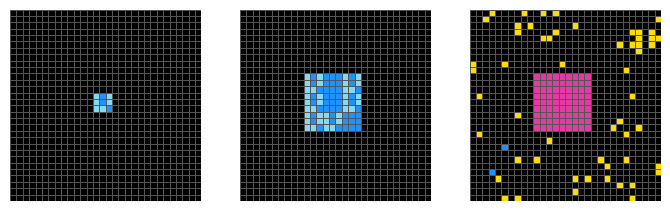

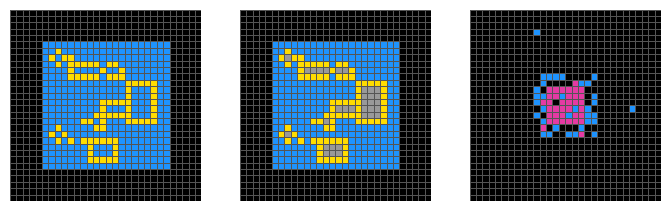

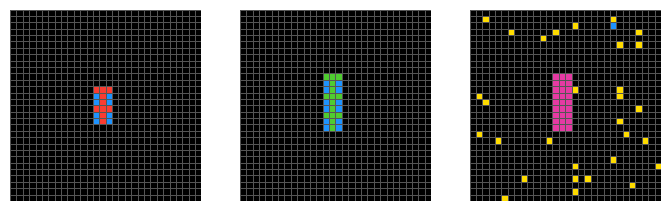

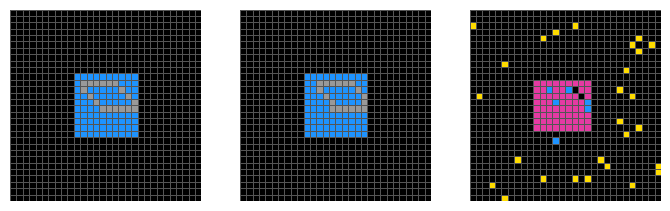

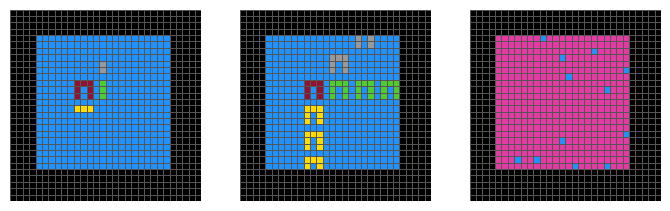

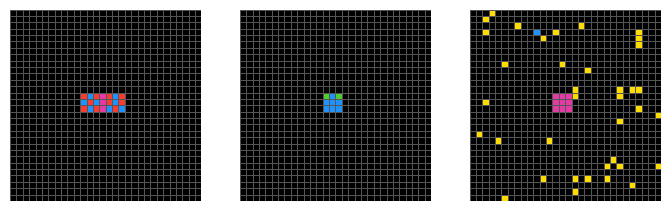

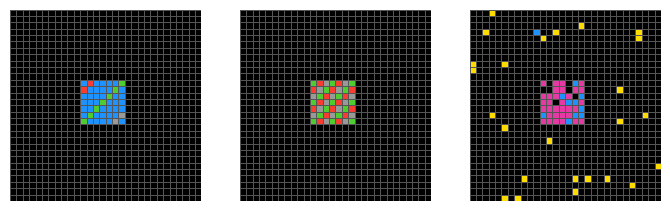

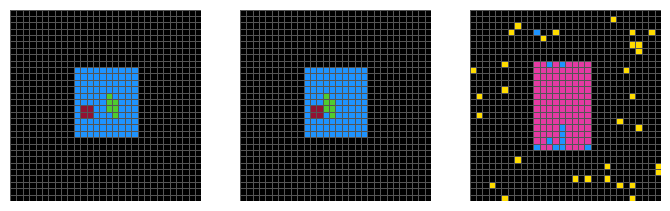

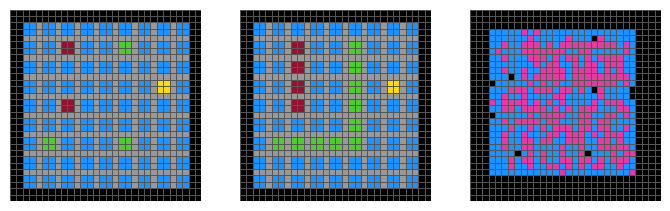

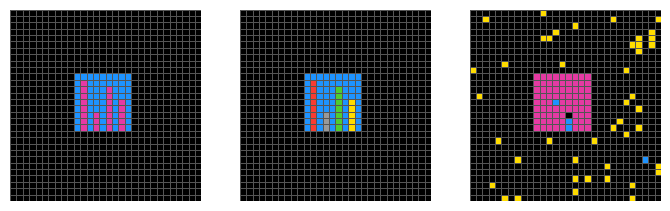

Epoch 1/100, Loss: 1.3885149796708272, Accuracy: 9.016798418972332%
Epoch 2/100


Validation: 100%|██████████| 26/26 [01:15<00:00,  2.91s/it]


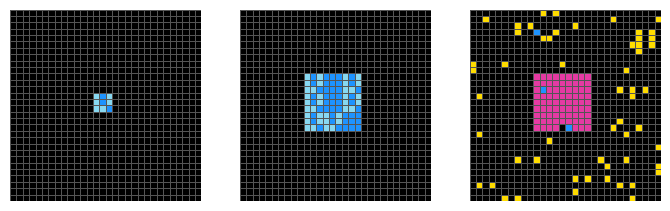

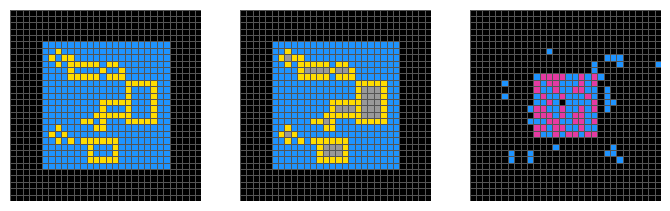

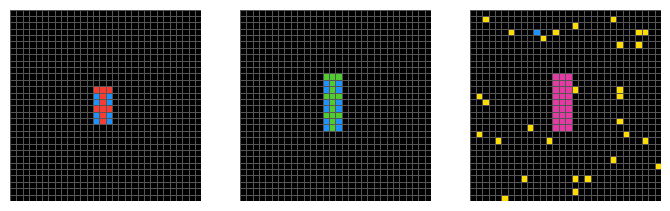

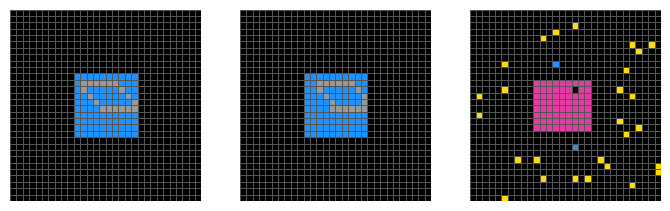

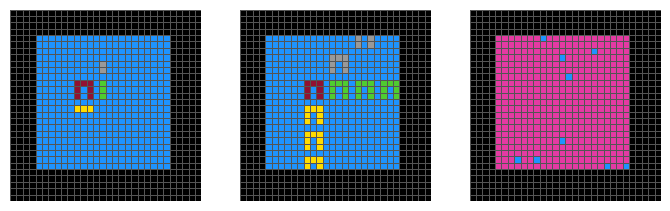

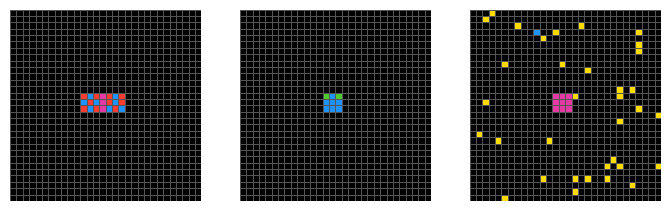

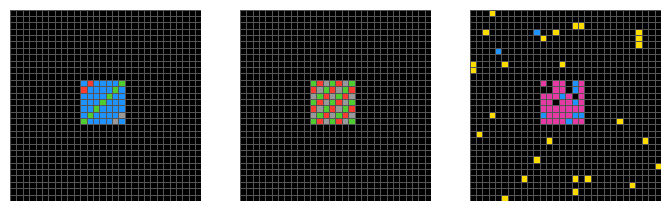

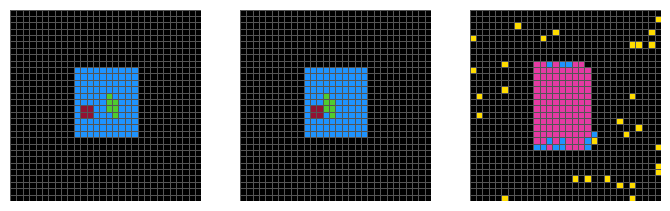

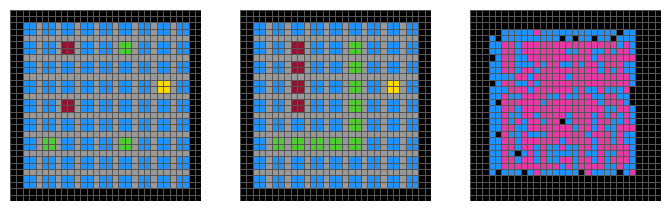

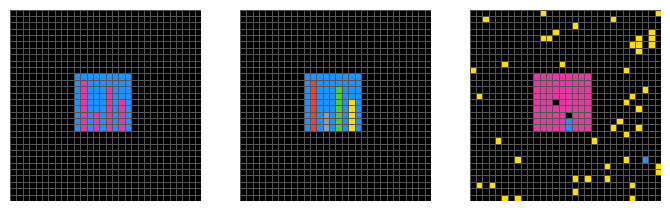

Epoch 2/100, Loss: 1.3925705977643912, Accuracy: 8.872106154714851%
Epoch 3/100


Validation: 100%|██████████| 26/26 [01:15<00:00,  2.89s/it]


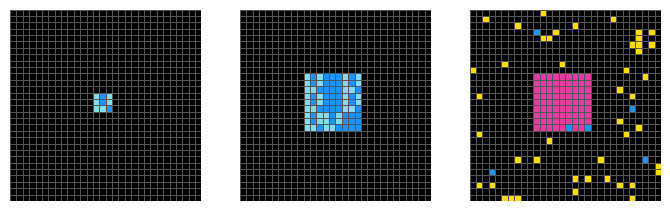

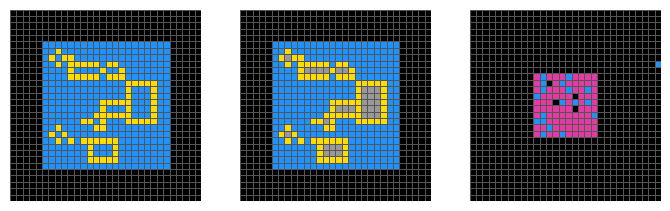

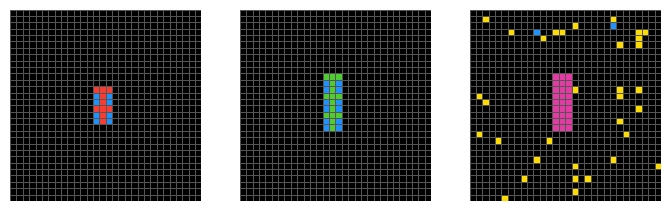

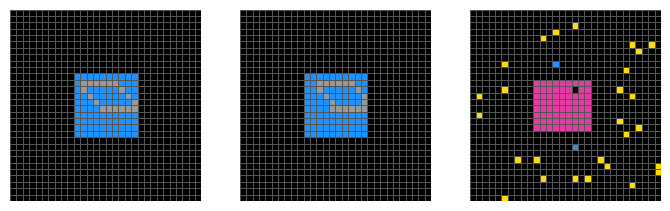

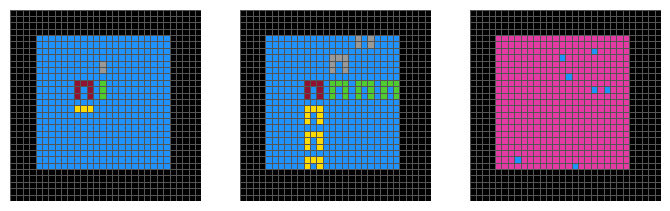

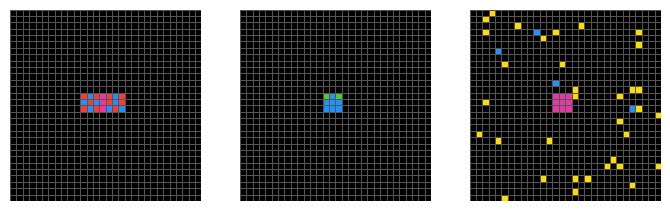

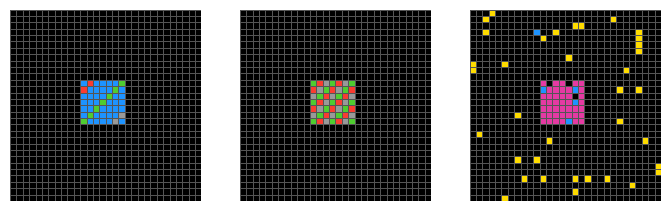

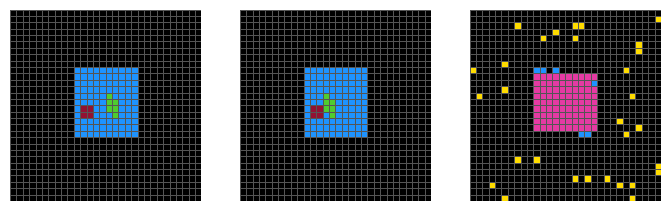

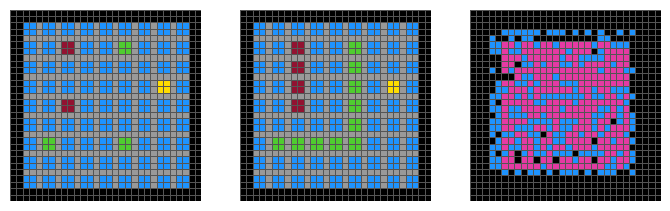

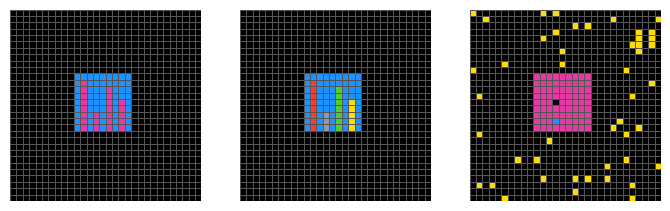

Epoch 3/100, Loss: 1.388962428873548, Accuracy: 8.842108977978544%
Epoch 4/100


Validation: 100%|██████████| 26/26 [01:14<00:00,  2.88s/it]


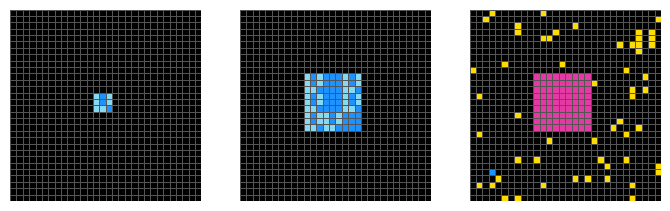

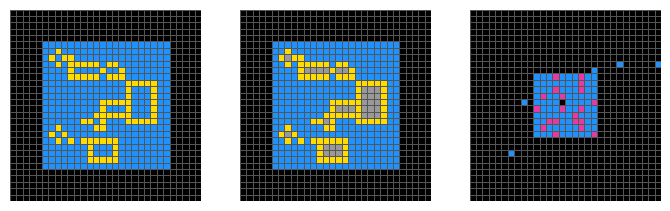

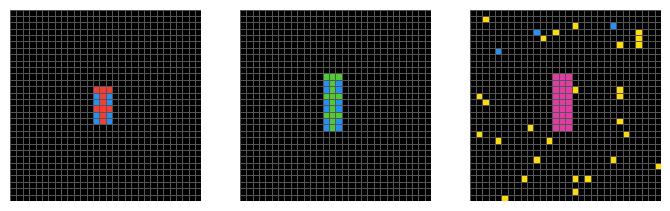

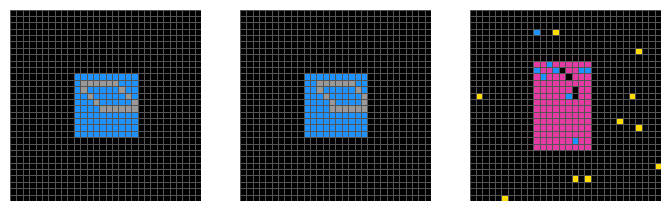

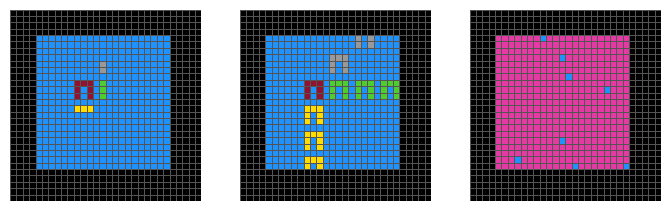

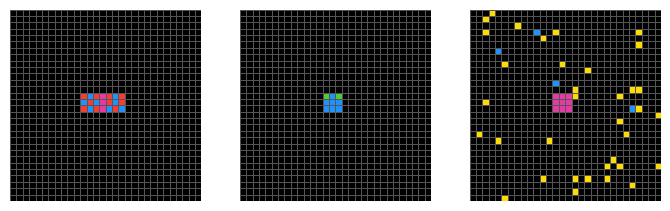

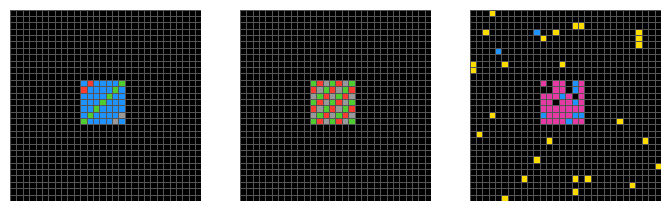

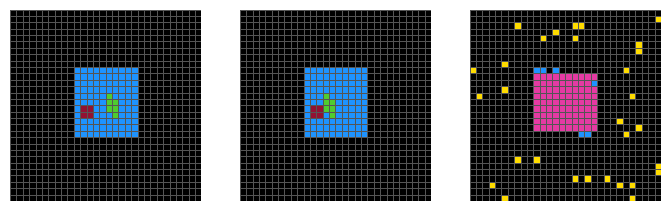

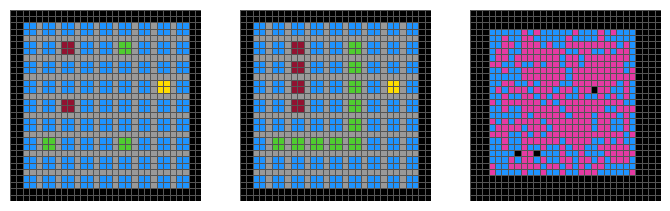

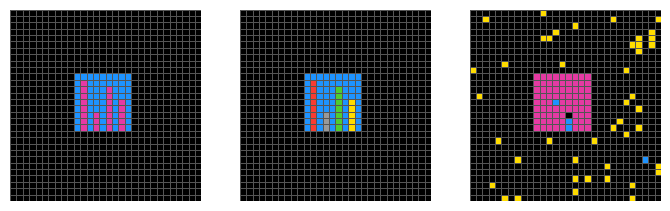

Epoch 4/100, Loss: 1.3897457094146655, Accuracy: 9.094438170525127%
Epoch 5/100


Validation: 100%|██████████| 26/26 [01:14<00:00,  2.87s/it]


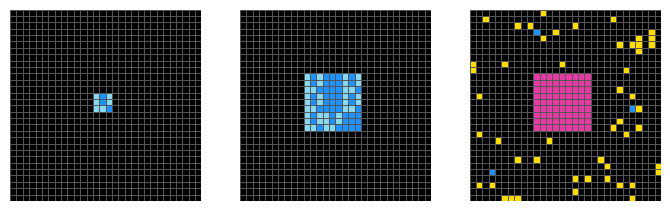

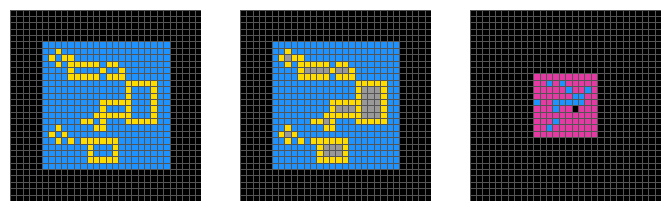

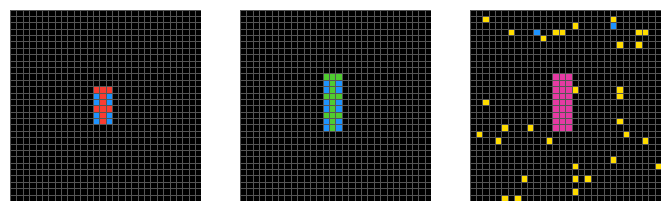

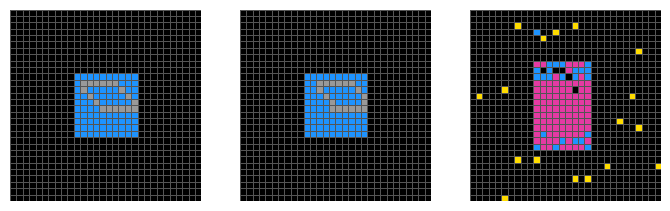

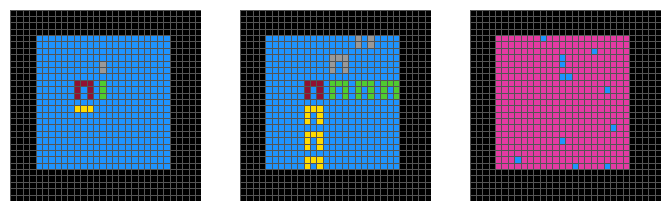

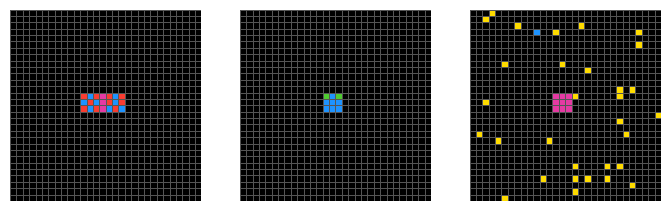

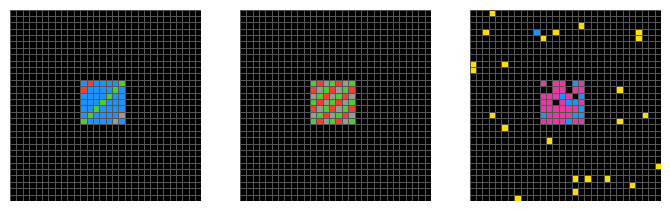

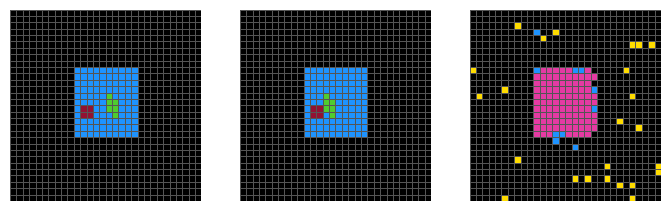

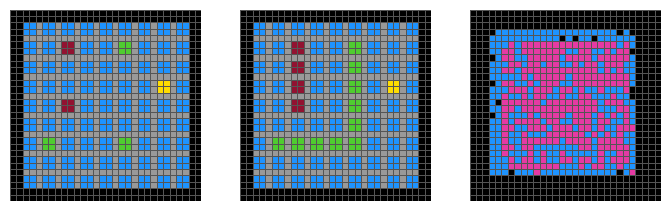

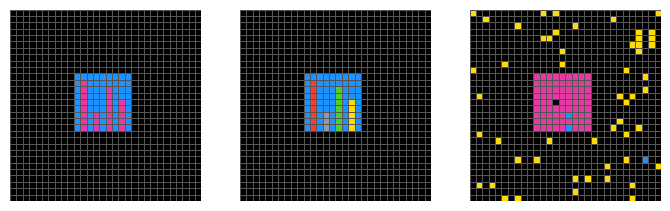

Epoch 5/100, Loss: 1.3714151909718146, Accuracy: 9.61144833427442%
Epoch 6/100


Validation: 100%|██████████| 26/26 [01:14<00:00,  2.88s/it]


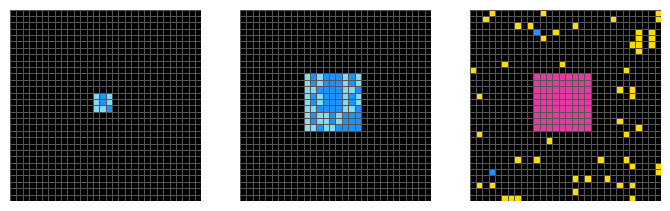

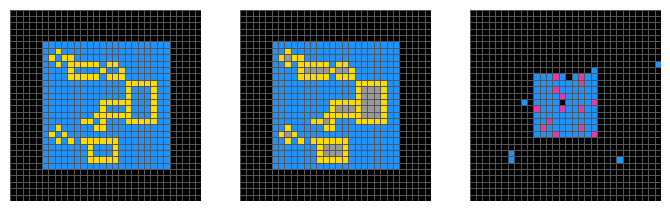

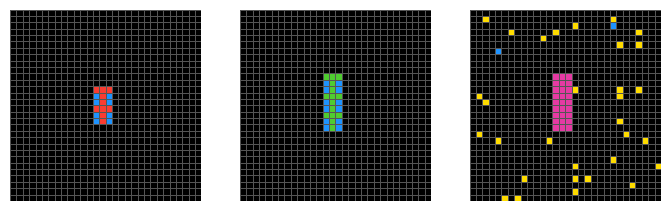

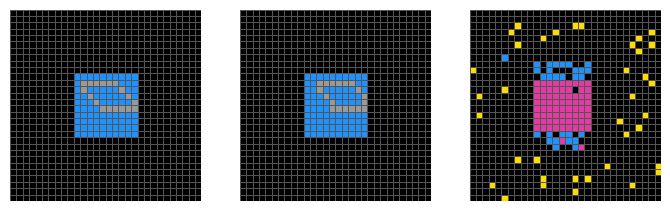

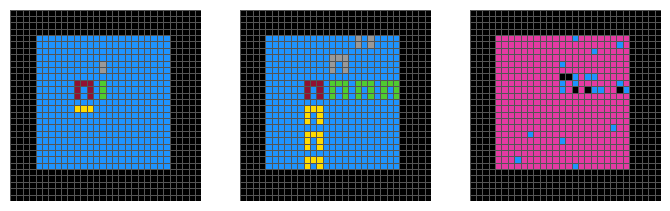

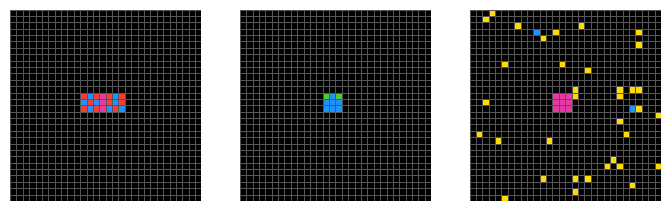

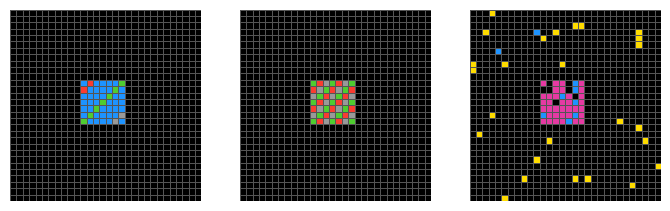

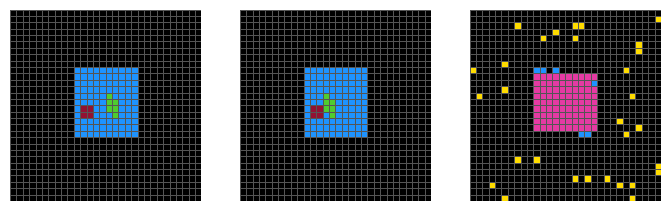

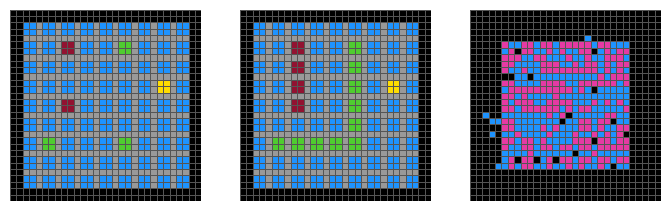

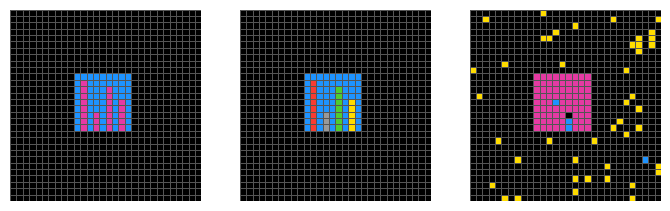

Epoch 6/100, Loss: 1.3717782943008037, Accuracy: 8.797995482778092%
Epoch 7/100


Validation: 100%|██████████| 26/26 [01:15<00:00,  2.91s/it]


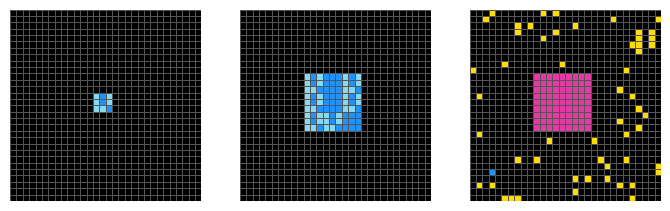

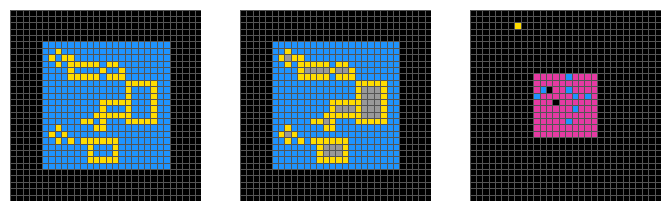

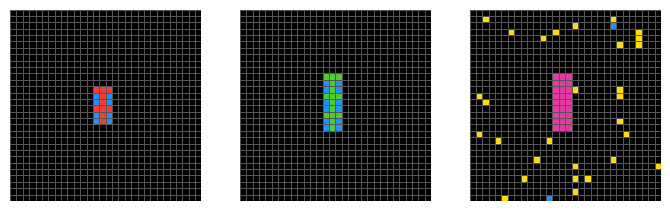

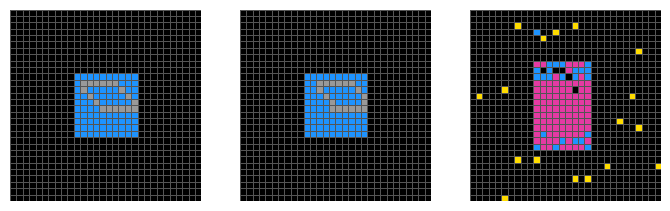

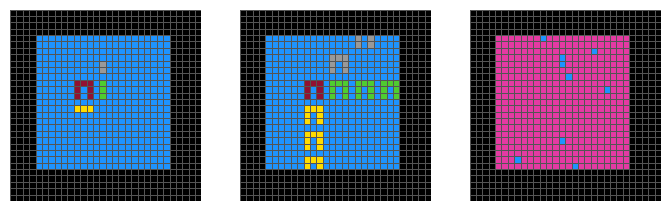

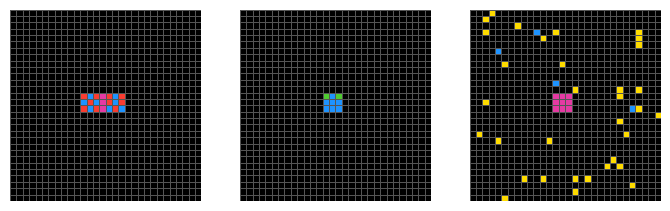

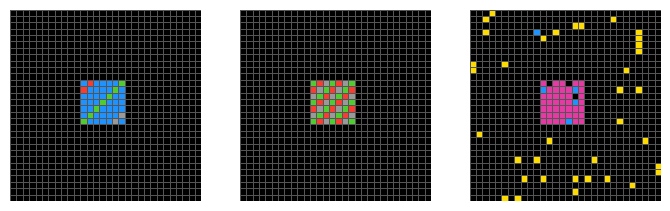

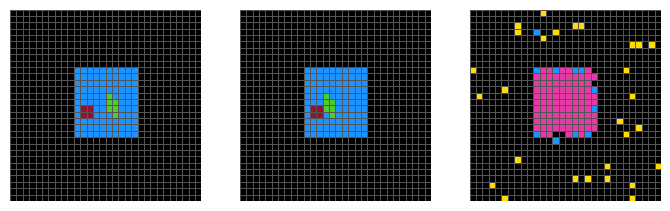

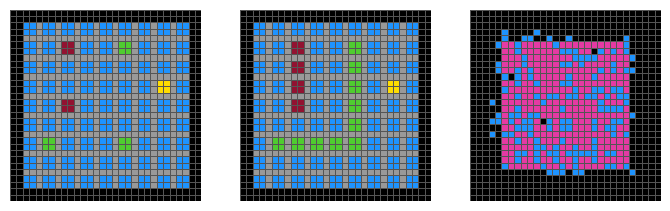

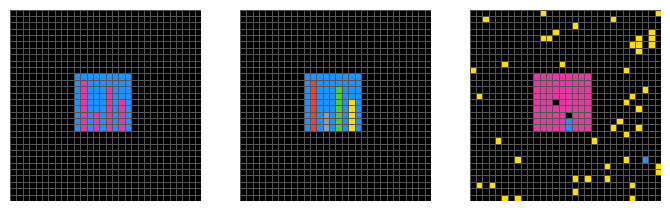

Epoch 7/100, Loss: 1.3903234562335105, Accuracy: 8.37803500846979%
Epoch 8/100


Validation: 100%|██████████| 26/26 [01:18<00:00,  3.01s/it]


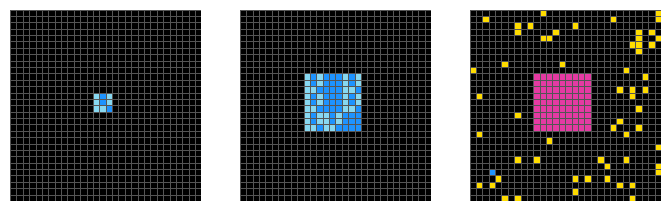

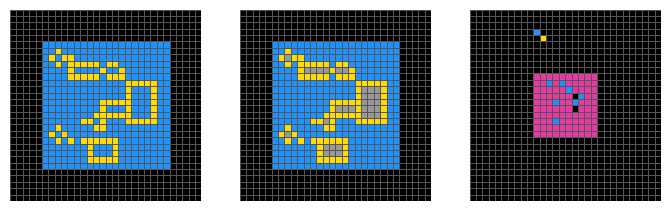

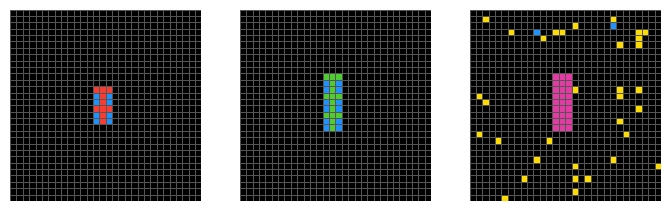

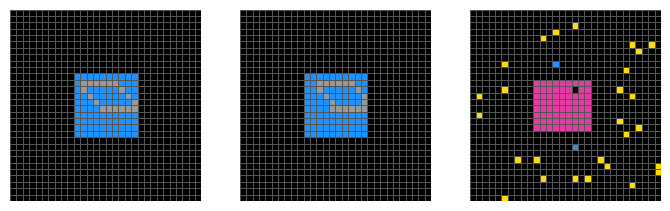

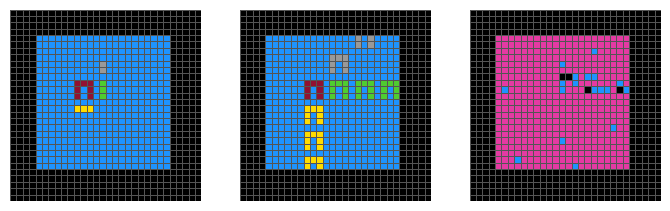

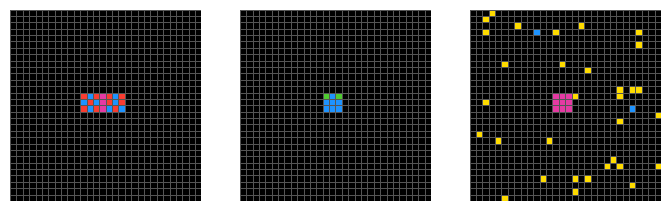

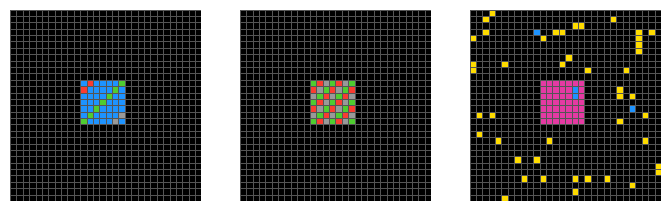

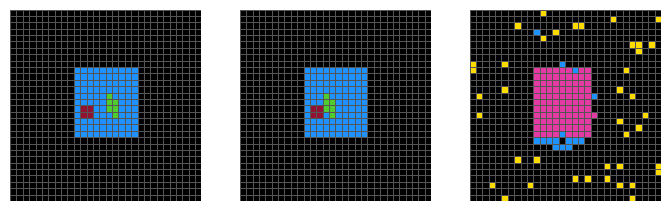

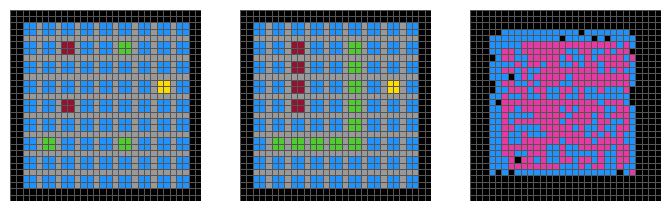

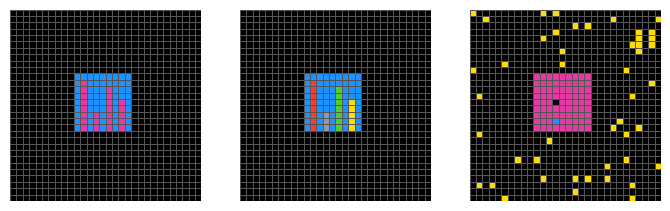

Epoch 8/100, Loss: 1.3924667444080114, Accuracy: 9.819664031620553%
Epoch 9/100


Validation: 100%|██████████| 26/26 [01:18<00:00,  3.00s/it]


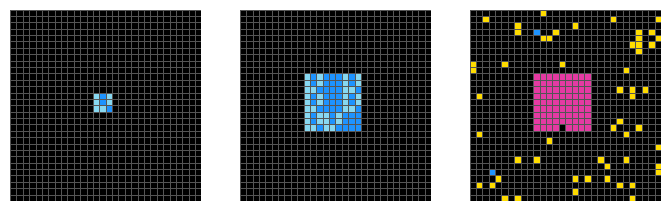

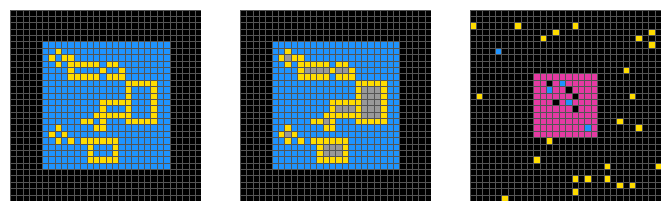

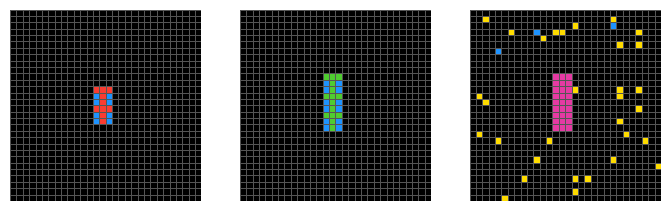

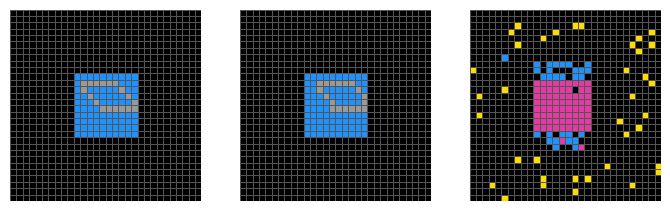

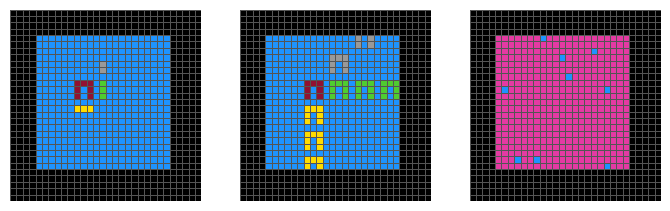

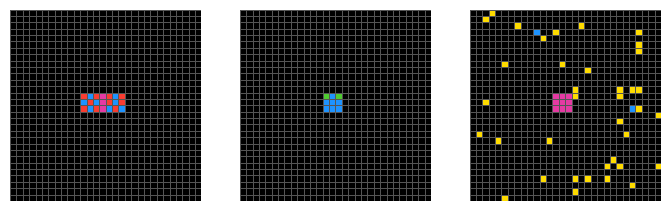

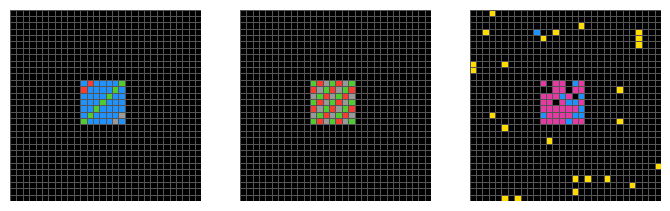

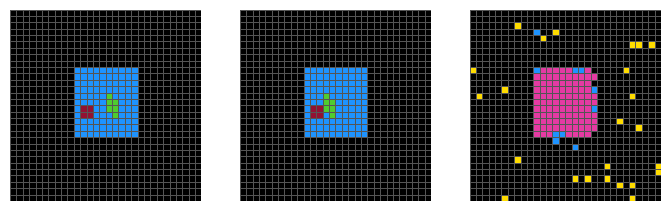

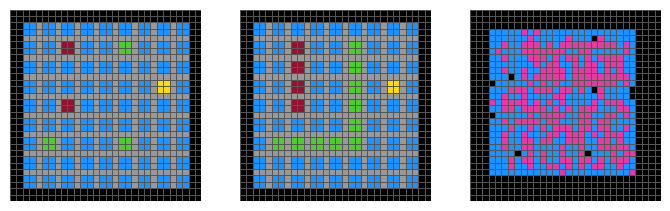

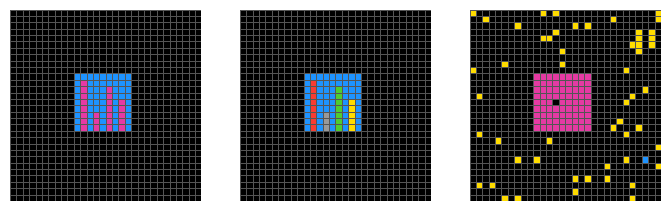

Epoch 9/100, Loss: 1.38126108995997, Accuracy: 8.727413890457369%
Epoch 10/100


Validation: 100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


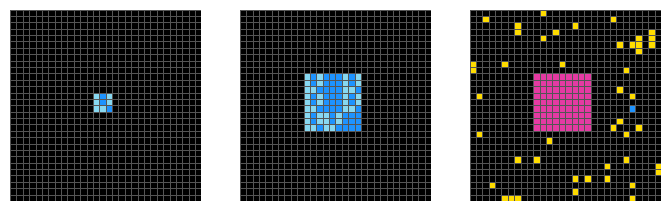

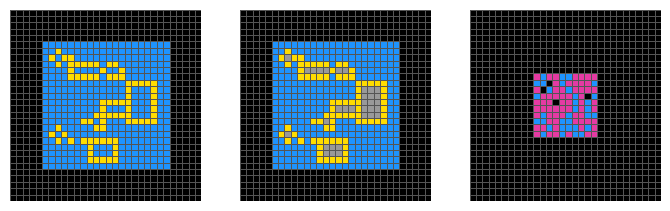

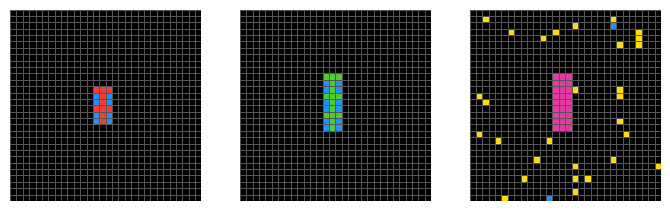

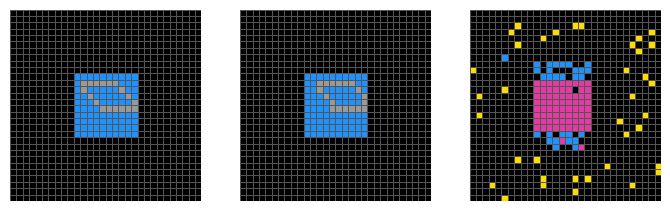

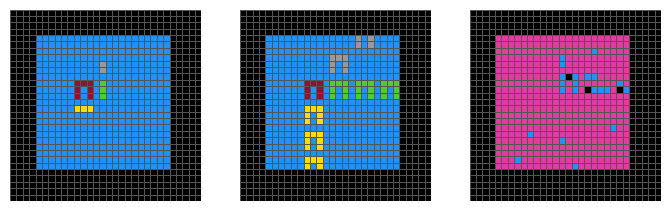

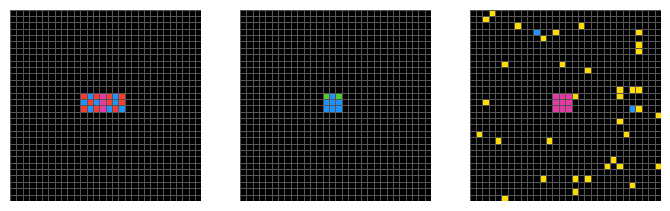

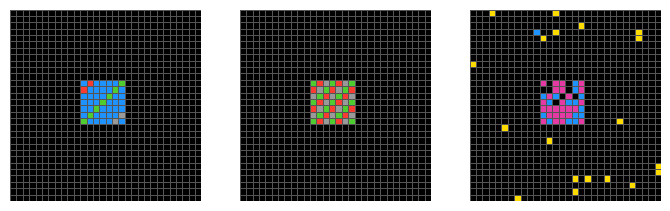

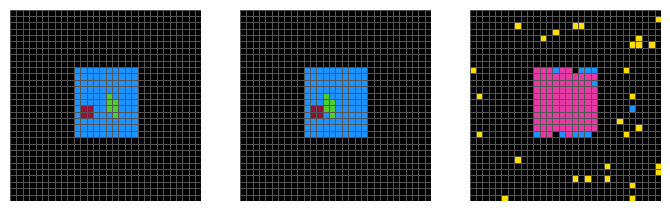

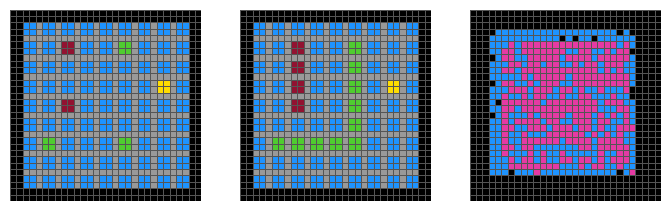

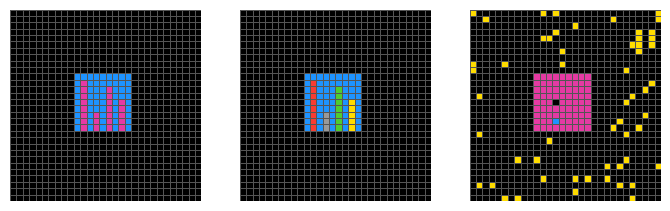

Epoch 10/100, Loss: 1.3907255735248327, Accuracy: 8.52449181253529%
Epoch 11/100


Validation: 100%|██████████| 26/26 [01:16<00:00,  2.93s/it]


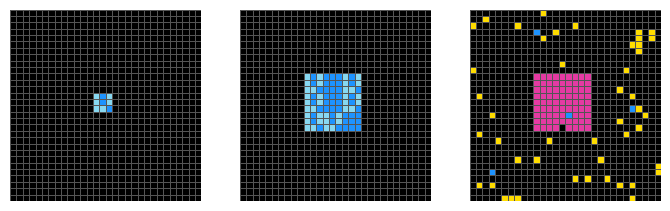

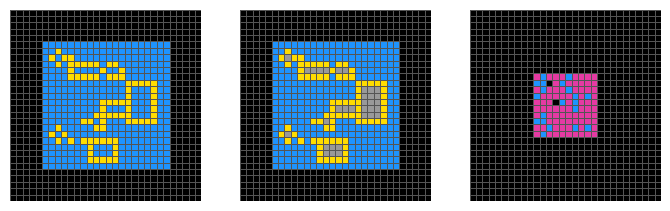

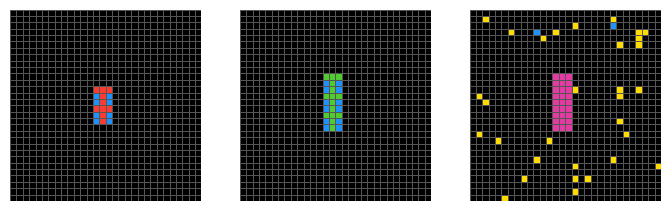

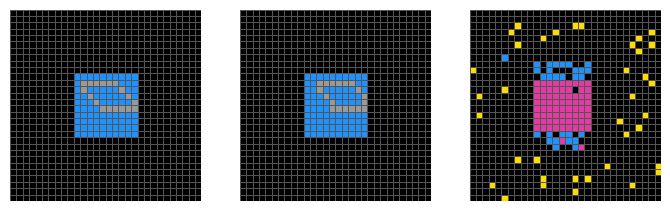

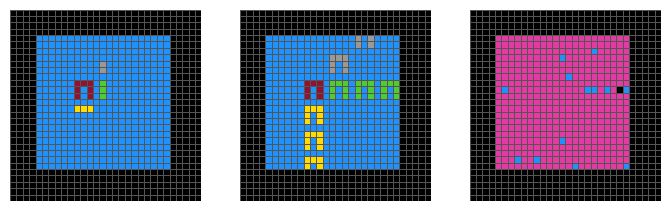

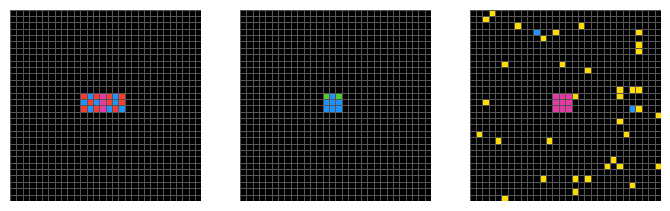

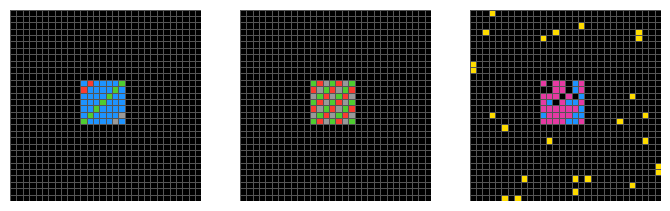

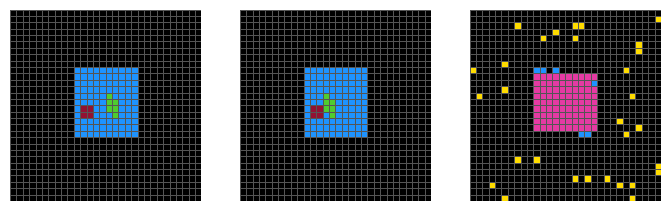

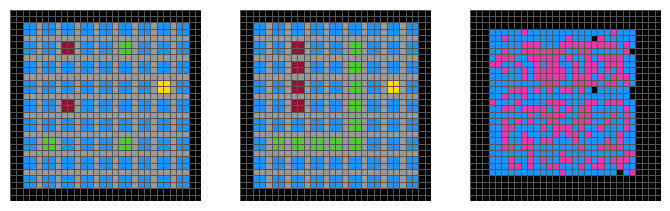

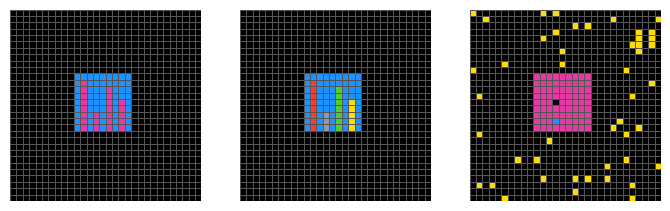

Epoch 11/100, Loss: 1.391613765548055, Accuracy: 8.533314511575382%
Epoch 12/100


Validation: 100%|██████████| 26/26 [01:15<00:00,  2.89s/it]


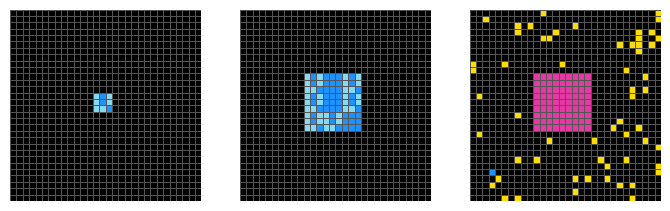

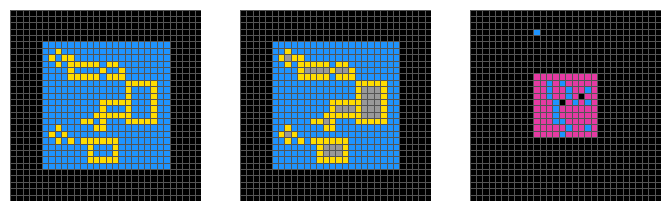

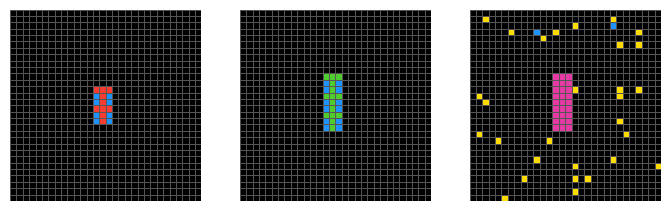

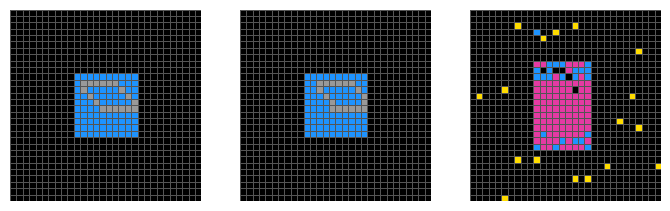

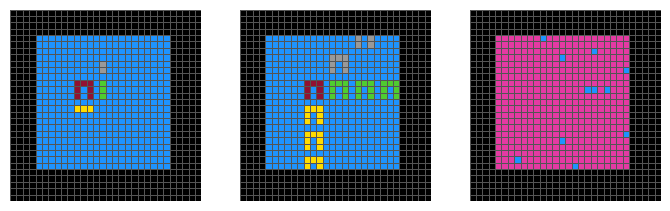

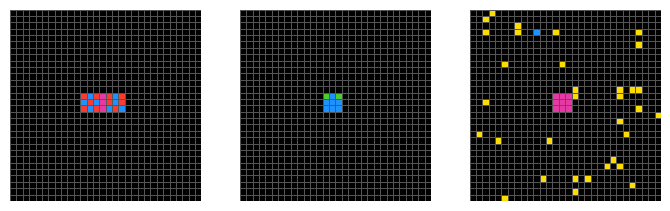

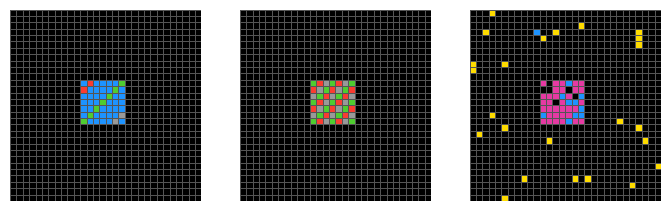

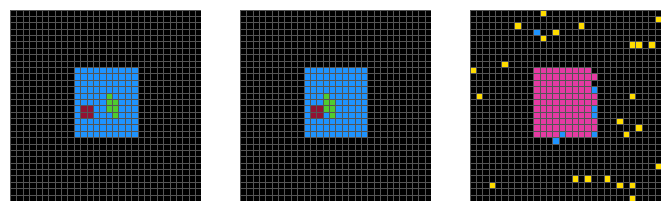

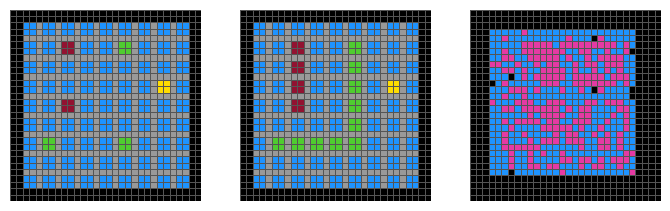

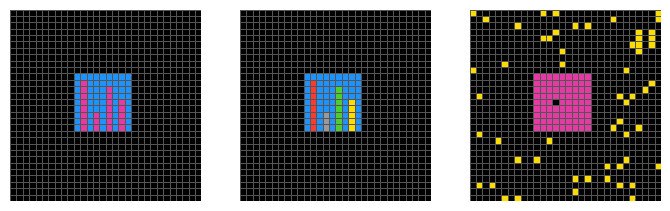

Epoch 12/100, Loss: 1.36753889072973, Accuracy: 9.029150197628459%
Epoch 13/100


Validation: 100%|██████████| 26/26 [01:18<00:00,  3.00s/it]


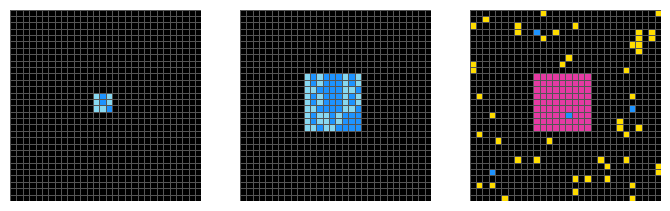

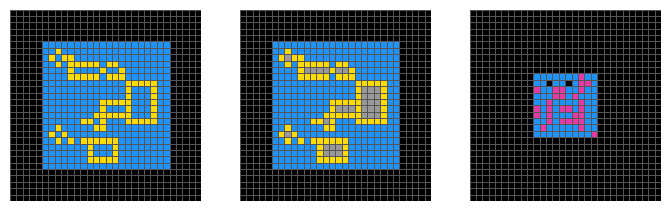

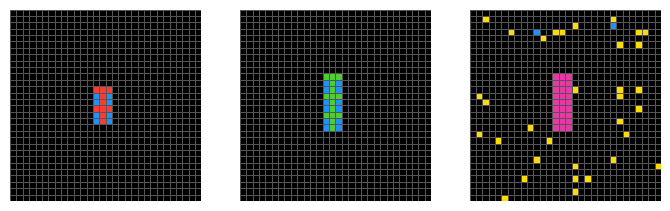

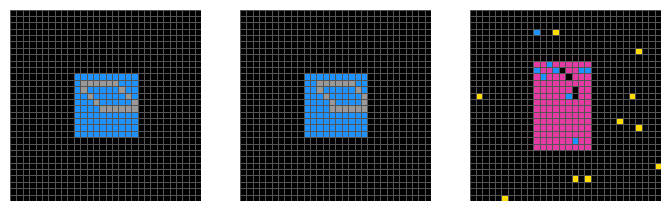

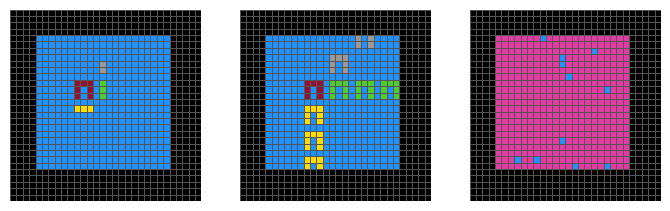

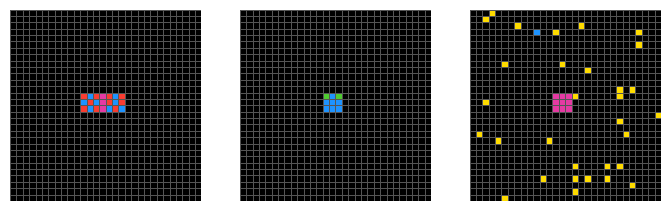

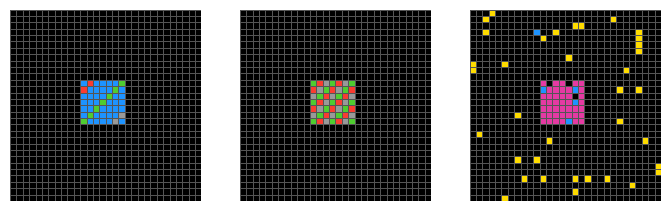

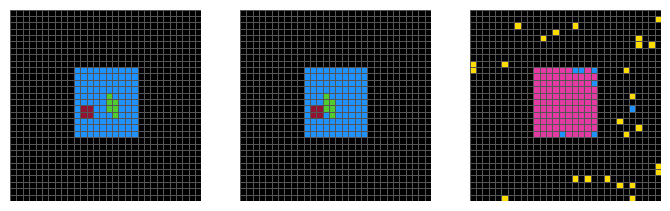

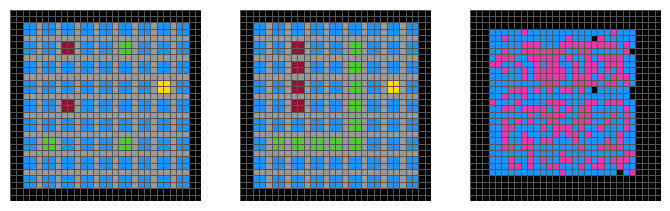

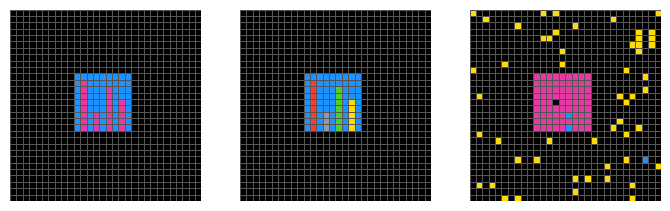

Epoch 13/100, Loss: 1.3722394991379518, Accuracy: 8.977978543195935%
Epoch 14/100


Validation: 100%|██████████| 26/26 [01:17<00:00,  2.98s/it]


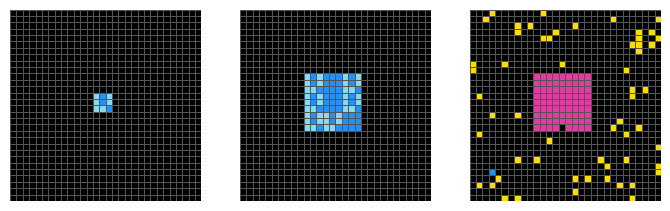

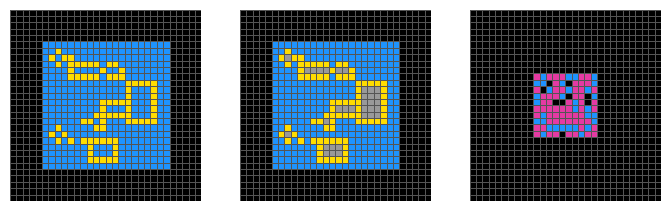

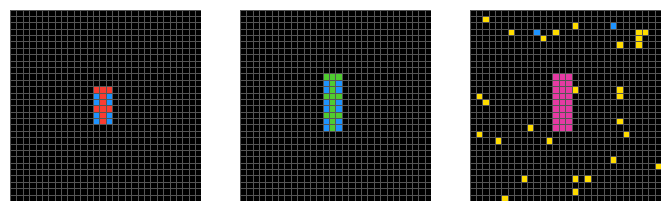

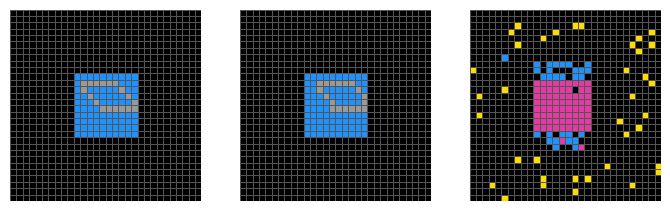

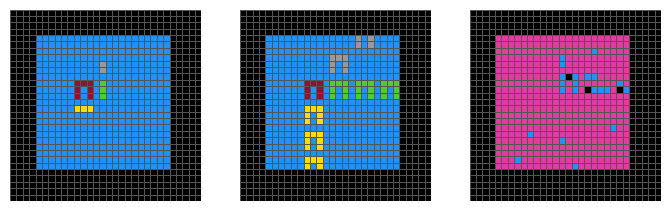

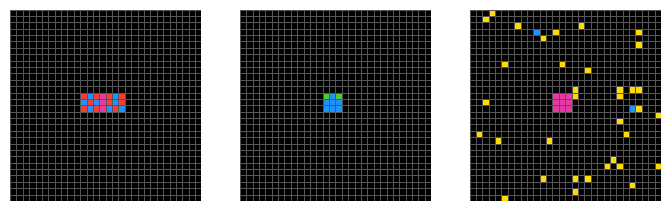

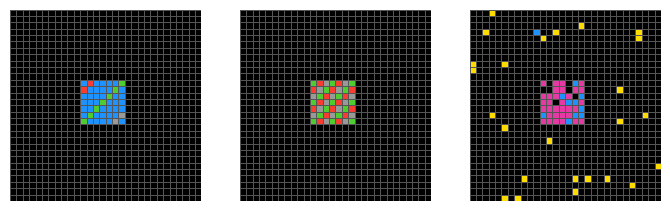

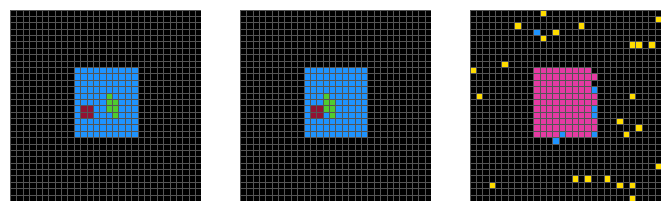

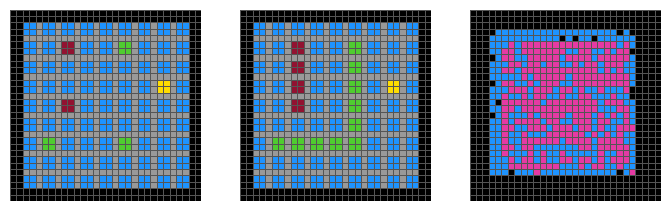

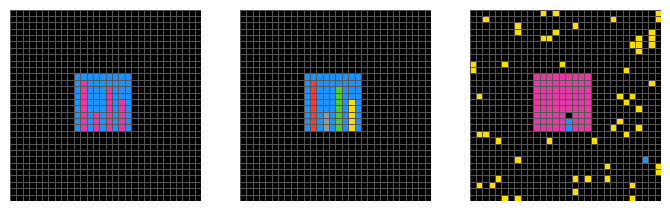

Epoch 14/100, Loss: 1.396597539862761, Accuracy: 8.72564935064935%
Epoch 15/100


Validation: 100%|██████████| 26/26 [01:17<00:00,  2.97s/it]


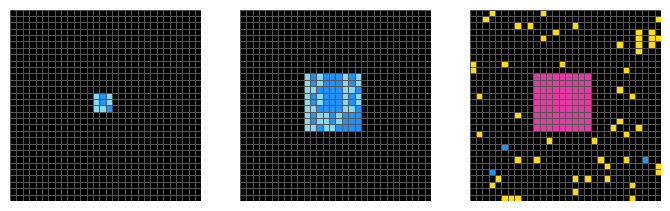

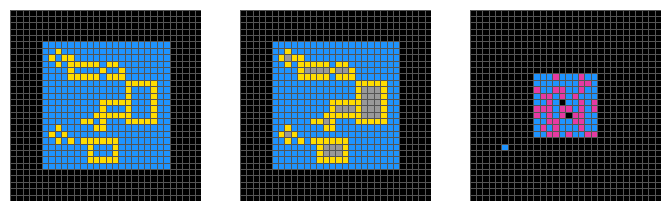

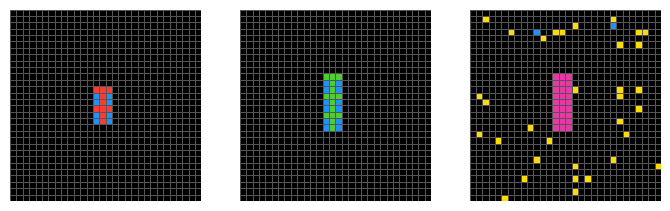

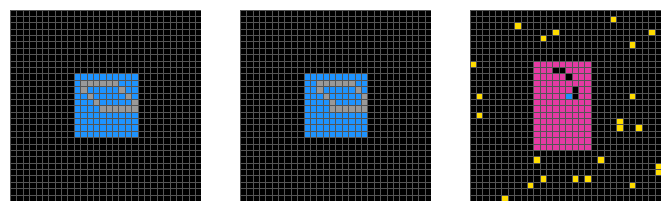

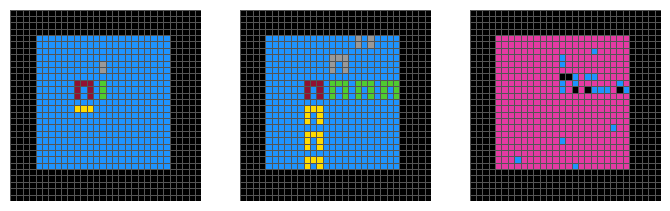

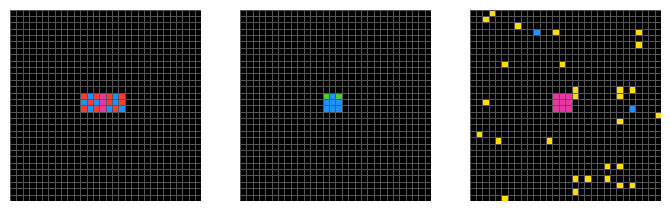

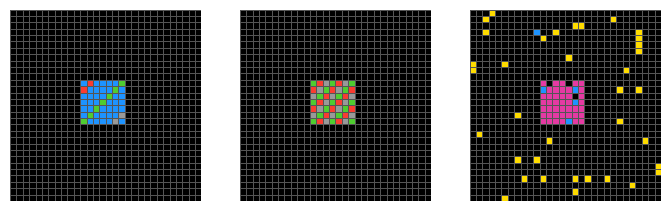

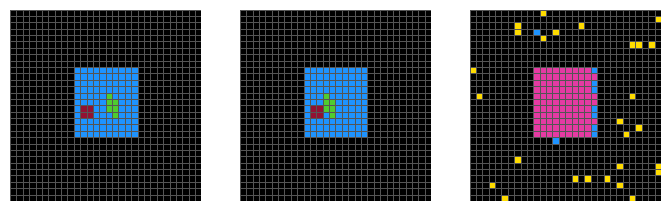

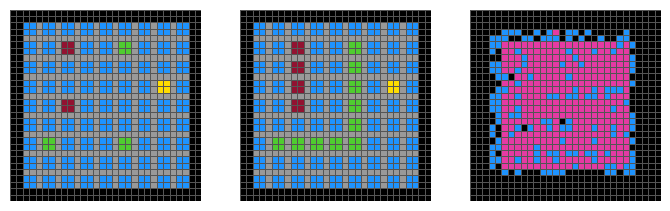

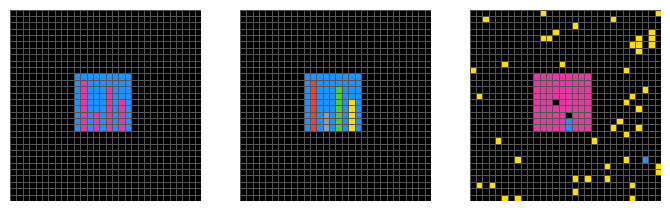

Epoch 15/100, Loss: 1.3808859136815255, Accuracy: 9.33970920383964%
Epoch 16/100


Validation: 100%|██████████| 26/26 [01:16<00:00,  2.93s/it]


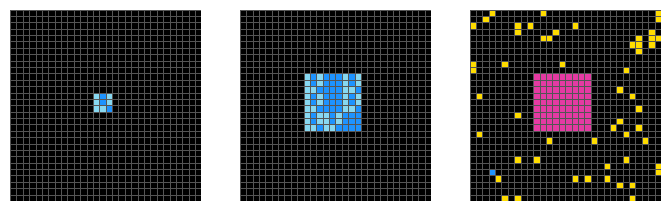

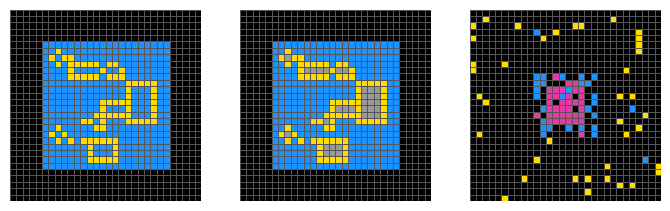

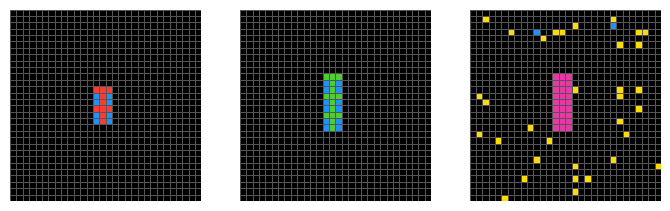

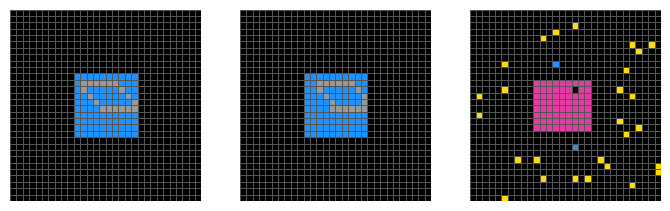

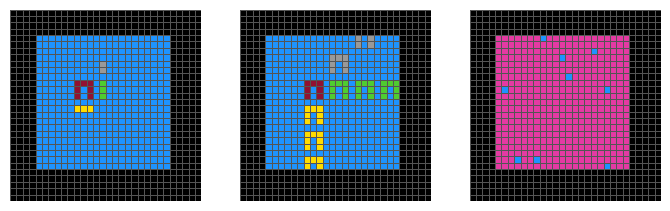

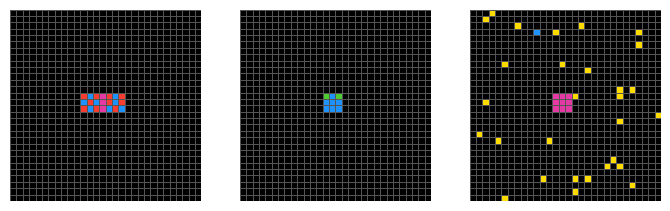

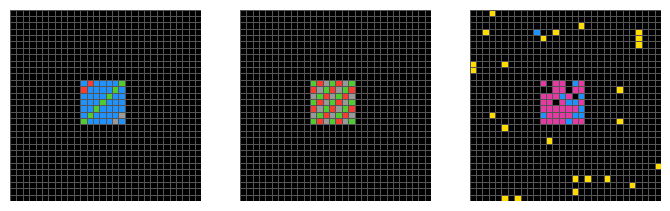

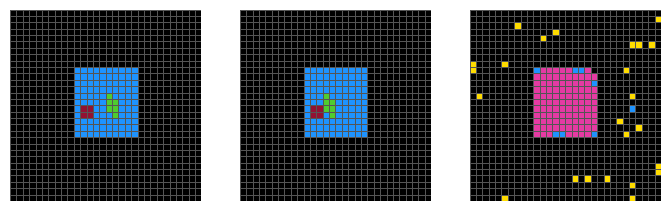

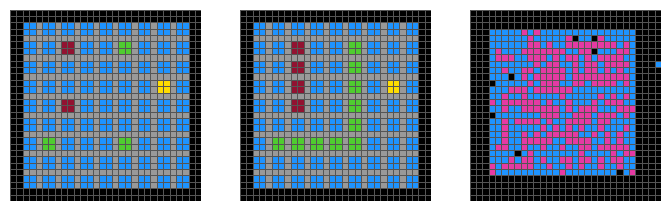

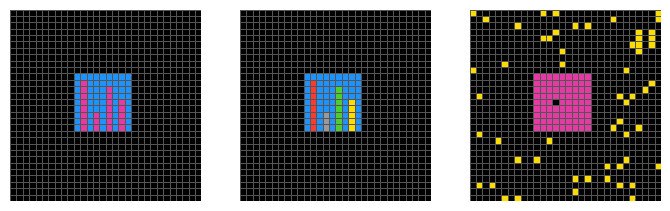

Epoch 16/100, Loss: 1.381180057875239, Accuracy: 9.175607001693958%
Epoch 17/100


Validation: 100%|██████████| 26/26 [01:16<00:00,  2.94s/it]


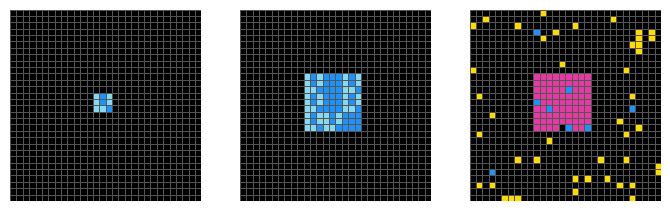

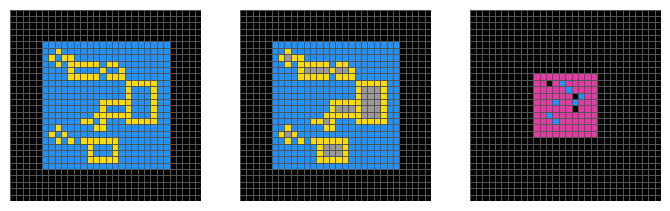

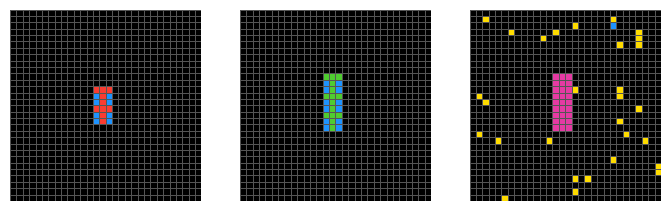

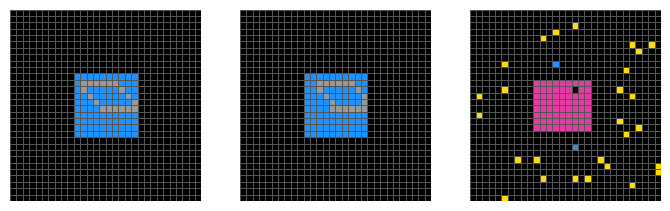

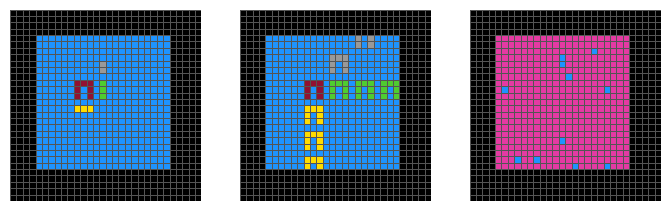

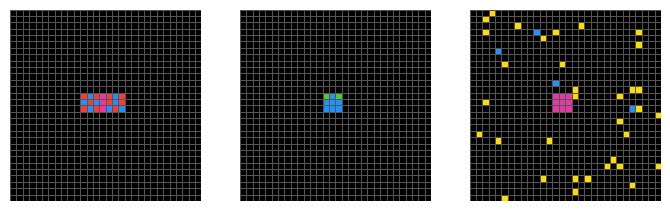

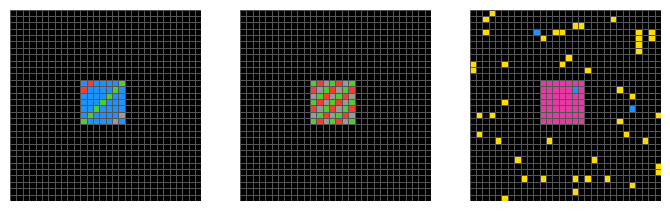

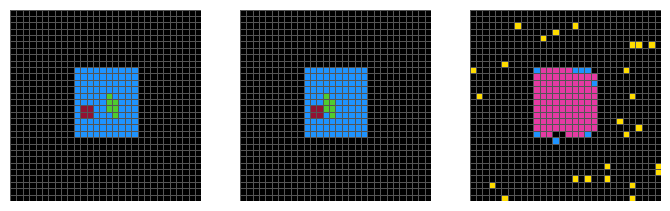

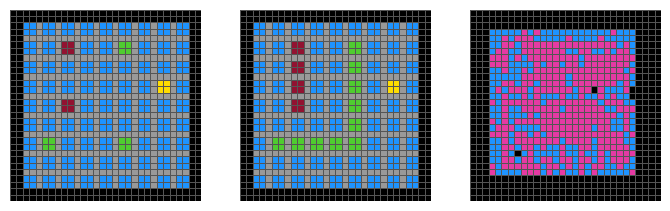

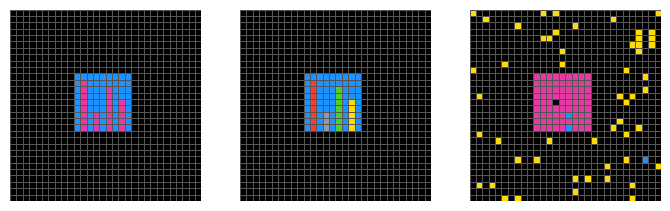

Epoch 17/100, Loss: 1.3916796306864574, Accuracy: 8.896809712027103%
Epoch 18/100


Validation: 100%|██████████| 26/26 [01:19<00:00,  3.04s/it]


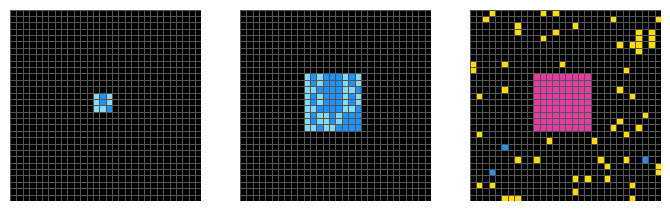

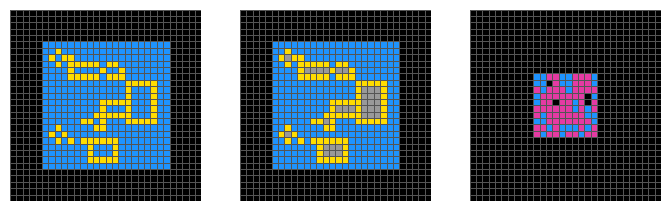

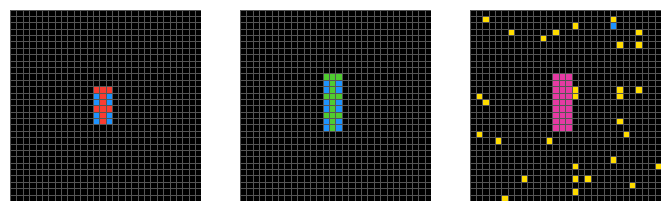

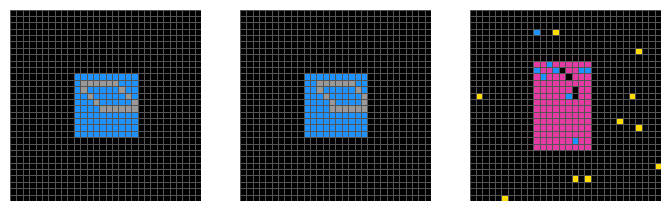

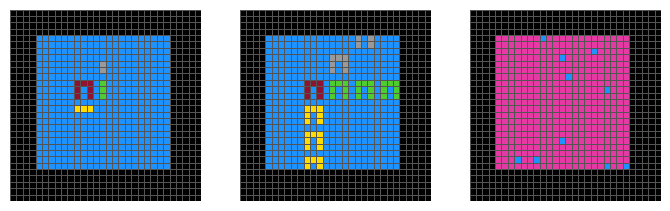

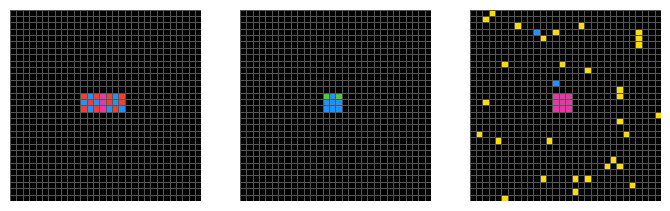

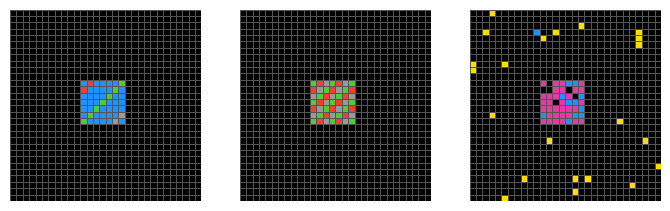

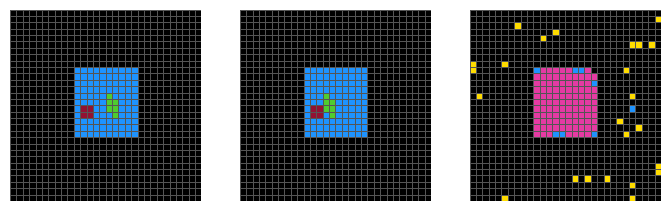

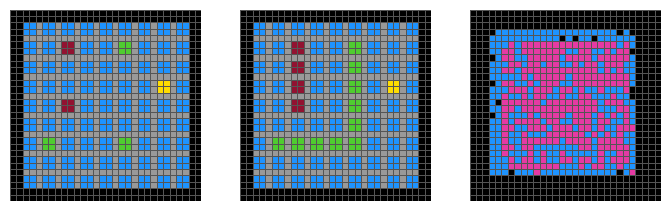

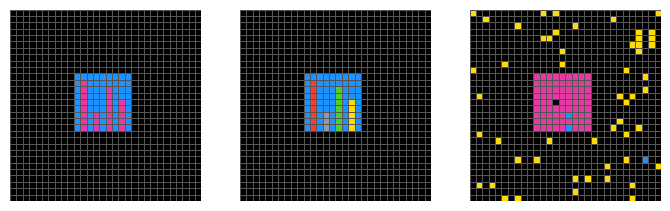

Epoch 18/100, Loss: 1.3901726884337573, Accuracy: 8.95327498588368%
Epoch 19/100


Validation: 100%|██████████| 26/26 [01:16<00:00,  2.94s/it]


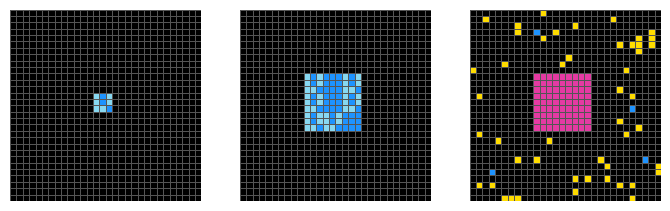

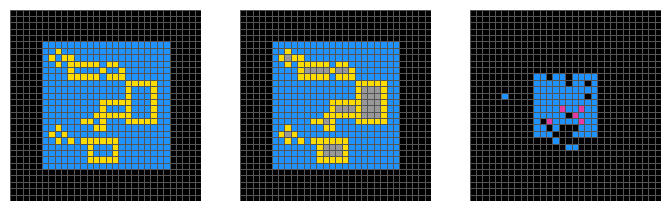

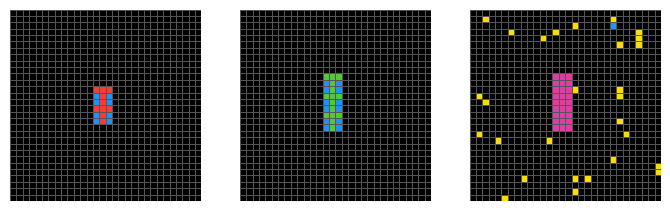

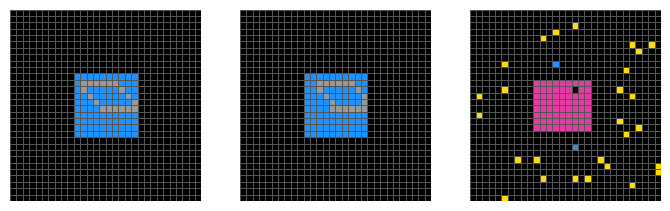

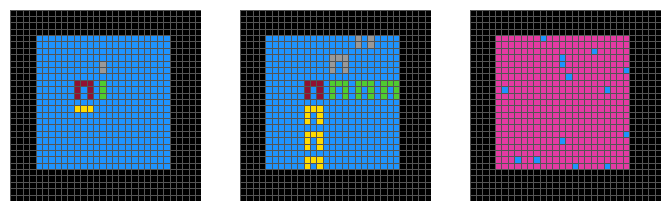

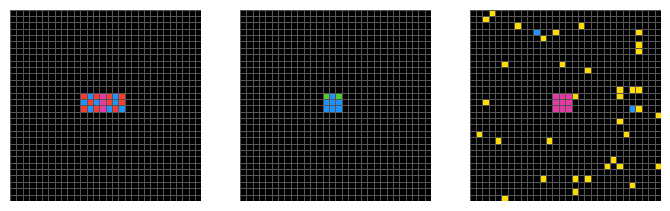

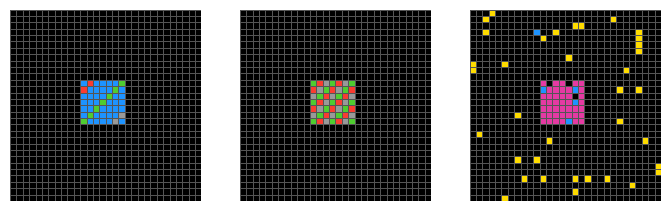

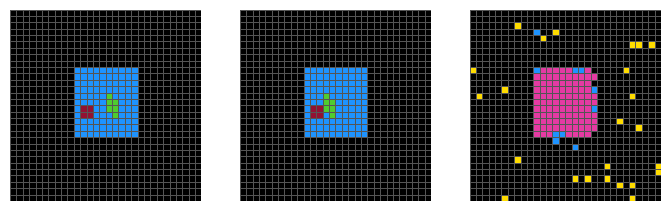

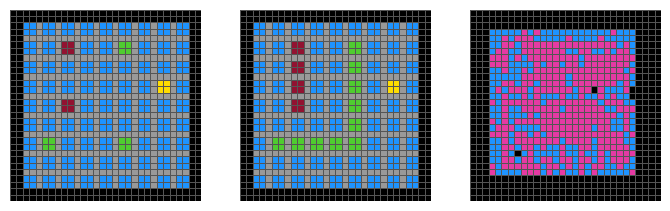

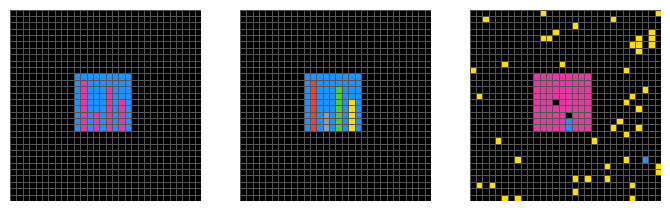

Epoch 19/100, Loss: 1.3738396970125346, Accuracy: 9.11914172783738%
Epoch 20/100


Validation: 100%|██████████| 26/26 [01:18<00:00,  3.00s/it]


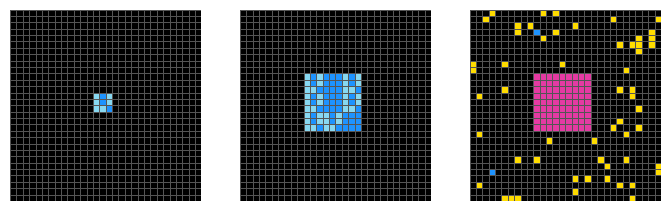

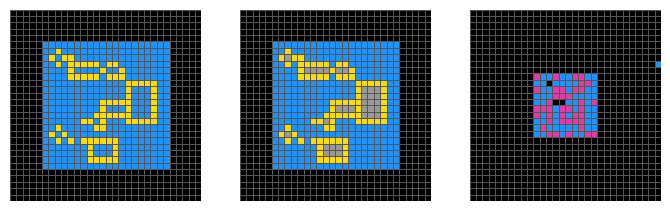

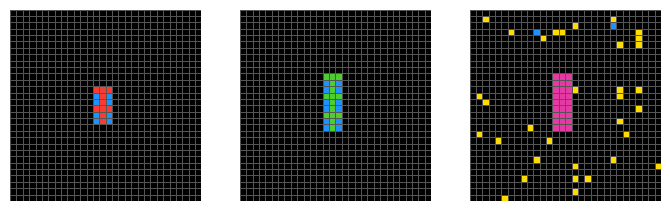

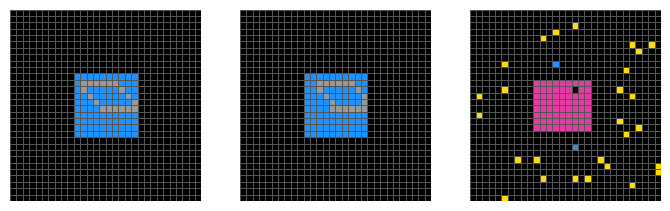

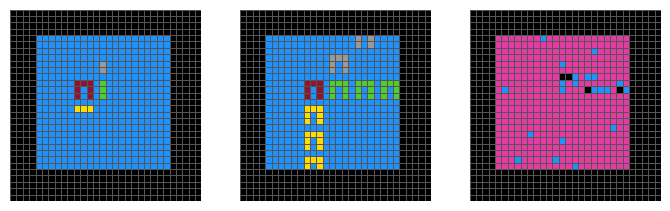

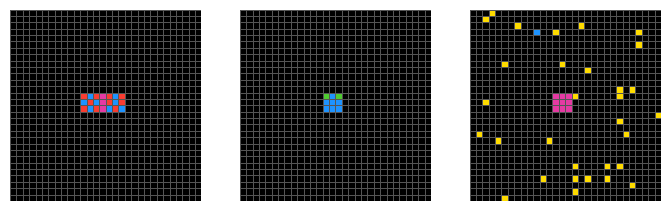

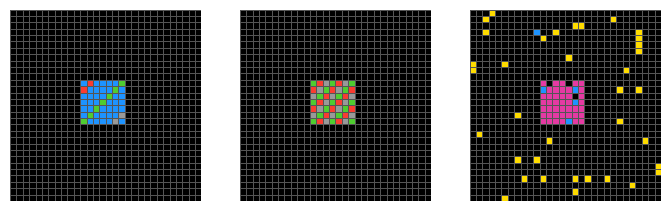

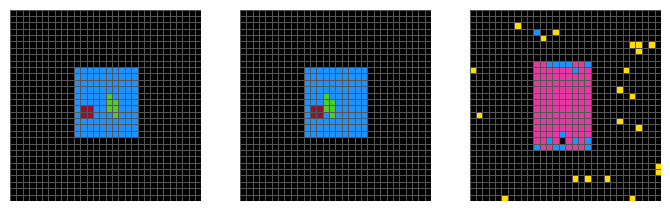

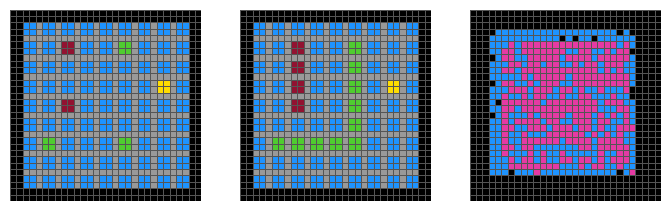

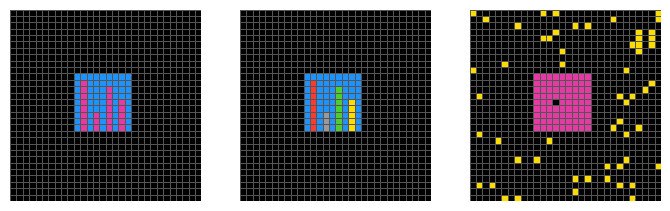

Epoch 20/100, Loss: 1.3812730077367563, Accuracy: 8.930335968379447%
Epoch 21/100


Validation: 100%|██████████| 26/26 [01:20<00:00,  3.09s/it]


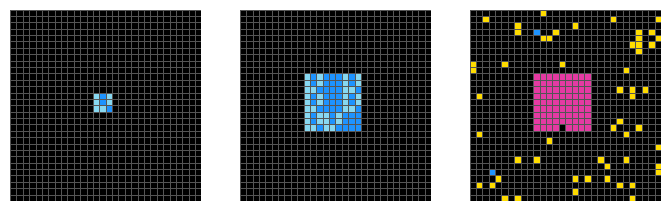

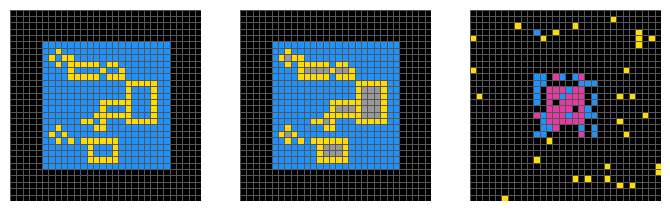

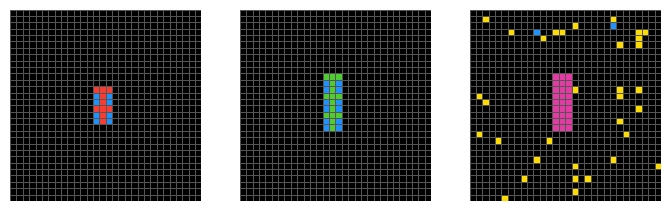

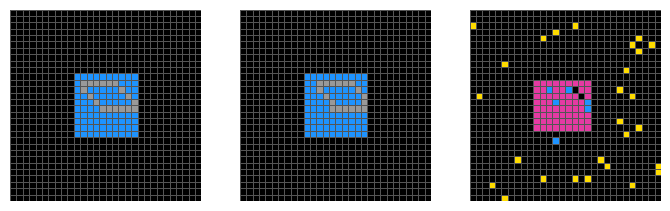

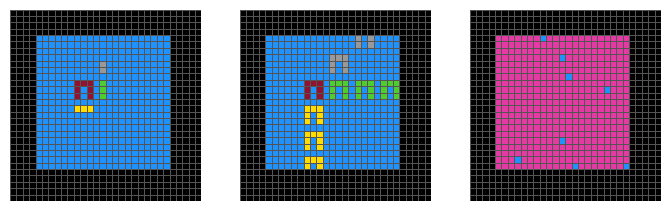

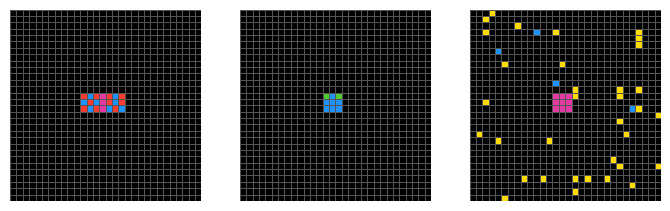

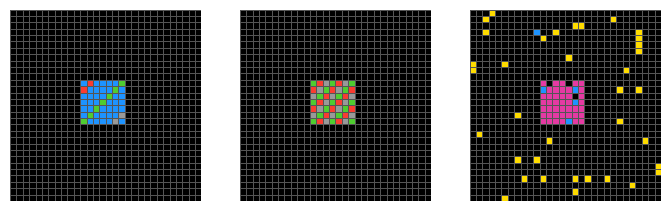

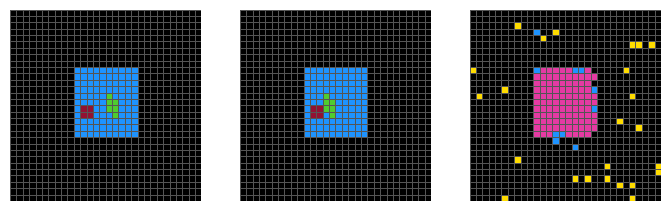

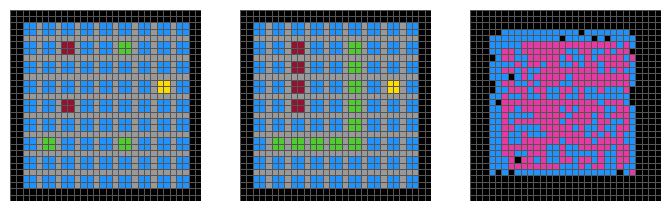

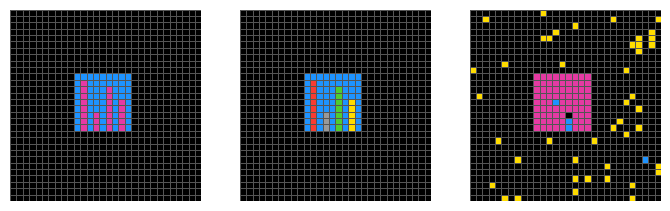

Epoch 21/100, Loss: 1.3870589373489985, Accuracy: 8.766233766233766%
Epoch 22/100


Validation: 100%|██████████| 26/26 [01:16<00:00,  2.92s/it]


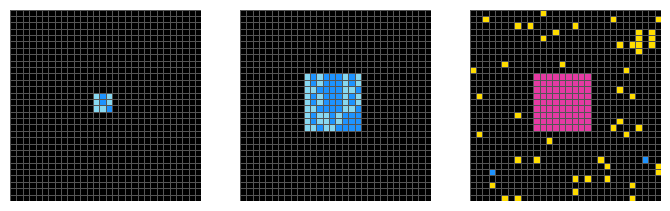

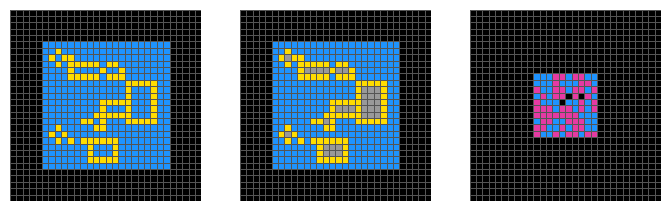

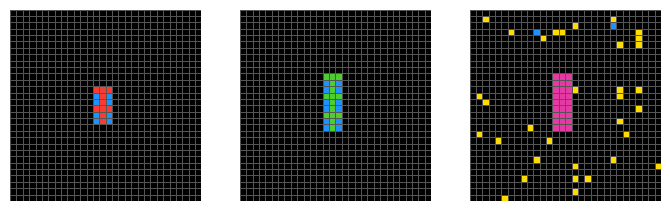

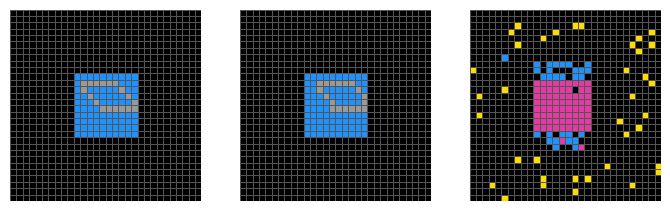

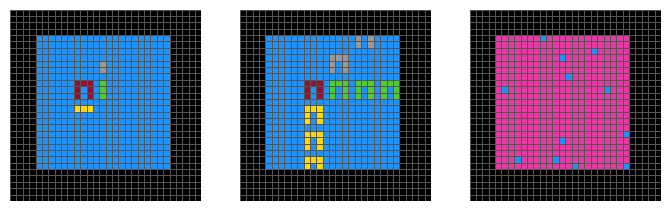

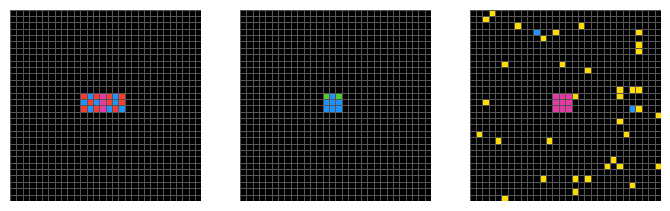

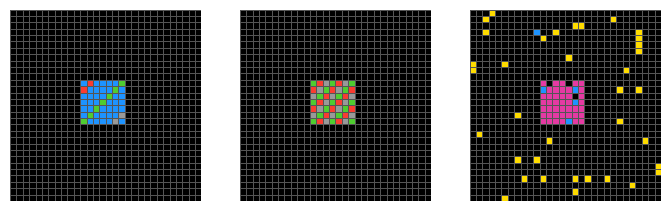

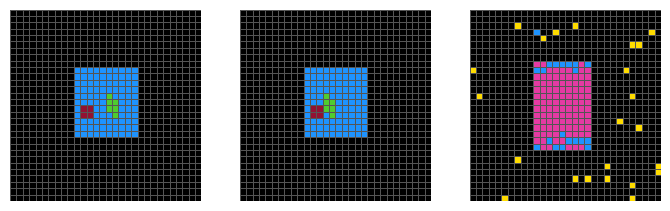

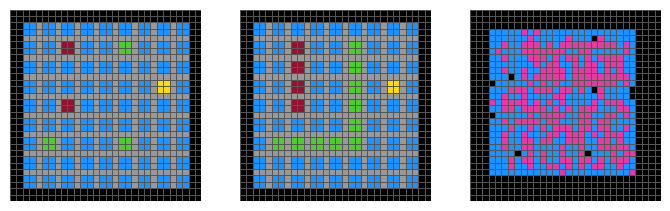

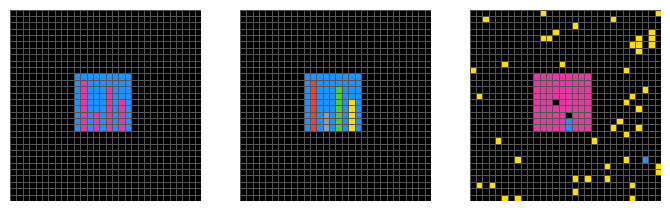

Epoch 22/100, Loss: 1.3855529824415078, Accuracy: 9.463226990400903%
Epoch 23/100


Validation: 100%|██████████| 26/26 [01:15<00:00,  2.92s/it]


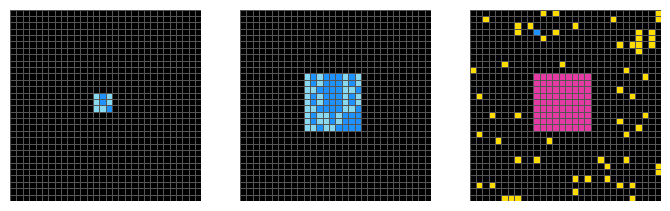

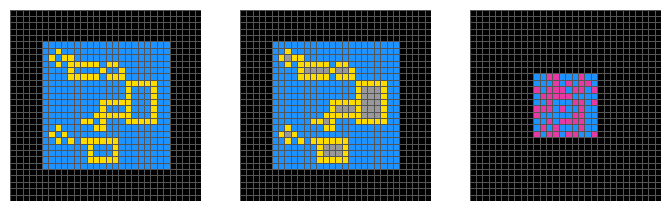

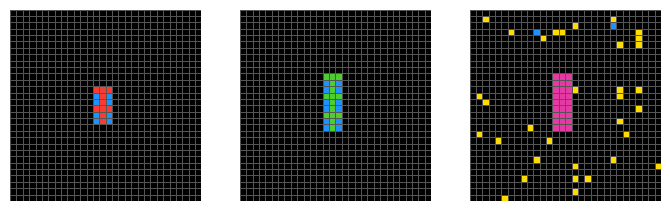

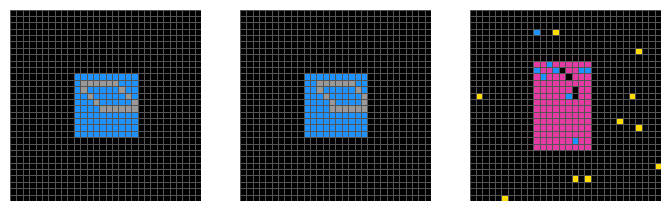

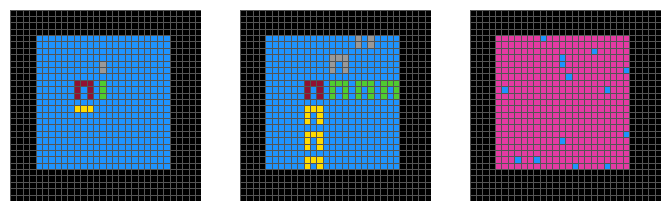

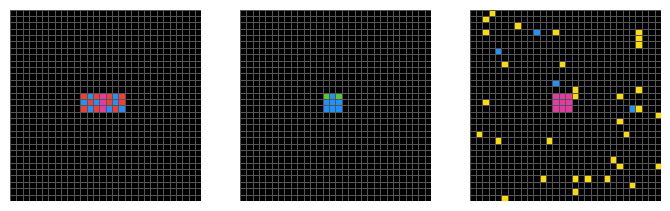

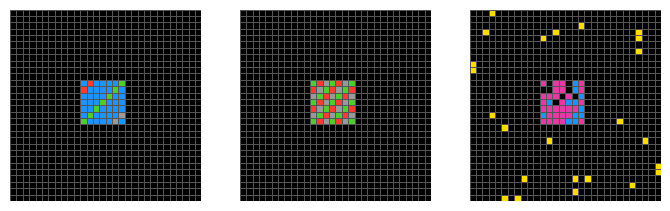

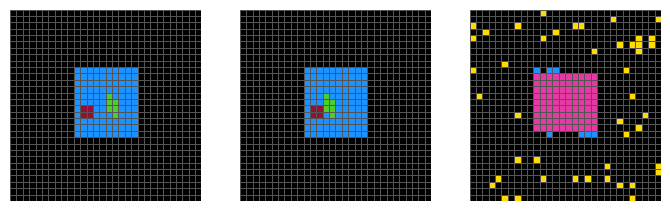

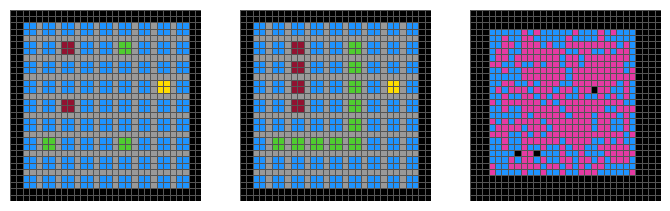

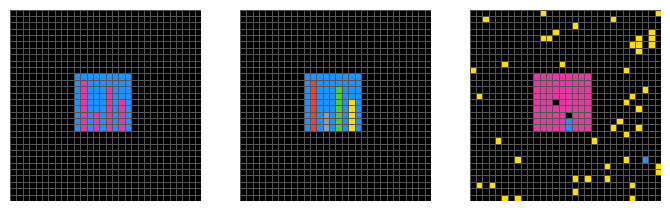

Epoch 23/100, Loss: 1.370775874847403, Accuracy: 9.350296442687746%
Epoch 24/100


Validation: 100%|██████████| 26/26 [01:16<00:00,  2.96s/it]


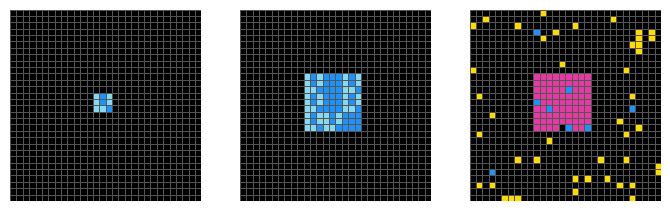

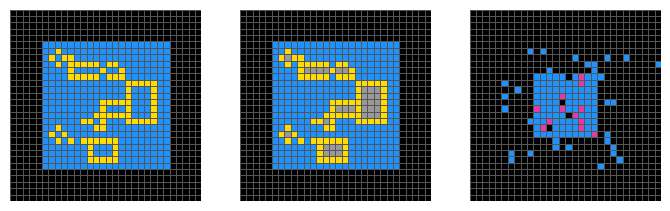

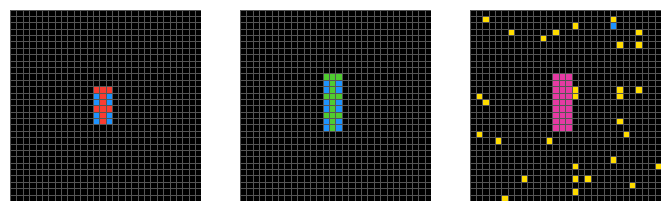

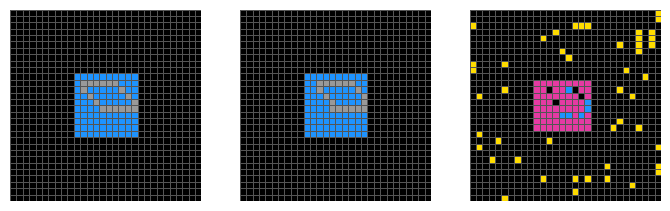

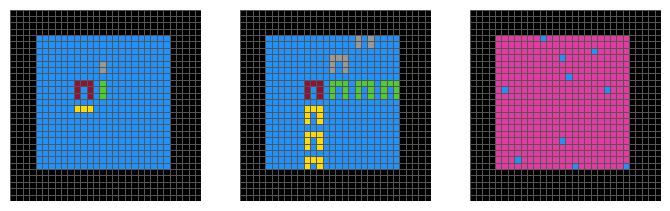

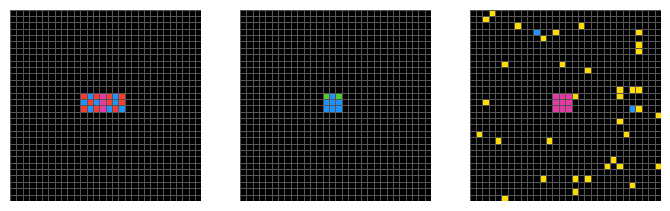

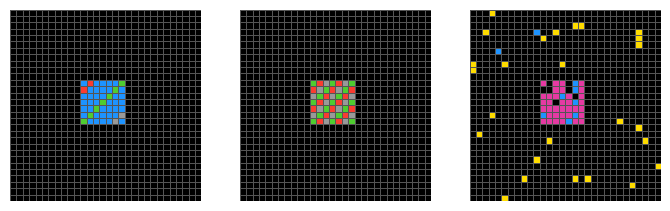

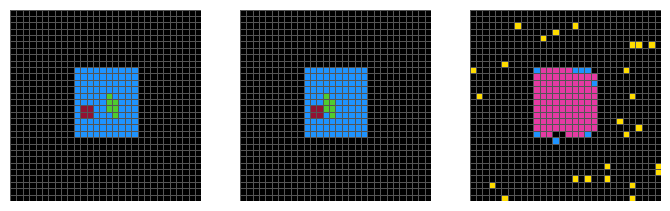

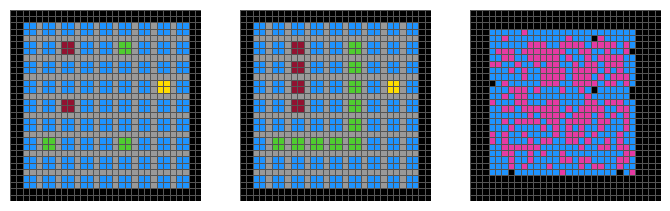

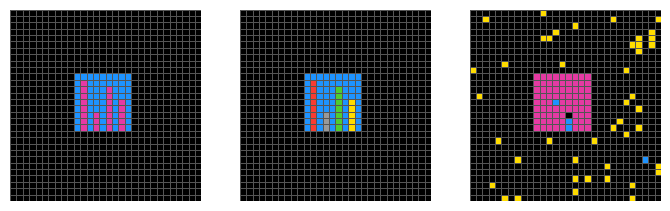

Epoch 24/100, Loss: 1.3703710206139545, Accuracy: 9.267363071710898%
Epoch 25/100


Validation: 100%|██████████| 26/26 [01:18<00:00,  3.02s/it]


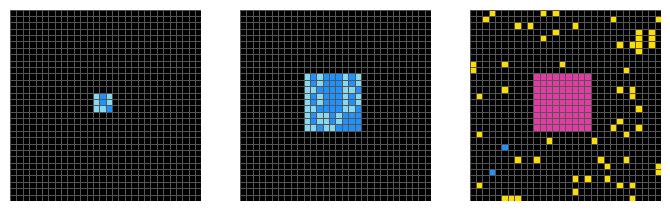

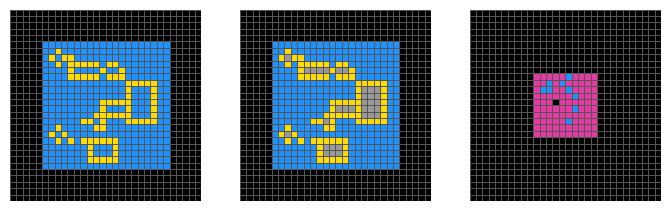

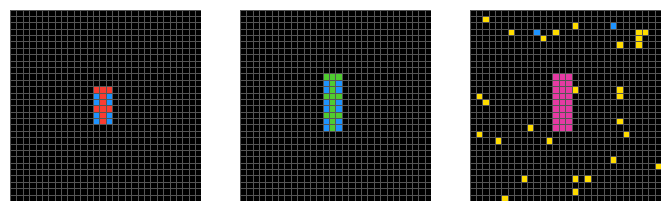

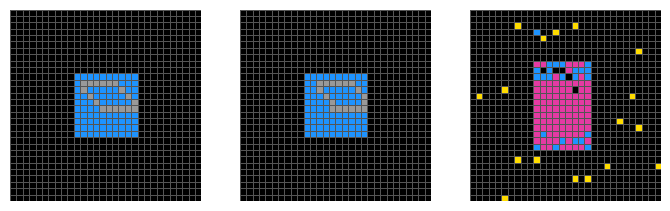

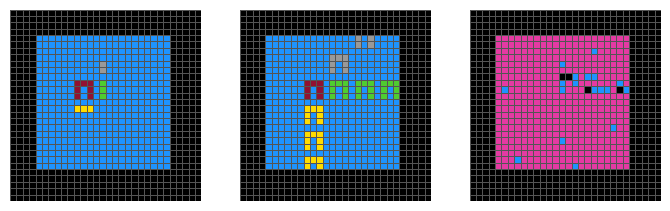

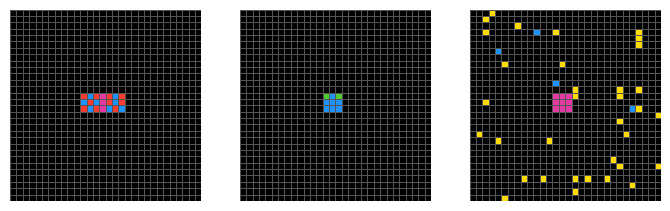

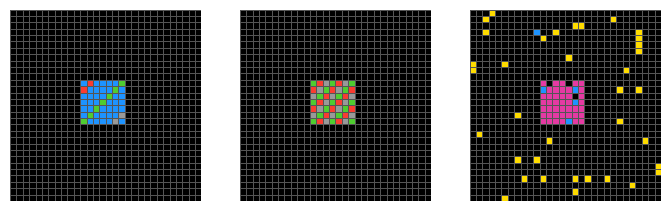

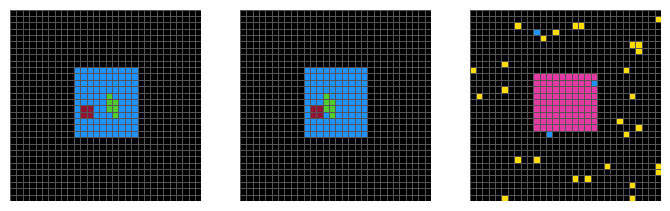

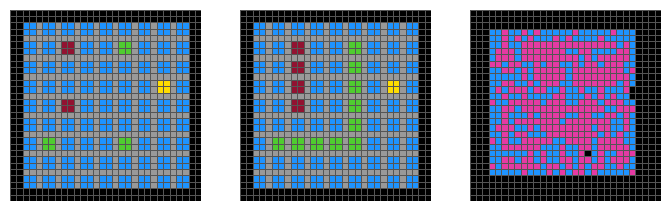

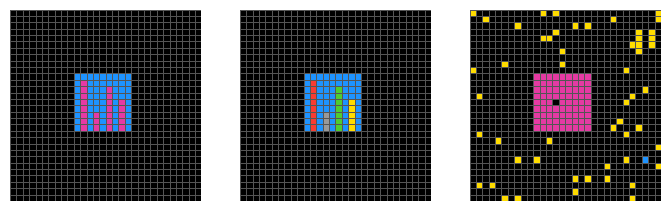

Epoch 25/100, Loss: 1.3743093990935729, Accuracy: 8.47155561829475%
Epoch 26/100


Validation: 100%|██████████| 26/26 [01:18<00:00,  3.03s/it]


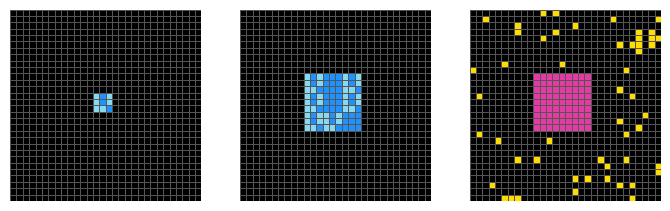

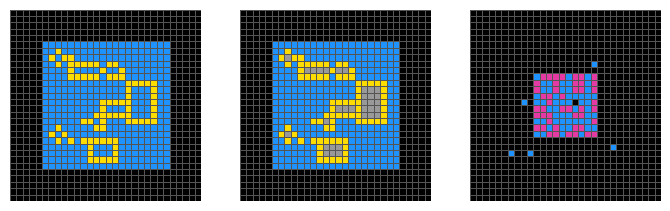

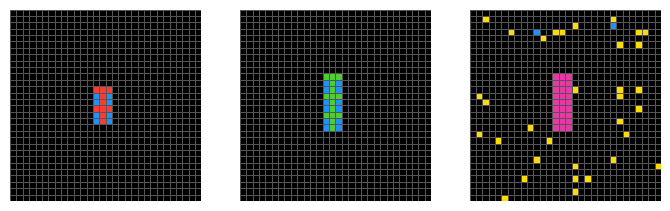

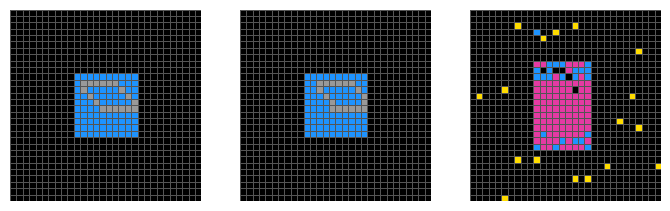

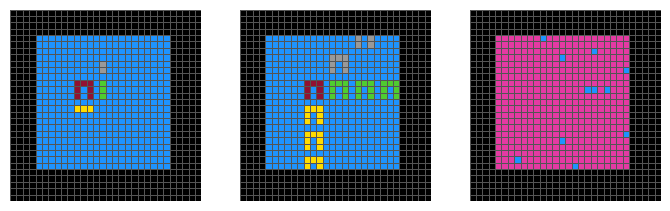

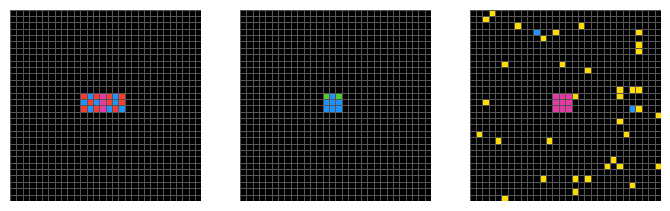

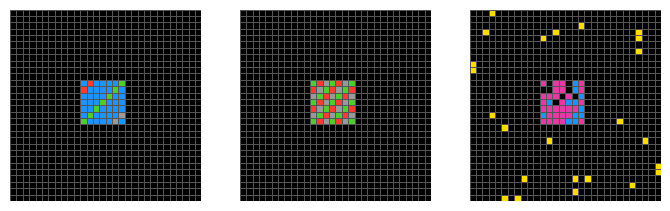

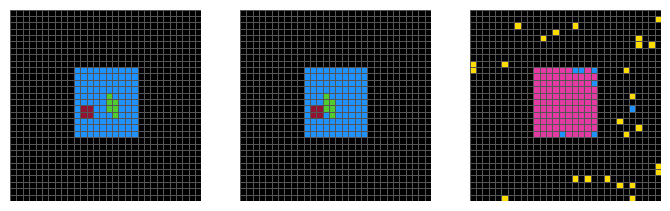

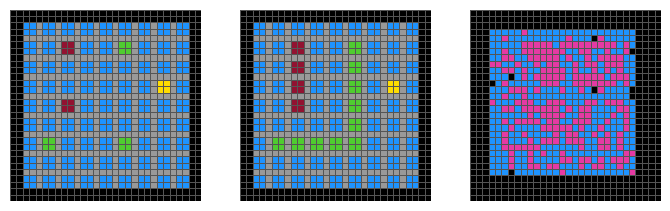

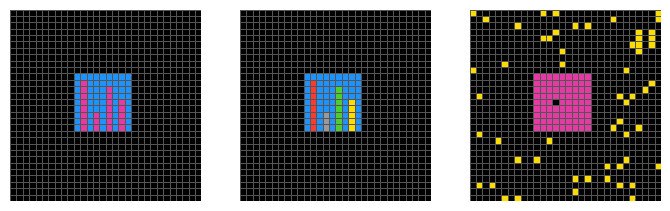

Epoch 26/100, Loss: 1.3759136088192463, Accuracy: 9.053853754940711%
Epoch 27/100


Validation: 100%|██████████| 26/26 [01:17<00:00,  2.99s/it]


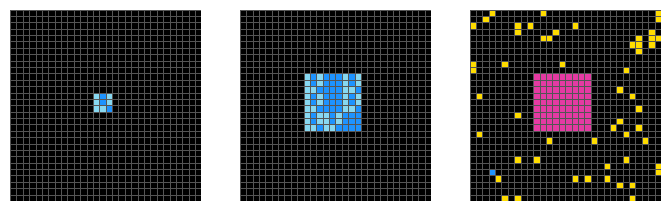

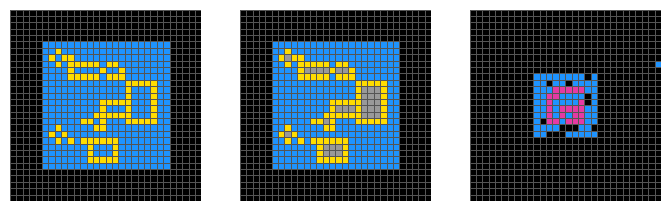

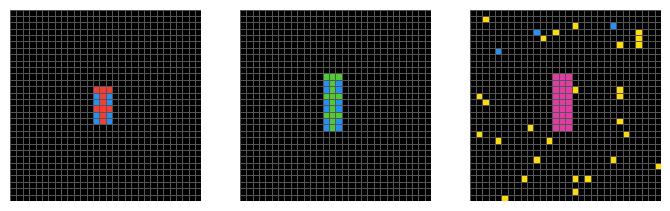

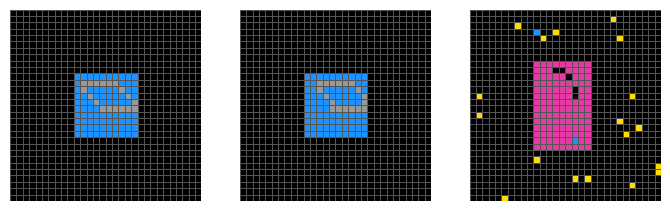

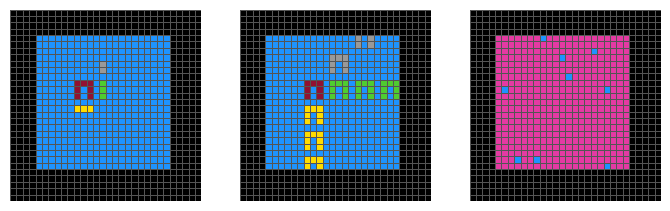

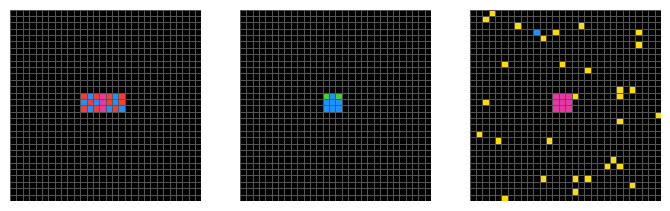

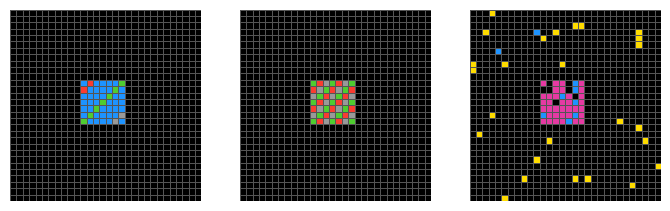

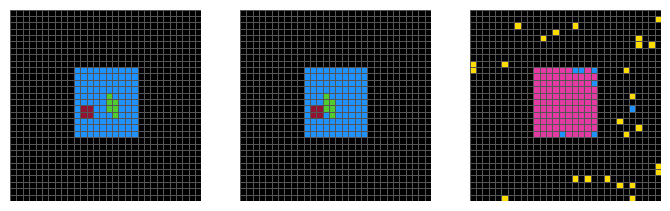

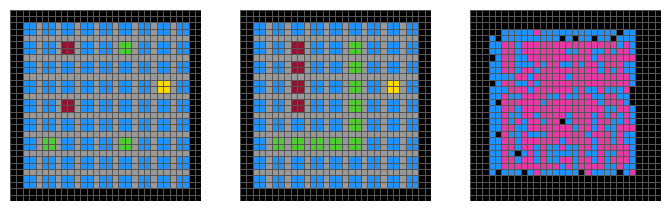

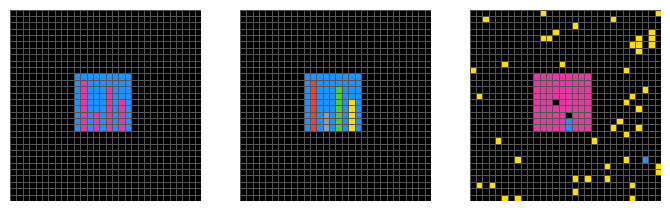

Epoch 27/100, Loss: 1.3743801165658693, Accuracy: 9.11031902879729%
Epoch 28/100


Validation: 100%|██████████| 26/26 [01:22<00:00,  3.18s/it]


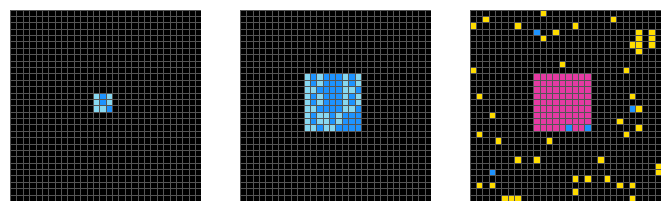

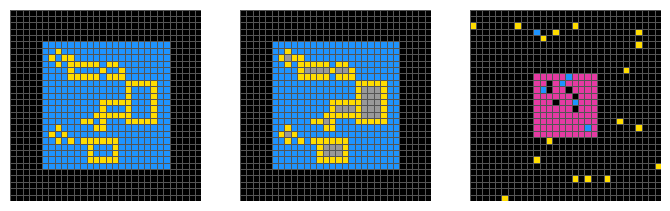

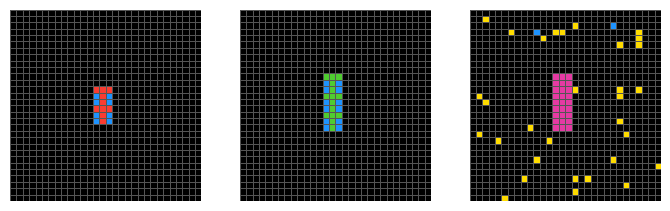

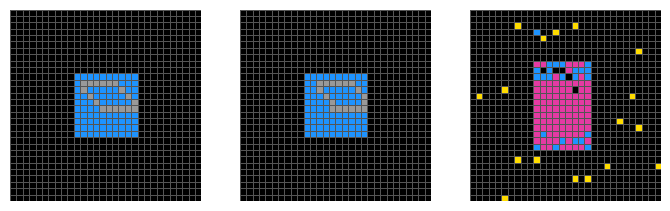

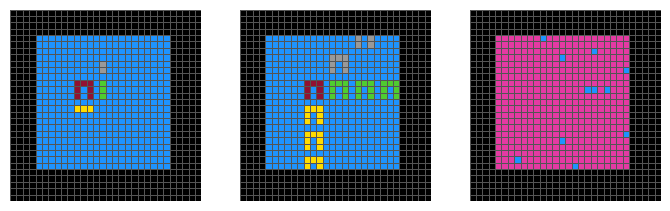

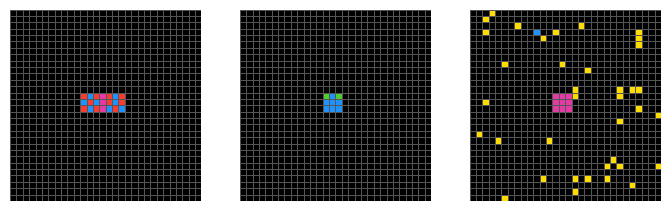

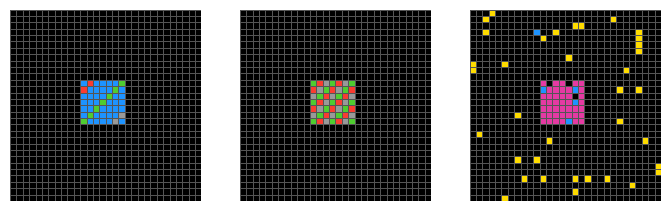

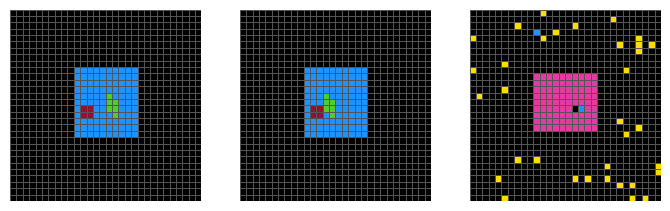

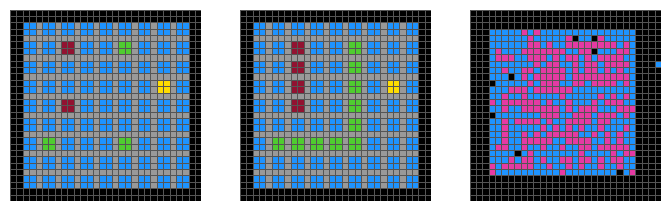

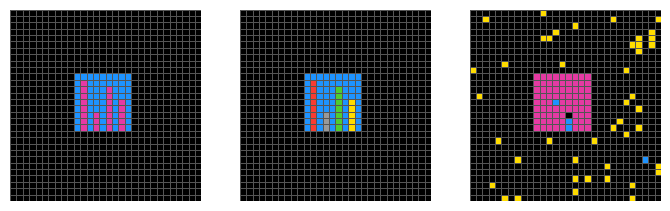

Epoch 28/100, Loss: 1.3787575394201737, Accuracy: 9.34853190287973%
Epoch 29/100


Validation: 100%|██████████| 26/26 [01:17<00:00,  2.98s/it]


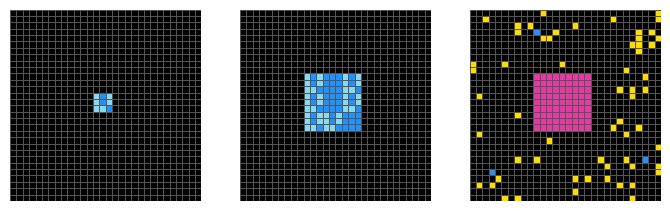

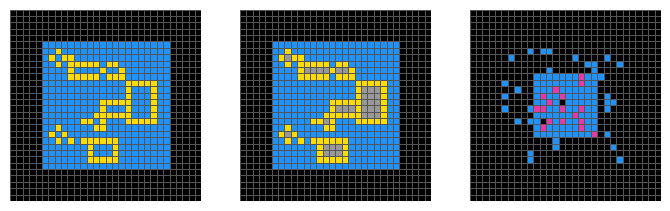

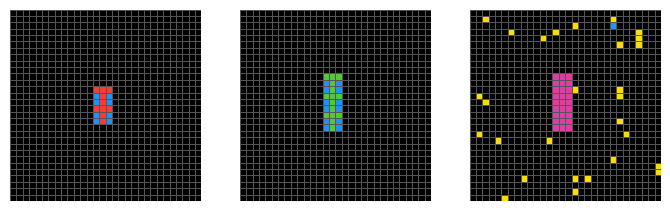

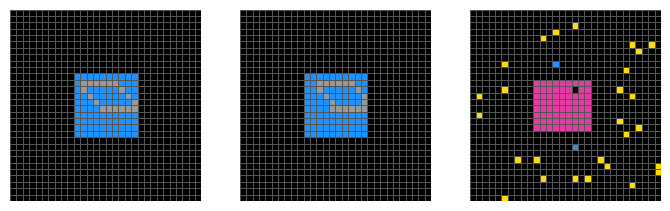

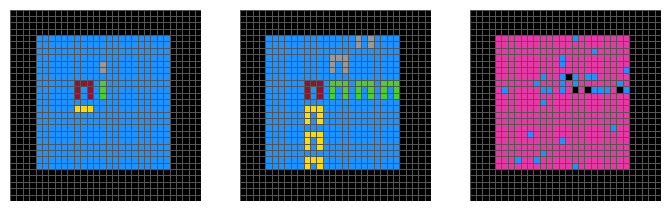

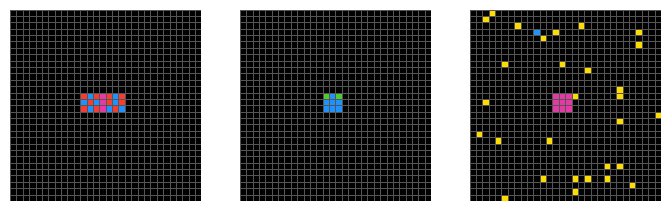

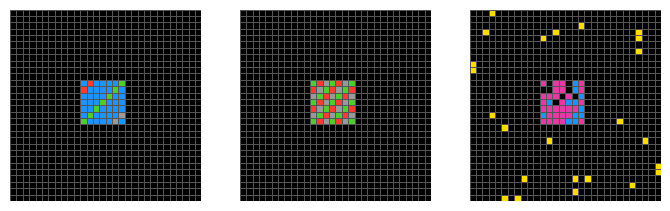

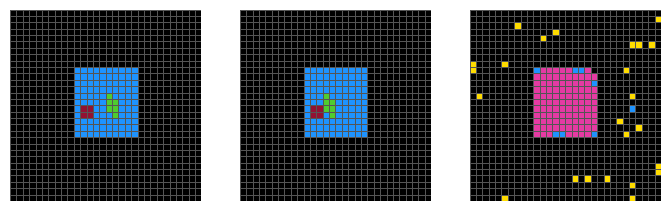

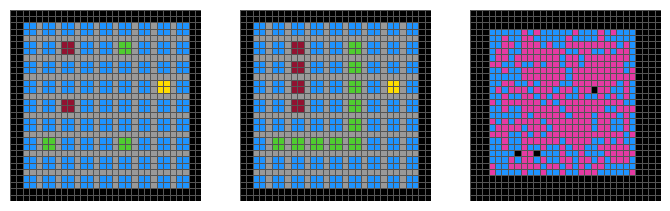

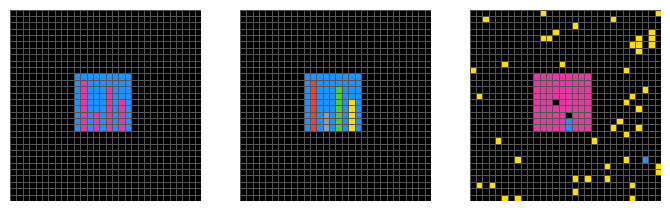

Epoch 29/100, Loss: 1.3765437350823329, Accuracy: 9.267363071710898%
Epoch 30/100


Validation: 100%|██████████| 26/26 [01:17<00:00,  2.99s/it]


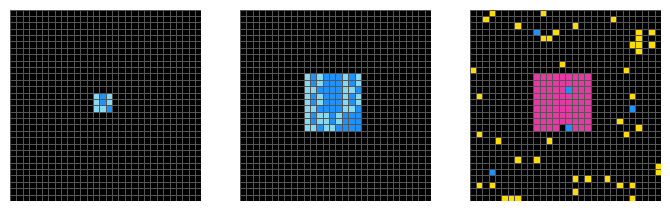

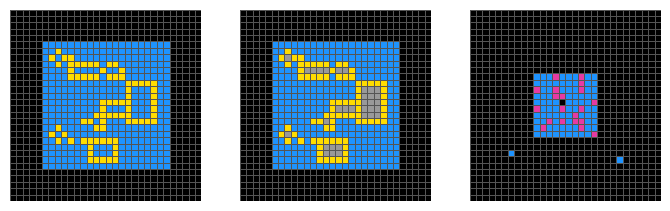

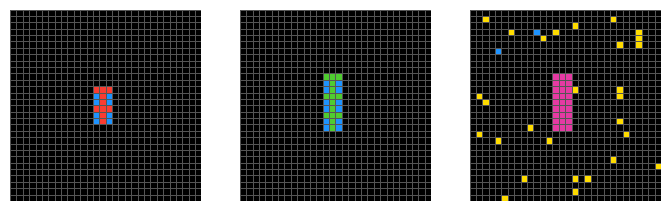

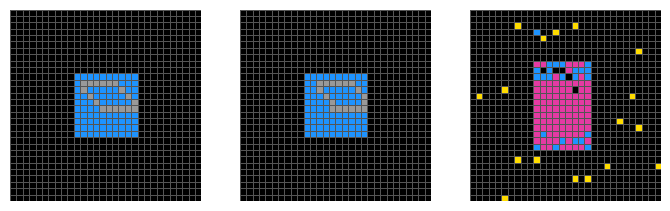

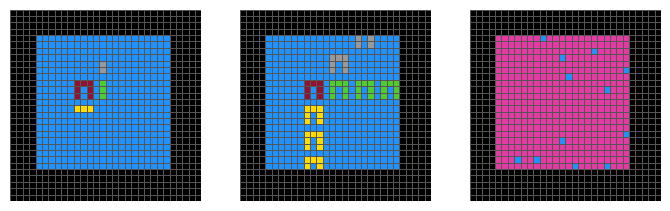

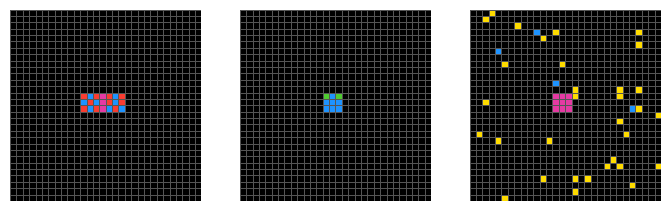

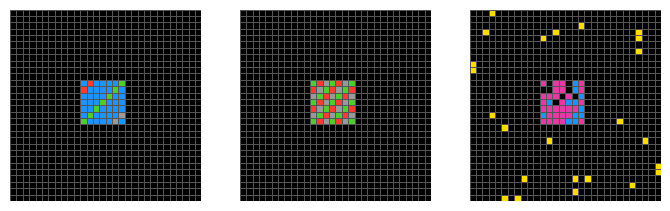

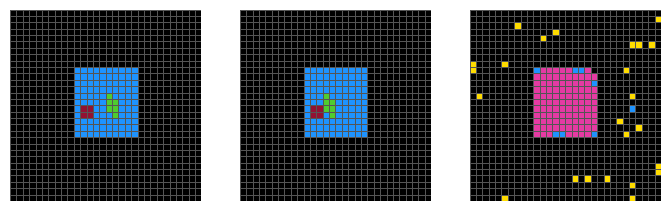

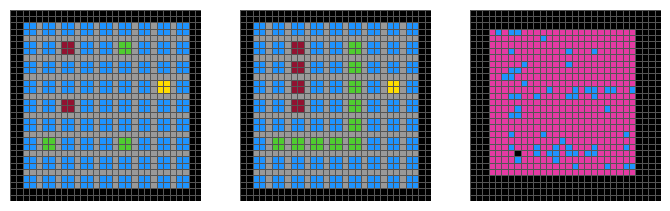

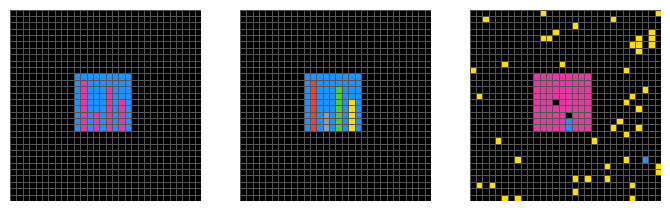

Epoch 30/100, Loss: 1.3815240782613938, Accuracy: 8.637422360248447%
Epoch 31/100


Validation: 100%|██████████| 26/26 [01:21<00:00,  3.15s/it]


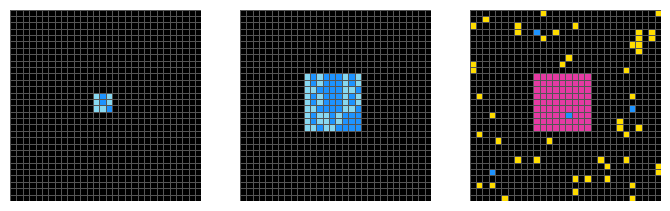

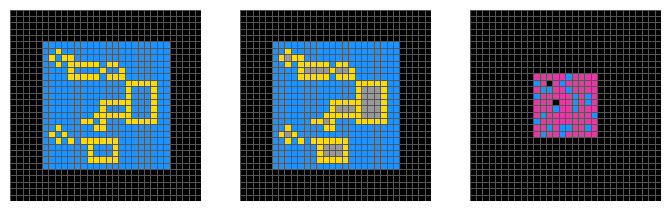

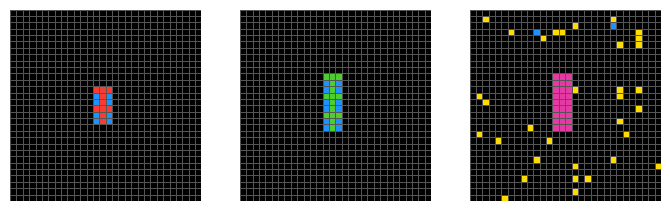

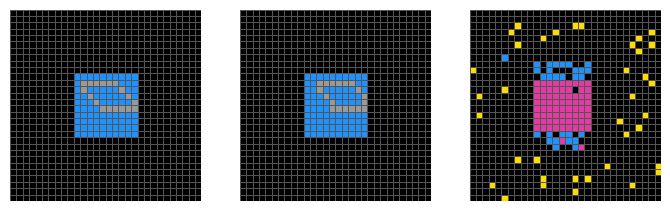

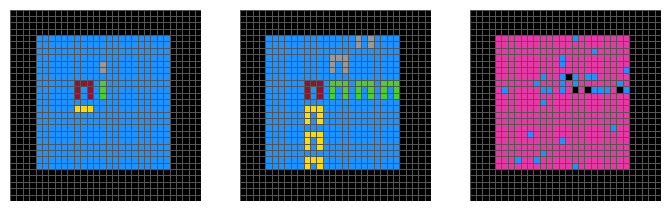

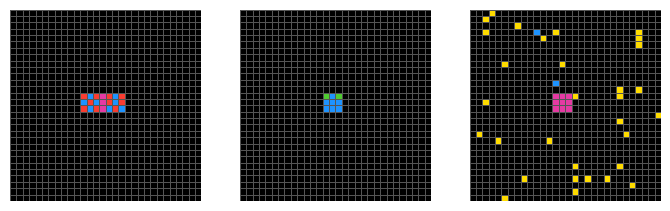

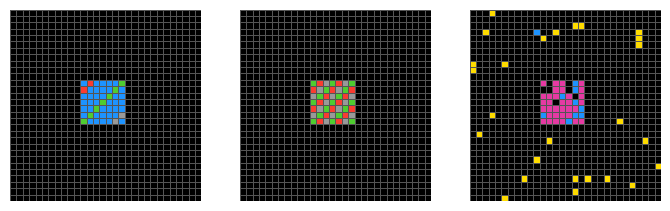

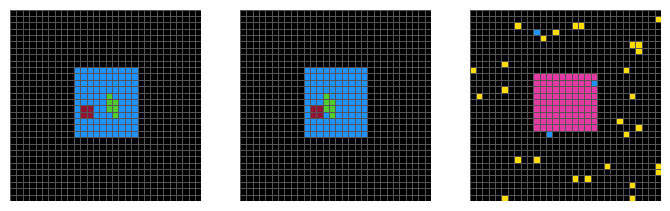

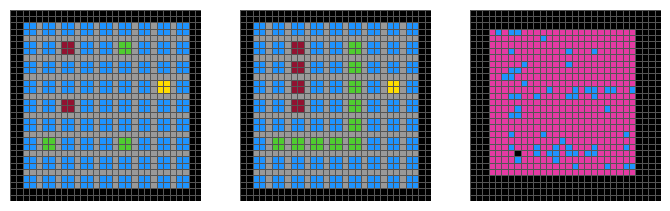

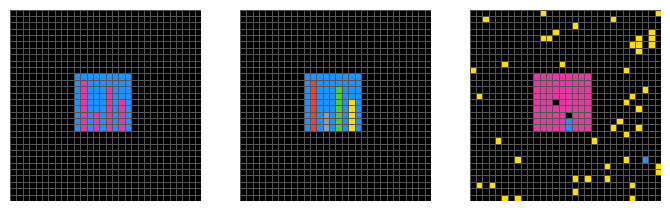

Epoch 31/100, Loss: 1.365126376828322, Accuracy: 9.04503105590062%
Epoch 32/100


Validation: 100%|██████████| 26/26 [01:18<00:00,  3.03s/it]


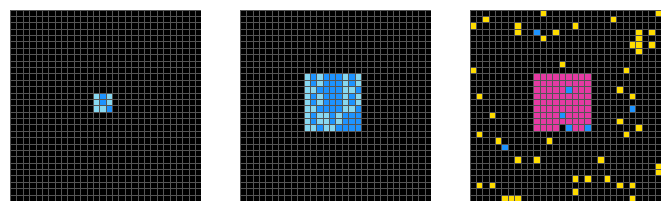

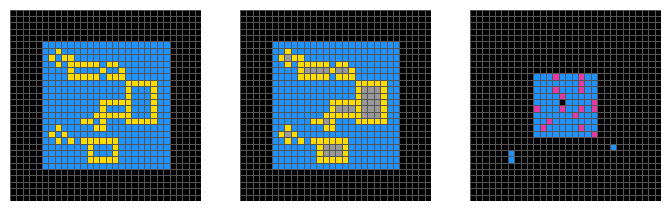

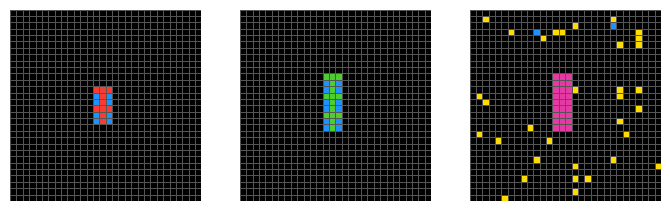

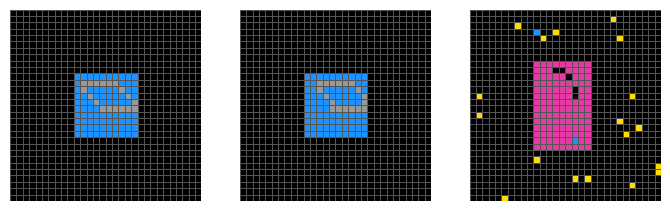

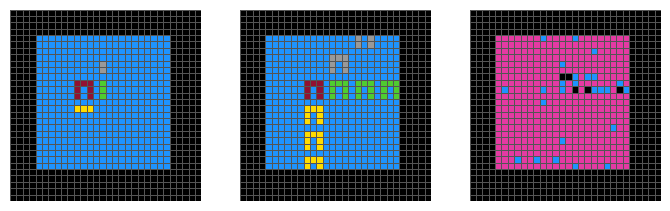

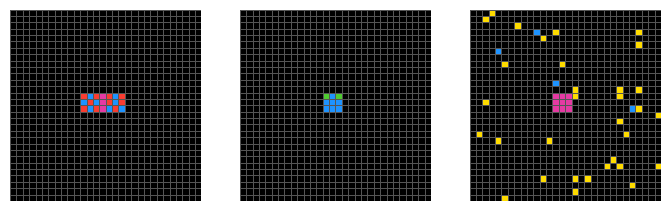

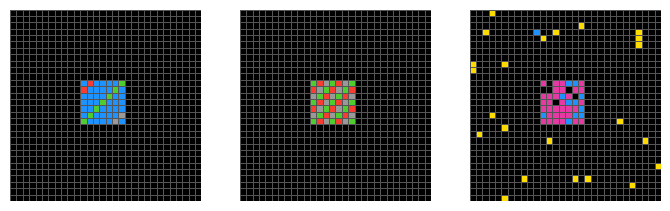

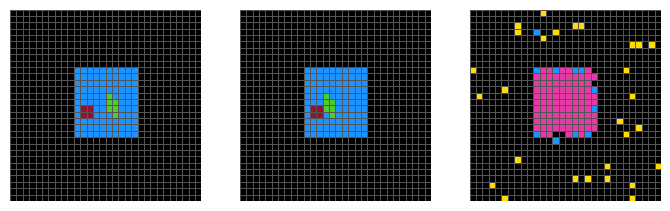

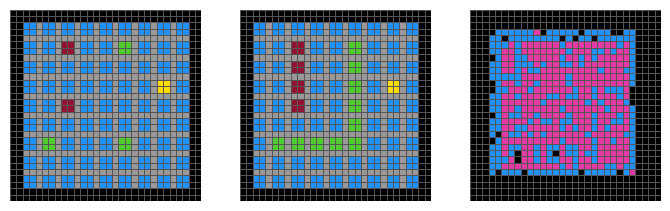

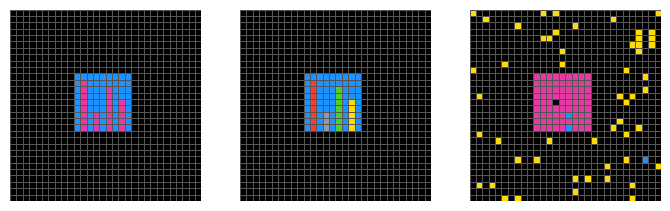

Epoch 32/100, Loss: 1.3812425838640103, Accuracy: 9.389116318464145%
Epoch 33/100


Validation: 100%|██████████| 26/26 [01:20<00:00,  3.09s/it]


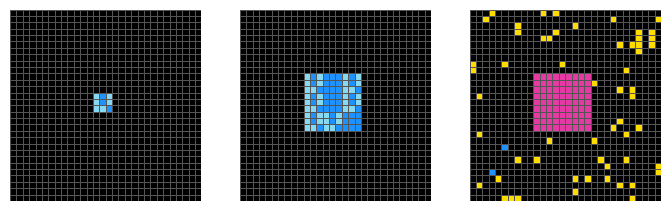

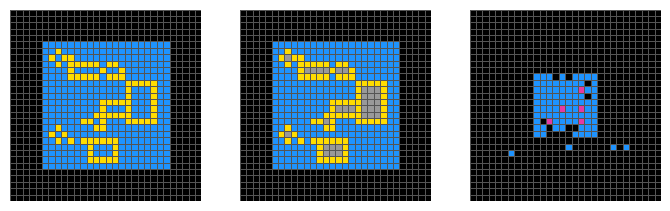

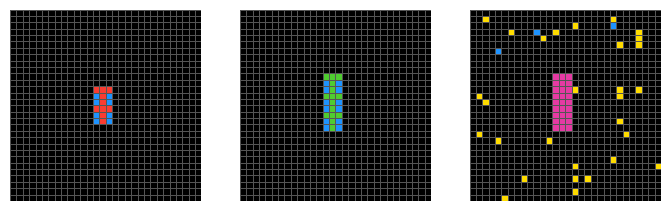

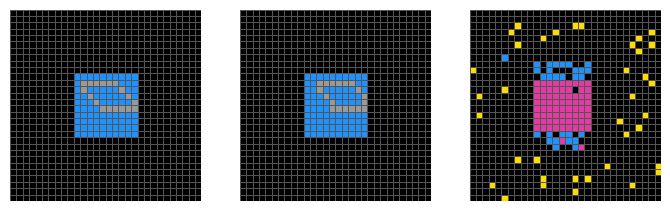

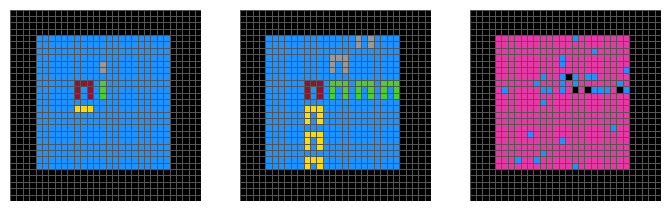

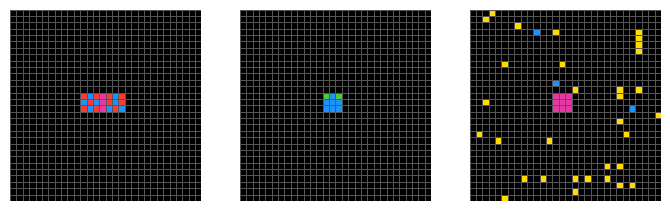

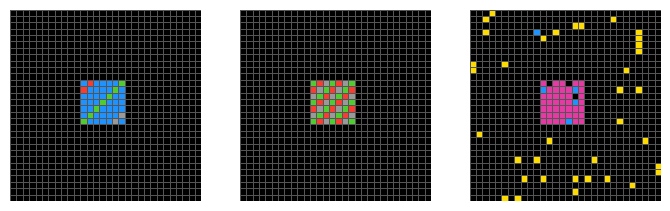

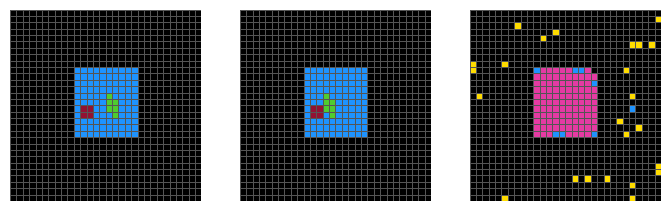

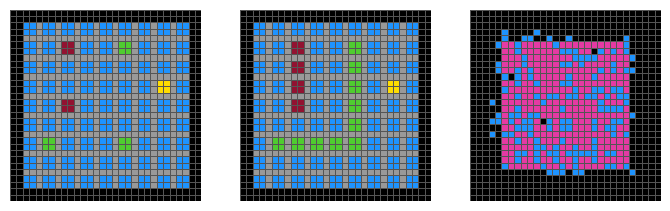

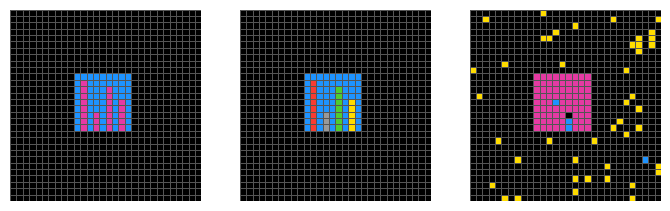

Epoch 33/100, Loss: 1.382616553742152, Accuracy: 8.930335968379447%
Epoch 34/100


Validation: 100%|██████████| 26/26 [01:19<00:00,  3.07s/it]


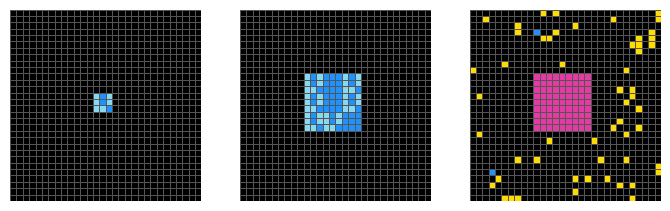

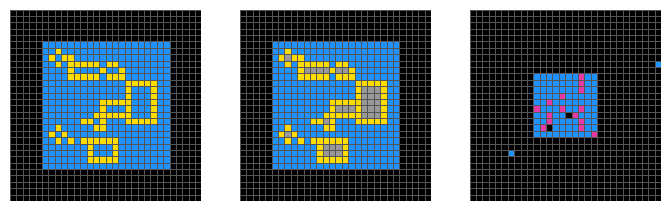

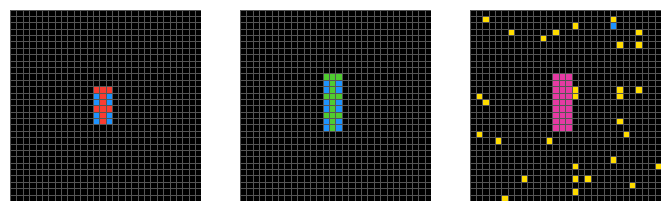

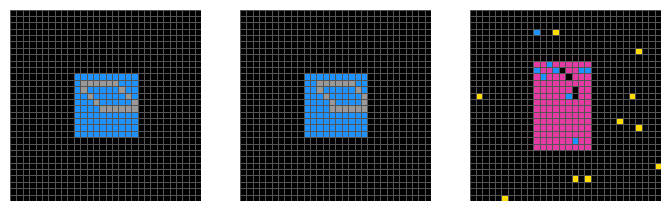

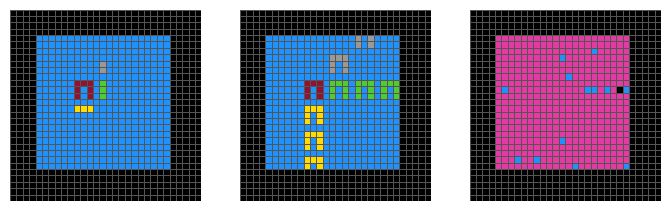

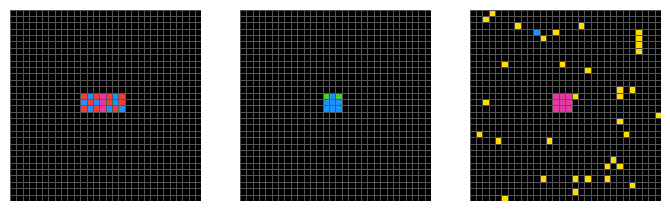

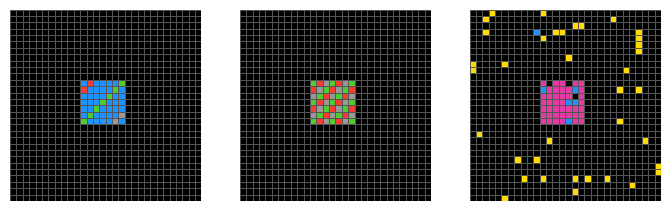

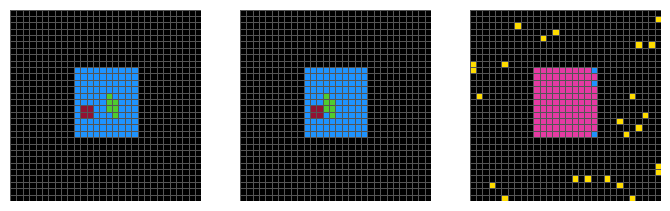

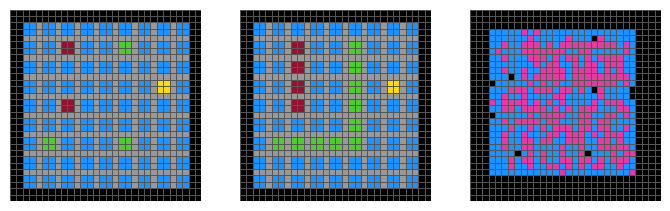

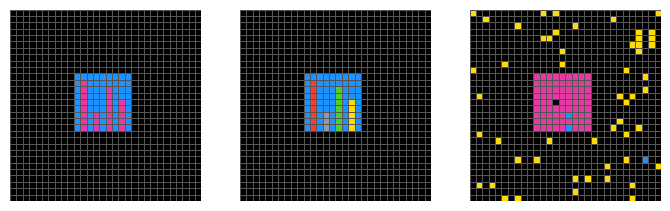

Epoch 34/100, Loss: 1.377164828662689, Accuracy: 8.439793901750424%
Epoch 35/100


Validation: 100%|██████████| 26/26 [01:19<00:00,  3.05s/it]


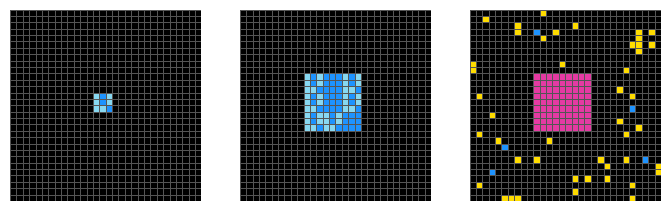

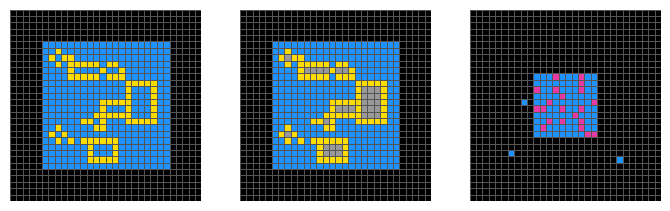

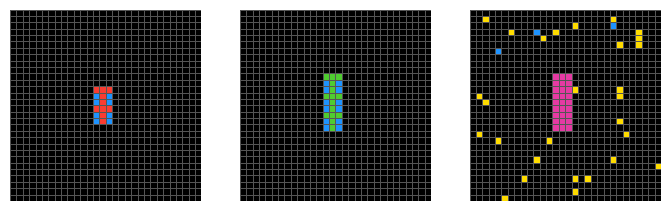

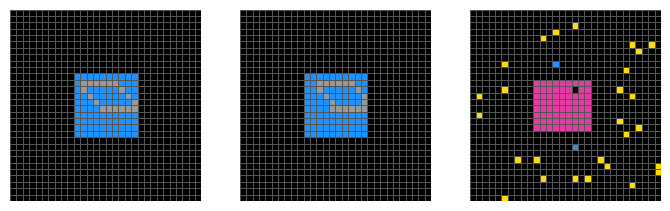

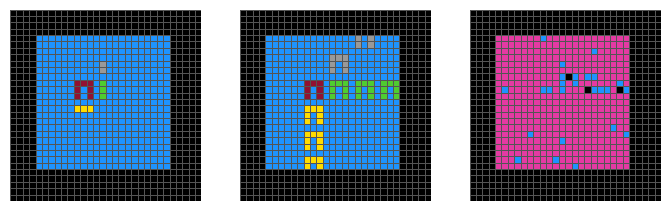

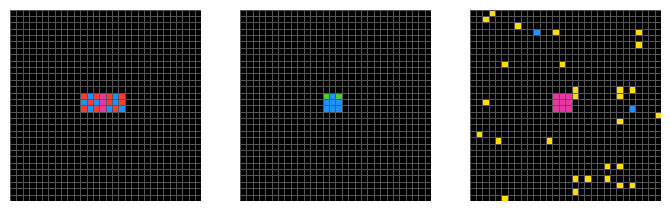

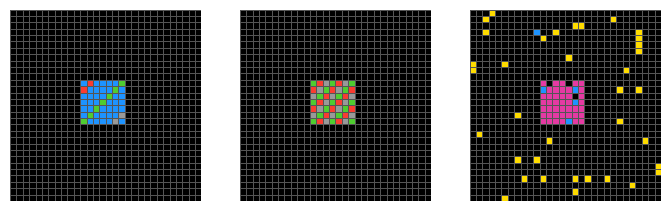

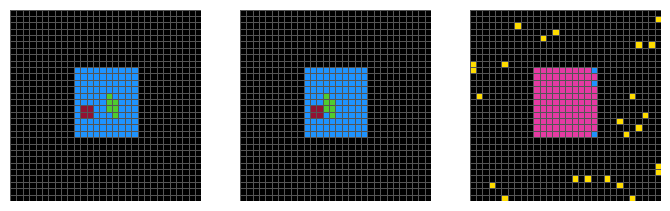

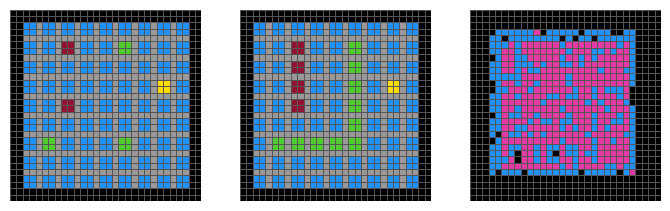

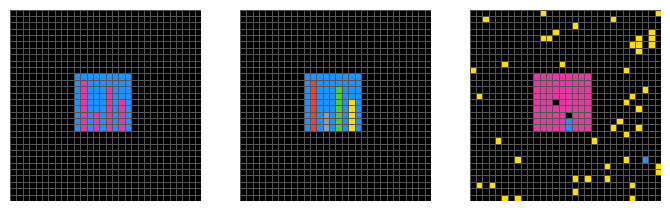

Epoch 35/100, Loss: 1.3851910514327197, Accuracy: 8.302159796725014%
Epoch 36/100


Validation: 100%|██████████| 26/26 [01:21<00:00,  3.12s/it]


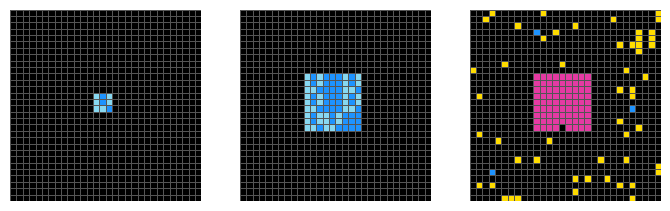

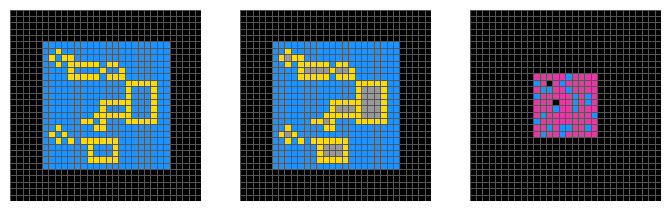

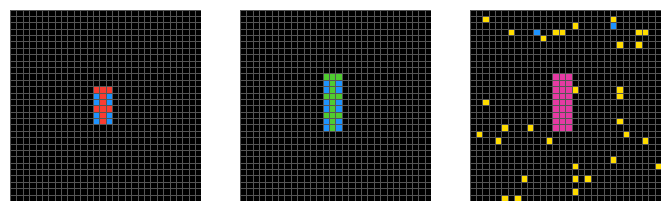

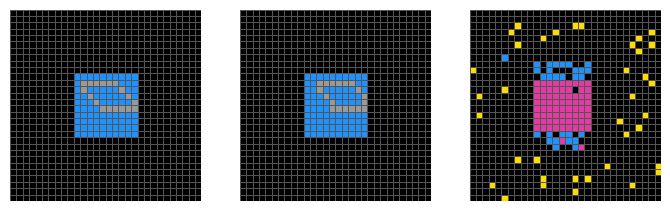

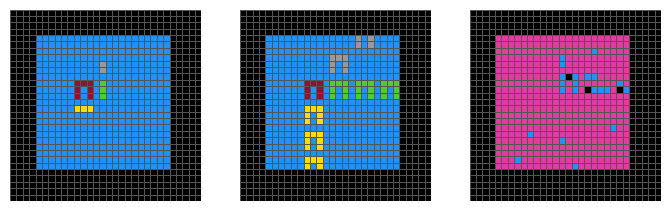

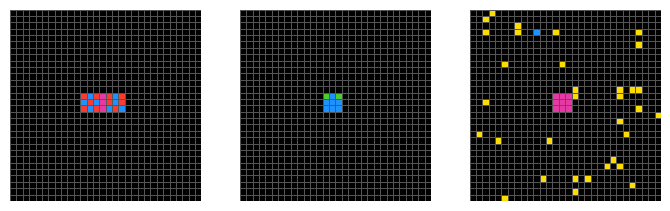

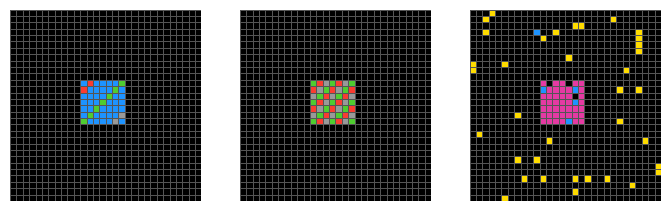

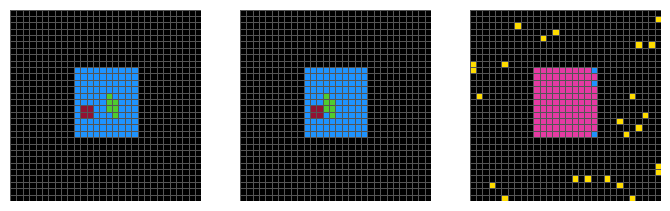

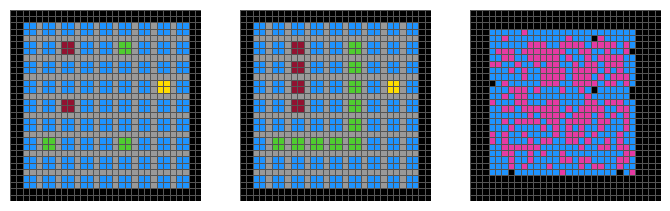

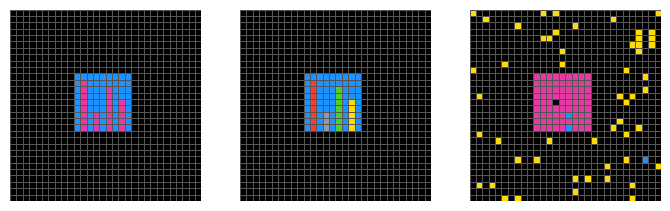

Epoch 36/100, Loss: 1.385393834601228, Accuracy: 9.756140598531903%
Epoch 37/100


Validation: 100%|██████████| 26/26 [01:18<00:00,  3.02s/it]


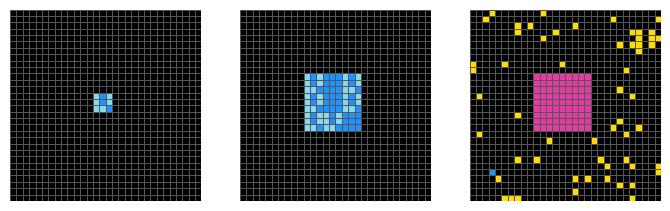

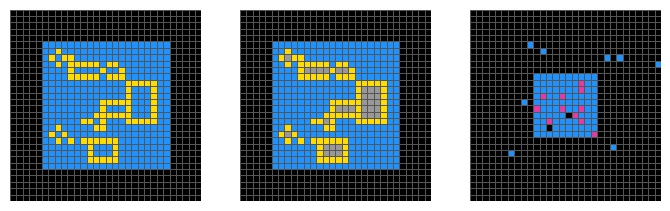

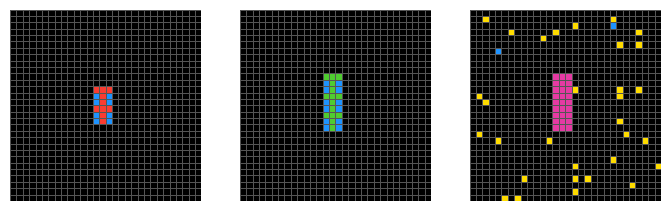

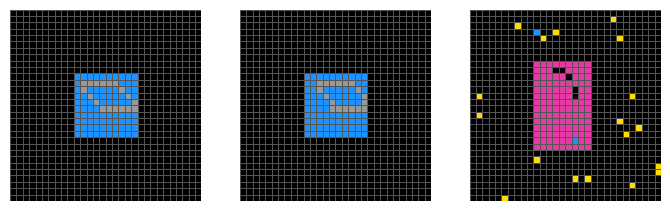

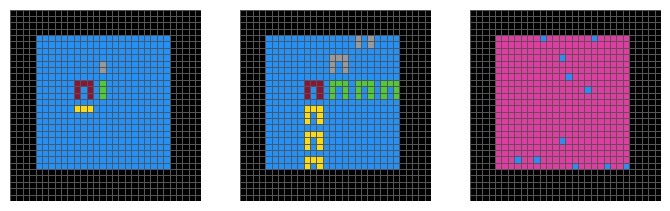

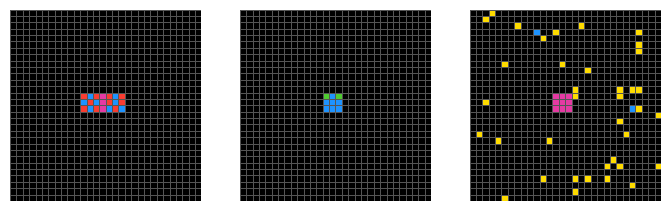

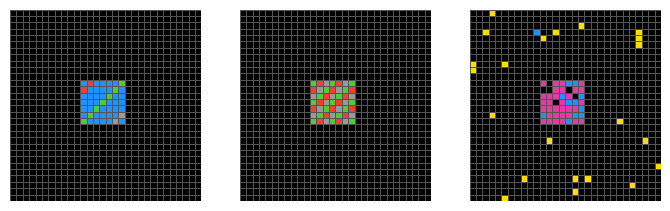

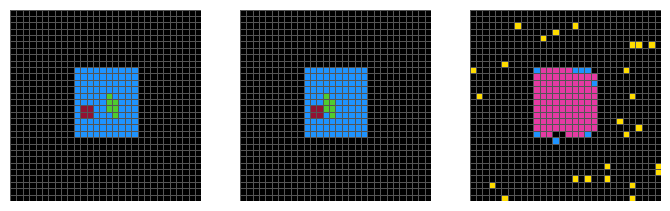

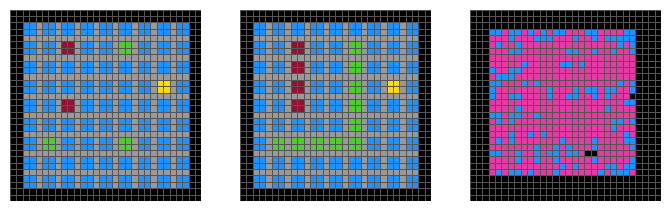

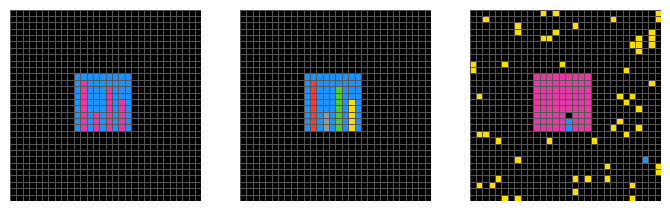

Epoch 37/100, Loss: 1.3759683248801873, Accuracy: 8.63389328063241%
Epoch 38/100


Validation: 100%|██████████| 26/26 [01:20<00:00,  3.09s/it]


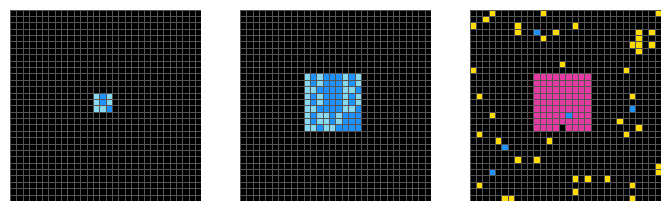

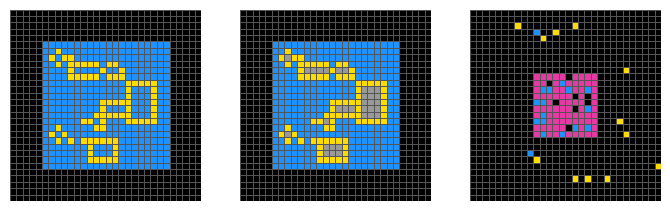

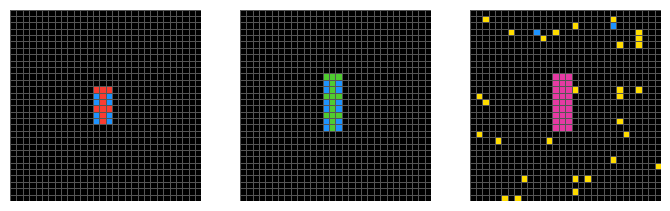

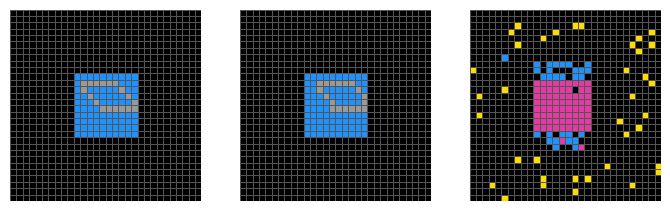

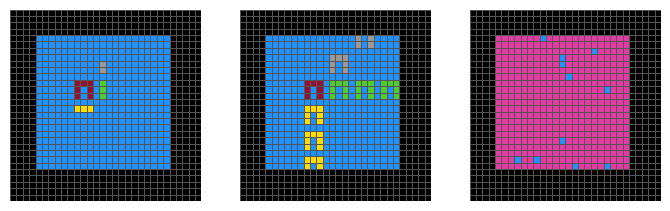

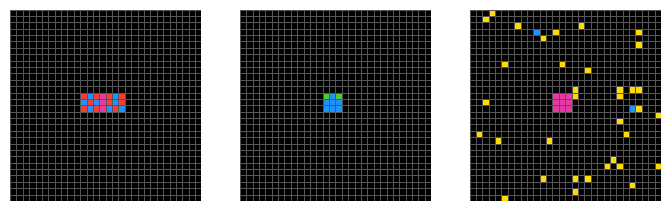

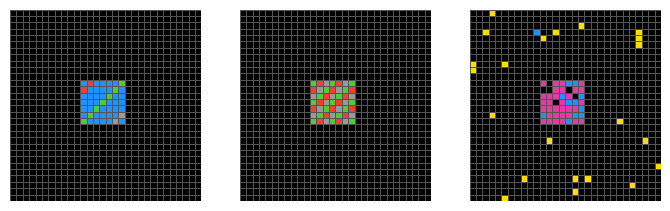

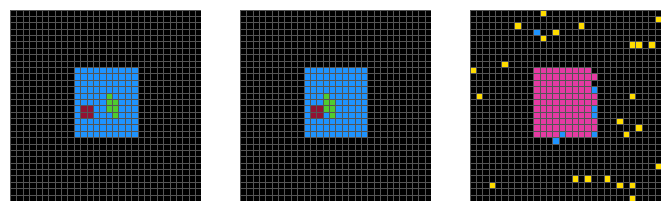

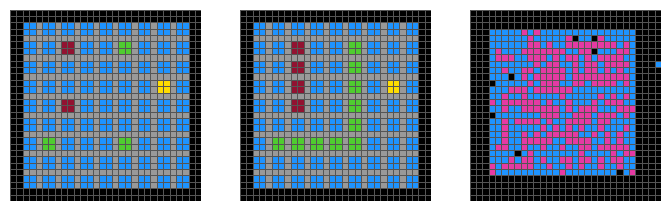

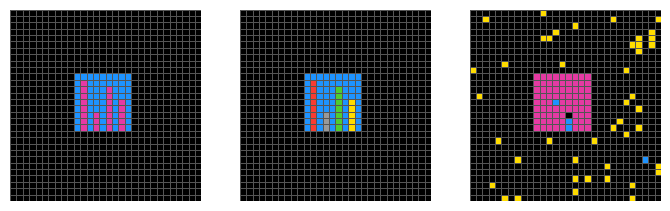

Epoch 38/100, Loss: 1.3767746764306839, Accuracy: 8.494494635798983%
Epoch 39/100


Validation: 100%|██████████| 26/26 [01:21<00:00,  3.12s/it]


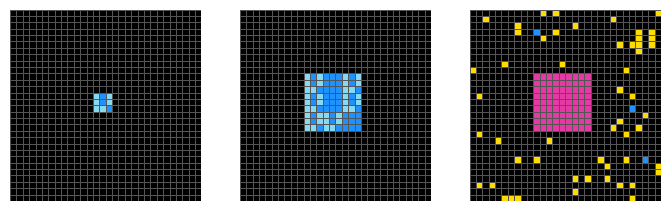

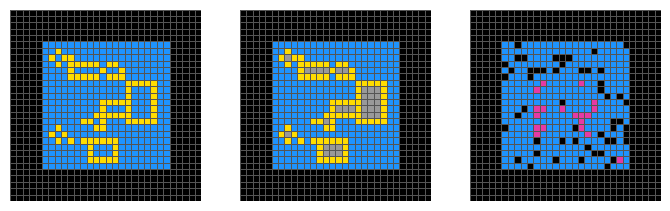

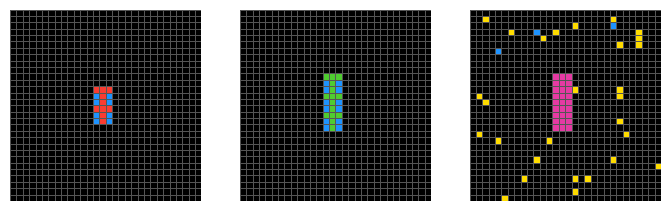

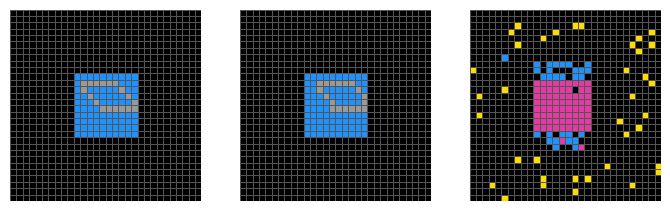

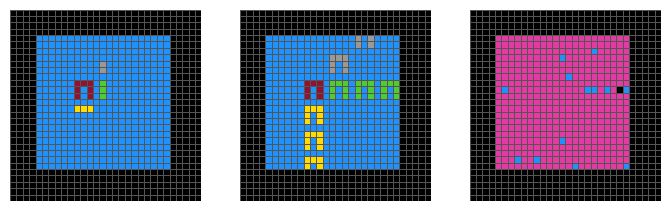

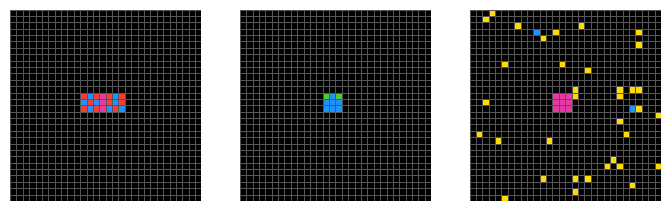

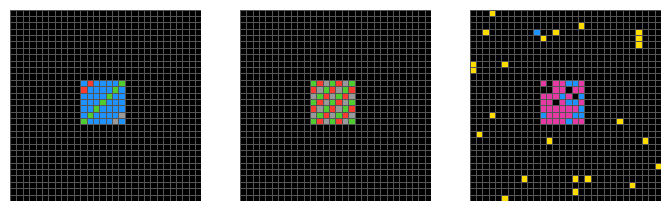

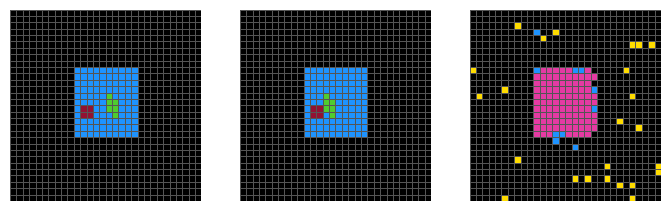

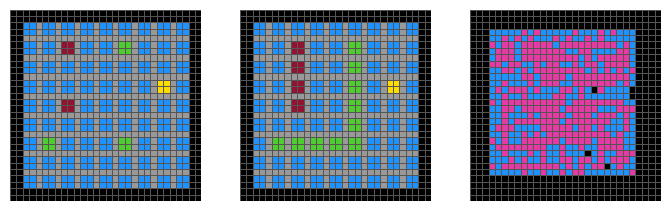

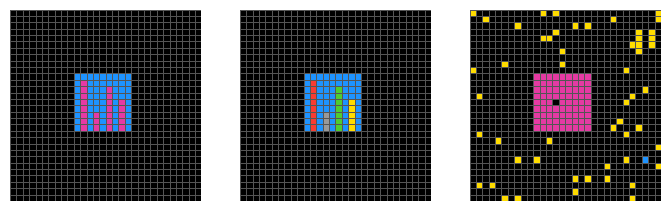

Epoch 39/100, Loss: 1.3589101718881955, Accuracy: 9.61321287408244%
Epoch 40/100


Validation: 100%|██████████| 26/26 [01:18<00:00,  3.04s/it]


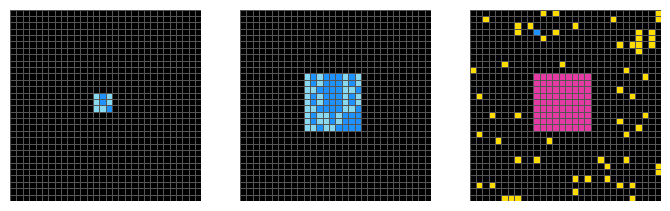

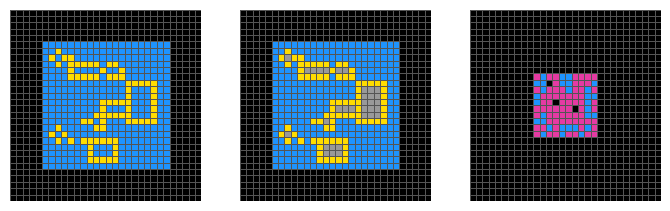

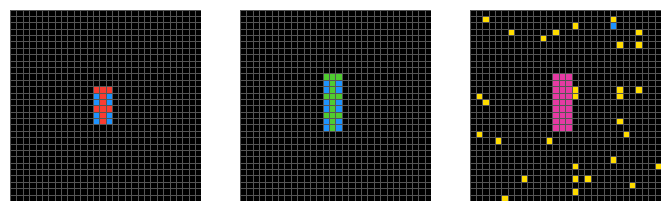

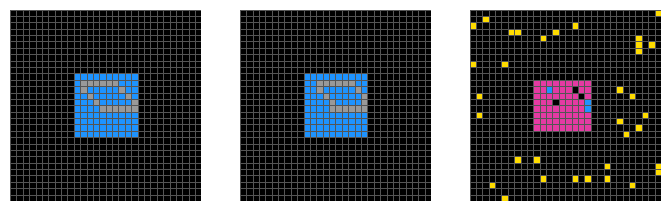

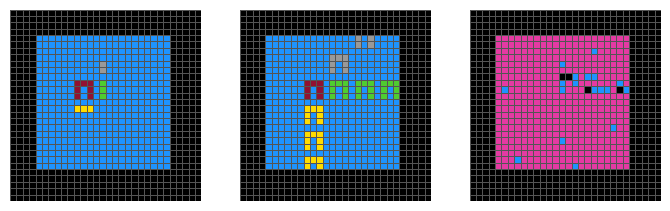

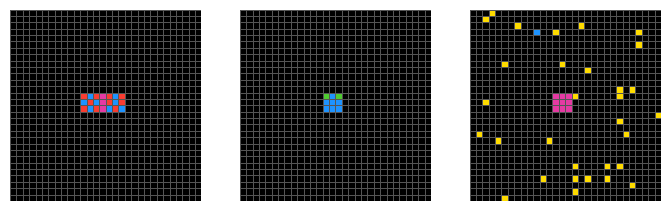

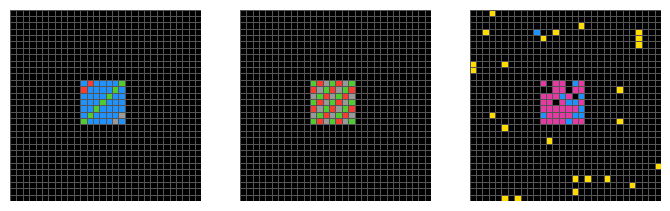

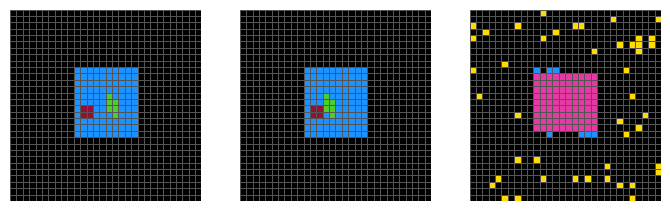

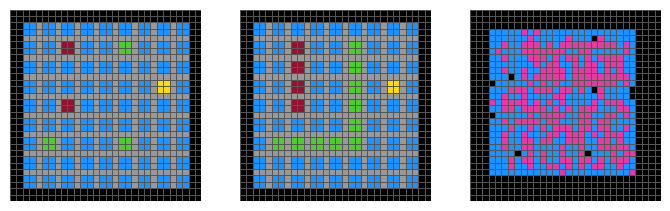

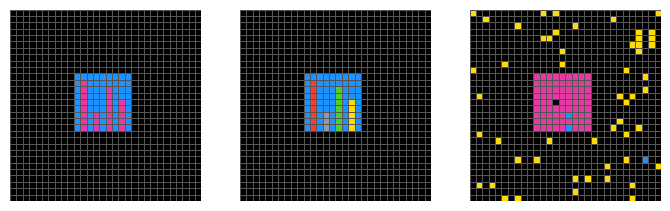

Epoch 40/100, Loss: 1.3824891278950067, Accuracy: 9.170313382269905%
Epoch 41/100


Validation: 100%|██████████| 26/26 [01:18<00:00,  3.02s/it]


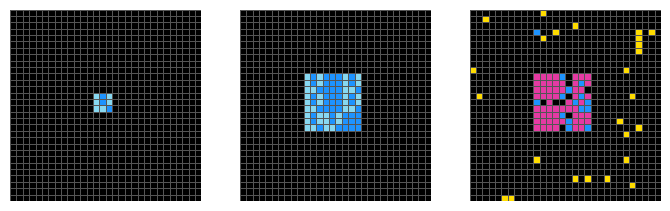

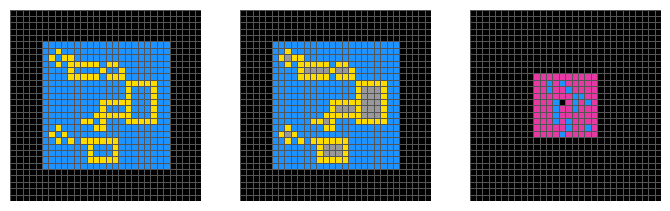

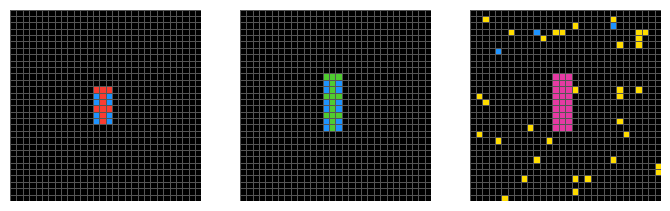

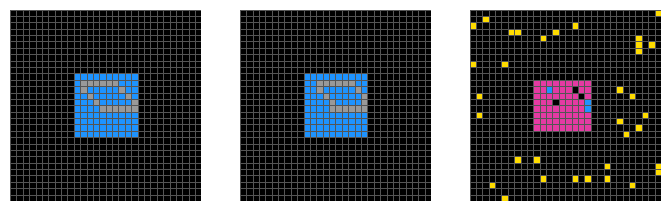

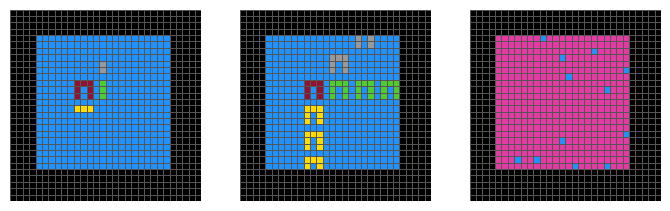

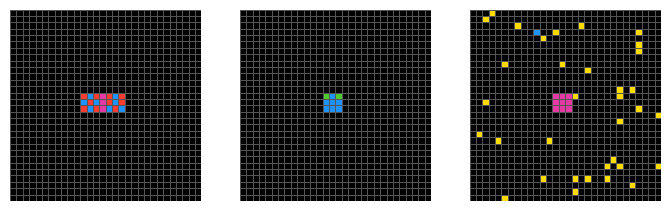

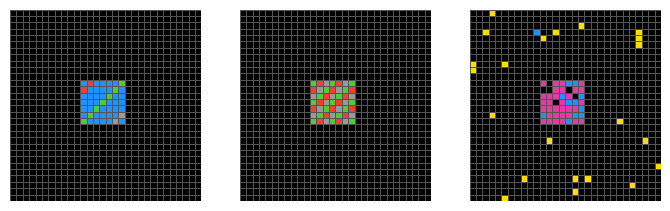

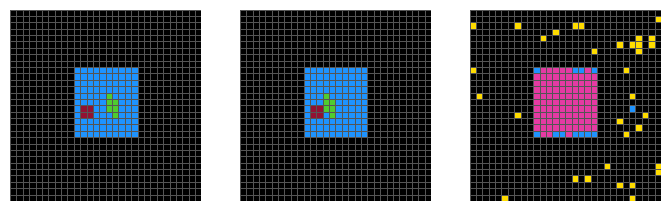

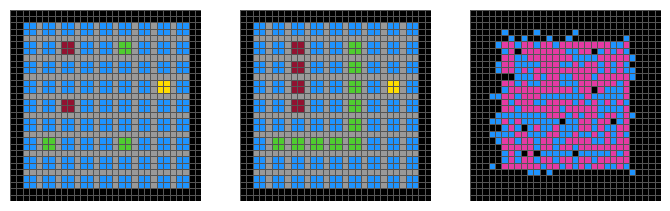

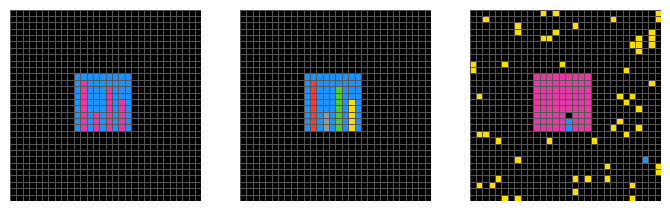

Epoch 41/100, Loss: 1.383707861487682, Accuracy: 8.736236589497459%
Epoch 42/100


Validation: 100%|██████████| 26/26 [01:18<00:00,  3.03s/it]


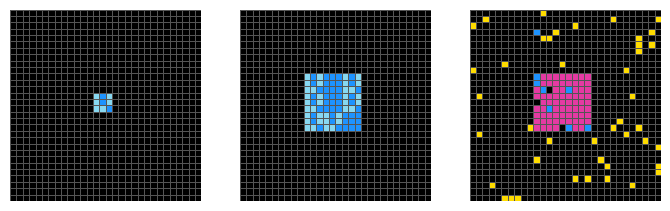

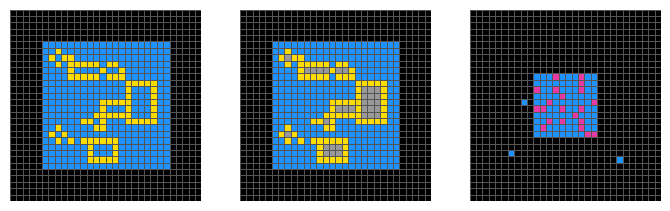

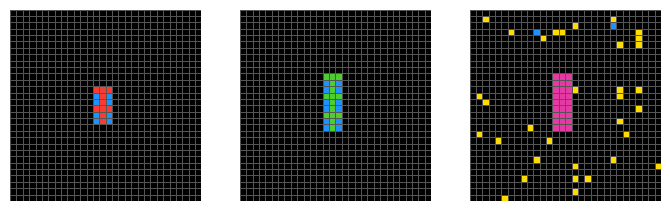

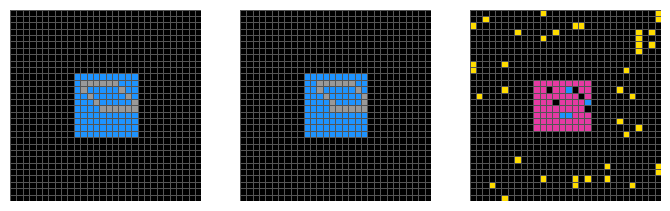

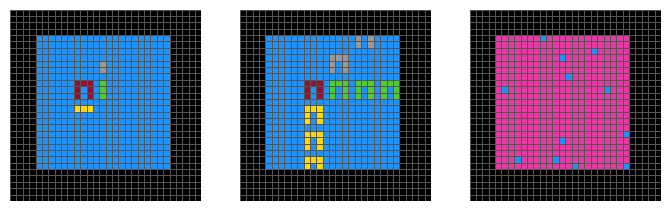

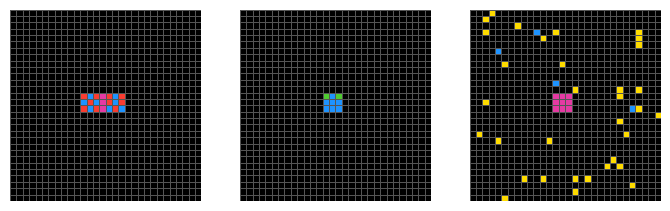

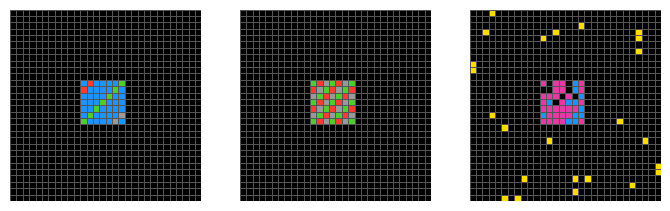

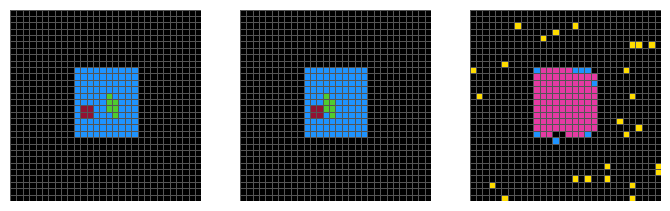

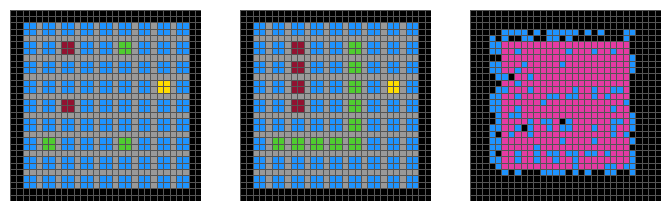

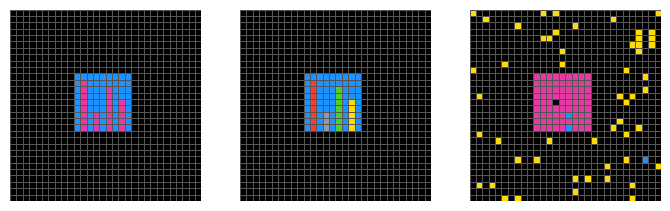

Epoch 42/100, Loss: 1.3836607286849847, Accuracy: 9.099731789949182%
Epoch 43/100


Validation: 100%|██████████| 26/26 [01:18<00:00,  3.03s/it]


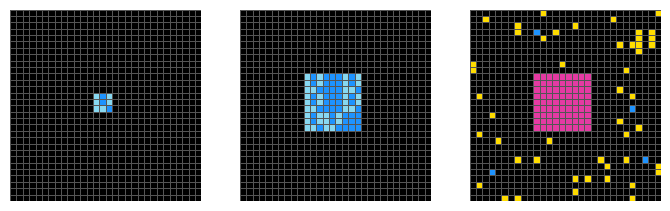

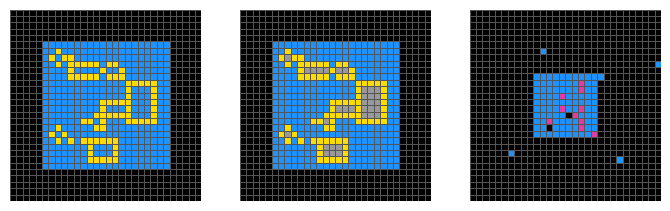

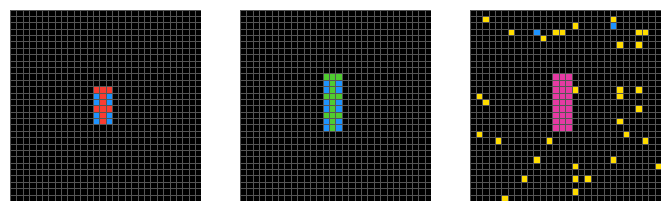

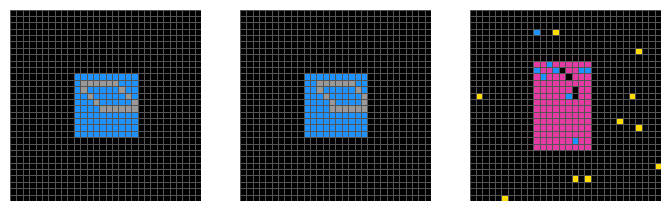

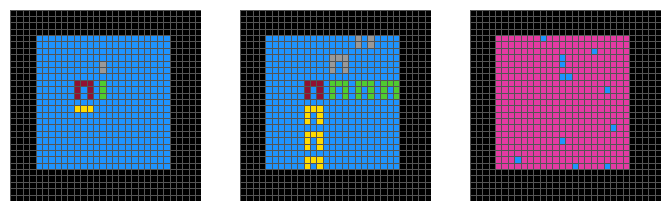

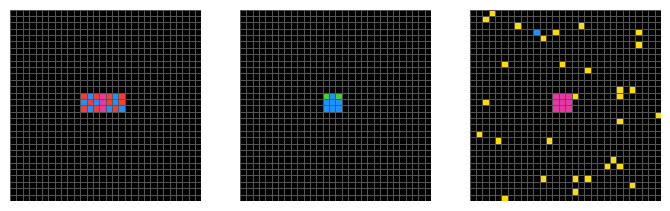

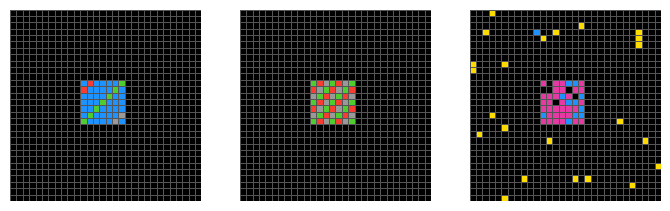

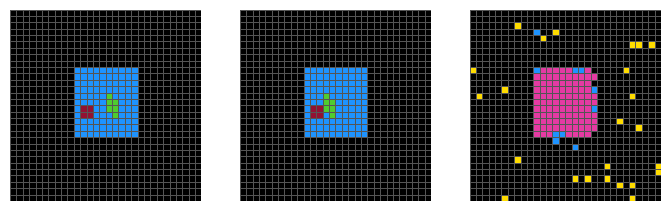

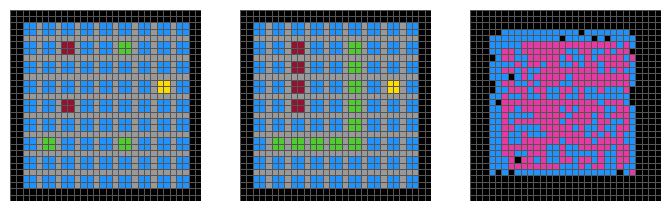

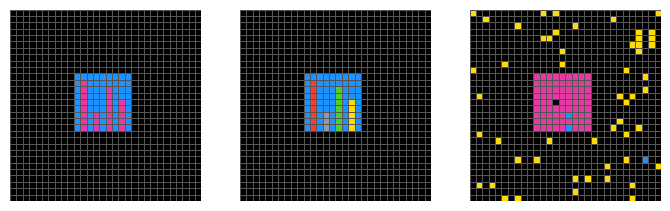

Epoch 43/100, Loss: 1.3800899959527528, Accuracy: 8.678006775832863%
Epoch 44/100


Validation: 100%|██████████| 26/26 [01:26<00:00,  3.31s/it]


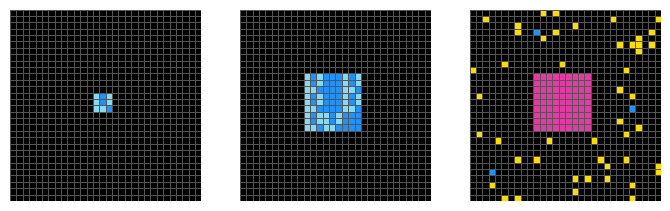

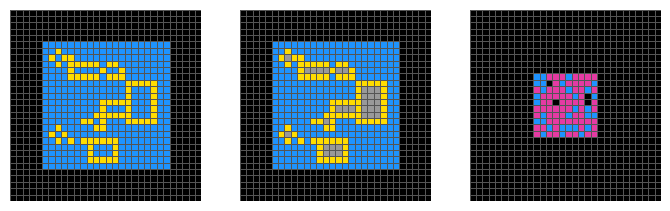

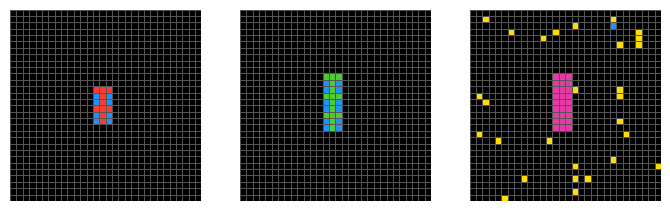

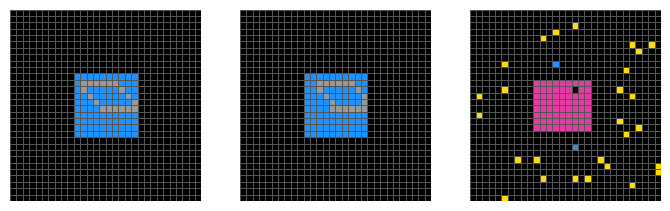

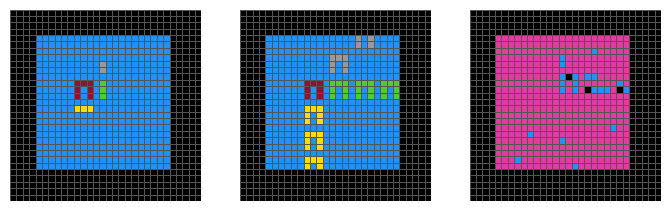

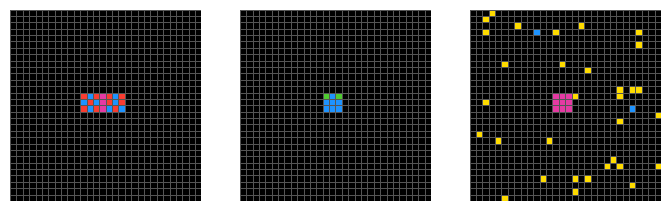

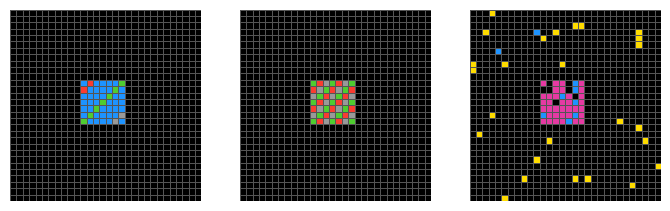

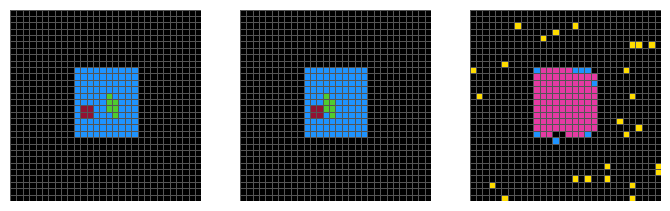

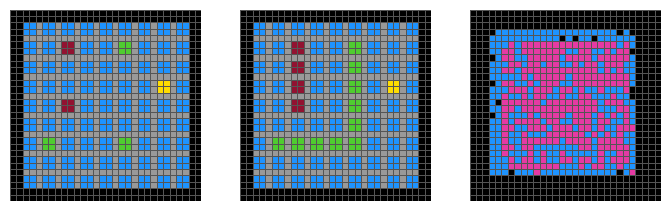

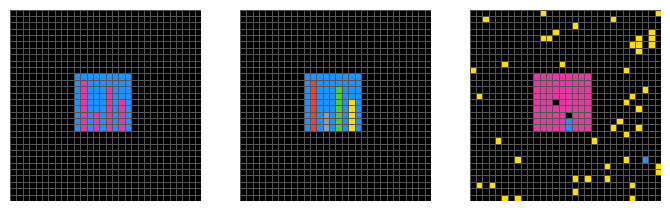

Epoch 44/100, Loss: 1.3776208266902428, Accuracy: 9.050324675324676%
Epoch 45/100


Training:  69%|██████▉   | 18/26 [00:22<00:09,  1.16s/it]

In [1]:
from bw_net_maml import BWNet_MAML
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import gc
import random

def remapping_output(tensor):
    # 범위별 매핑 딕셔너리
    remapping = {
        (1, 10): -1,
        (11, 20): -2,
        (21, 30): -3,
        (31, 40): -4,
        (41, 50): -5,
        (51, 60): -6,
        (61, 70): -7,
        (71, 80): -8,
        (81, 90): -9,
        (91, 100): -10
    }
    
    temp_tensor = tensor.clone()

    # 각 범위에 대해 매핑 수행
    for value_range, new_value in remapping.items():
        mask = (temp_tensor >= value_range[0]) & (temp_tensor <= value_range[1])
        temp_tensor[mask] = new_value  # 임시로 기존 값에 음수를 취해 중복을 피함
    for value_range, new_value in remapping.items():
        temp_tensor[temp_tensor == new_value] = -1*new_value  # 음수로 변환된 값을 다시 양수로 변환

    return temp_tensor


colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

def inner_loop_update(model, example_input, example_output, inner_optimizer, criterion, steps):
    for _ in range(steps):
        model.train()
        prediction = model(example_input)
        example_output = remapping_output(example_output)
        loss = criterion(prediction, example_output)

        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()


def criterion(y_pred, y):
    y = y.long().squeeze(1)
    ce = F.cross_entropy(y_pred, y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 100,
    'task_numbers': 16, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 3, #equal to inner model batch size
    'inner_lr': 0.001,
    'outer_lr': 0.001,
    'embed_size': 1,
    
}

# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device  
print(f'Using {device} device')


train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

outer_model = BWNet_MAML(embed_size=kwargs['embed_size']).to(device)
outer_optimizer= optim.AdamW(outer_model.parameters(),lr=kwargs['outer_lr'])

for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    total_loss = 0
    # total_samples = 0
    outer_model.train()

    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]
        
        # total_samples += input_tensor.shape[0]
        task_losses = []
        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_optimizer = optim.AdamW(inner_model.parameters(),lr=kwargs['inner_lr'])
            
            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                              inner_optimizer, criterion, kwargs['example_data_num'])
            
        
            inner_model.eval()
            task_prediction = inner_model(input_tensor[task_number])
            ###
            task_output = remapping_output(output_tensor[task_number])
            task_loss = criterion(task_prediction, task_output)
            ###
            #task_loss = criterion(task_prediction, output_tensor[task_number])
            task_losses.append(task_loss)
        
        meta_loss = torch.stack(task_losses).mean()
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()
        
        del meta_loss, task_losses
        gc.collect()
        torch.cuda.empty_cache()
        

    del inner_optimizer
    torch.cuda.empty_cache()
    gc.collect()
    
    # Validation Loop
    outer_model.eval()
    validation_correct = 0
    validation_total_samples = 0
    total_loss = []
    visualization_samples = []
    for batch_idx, data in enumerate(tqdm(eval_loader, desc='Validation')):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        for task_number in range(input_tensor.shape[0]):
            inner_model = deepcopy(outer_model)
            inner_model.train()
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])

            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                            inner_optimizer, criterion, kwargs['example_data_num'])

            with torch.no_grad():
                inner_model.eval()
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                task_prediction = inner_model(task_input)

                task_output = remapping_output(task_output)

                task_loss = criterion(task_prediction, task_output)
                total_loss.append(task_loss.item())  # task_loss.item()을 리스트에 추가

                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)

                mask = task_output != 0
                correct_predictions = (prediction_class == task_output) & mask
                validation_correct += correct_predictions.sum().item()
                validation_total_samples += mask.sum().item()
            
            if len(visualization_samples) < 10:  # 예를 들어 10개의 샘플만 저장
                        visualization_samples.append((
                            remapping_output(task_input.cpu()),
                            #remapping_output(task_output.cpu()),
                            #remapping_output(prediction_class.cpu())
                            task_output.cpu(),
                            prediction_class.cpu()
                        ))

            del inner_model, inner_optimizer, task_input, task_output, task_prediction, mask, correct_predictions
            gc.collect()
            torch.cuda.empty_cache()

    if visualization_samples:
        for vis_input, vis_output, vis_prediction in visualization_samples:
            show_grid_side_by_side(vis_input, vis_output, vis_prediction)

            

    # 손실 값들의 평균 계산
    mean_loss = sum(total_loss) / len(total_loss) if total_loss else 0
    accuracy = 100 * validation_correct / validation_total_samples if validation_total_samples > 0 else 0
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {mean_loss}, Accuracy: {accuracy}%')
    torch.cuda.empty_cache()

In [ ]:
from bw_net import BWNet
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

def criterion(y_pred,y):
    y = y.long()
    ce = F.cross_entropy(y_pred,y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"


kwargs = {
    'epochs': 5,
    'task_numbers': 10, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20, #equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
    
}
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

model = BWNet()
optimizer= optim.AdamW(model.parameters(),lr=kwargs['outer_lr'])

for data in train_loader:
      input_tensor, output_tensor, example_input, example_output = data
      print(f'Input: {input_tensor.shape}')
      for task_number in range(input_tensor.shape[0]):
        task_input = input_tensor[task_number]
        task_output = output_tensor[task_number]
        ex_input = example_input[task_number]
        ex_output = example_output[task_number]
        print(f'Task {task_number+1}/{kwargs["task_numbers"]}')
        print(f'Input: {task_input.shape}')
        print(f'Output: {task_output.shape}')
        print(f'Example Input: {ex_input.shape}')
        print(f'Example Output: {ex_output.shape}')
        print('---------------------------------')


Input: torch.Size([10, 1, 1, 30, 30])
Task 1/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 2/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 3/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 4/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 5/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 3

In [ ]:
from bw_net import BWNet
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

def criterion(y_pred,y):
    y = y.long()
    ce = F.cross_entropy(y_pred,y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"


kwargs = {
    'epochs': 5,
    'task_numbers': 10, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20, #equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
    
}
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

model = BWNet()
optimizer= optim.AdamW(model.parameters(),lr=kwargs['outer_lr'])

for data in eval_loader:
      input_tensor, output_tensor, example_input, example_output = data
      print(f'Input: {input_tensor.shape}')
      for task_number in range(input_tensor.shape[0]):
        task_input = input_tensor[task_number]
        task_output = output_tensor[task_number]
        ex_input = example_input[task_number]
        ex_output = example_output[task_number]
        print(f'Task {task_number+1}/{kwargs["task_numbers"]}')
        print(f'Input: {task_input.shape}')
        print(f'Output: {task_output.shape}')
        print(f'Example Input: {ex_input.shape}')
        print(f'Example Output: {ex_output.shape}')
        print('---------------------------------')


Input: torch.Size([10, 1, 1, 30, 30])
Task 1/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 2/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 3/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 4/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 5/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 3